# Predict

## Setup

In [ ]:
# !pip install git+https://github.com/sky1ove/katlas.git -Uqq

In [ ]:
from katlas.imports import *
from fastbook import *
from functools import reduce
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

## Load data

In [ ]:
# info = Data.get_kinase_info_full().query('pseudo =="0"')

In [ ]:
df = Data.get_kinase_info().query('pseudo=="0"')

In [ ]:
# Remove too long proteins as they can't fit into the model
df = df[df.human_uniprot_sequence.str.len()<7000]
df = df[df.kinasecom_domain.str.len()<7000]

### Get protein embeddings

Uncheck below to get protein embeddings for the kinases

In [ ]:
# Remove too long proteins as they can't fit into the model
# valid_uniprot = df[df.human_uniprot_sequence.str.len()<7000]
# valid_kd = df[df.kinasecom_domain.str.len()<7000]

In [ ]:
# feat_esm = get_esm(valid_uniprot,'human_uniprot_sequence')
# feat_esm_kd = get_esm(valid_kd,'kinasecom_domain')

# feat_t5 = get_t5(valid_uniprot,'human_uniprot_sequence')
# feat_t5_kd = get_t5(valid_kd,'kinasecom_domain')

In [ ]:
# feat_esm.index=valid_uniprot.kinase

# feat_t5.index = valid_uniprot.kinase

# feat_esm_kd.index = valid_kd.kinase
# feat_t5_kd.index= valid_kd.kinase

In [ ]:
# feat_esm.astype(float).to_parquet('raw/esm_unknown.parquet')
# feat_esm_kd.astype(float).to_parquet('raw/esm_unknown_kd.parquet')

# feat_t5.astype(float).to_parquet('raw/t5_unknown.parquet')
# feat_t5_kd.astype(float).to_parquet('raw/t5_unknown_kd.parquet')

In [ ]:
feat_esm = pd.read_parquet('raw/esm_unknown.parquet')
feat_esm_kd = pd.read_parquet('raw/esm_unknown_kd.parquet')

feat_t5 = pd.read_parquet('raw/t5_unknown.parquet')
feat_t5_kd = pd.read_parquet('raw/t5_unknown_kd.parquet')

In [ ]:
feat_esm.shape,feat_esm_kd.shape,feat_t5.shape,feat_t5_kd.shape

((508, 1280), (503, 1280), (508, 1024), (503, 1024))

In [ ]:
# filter out pseudokinases
feat_esm = feat_esm[feat_esm.index.isin(df.kinase)]
feat_esm_kd = feat_esm_kd[feat_esm_kd.index.isin(df.kinase)]

feat_t5 = feat_t5[feat_t5.index.isin(df.kinase)]
feat_t5_kd = feat_t5_kd[feat_t5_kd.index.isin(df.kinase)]

## Prepare models

5 Fold x 3 models = 15 models

In [ ]:
top = ['cnn_esm_kd',
'cnn_t5_kd',
'cnn_t5',
# 'mlp_t5',
      ]

In [ ]:
# will not use these data, just to get t5_col and esm_col
t5 = pd.read_parquet('train_data/combine_t5.parquet').reset_index()
esm = pd.read_parquet('train_data/combine_esm.parquet').reset_index()

# feature column
t5_col = t5.columns[t5.columns.str.startswith('T5_')]
esm_col = esm.columns[esm.columns.str.startswith('esm_')]

# target column
target_col = t5.columns[~t5.columns.isin(t5_col)][1:]

In [ ]:
num_esm = len(esm_col)
num_t5 = len(t5_col)
num_target = len(target_col)

In [ ]:
def cnn_esm():
    return CNN1D_2(num_esm, num_target)

def cnn_t5():
    return CNN1D_2(num_t5, num_target)

def mlp_t5():
    return MLP_1(num_t5, num_target)

def mlp_esm():
    return MLP_1(num_esm, num_target)

In [ ]:
models = {
    'cnn_esm_kd':(feat_esm_kd, esm_col, cnn_esm()),
    'cnn_t5_kd': (feat_t5_kd, t5_col, cnn_t5()),
    'cnn_t5':(feat_t5, t5_col, cnn_t5()) 
 }

## Predict through top models

In [ ]:
predict_dl?

Signature: predict_dl(df, feat_col, target_col, model, model_pth)
Docstring: Predict dataframe given a deep learning model
File:      /usr/local/lib/python3.9/dist-packages/katlas/dl.py
Type:      function


In [ ]:
N_FOLD=5

In [ ]:
pred_list = []
for model_name, (data,feat_col,model) in models.items():
    for i in range(N_FOLD):
        pred = predict_dl(data,feat_col,target_col,model, f'{model_name}_fold{i}')
        pred_list.append(pred)

In [ ]:
len(pred_list)

15

## Aggregate results

In [ ]:
# Add up everything
preds = reduce(lambda x, y: x.add(y, fill_value=0), pred_list)

In [ ]:
def get_heatmap(df, # Stacked Dataframe with kinase as index, substrates as columns
                kinase, # A specific kinase name in index
                figsize = (7.5,10)
               ):
    
    "Plot PSSM of a single kinase from a df"
    # get a single kinase matrix from the df
    matrix = get_one_kinase(df, kinase,drop_s=False).T
    
    # reorder aa order
    aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
    matrix = matrix.reindex(index=aa_order)
    
    plot_heatmap(matrix,title=kinase,figsize=figsize)

In [ ]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

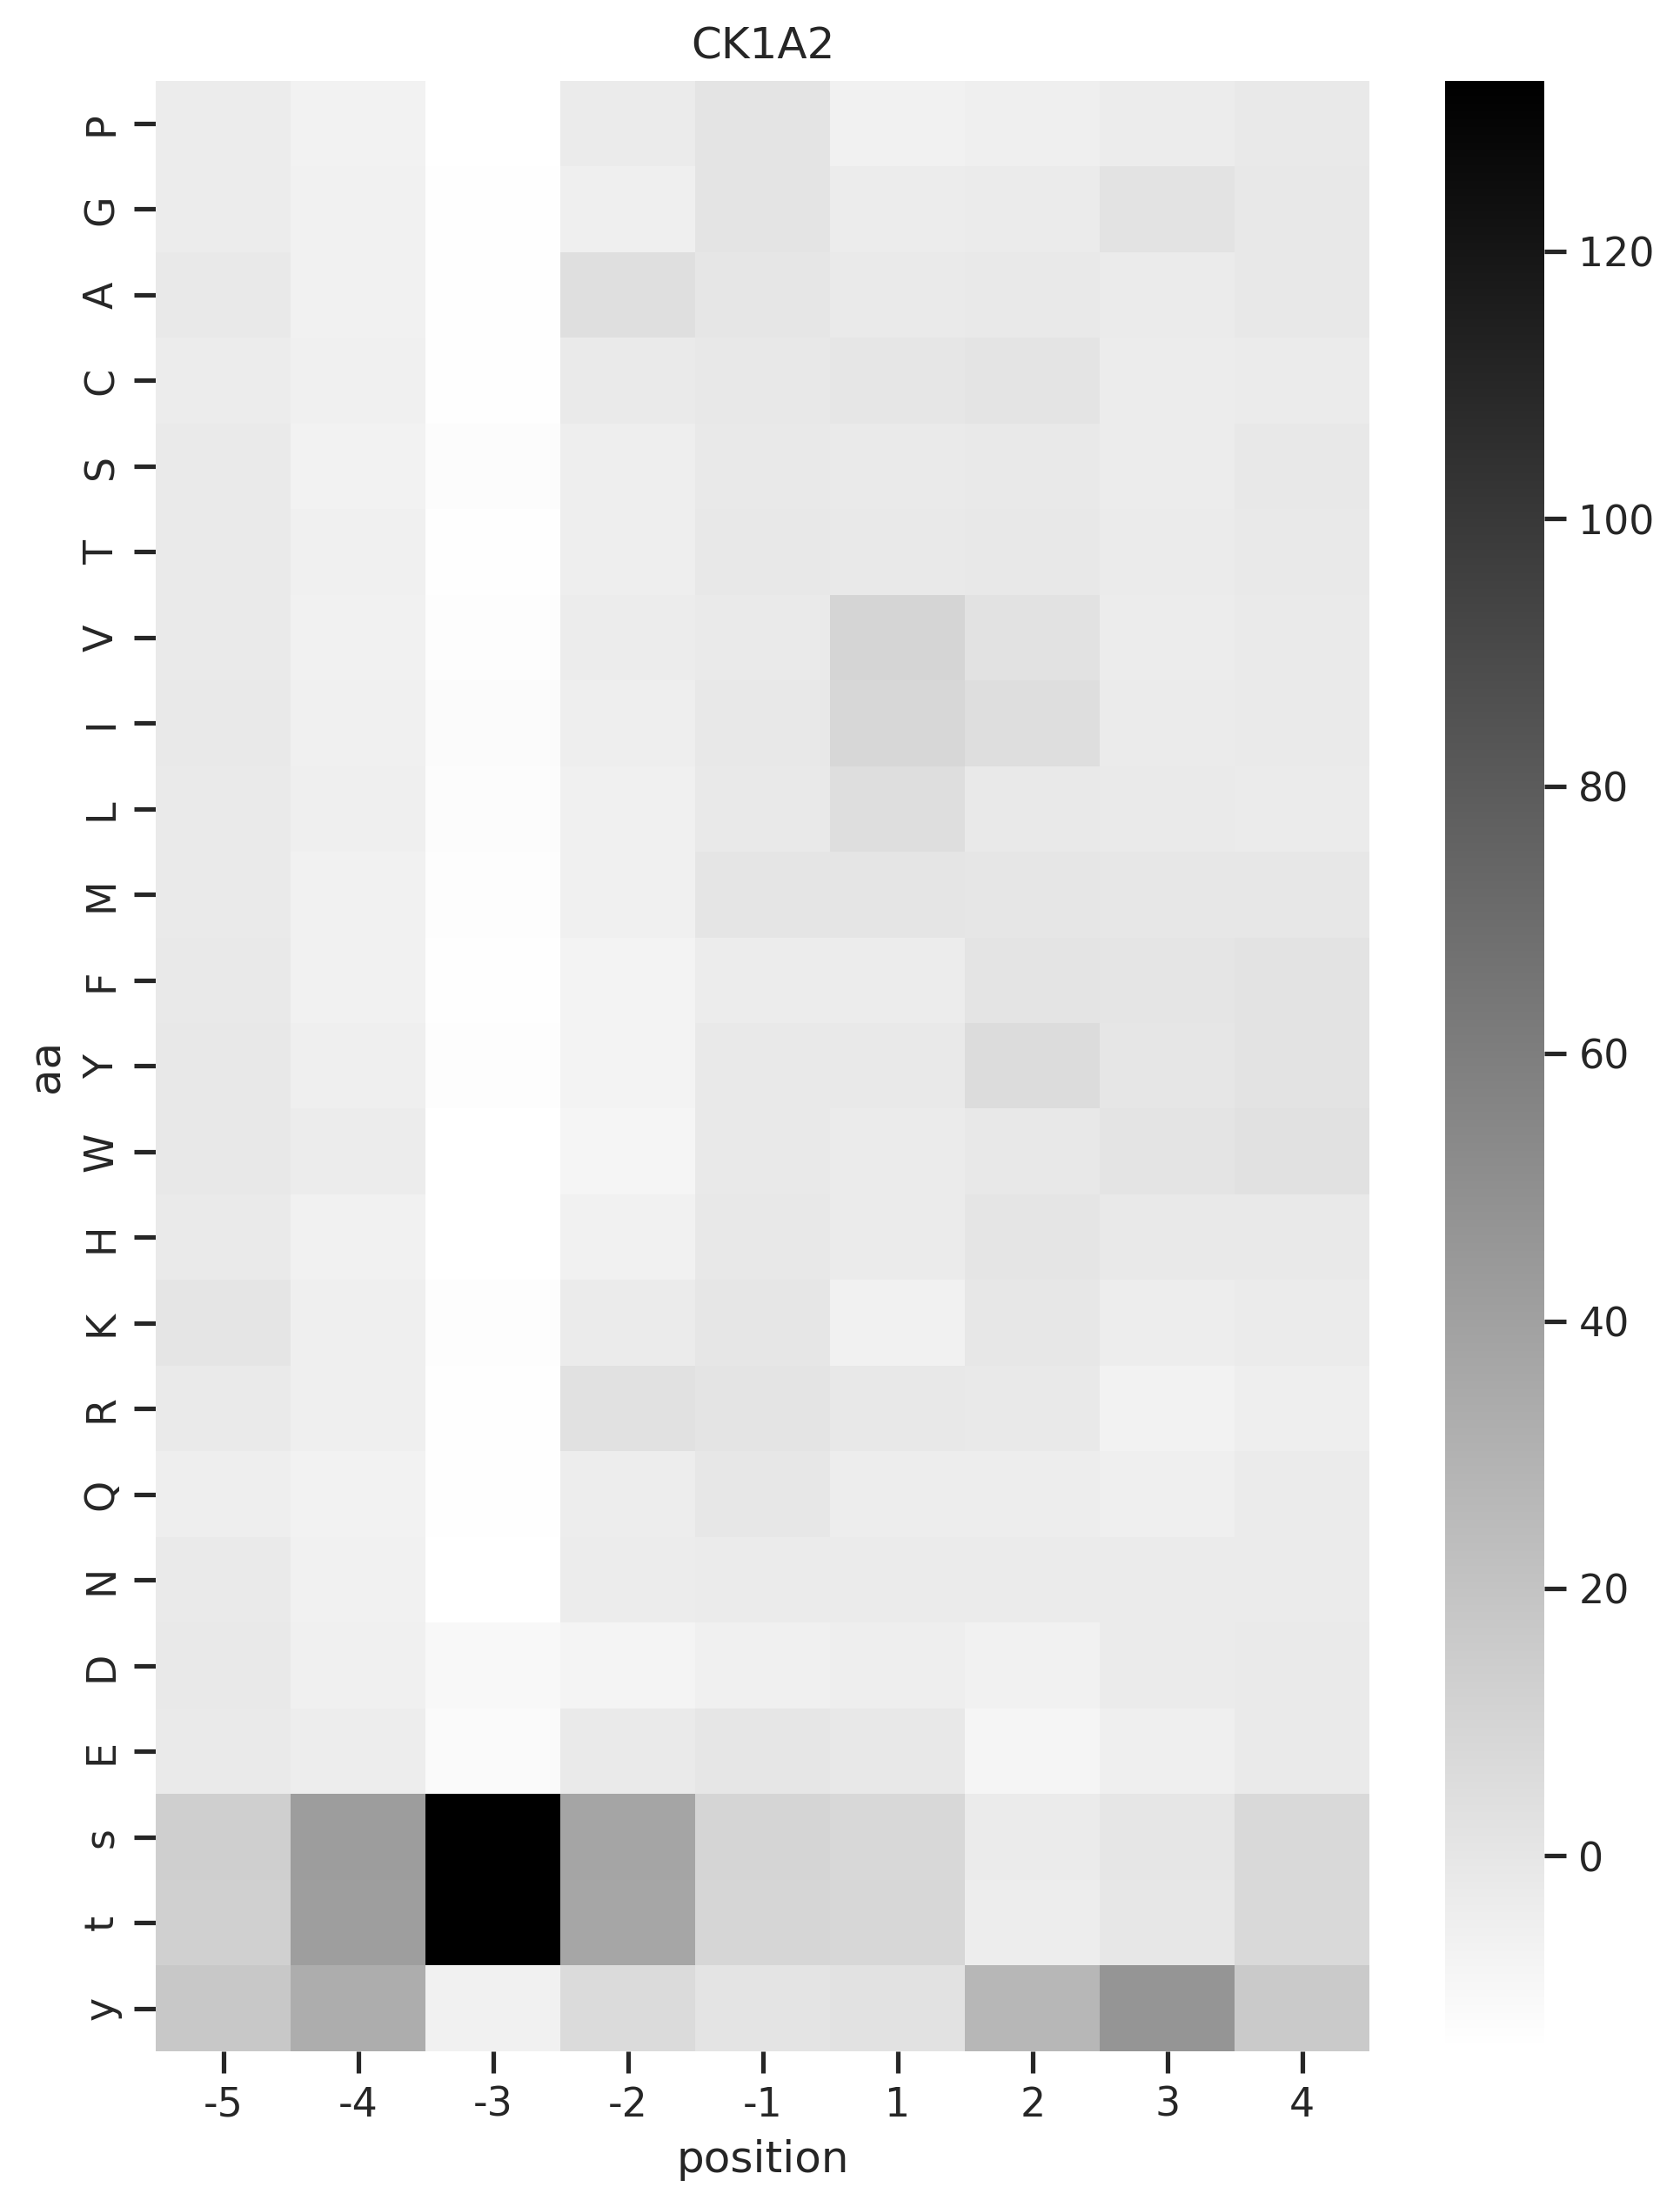

In [ ]:
get_heatmap(preds.iloc[:,:-3],'CK1A2')

## Post-process

In [ ]:
# remove kinase with duplicated name
preds= preds[~preds.index.duplicated()]

In [ ]:
preds_minmax = MinMaxScaler().fit_transform(preds.T).T

In [ ]:
data = []
for k in preds_minmax.index:
    w = get_one_kinase(preds_minmax,k,drop_s=False).T
    w = w/w.sum()
    w2 = w.unstack().reset_index(name=k)
    w2['substrate'] = w2.position.astype(str)+w2.aa
    w3 = w2.set_index('substrate')[k]
    data.append(w3)
    # break

In [ ]:
preds_final = pd.concat(data,axis=1).T

preds_final = preds_final[target_col]

In [ ]:
preds_final = preds_final[~preds_final.index.isin(t5.kinase)]

In [ ]:
preds_final.index

Index(['ADCK1', 'ADCK2', 'COQ8A', 'COQ8B', 'ADCK5', 'ACVRL1', 'ACVR1C',
       'ALPK3', 'ALPK2', 'ARAF', 'CASK', 'CDK20', 'CDKL2', 'CDKL3', 'CDKL4',
       'STK35', 'PDIK1L', 'DCLK3', 'DDR1', 'CDC42BPG', 'STK17B', 'ERBB2',
       'MAPK6', 'MAPK4', 'STK36', 'TNNI3K', 'AATK', 'LMTK2', 'LMTK3', 'LRRK1',
       'MAP3K13', 'MAP2K6', 'MAP3K4', 'MAST1', 'MAST2', 'MAST3', 'MAST4',
       'AMHR2', 'PKMYT1', 'NEK10', 'NRK', 'CDK15', 'PIK3R4', 'CDK11B', 'PSKH1',
       'RIOK1', 'RIOK2', 'RIOK3', 'RNASEL', 'ROR1', 'ROR2', 'SBK2', 'SBK3',
       'ANKK1', 'RSKR', 'SPEG', 'TESK2', 'TIE1', 'KALRN', 'TRIO', 'TSSK3',
       'TSSK4', 'WEE2', 'STK32A'],
      dtype='object')

In [ ]:
preds_final.to_parquet('raw/predicted.parquet')

## Select kinase families with high oof Pearson scores

In [ ]:
family_score = pd.read_csv('raw/oof_corr_family.csv').rename(columns={'kinase':'family_count','Pearson':'Pearson_family'})
subfamily_score = pd.read_csv('raw/oof_corr_subfamily.csv').rename(columns={'kinase':'subfamily_count','Pearson':'Pearson_subfamily'})

In [ ]:
preds_info = pd.DataFrame(preds_final.index,columns=['kinase']).merge(df,'left')

In [ ]:
preds_info

kinase ID_coral uniprot ID_HGNC     group family subfamily_coral  \
0    ADCK1    ADCK1  Q86TW2   ADCK1  Atypical   ABC1          ABC1-B   
1    ADCK2    ADCK2  Q7Z695   ADCK2  Atypical   ABC1          ABC1-C   
2    COQ8A    ADCK3  Q8NI60   COQ8A  Atypical   ABC1          ABC1-A   
3    COQ8B    ADCK4  Q96D53   COQ8B  Atypical   ABC1          ABC1-A   
4    ADCK5    ADCK5  Q3MIX3   ADCK5  Atypical   ABC1          ABC1-D   
..     ...      ...     ...     ...       ...    ...             ...   
59    TRIO     Trio  O75962    TRIO      CAMK   Trio            None   
60   TSSK3    TSSK3  Q96PN8   TSSK3      CAMK   TSSK            None   
61   TSSK4    TSSK4  Q6SA08   TSSK4      CAMK   TSSK            None   
62    WEE2    Wee1B  P0C1S8    WEE2     Other    WEE            None   
63  STK32A    YANK1  Q8WU08  STK32A       AGC   YANK            None   

   subfamily  in_ST_paper  in_Tyr_paper  in_cddm pseudo pspa_category_small  \
0     ABC1-B            0             0        0      0                None   
1     ABC1-C            0             0        0      0                None   
2     ABC1-A            0             0        0      0                None   
3     ABC1-A            0             0        0      0                None   
4     ABC1-D            0             0        0      0                None   
..       ...          ...           ...      ...    ...                 ...   
59      Trio            0             0        0      0                None   
60      TSSK            0             0        0      0                None   
61      TSSK            0             0        0      0                None   
62       WEE            0             0        0      0                None   
63      YANK            0             0        0      0                None   

   pspa_category_big  cddm_big  cddm_small  length  \
0               None       NaN         NaN     530   
1               None       NaN         NaN     626   
2               None       NaN         NaN     647   
3               None       NaN         NaN     544   
4               None       NaN         NaN     580   
..               ...       ...         ...     ...   
59              None       NaN         NaN    3097   
60              None       NaN         NaN     268   
61              None       NaN         NaN     328   
62              None       NaN         NaN     567   
63              None       NaN         NaN     396   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     human_uniprot_sequence  \
0                                                                        MARKALKLASWTSMALAASGIYFYSNKYLDPNDFGAVRVGRAVATTAVISYDYLTSLKSVPYGSEEYLQLRSKSWPVFLQVHLRSARRLCELCCANRGTFIKVGQHLGALDYLLPEEYTSTLKVLHSQAPQSSMQEIRQVIREDLGKEIHDLFQSFDDTPLGTASLAQVHKAVLHDGRTVAVKVQHPKVRAQSSKDILLMEVLVLAVKQLFPEFEFMWLVDEAKKNLPLELDFLNEGRNAEKVSQMLRHFDFLKVPRIHWDLSTERVLLMEFVDGGQVNDRDYMERNKIDVNEISRHLGKMYSEMIFVNGFVHCDPHPGNVLVRKHPGTGKAEIVLLDHGLYQMLTEEFRLNYCHLWQSLIWTDMKRVKEYSQRLGAGDLYPLFACMLTARSWDSVNRGISQAPVTATEDLEIRNNAANYLPQISHLLNHVPRQMLLILKTNDLLRGIEAALGTRASASSFLNMSRCCIRALAEHKKKNTCSFFRRTQISFSEAFNLWQINLHELILRVKGLKLADRVLALICWLFPAPL   
1   MVAPWRVSVRVCLSHLRCFELRQGLSLLRPSECPRDARLCWLLLGTLPKVVSLCGDVGEGAPDVLSRRRVRCSGAAGAGPAESLPRAGPLGGVFLHLRLWLRAGALLVKFFPLLLLYPLTYLAPSVSTLWLHLLLKATETSGPTYIKLGQWASTRRDLFSEAFCAQFSKLHVRVTPHPWTHTERFLRQAFGDDWGSILSFENREPVGSGCVAQVYKAYANTAFLETDSVQRLGRASCLPPFSHTGAVGGLRELFGYLGNGRKPPENLADQSFLERLLLPKADLVGSNAGVSRAQVPGHQPEATNLISVAVKVLHPGLLAQVHM

In [ ]:
preds_info = preds_info.merge(family_score,'left')
preds_info = preds_info.merge(subfamily_score,'left')

In [ ]:
preds_info = preds_info[['kinase','ID_coral','uniprot','ID_HGNC',
                         'group','family','subfamily',
                         'Pearson_family','family_count',
                         'Pearson_subfamily','subfamily_count'
                        ]]

In [ ]:
preds_info.sort_values('Pearson_family',ascending=False)

kinase ID_coral uniprot   ID_HGNC group family subfamily  \
57      TIE1     TIE1  P35590      TIE1    TK    Tie       Tie   
19  CDC42BPG    DMPK2  Q6DT37  CDC42BPG   AGC   DMPK       GEK   
21     ERBB2    ErbB2  P04626     ERBB2    TK   EGFR      EGFR   
11     CDK20     CCRK  Q8IZL9     CDK20  CMGC    CDK       CDK   
43    CDK11B  PITSLRE  P21127    CDK11B  CMGC    CDK     CDK11   
..       ...      ...     ...       ...   ...    ...       ...   
50      ROR2     ROR2  Q01974      ROR2    TK    Ror       Ror   
54      RSKR   SgK494  Q96LW2      RSKR   AGC   RSKR      RSKR   
55      SPEG     SPEG  Q15772      SPEG  CAMK   Trio      Trio   
58     KALRN     Trad  O60229     KALRN  CAMK   Trio      Trio   
59      TRIO     Trio  O75962      TRIO  CAMK   Trio      Trio   

    Pearson_family  family_count  Pearson_subfamily  subfamily_count  
57        0.965166           1.0           0.965166              1.0  
19        0.954669           6.0           0.954669              6.0  
21        0.950484           2.0           0.950484              2.0  
11        0.923265          17.0           0.923265             17.0  
43        0.923265          17.0           0.923265             17.0  
..             ...           ...                ...              ...  
50             NaN           NaN                NaN              NaN  
54             NaN           NaN                NaN              NaN  
55             NaN           NaN                NaN              NaN  
58             NaN           NaN                NaN              NaN  
59             NaN           NaN                NaN              NaN  

[64 rows x 11 columns]

In [ ]:
selected = preds_info[preds_info['Pearson_family']>0.6]\
.sort_values('Pearson_family',ascending=False)\
.query('group!="TK"')

In [ ]:
# Remove MAP2K families, as it is potentially contaminated with MAPK families
selected = selected[~selected.kinase.str.startswith('MAP2')]

In [ ]:
len(selected)

25

## Visualize predicted PSSMs

DMPK:0.9546690741027648


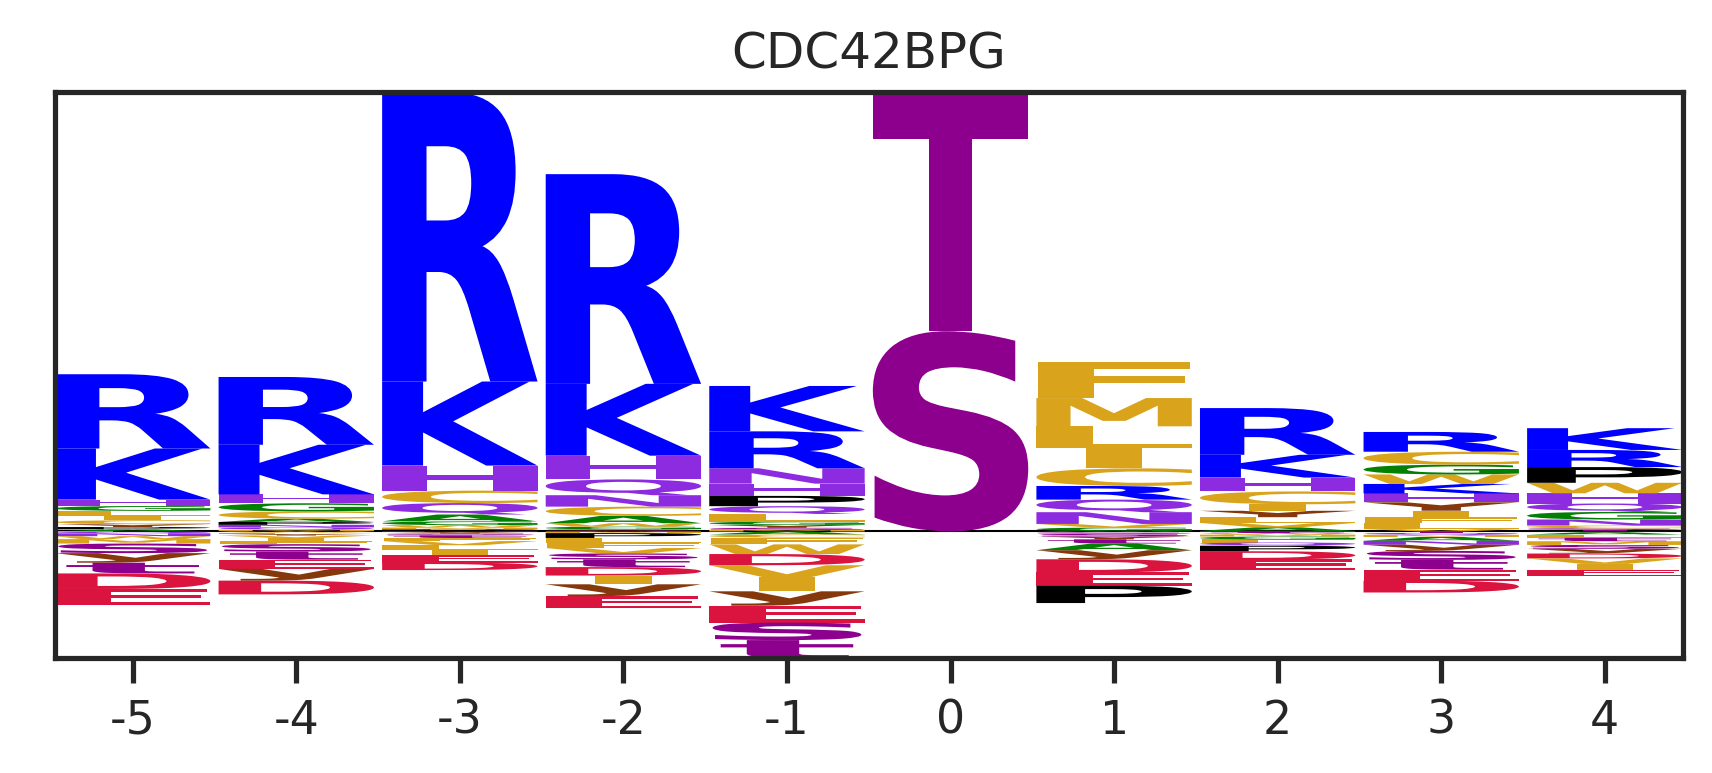

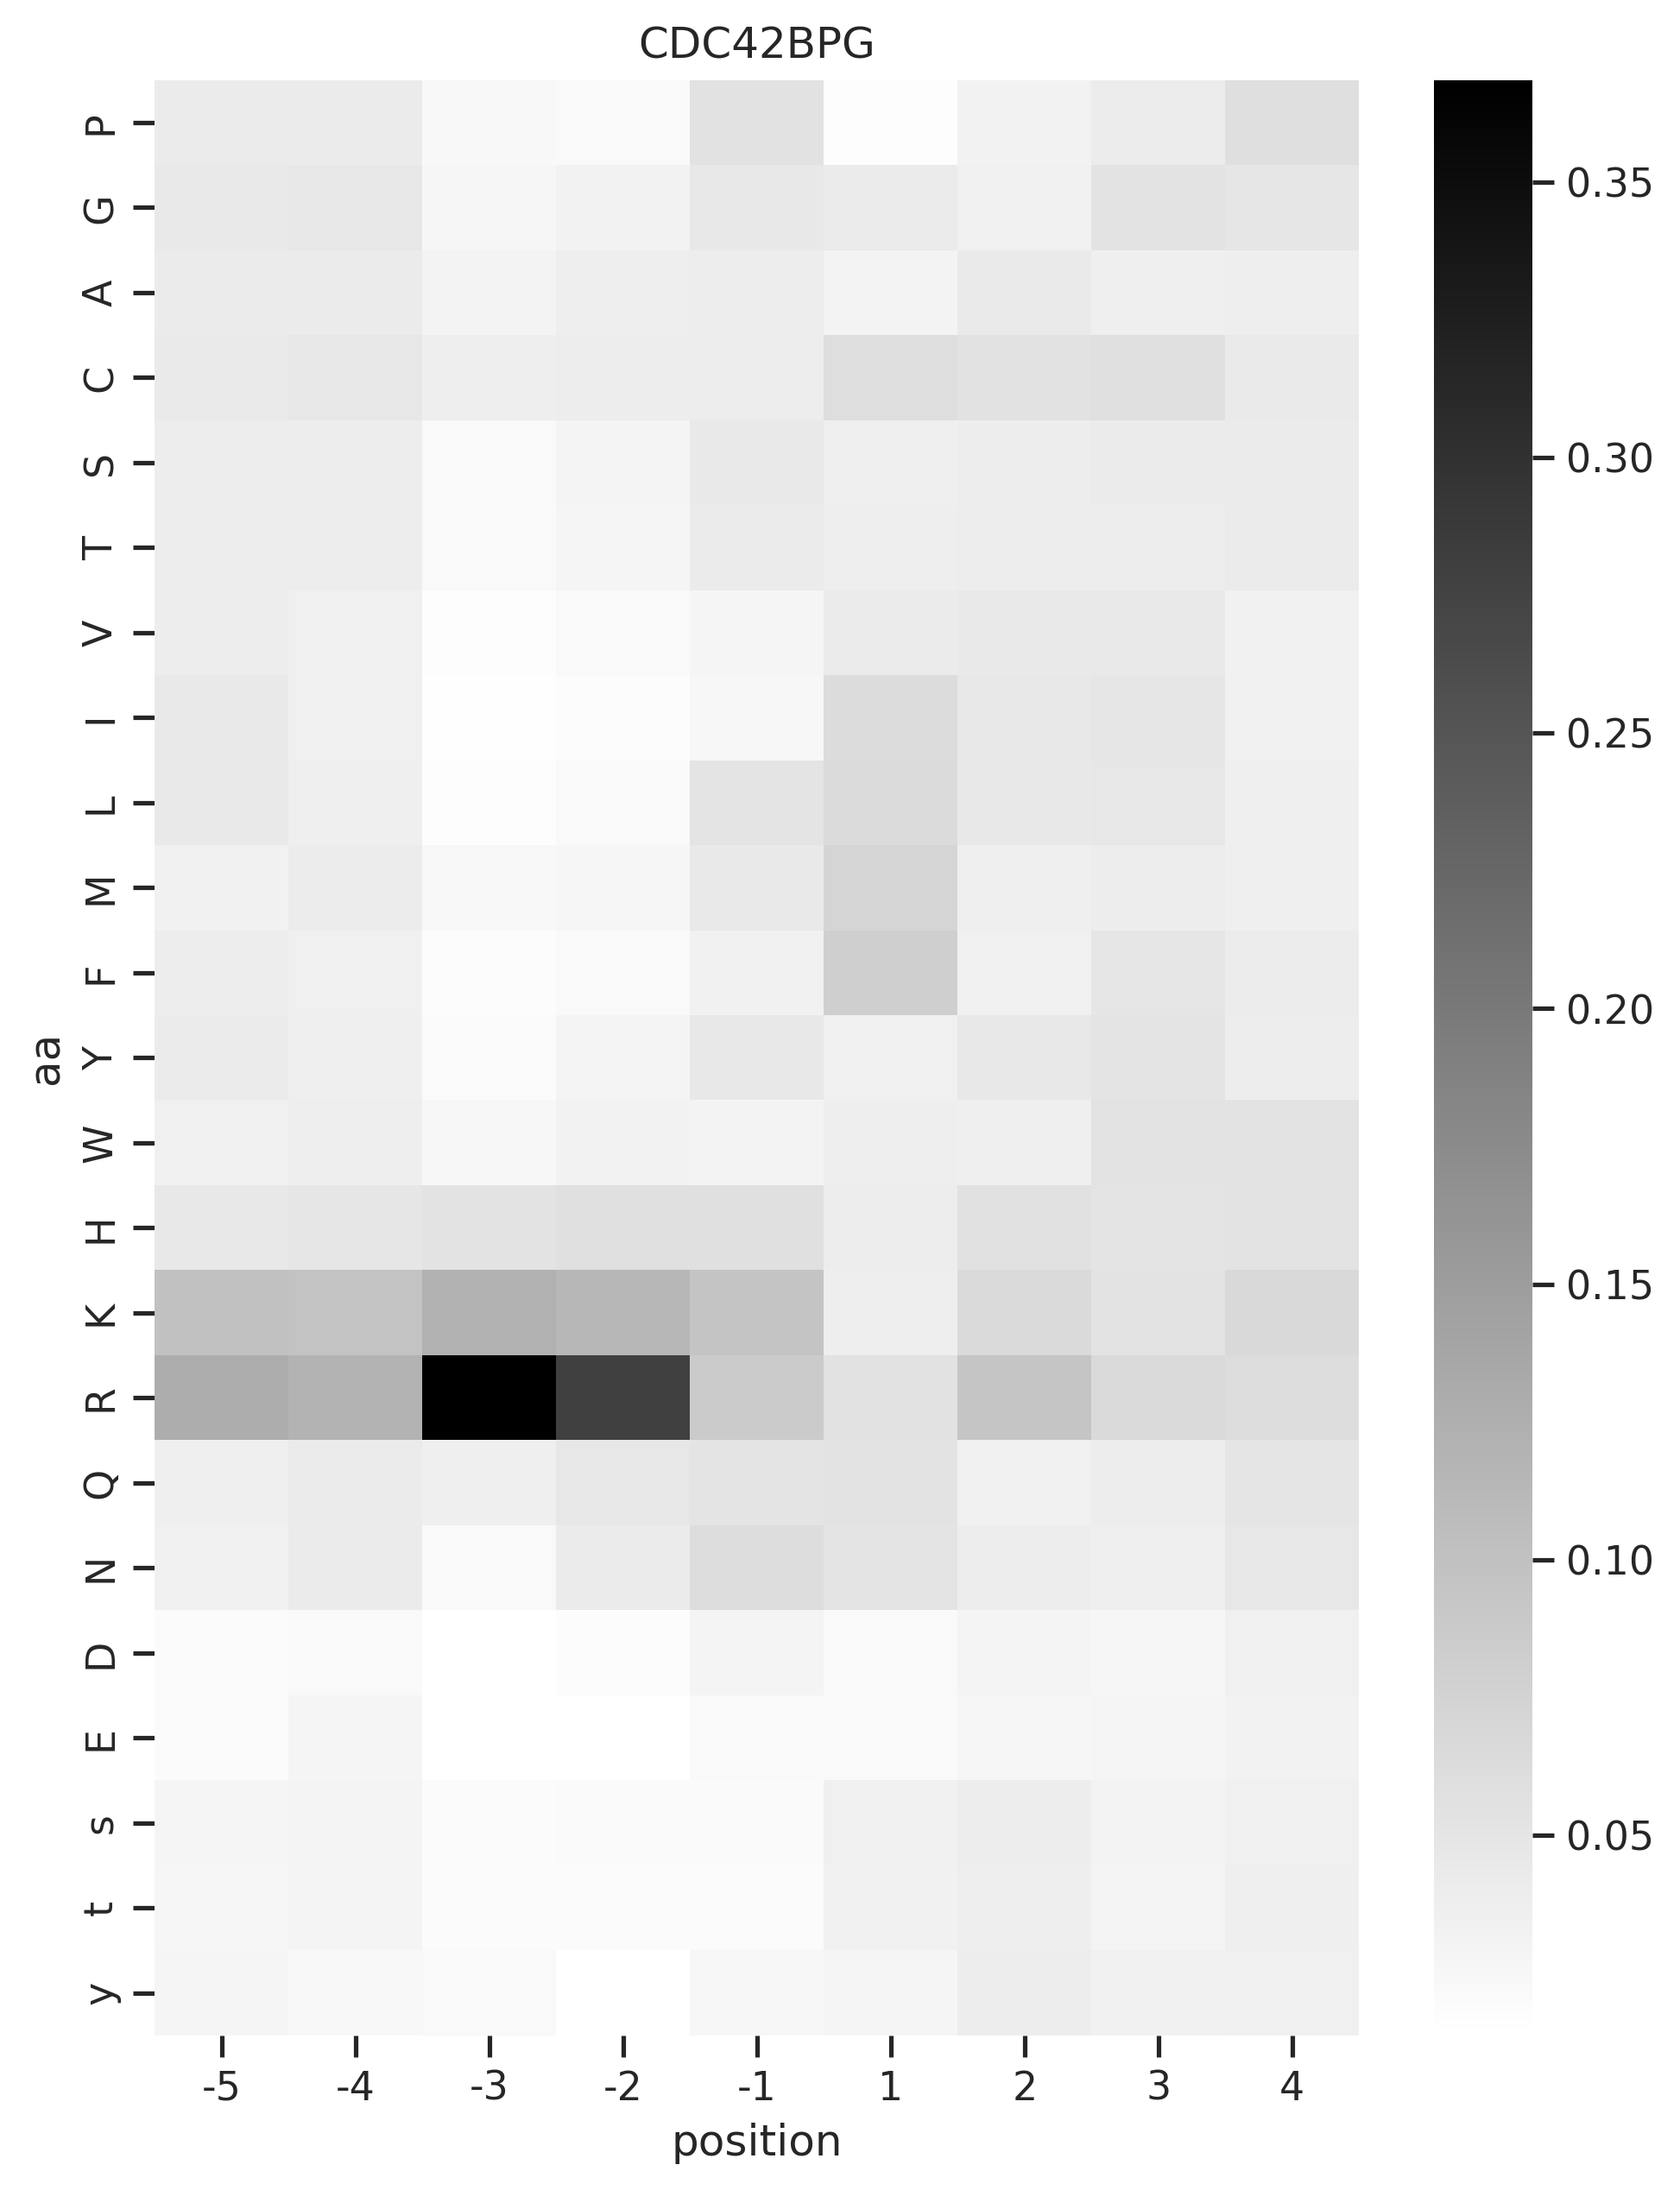

CDK:0.9232645242649458


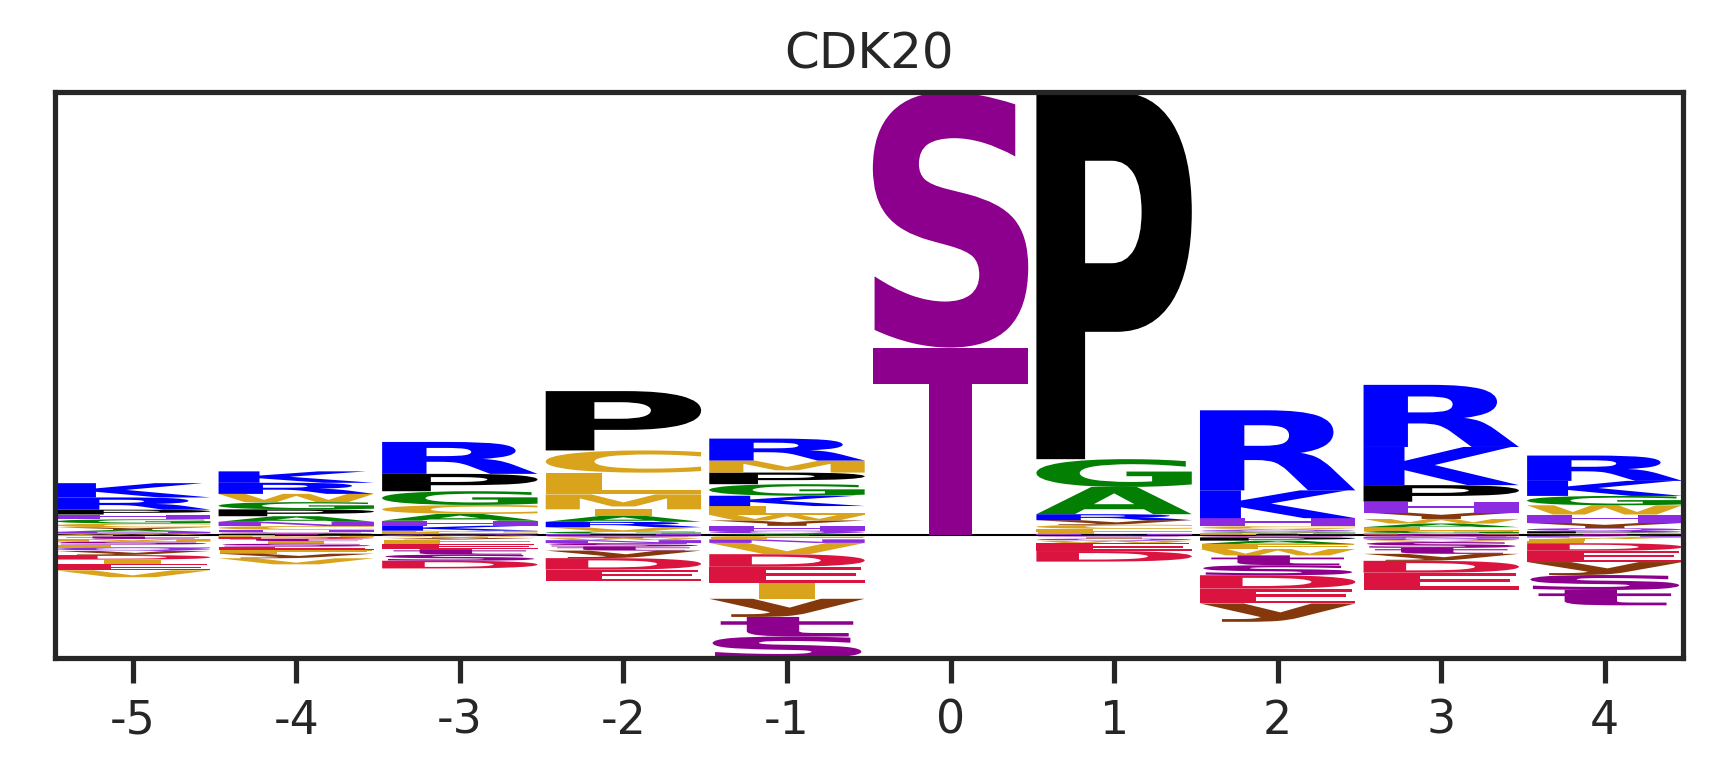

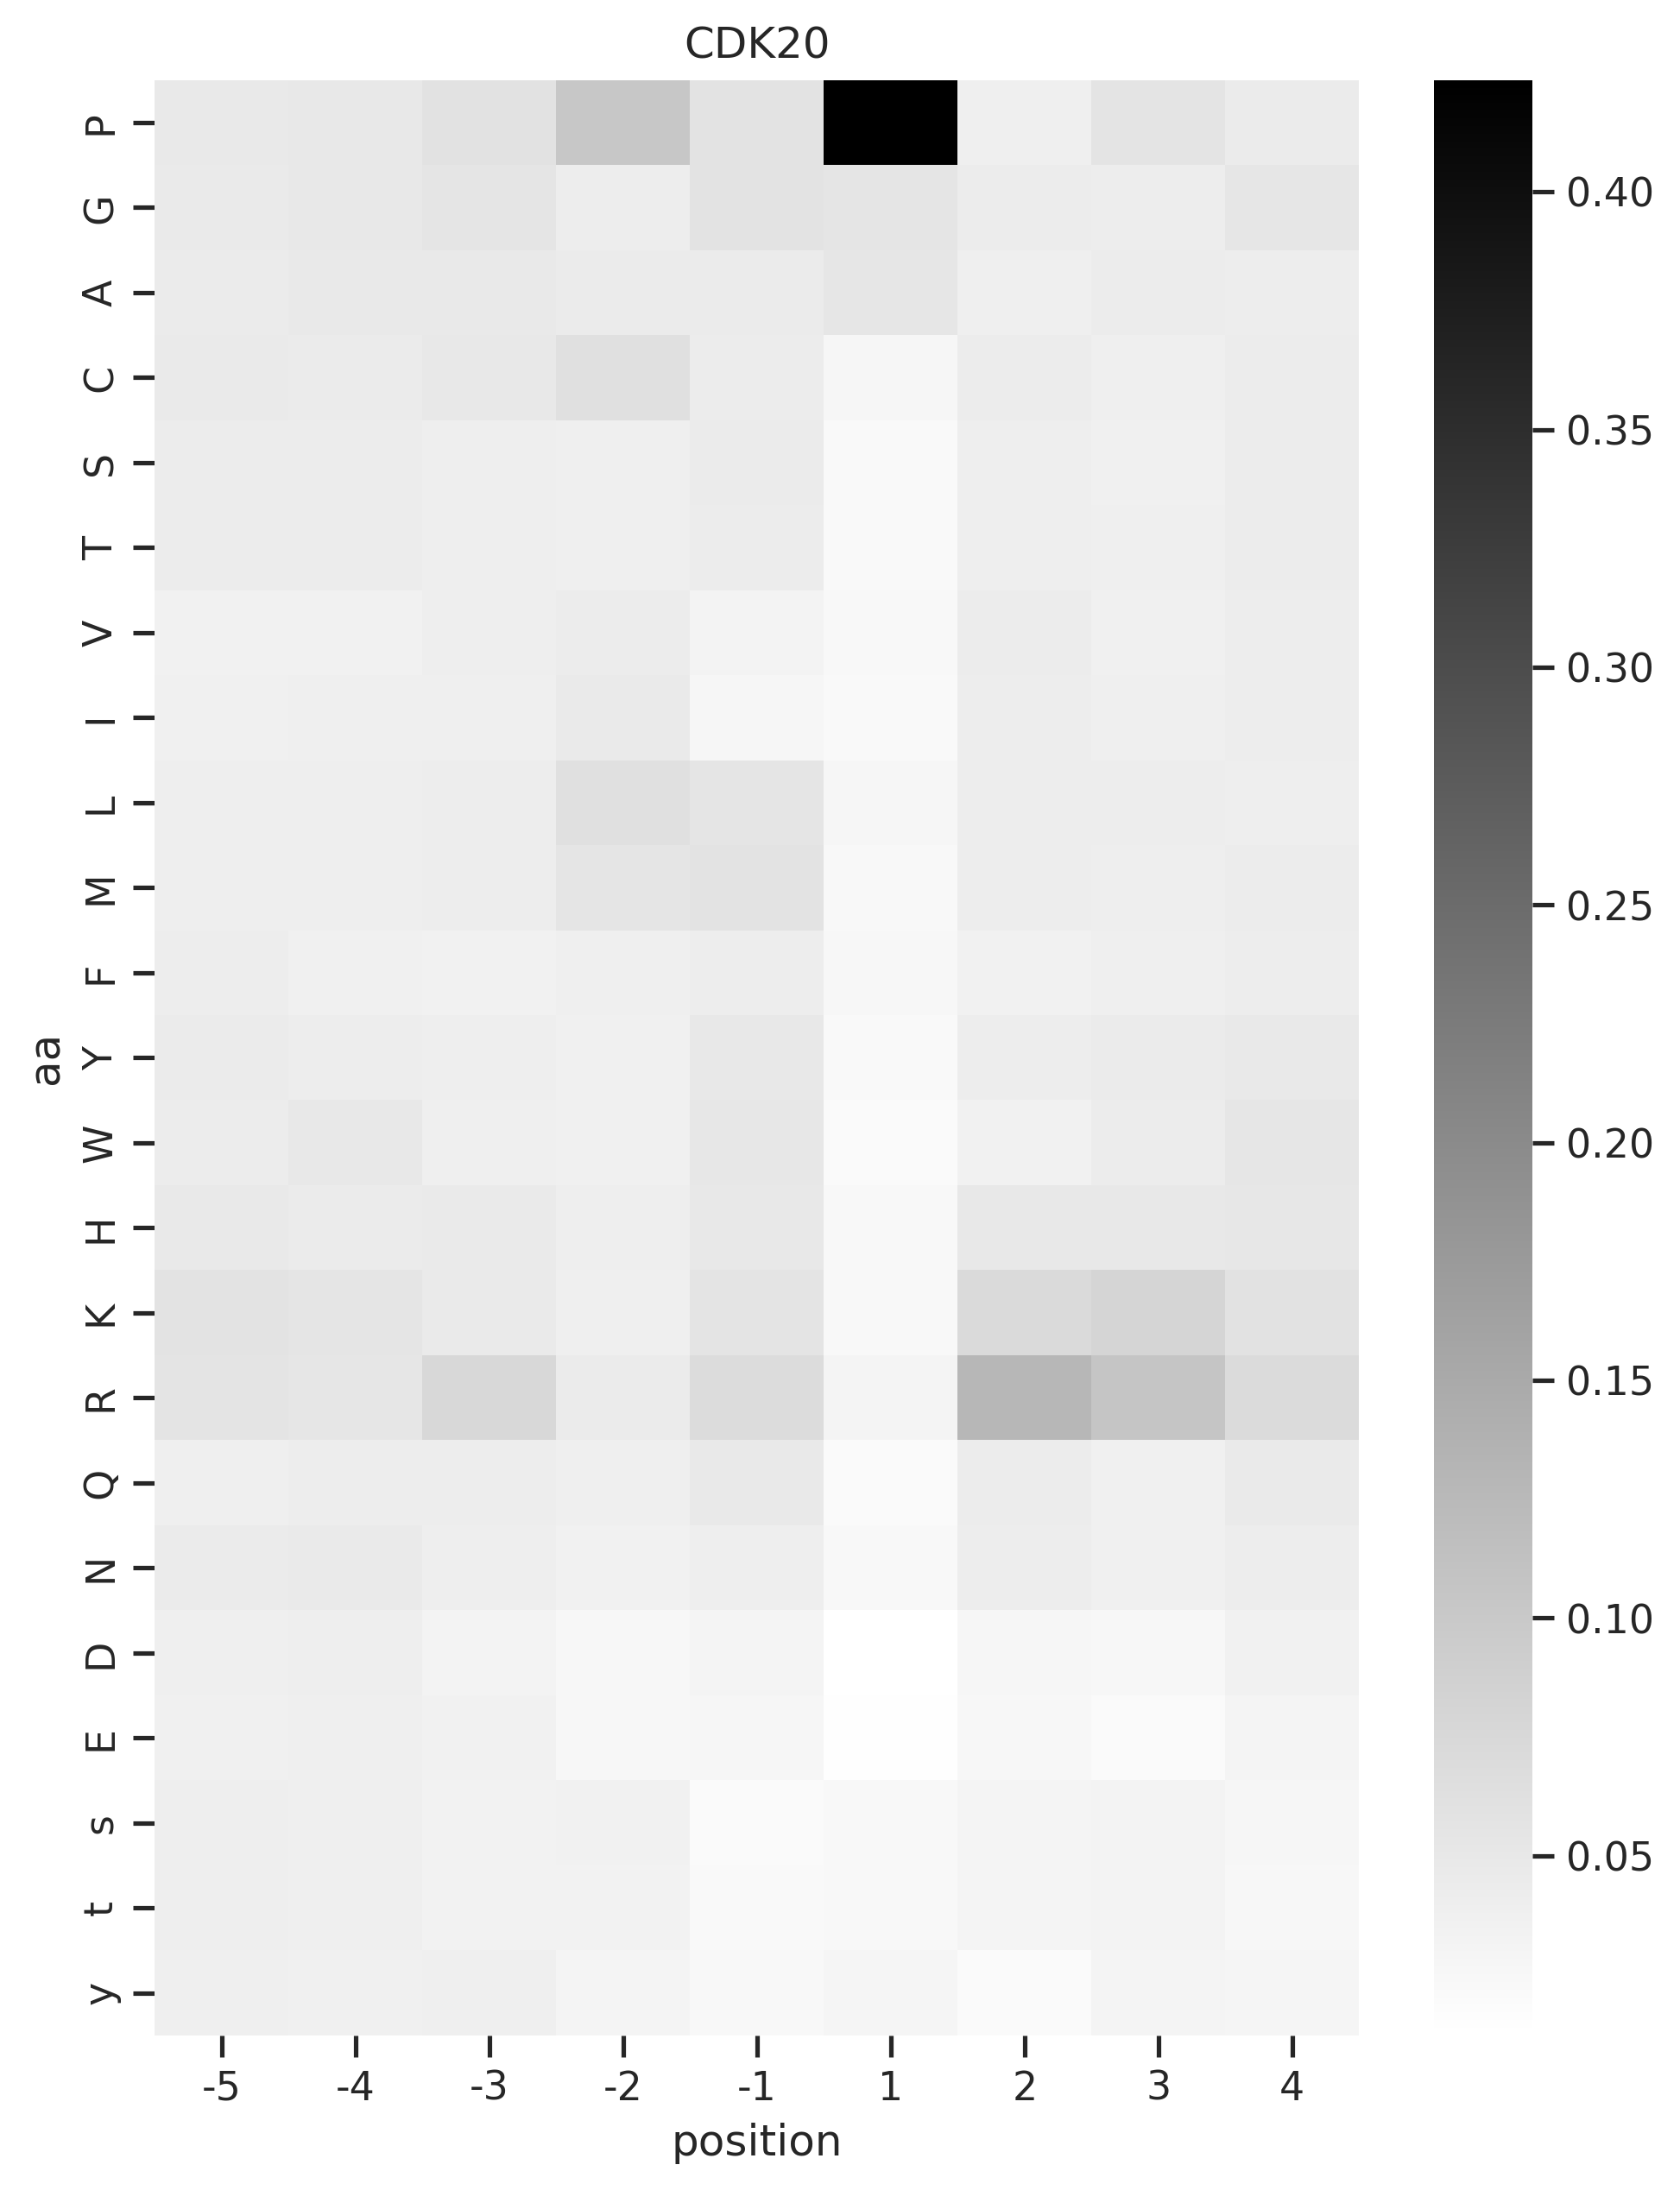

CDK:0.9232645242649458


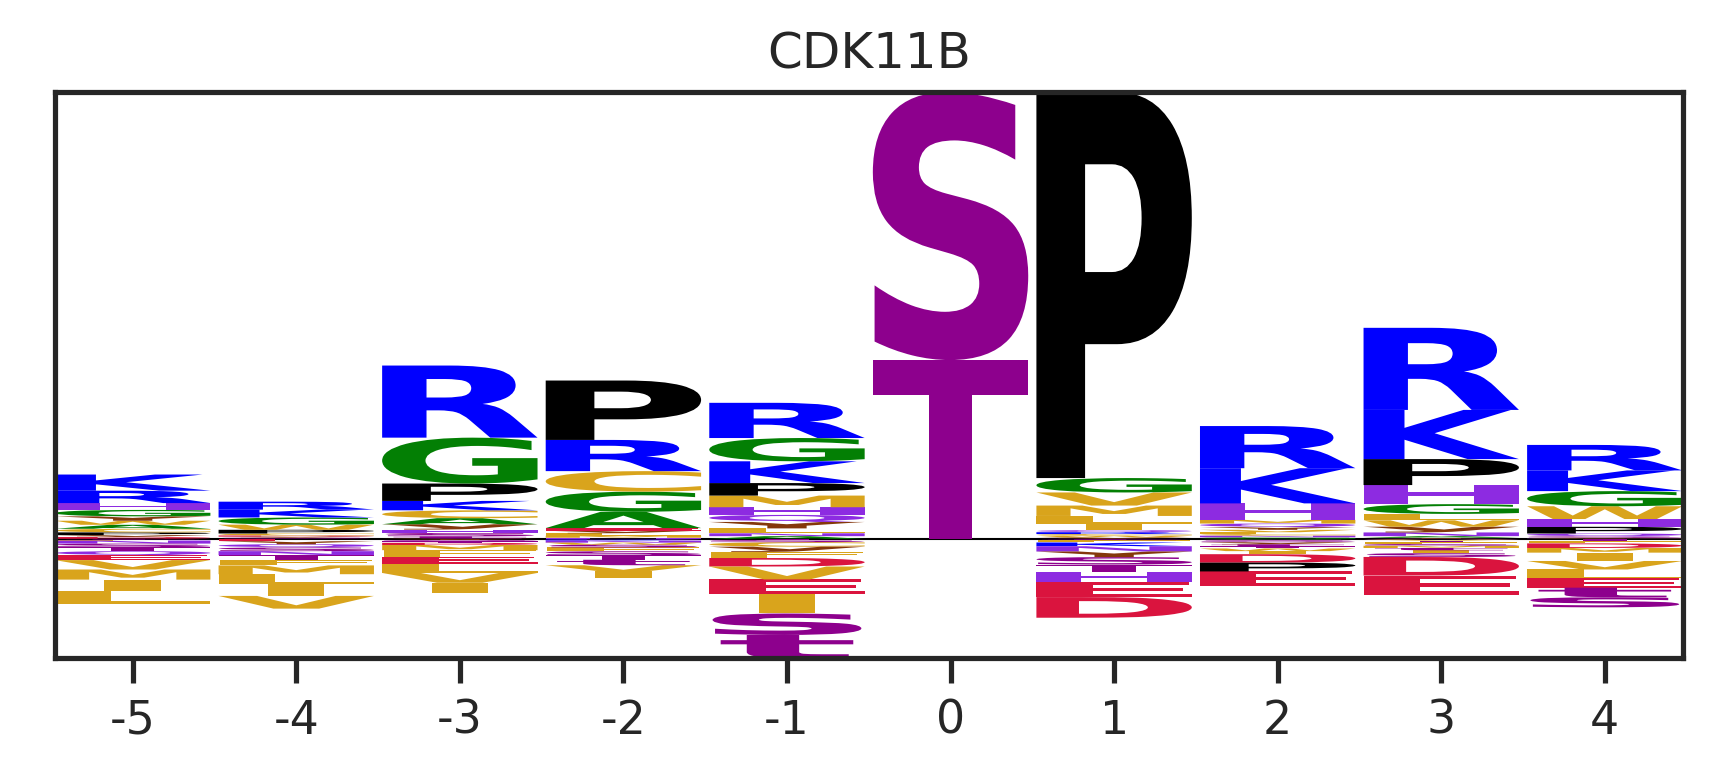

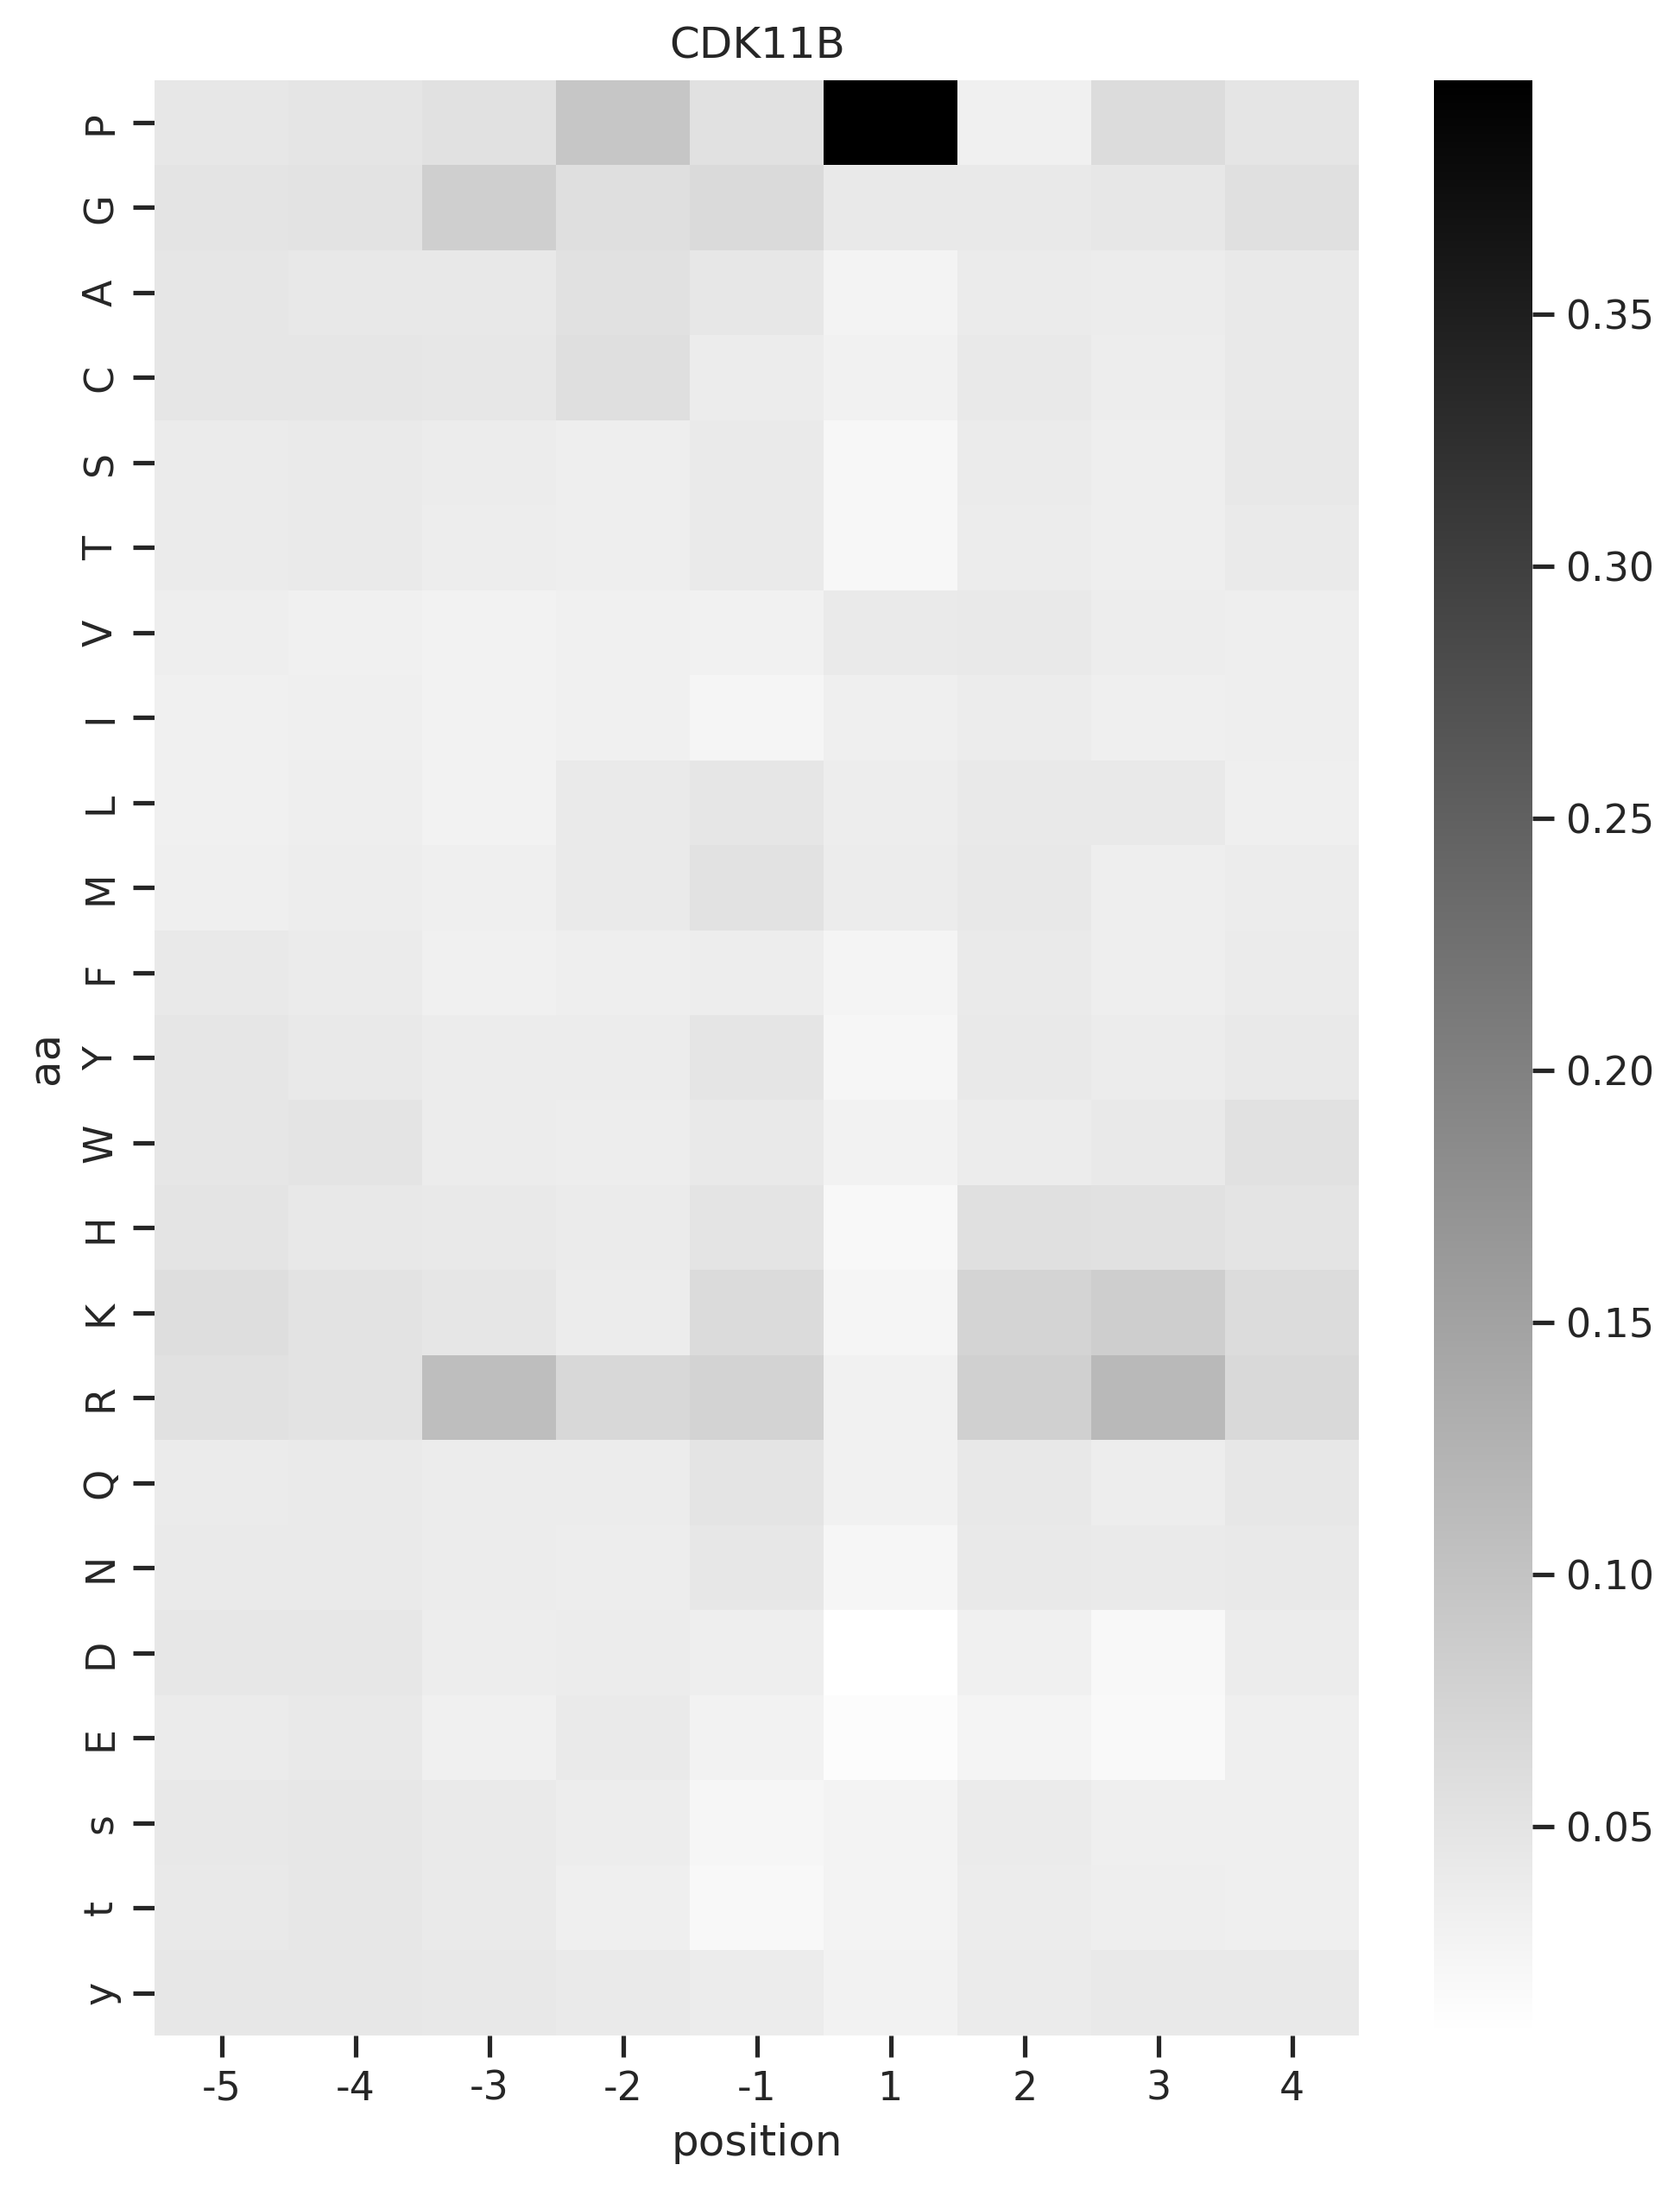

CDK:0.9232645242649458


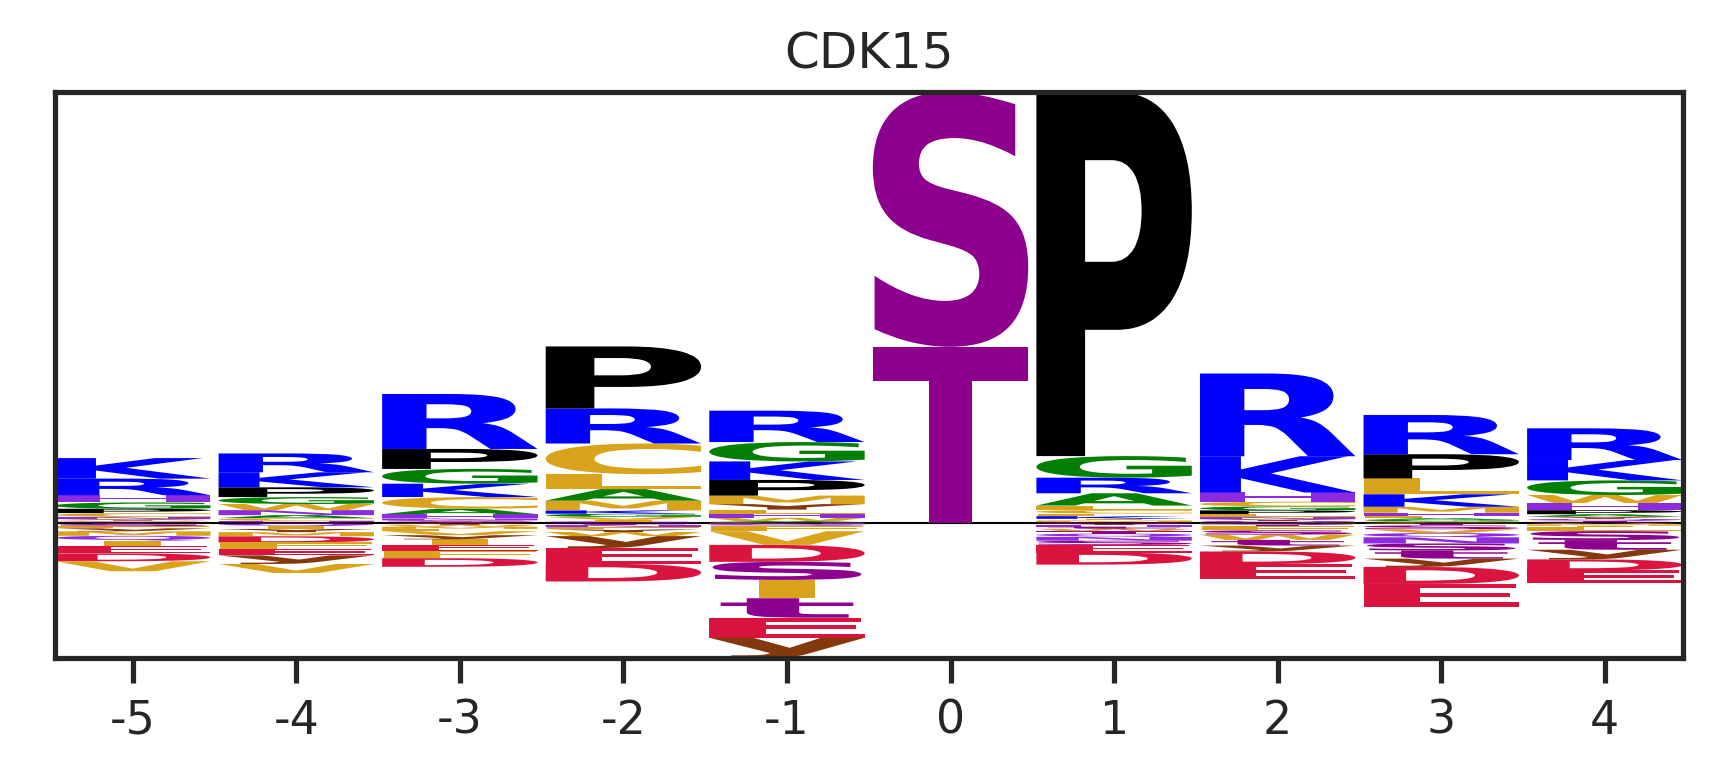

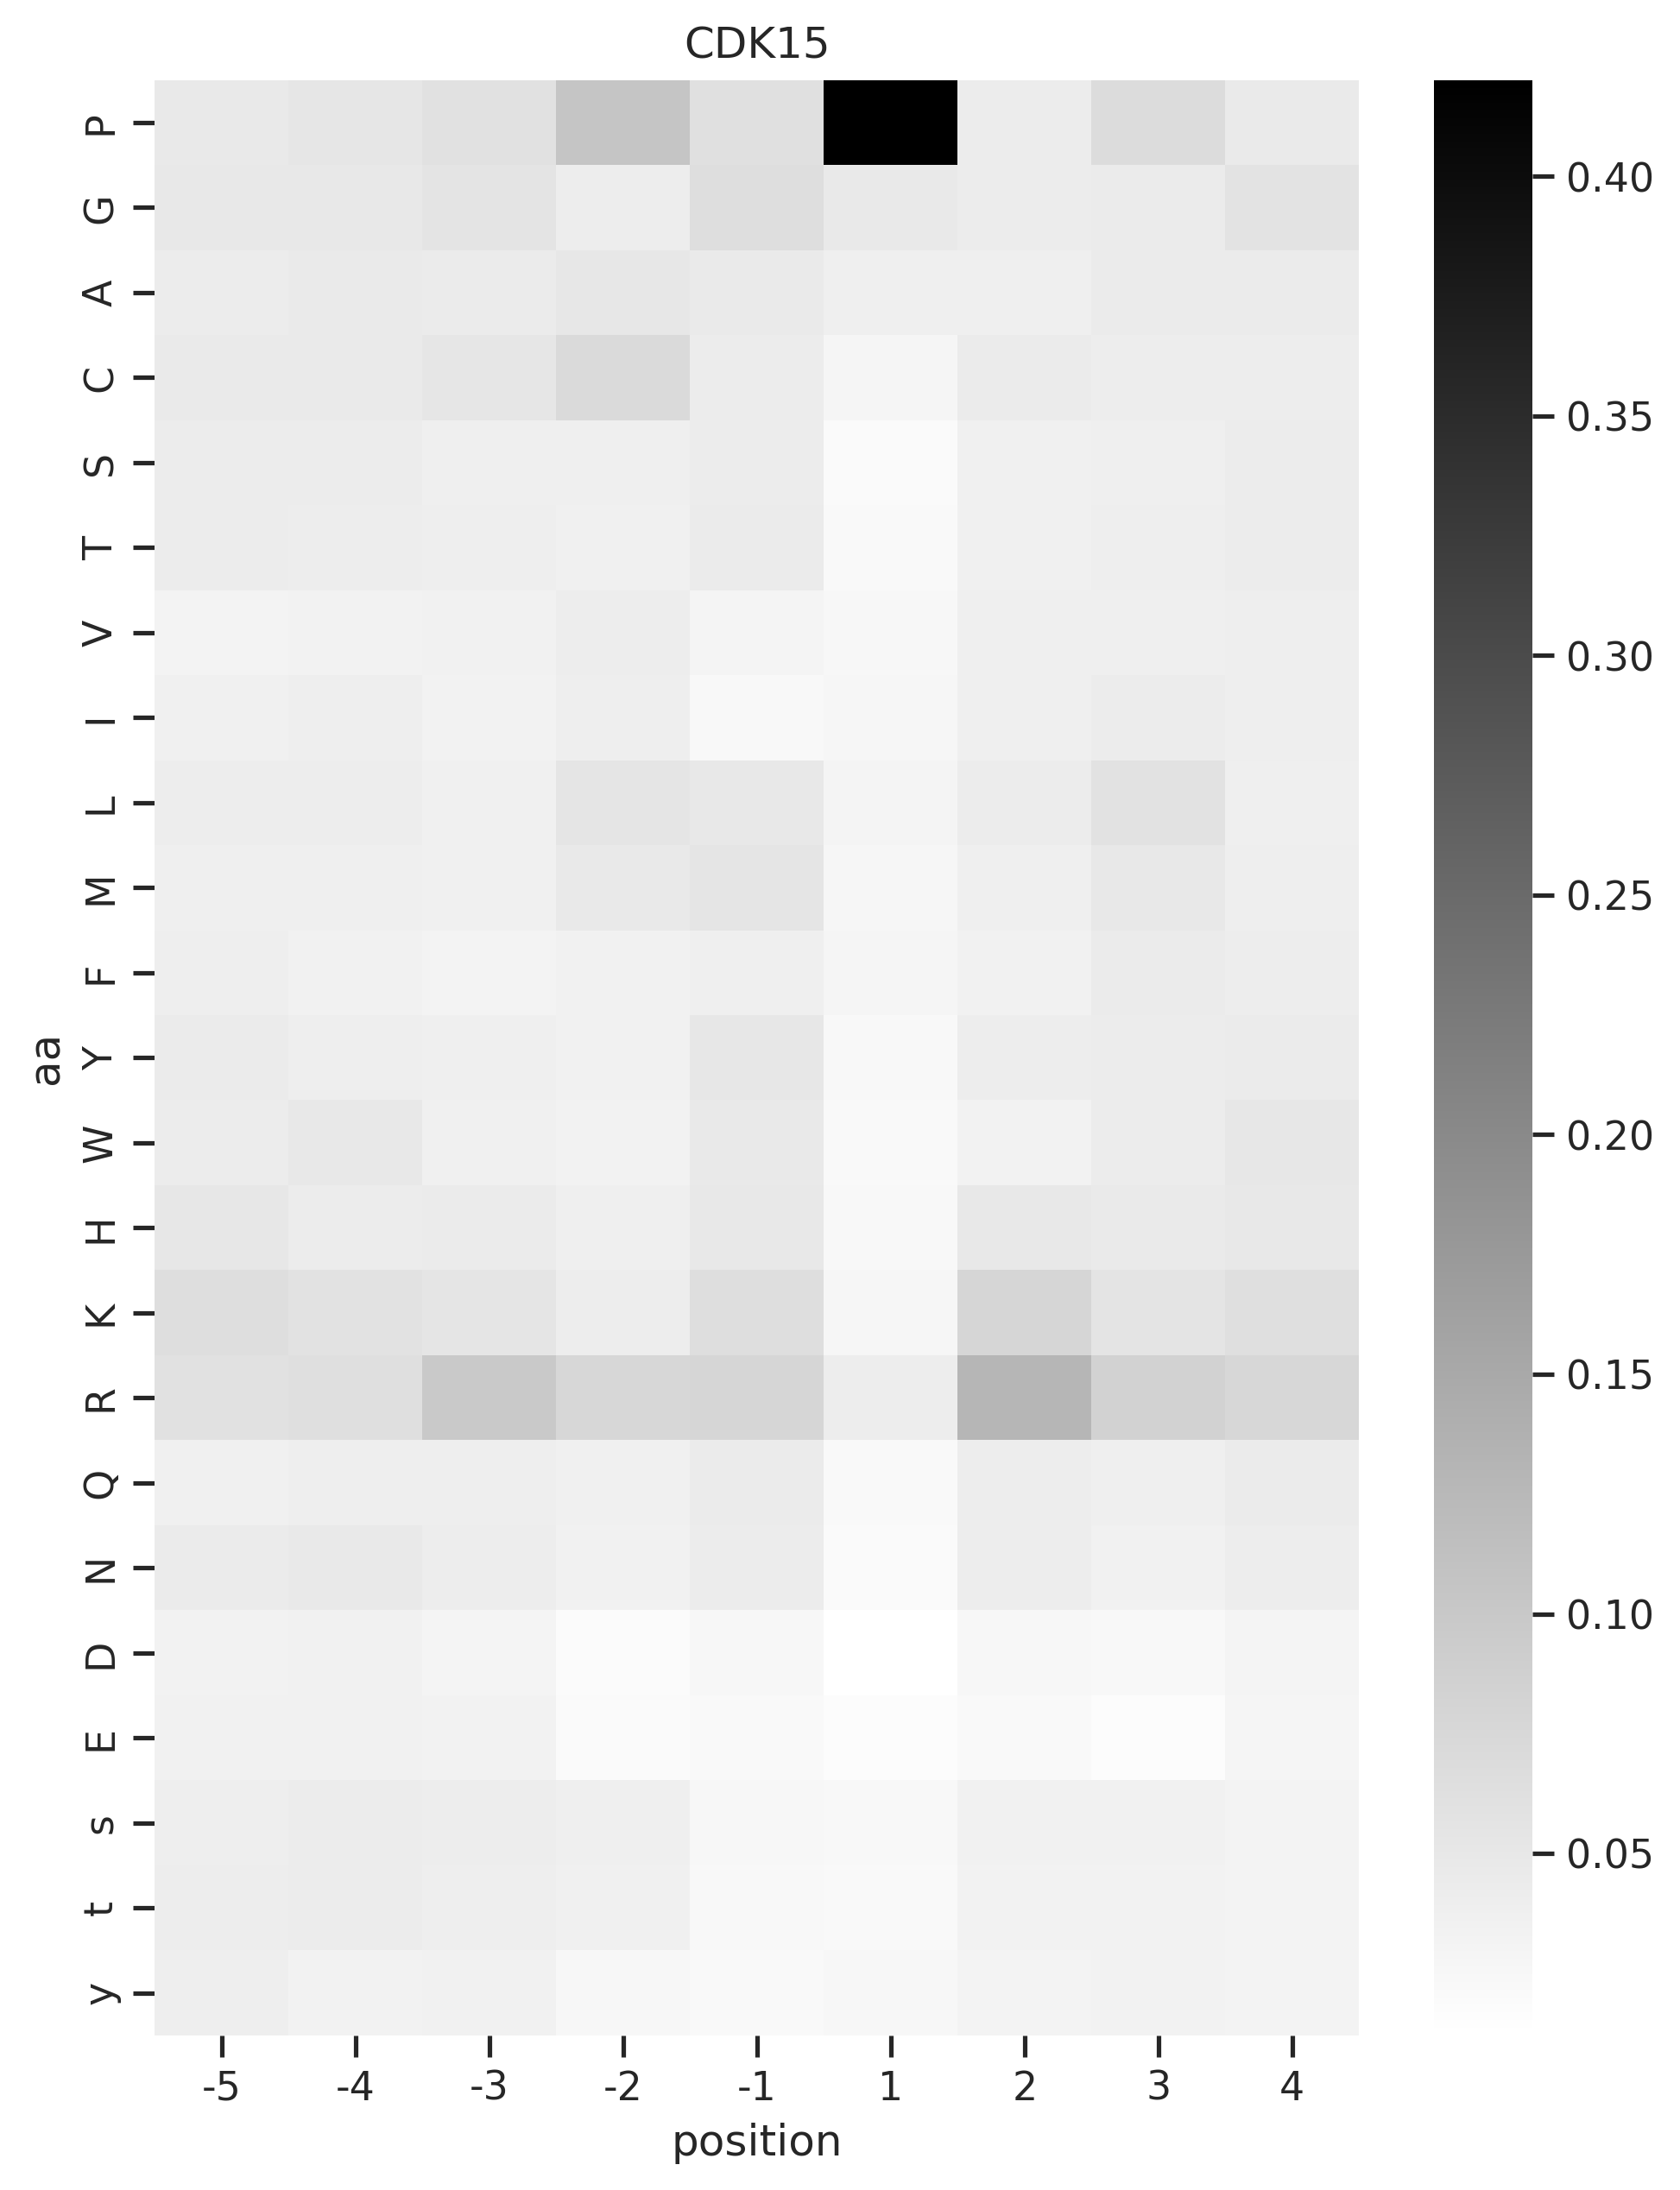

DCAMKL:0.9019845007257056


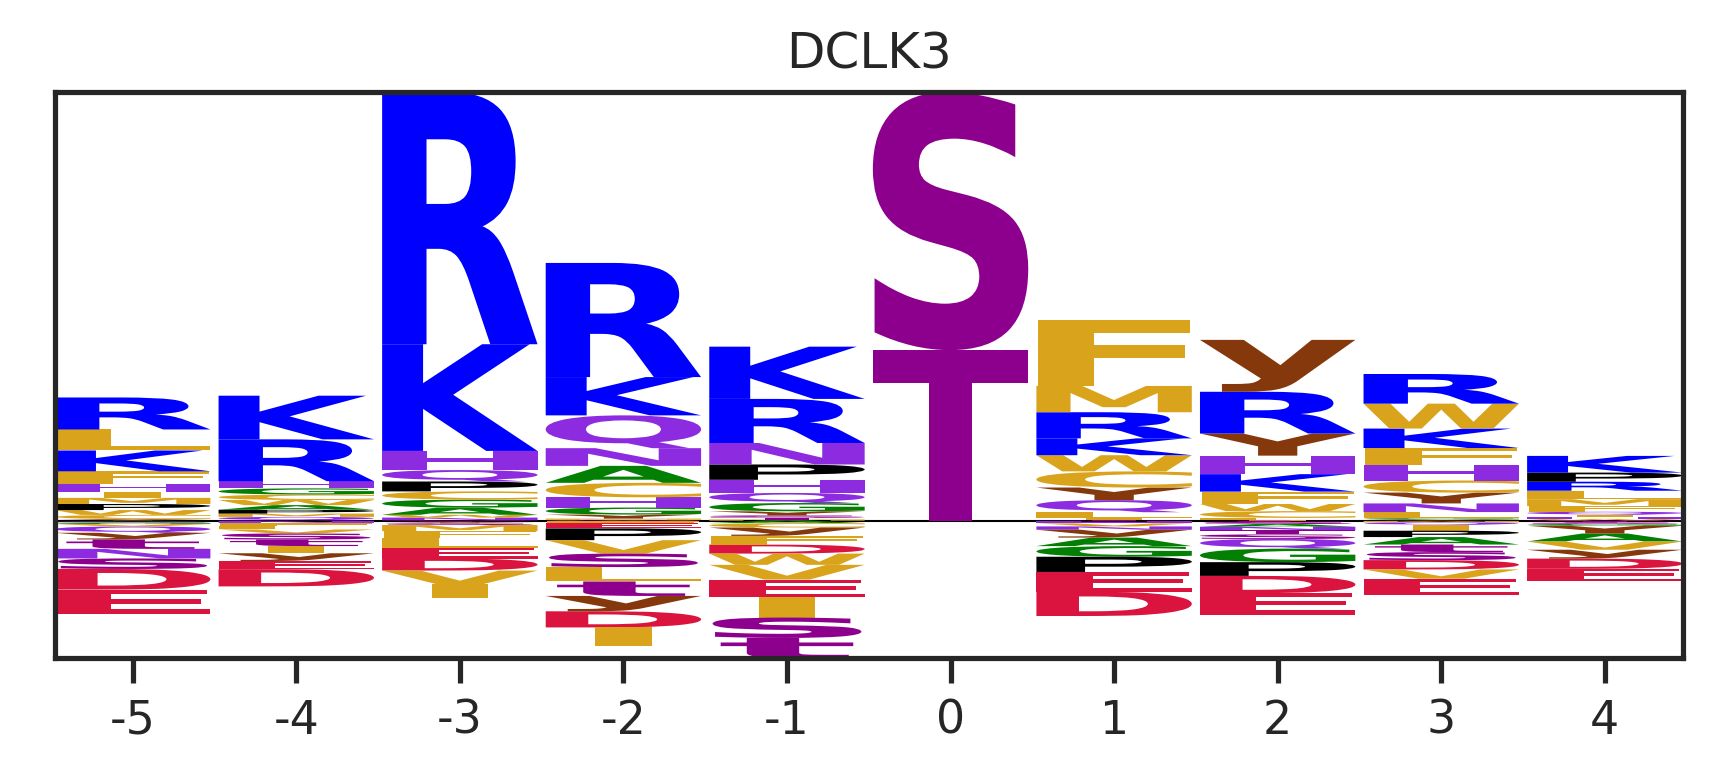

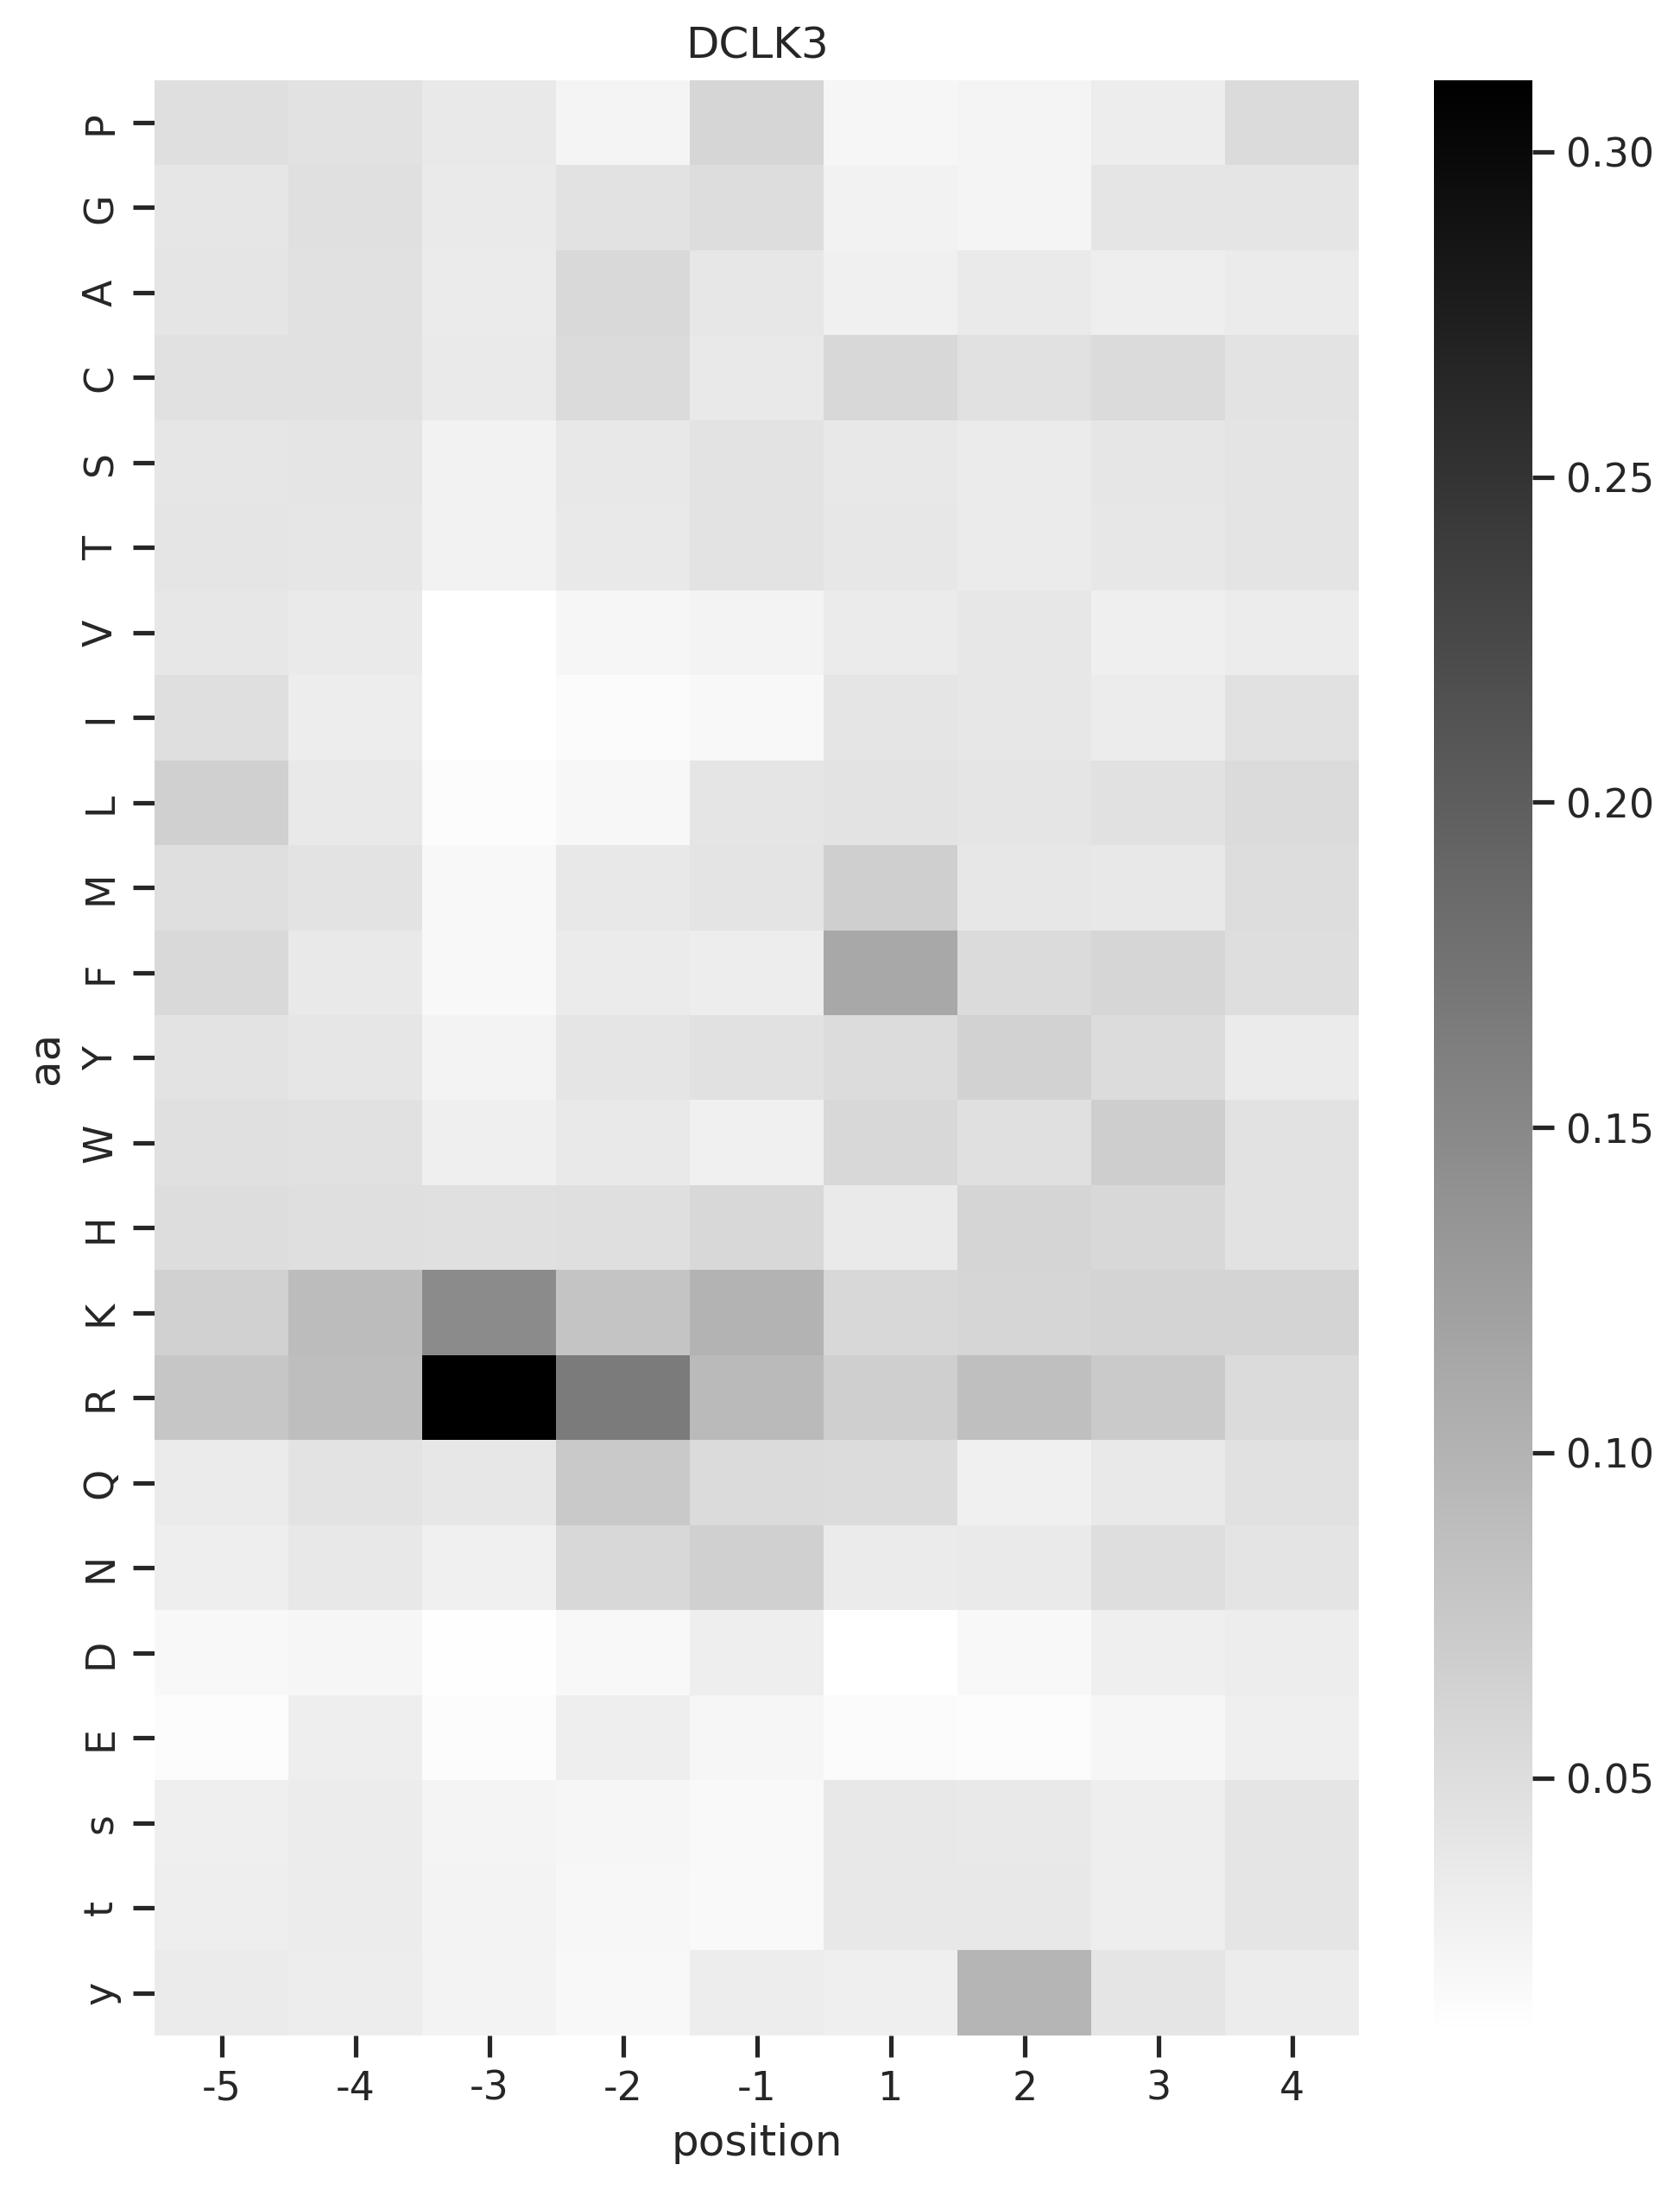

MAPK:0.8818759660317733


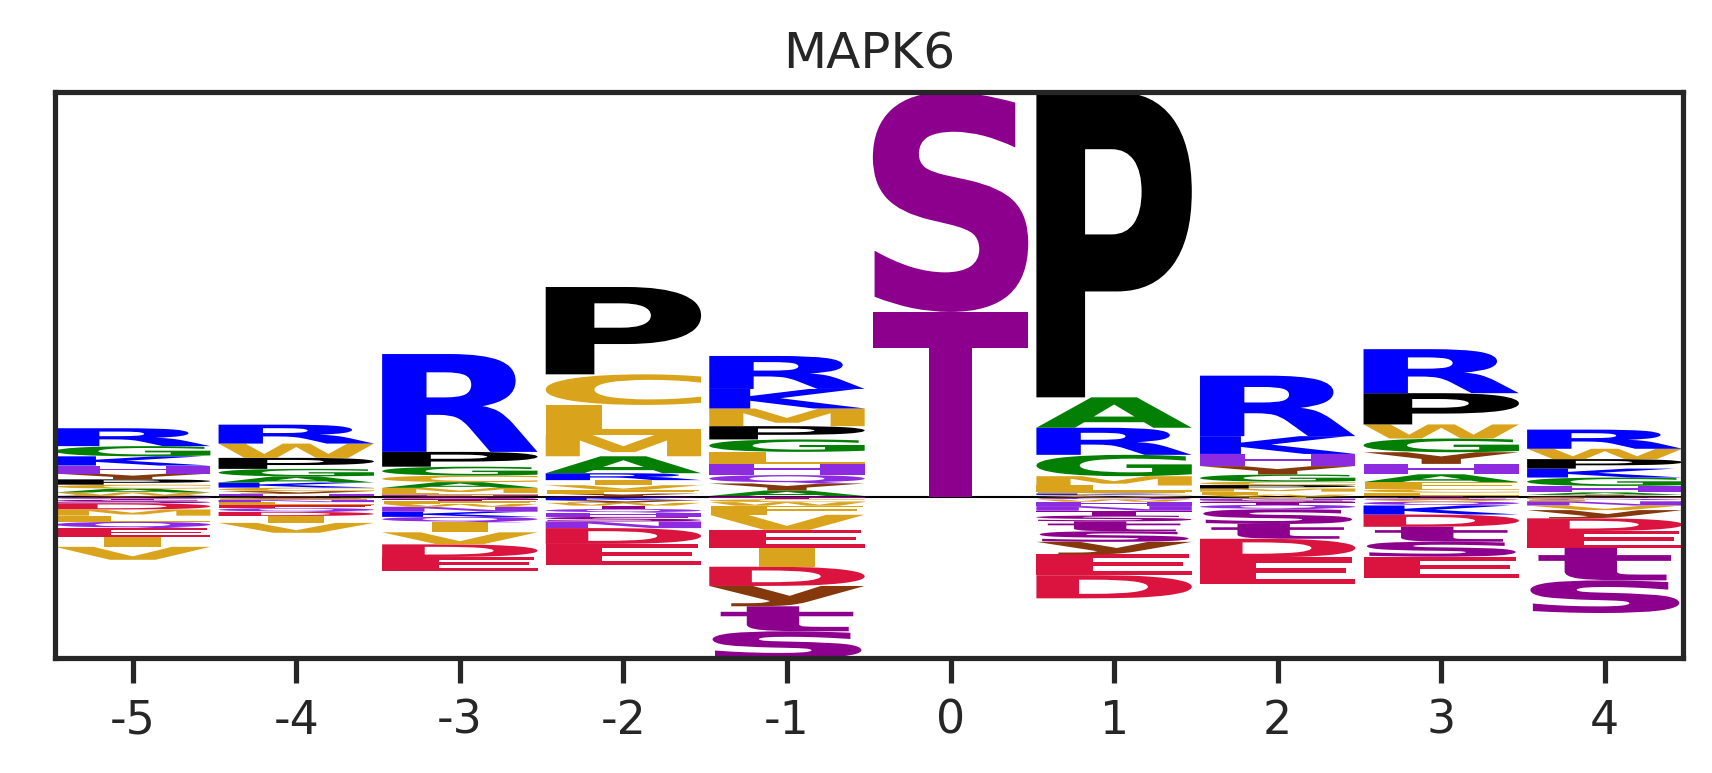

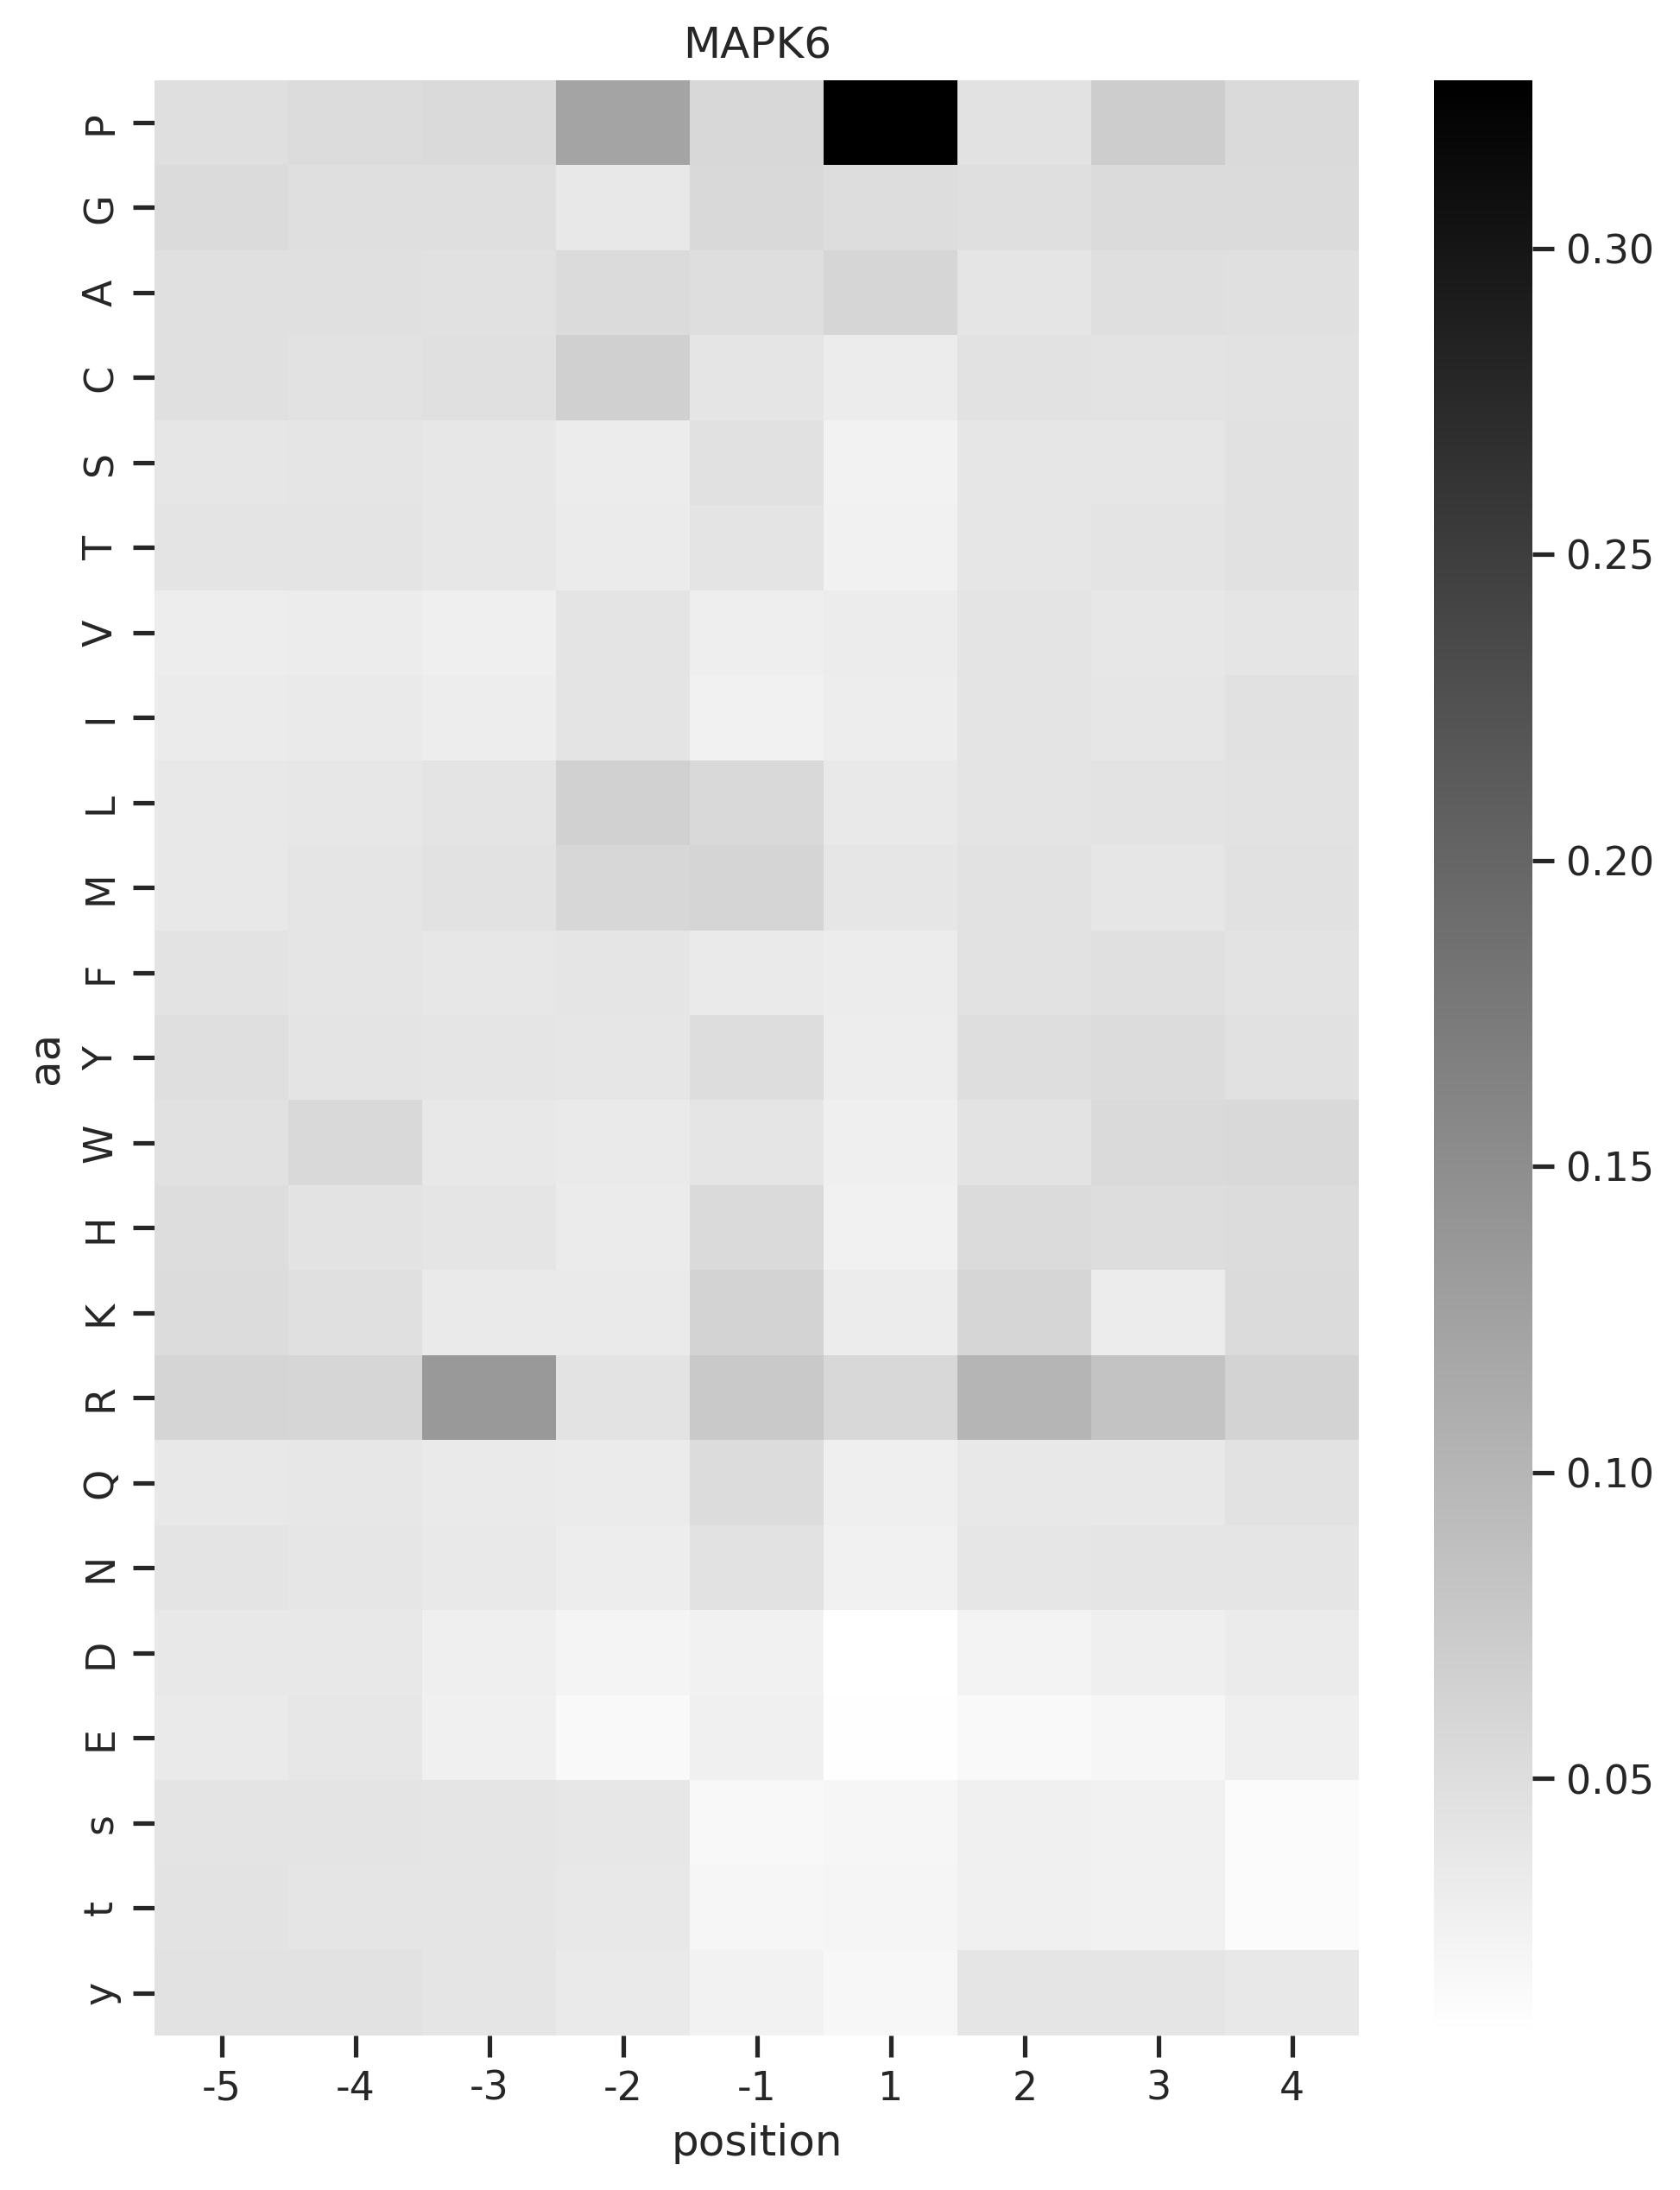

MAPK:0.8818759660317733


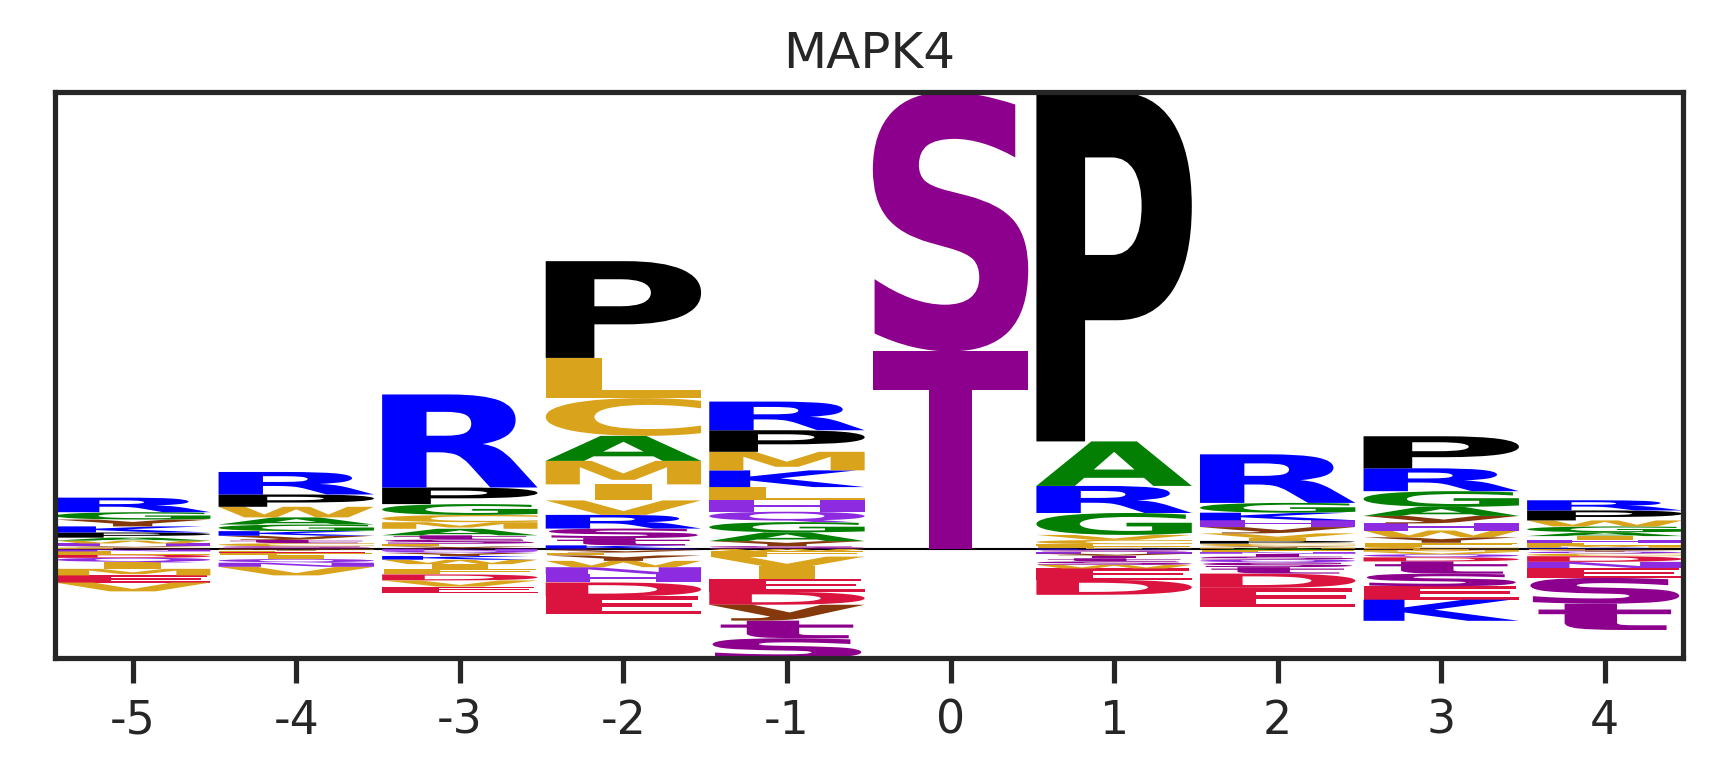

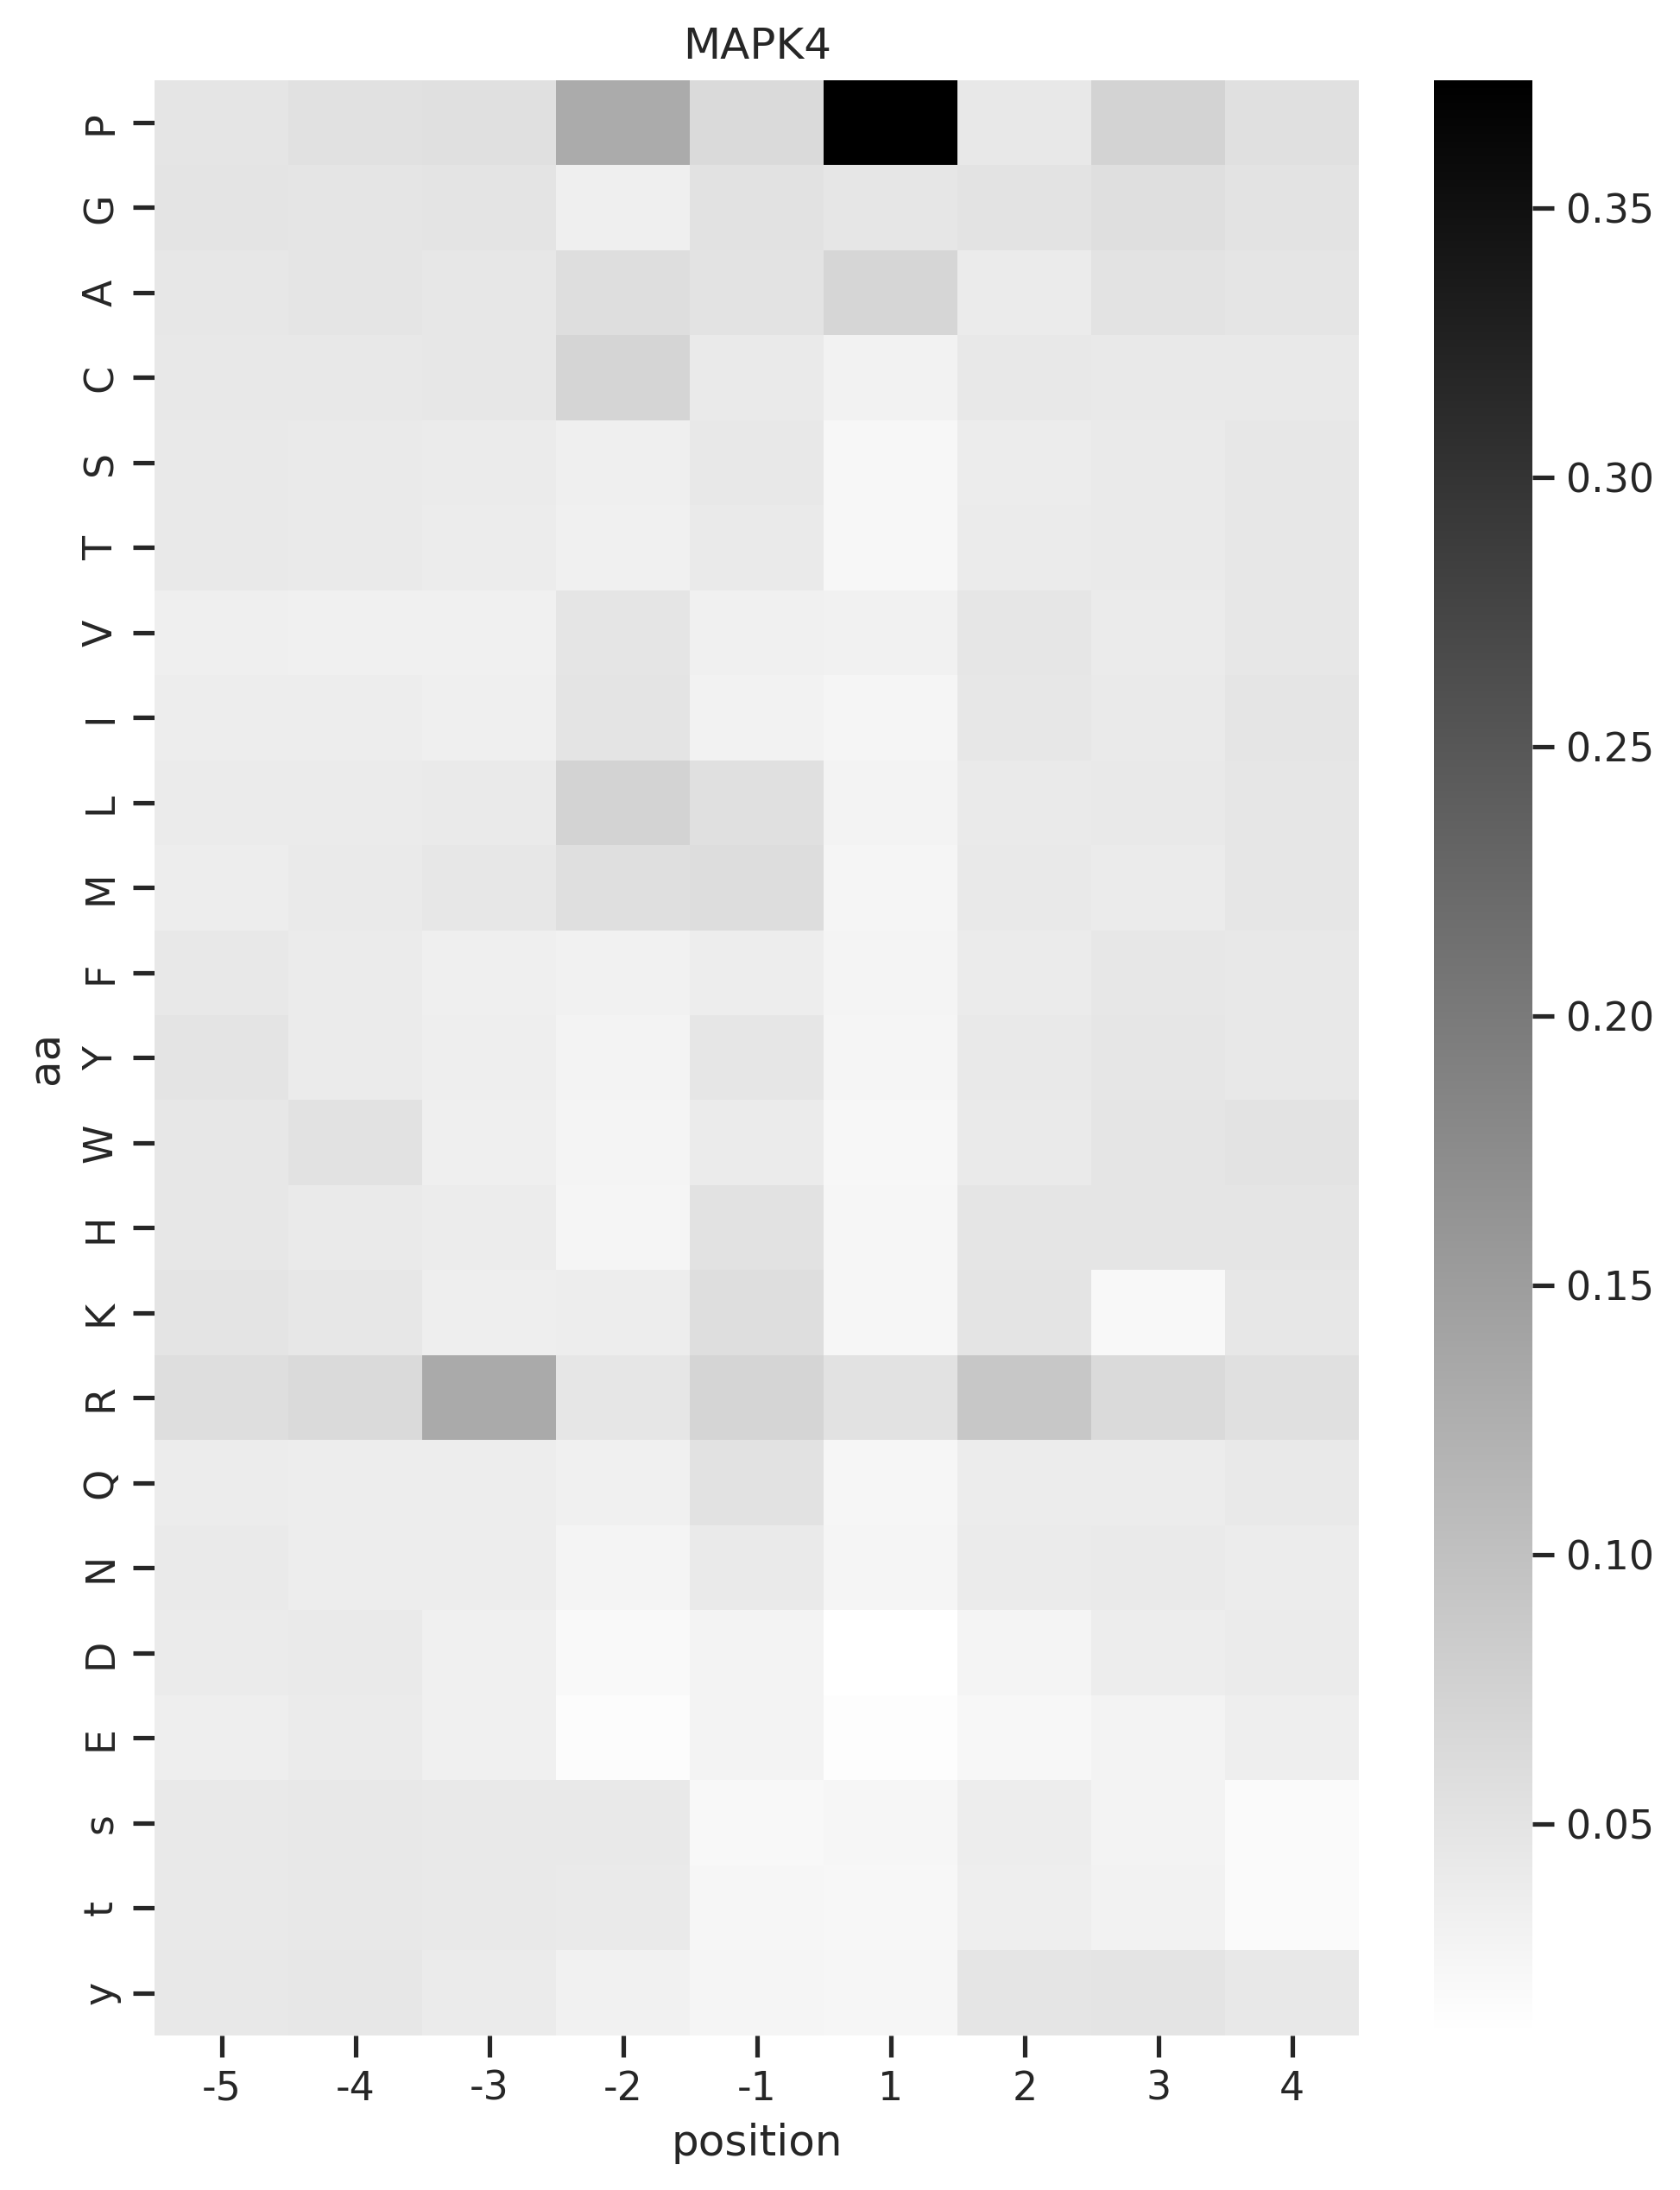

STE20:0.8639317629980943


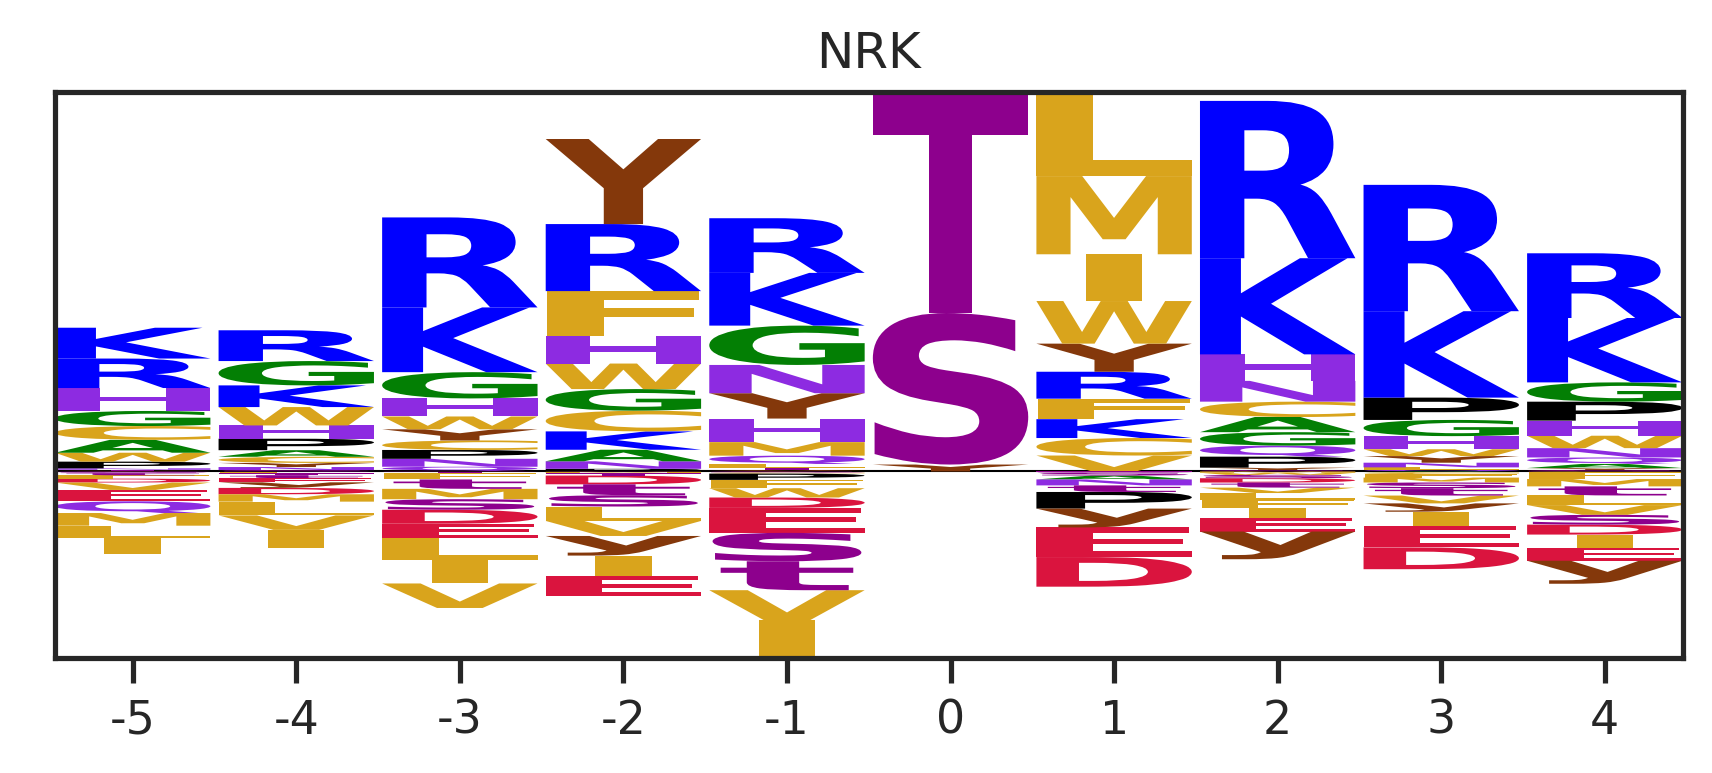

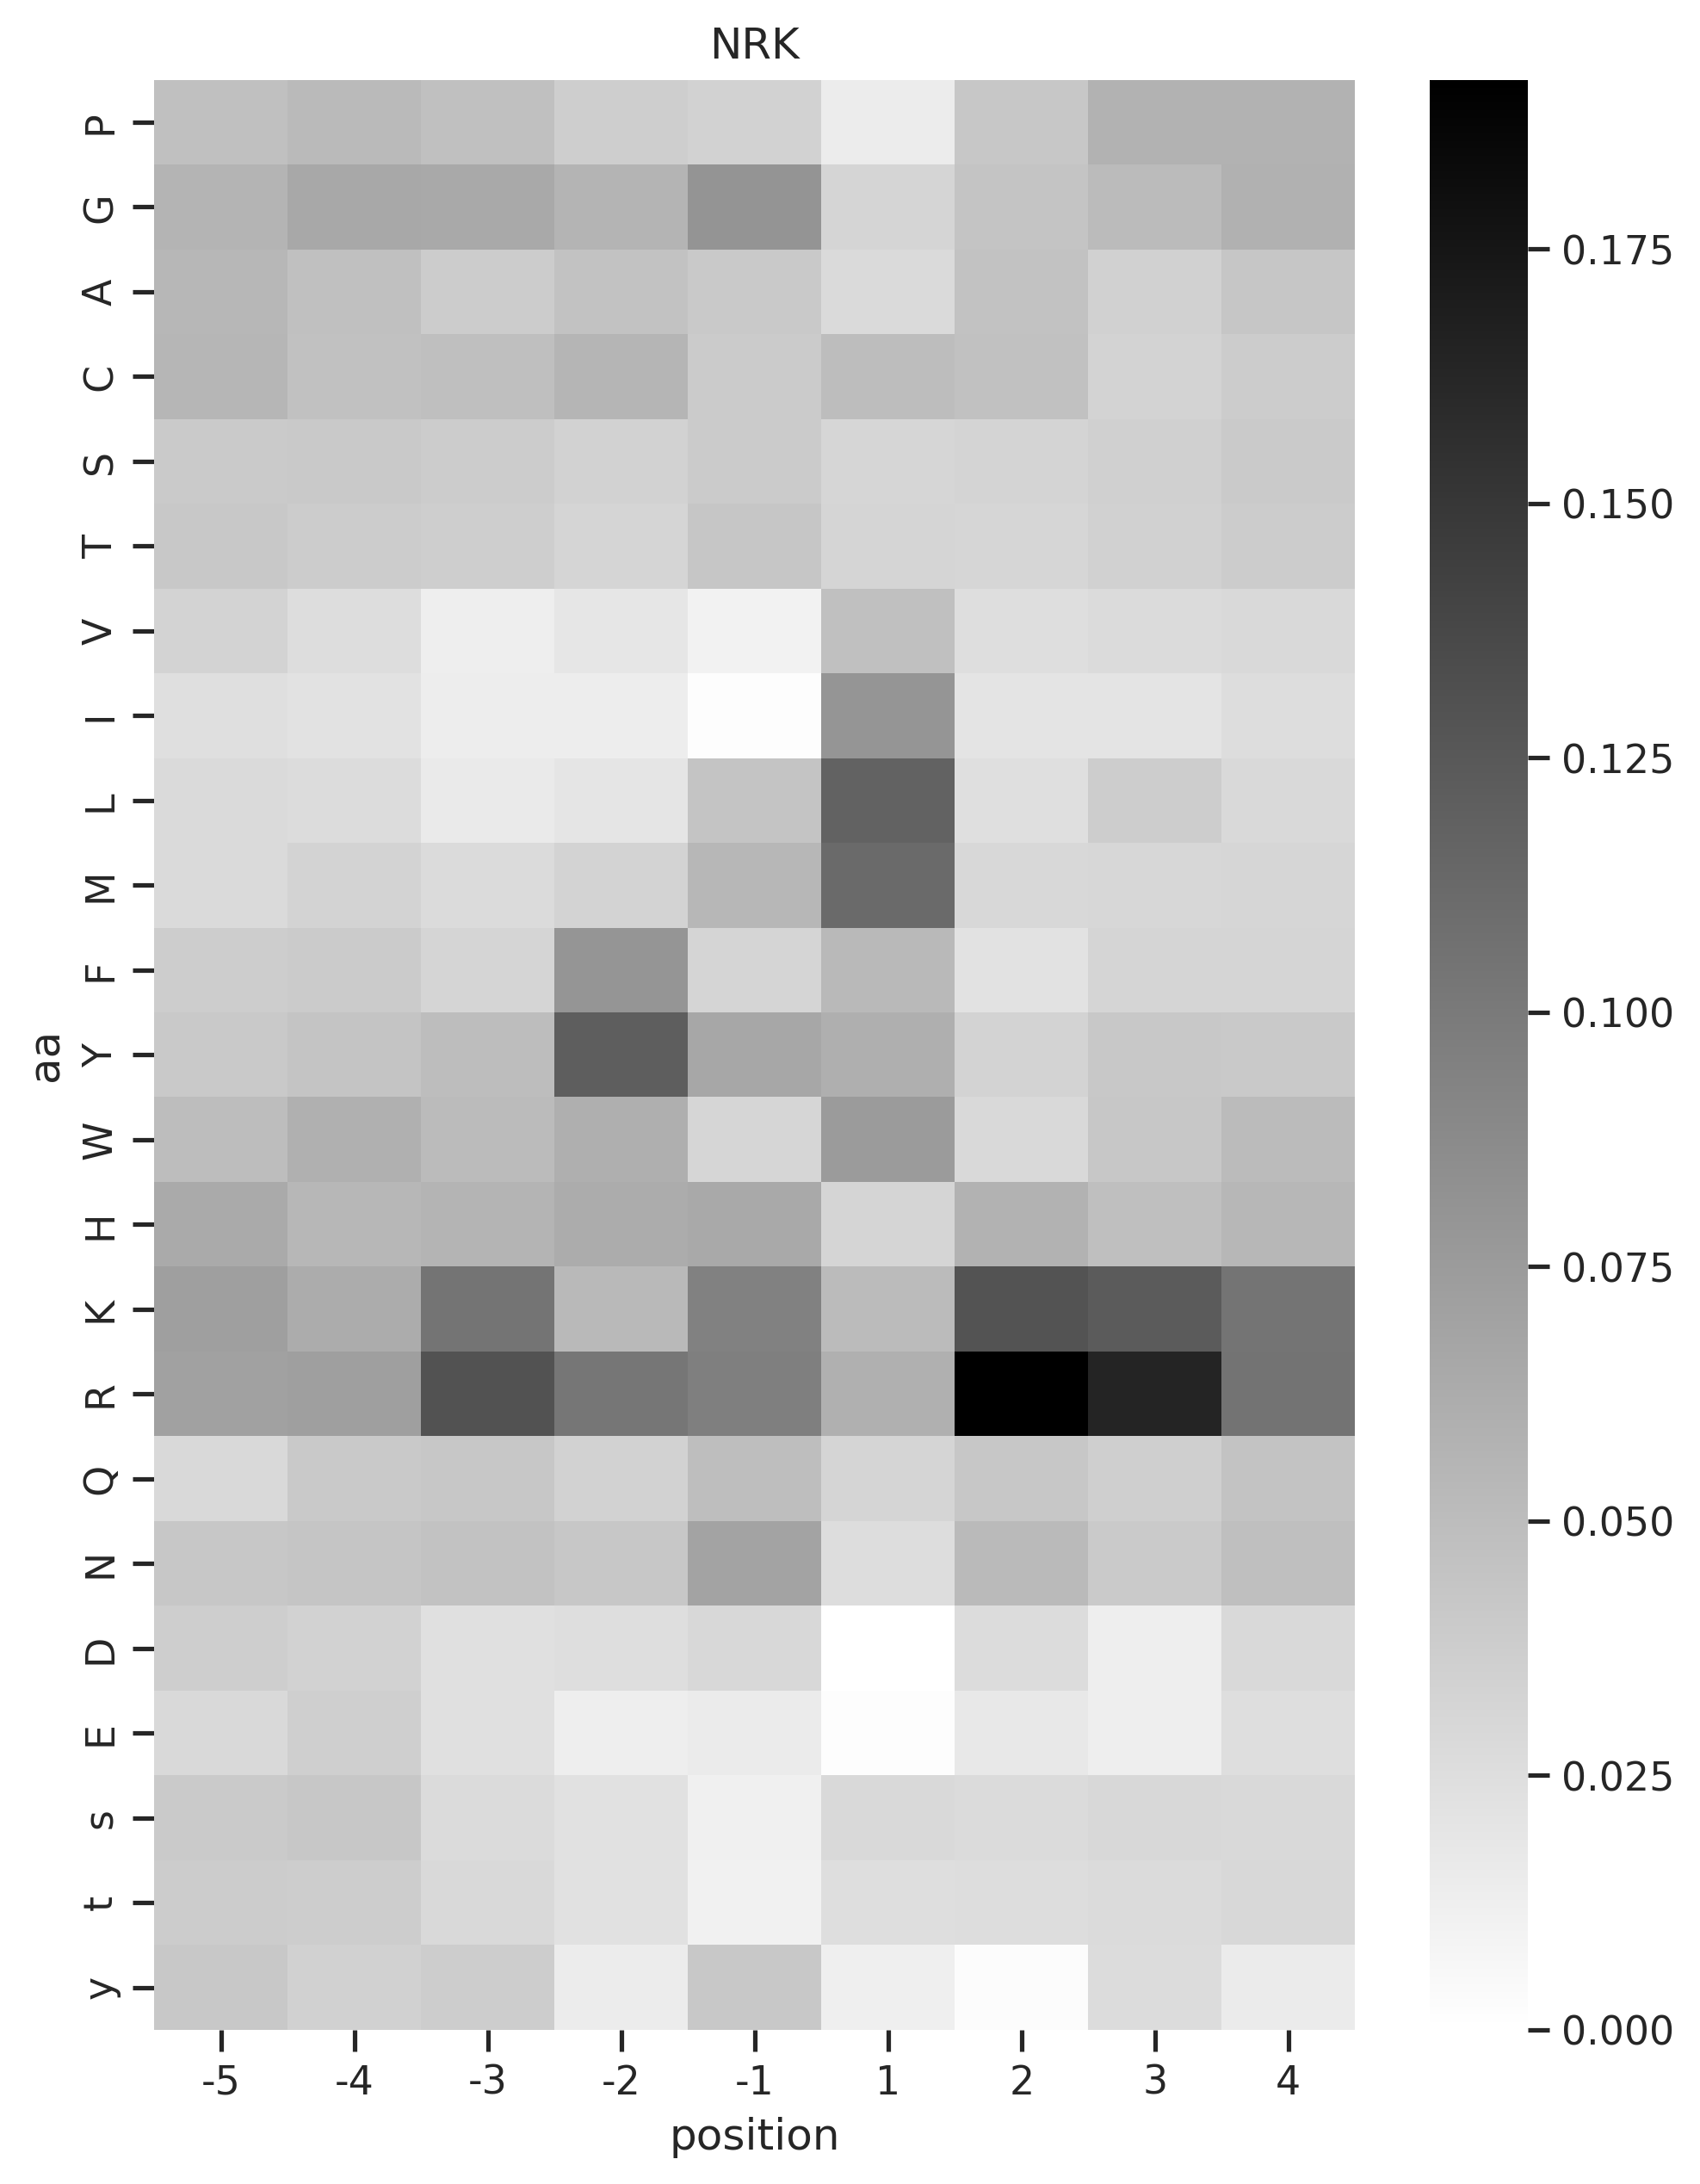

STKR:0.8578397866239376


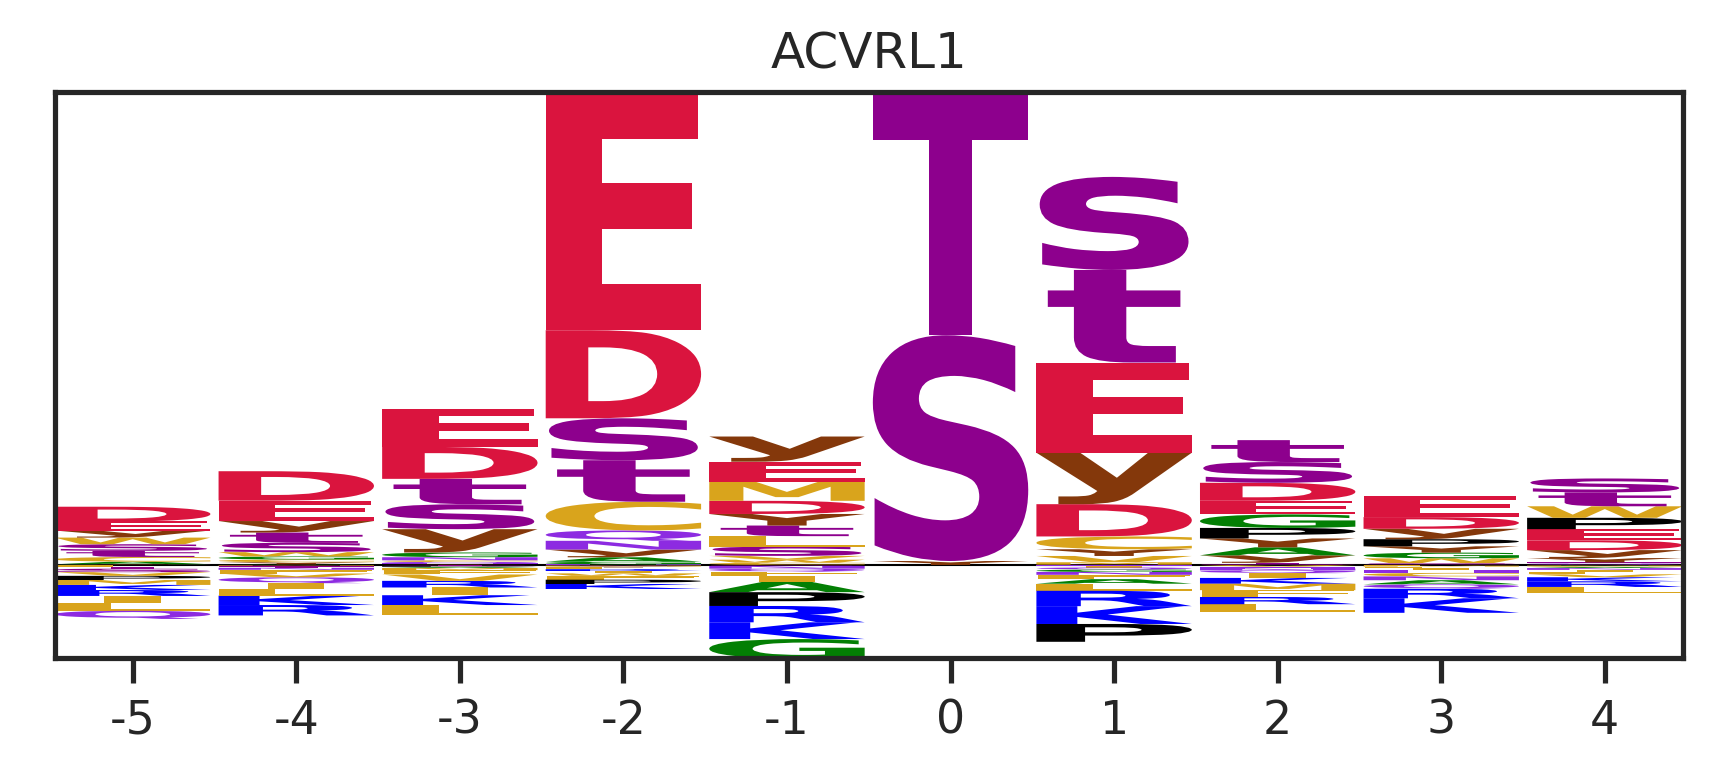

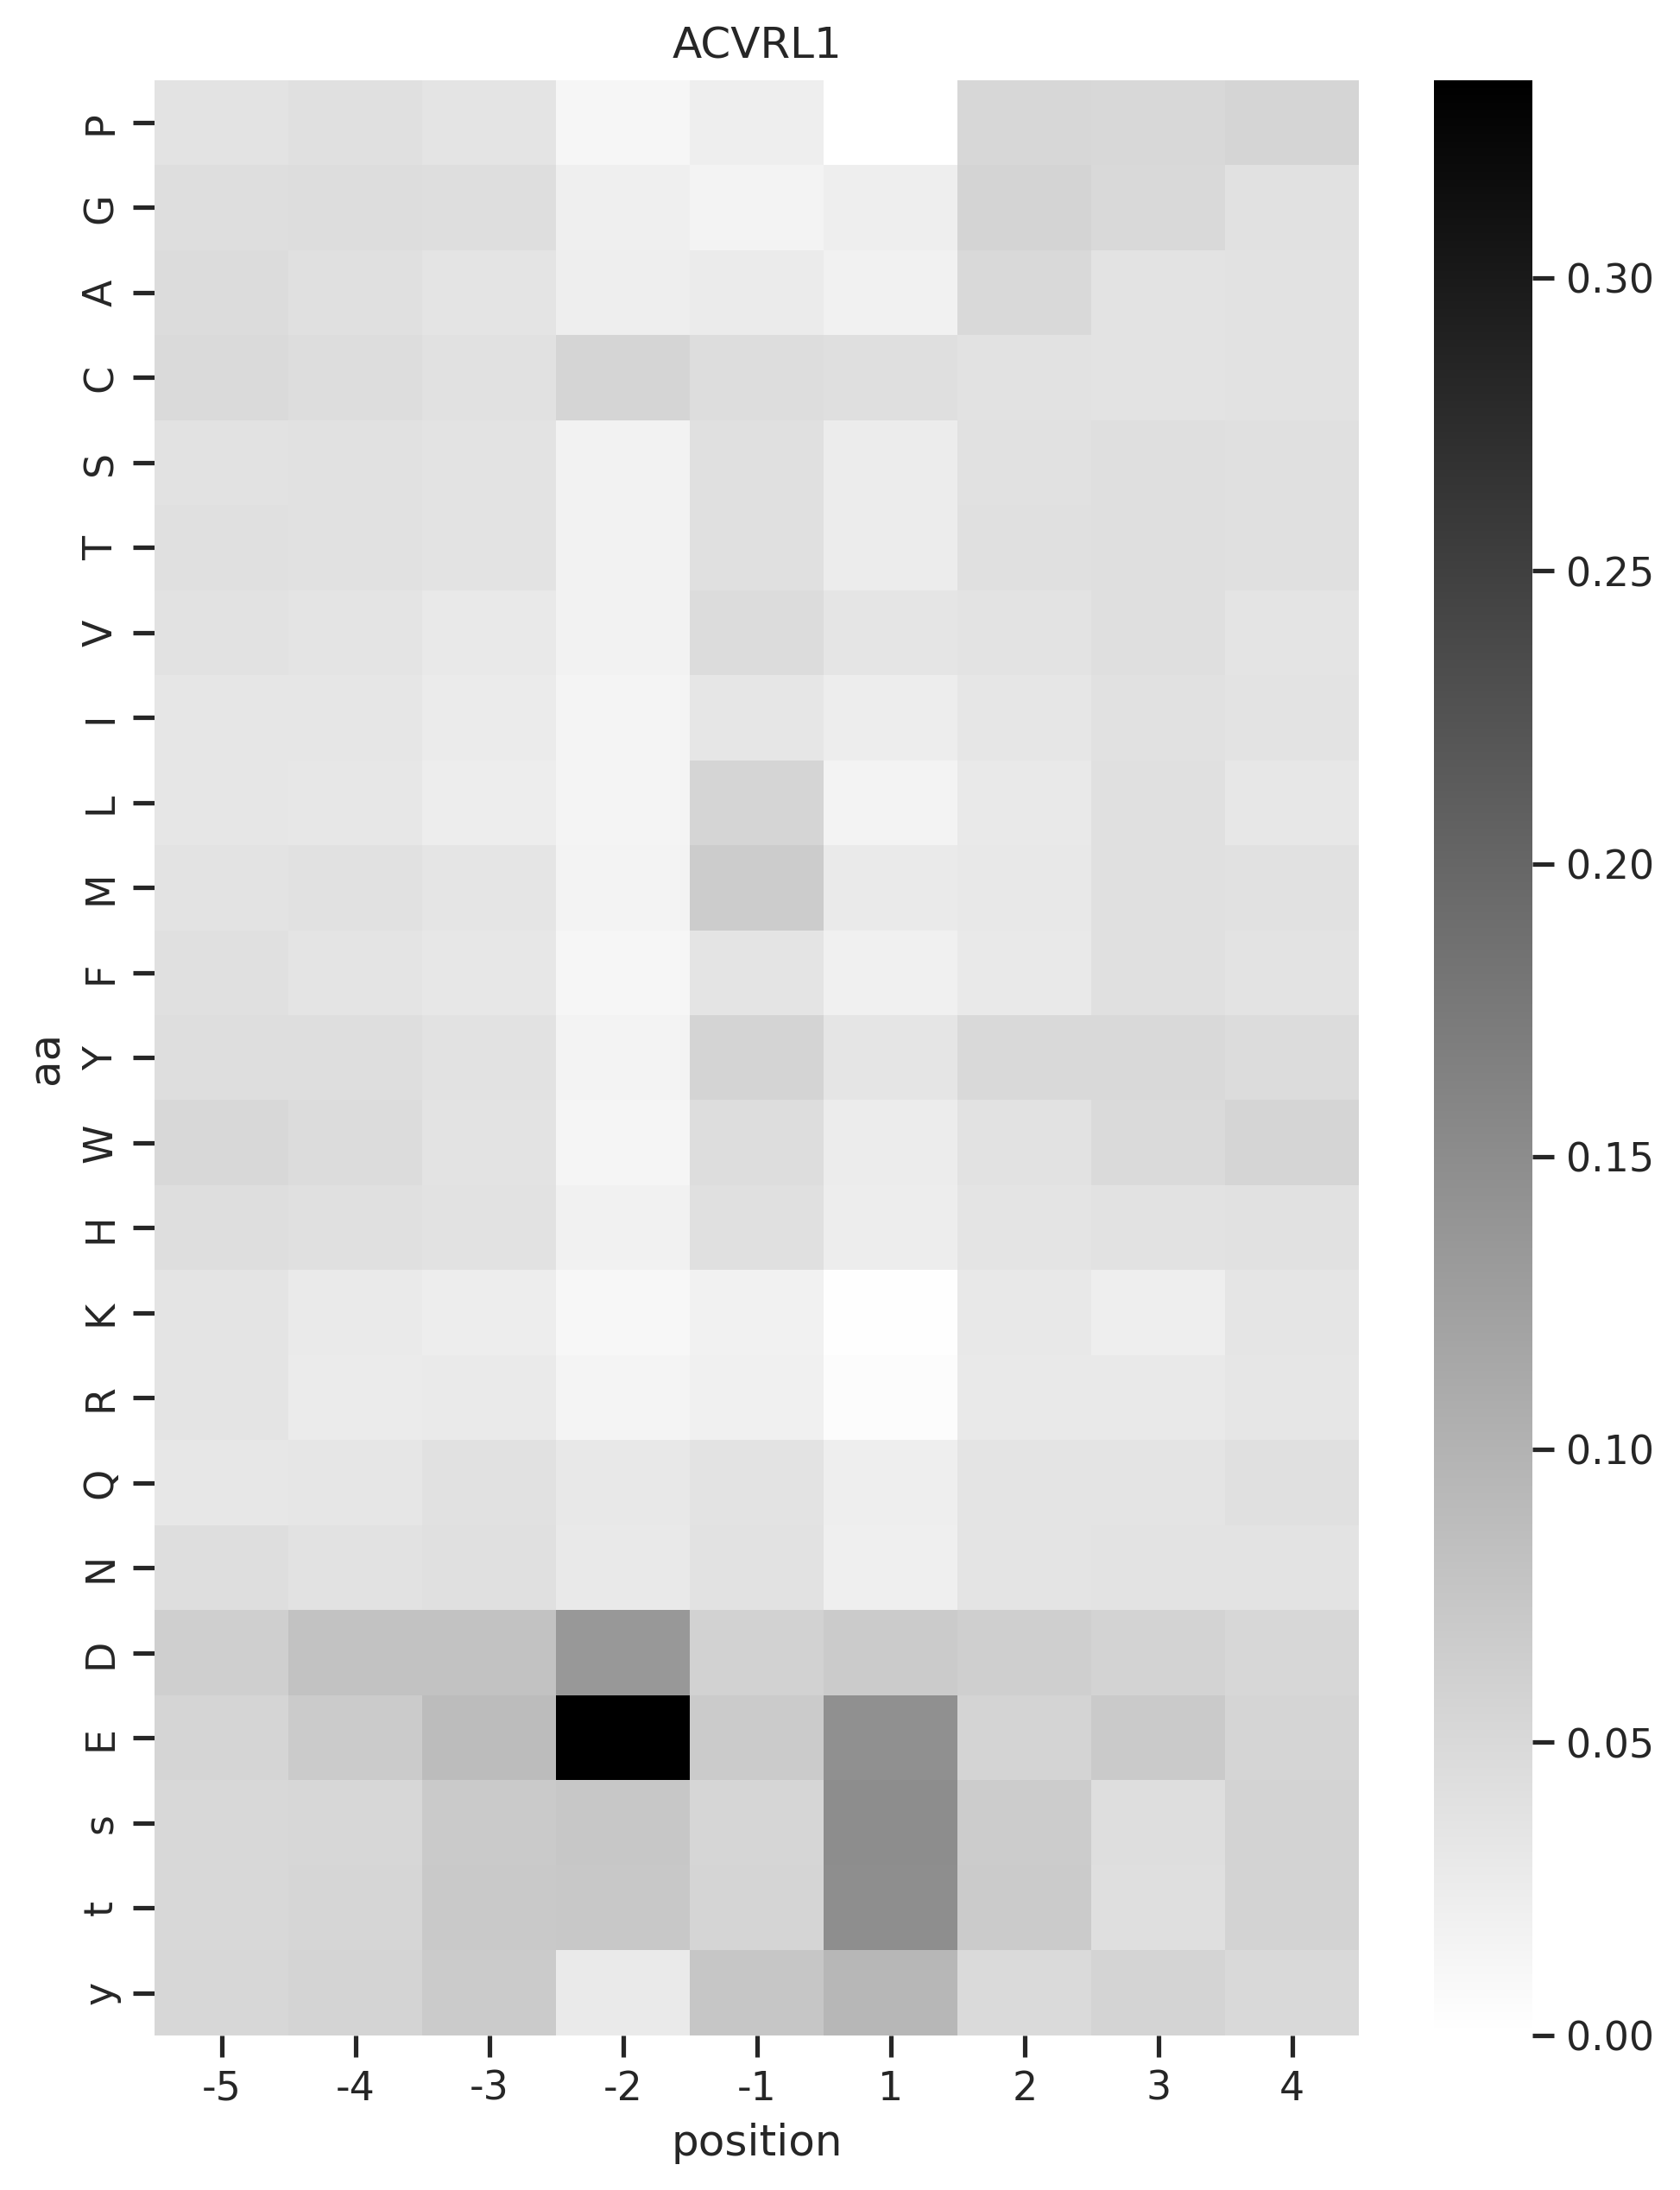

STKR:0.8578397866239376


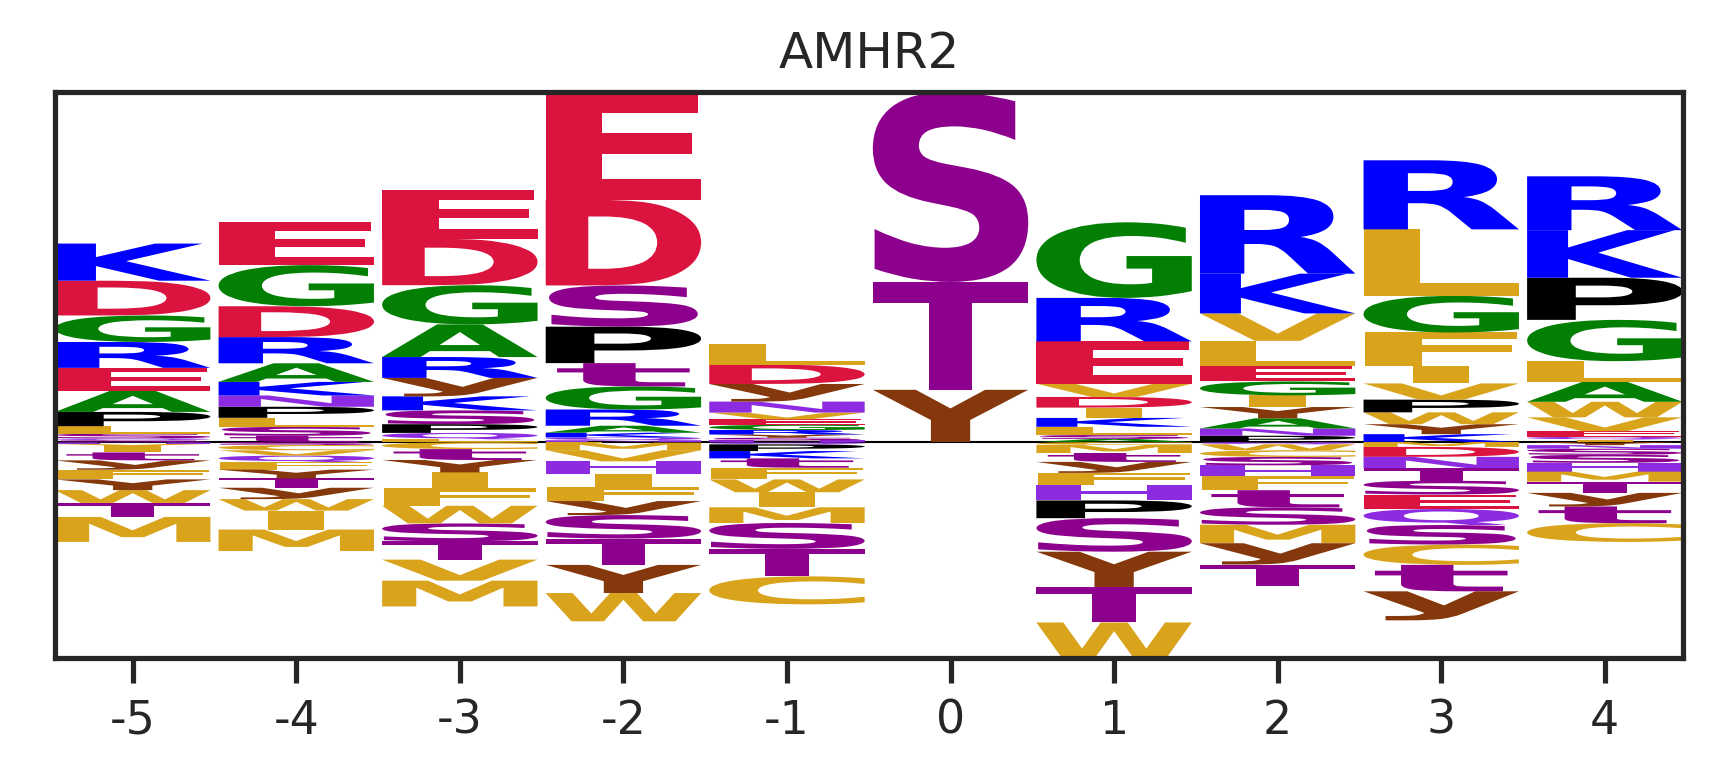

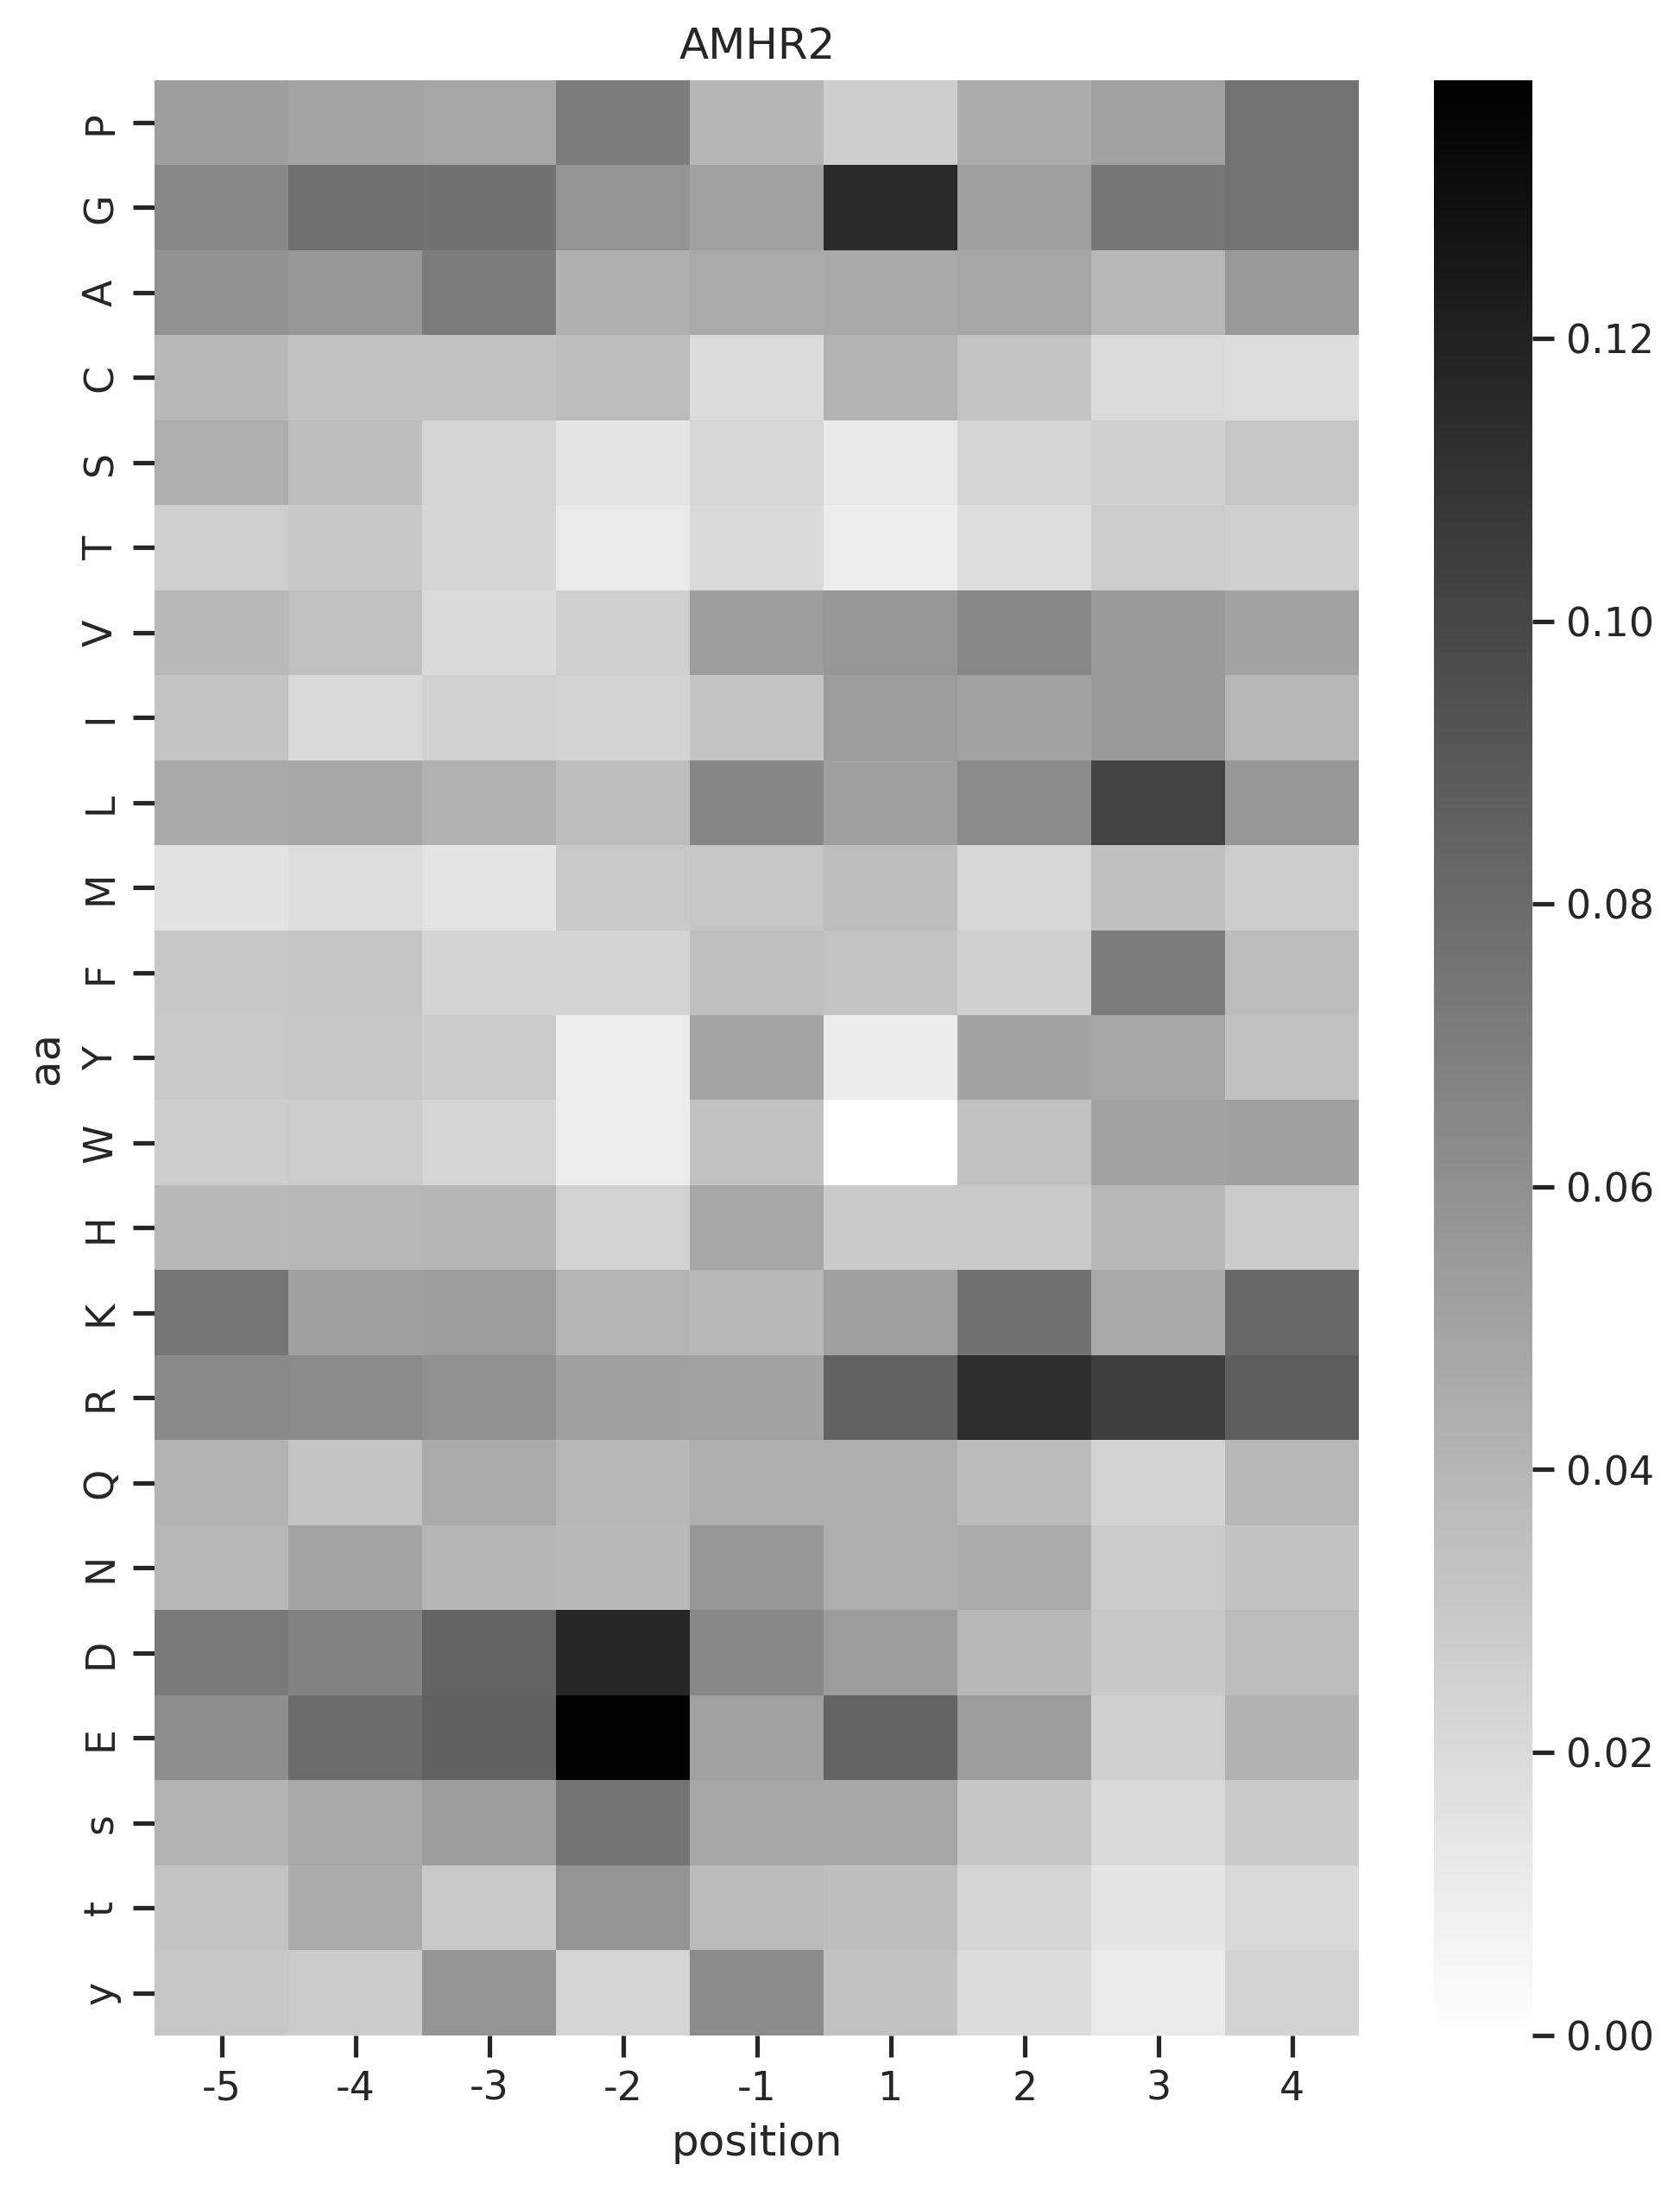

STKR:0.8578397866239376


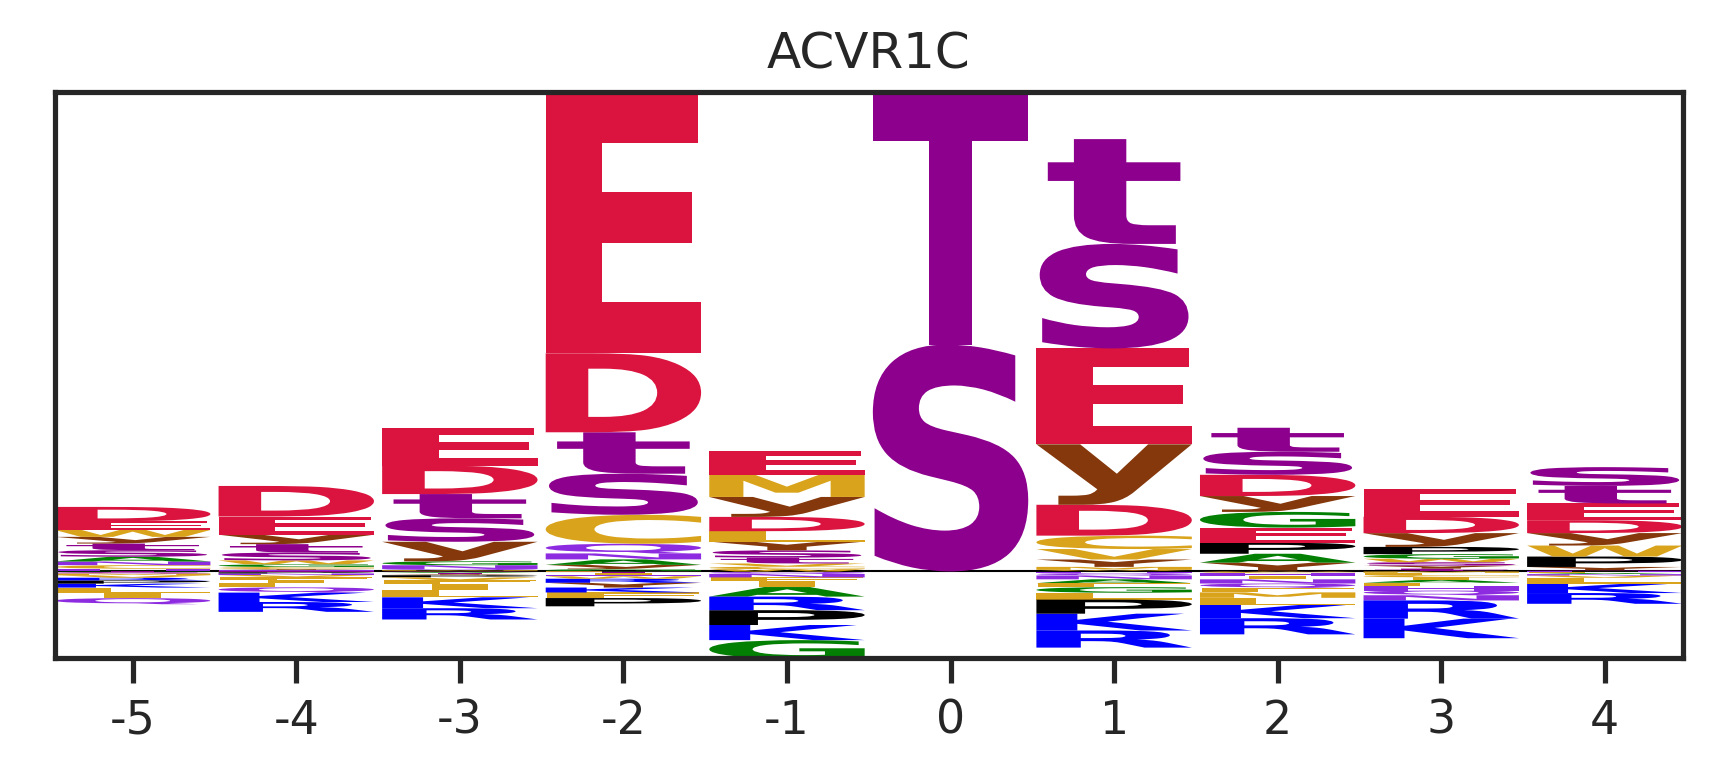

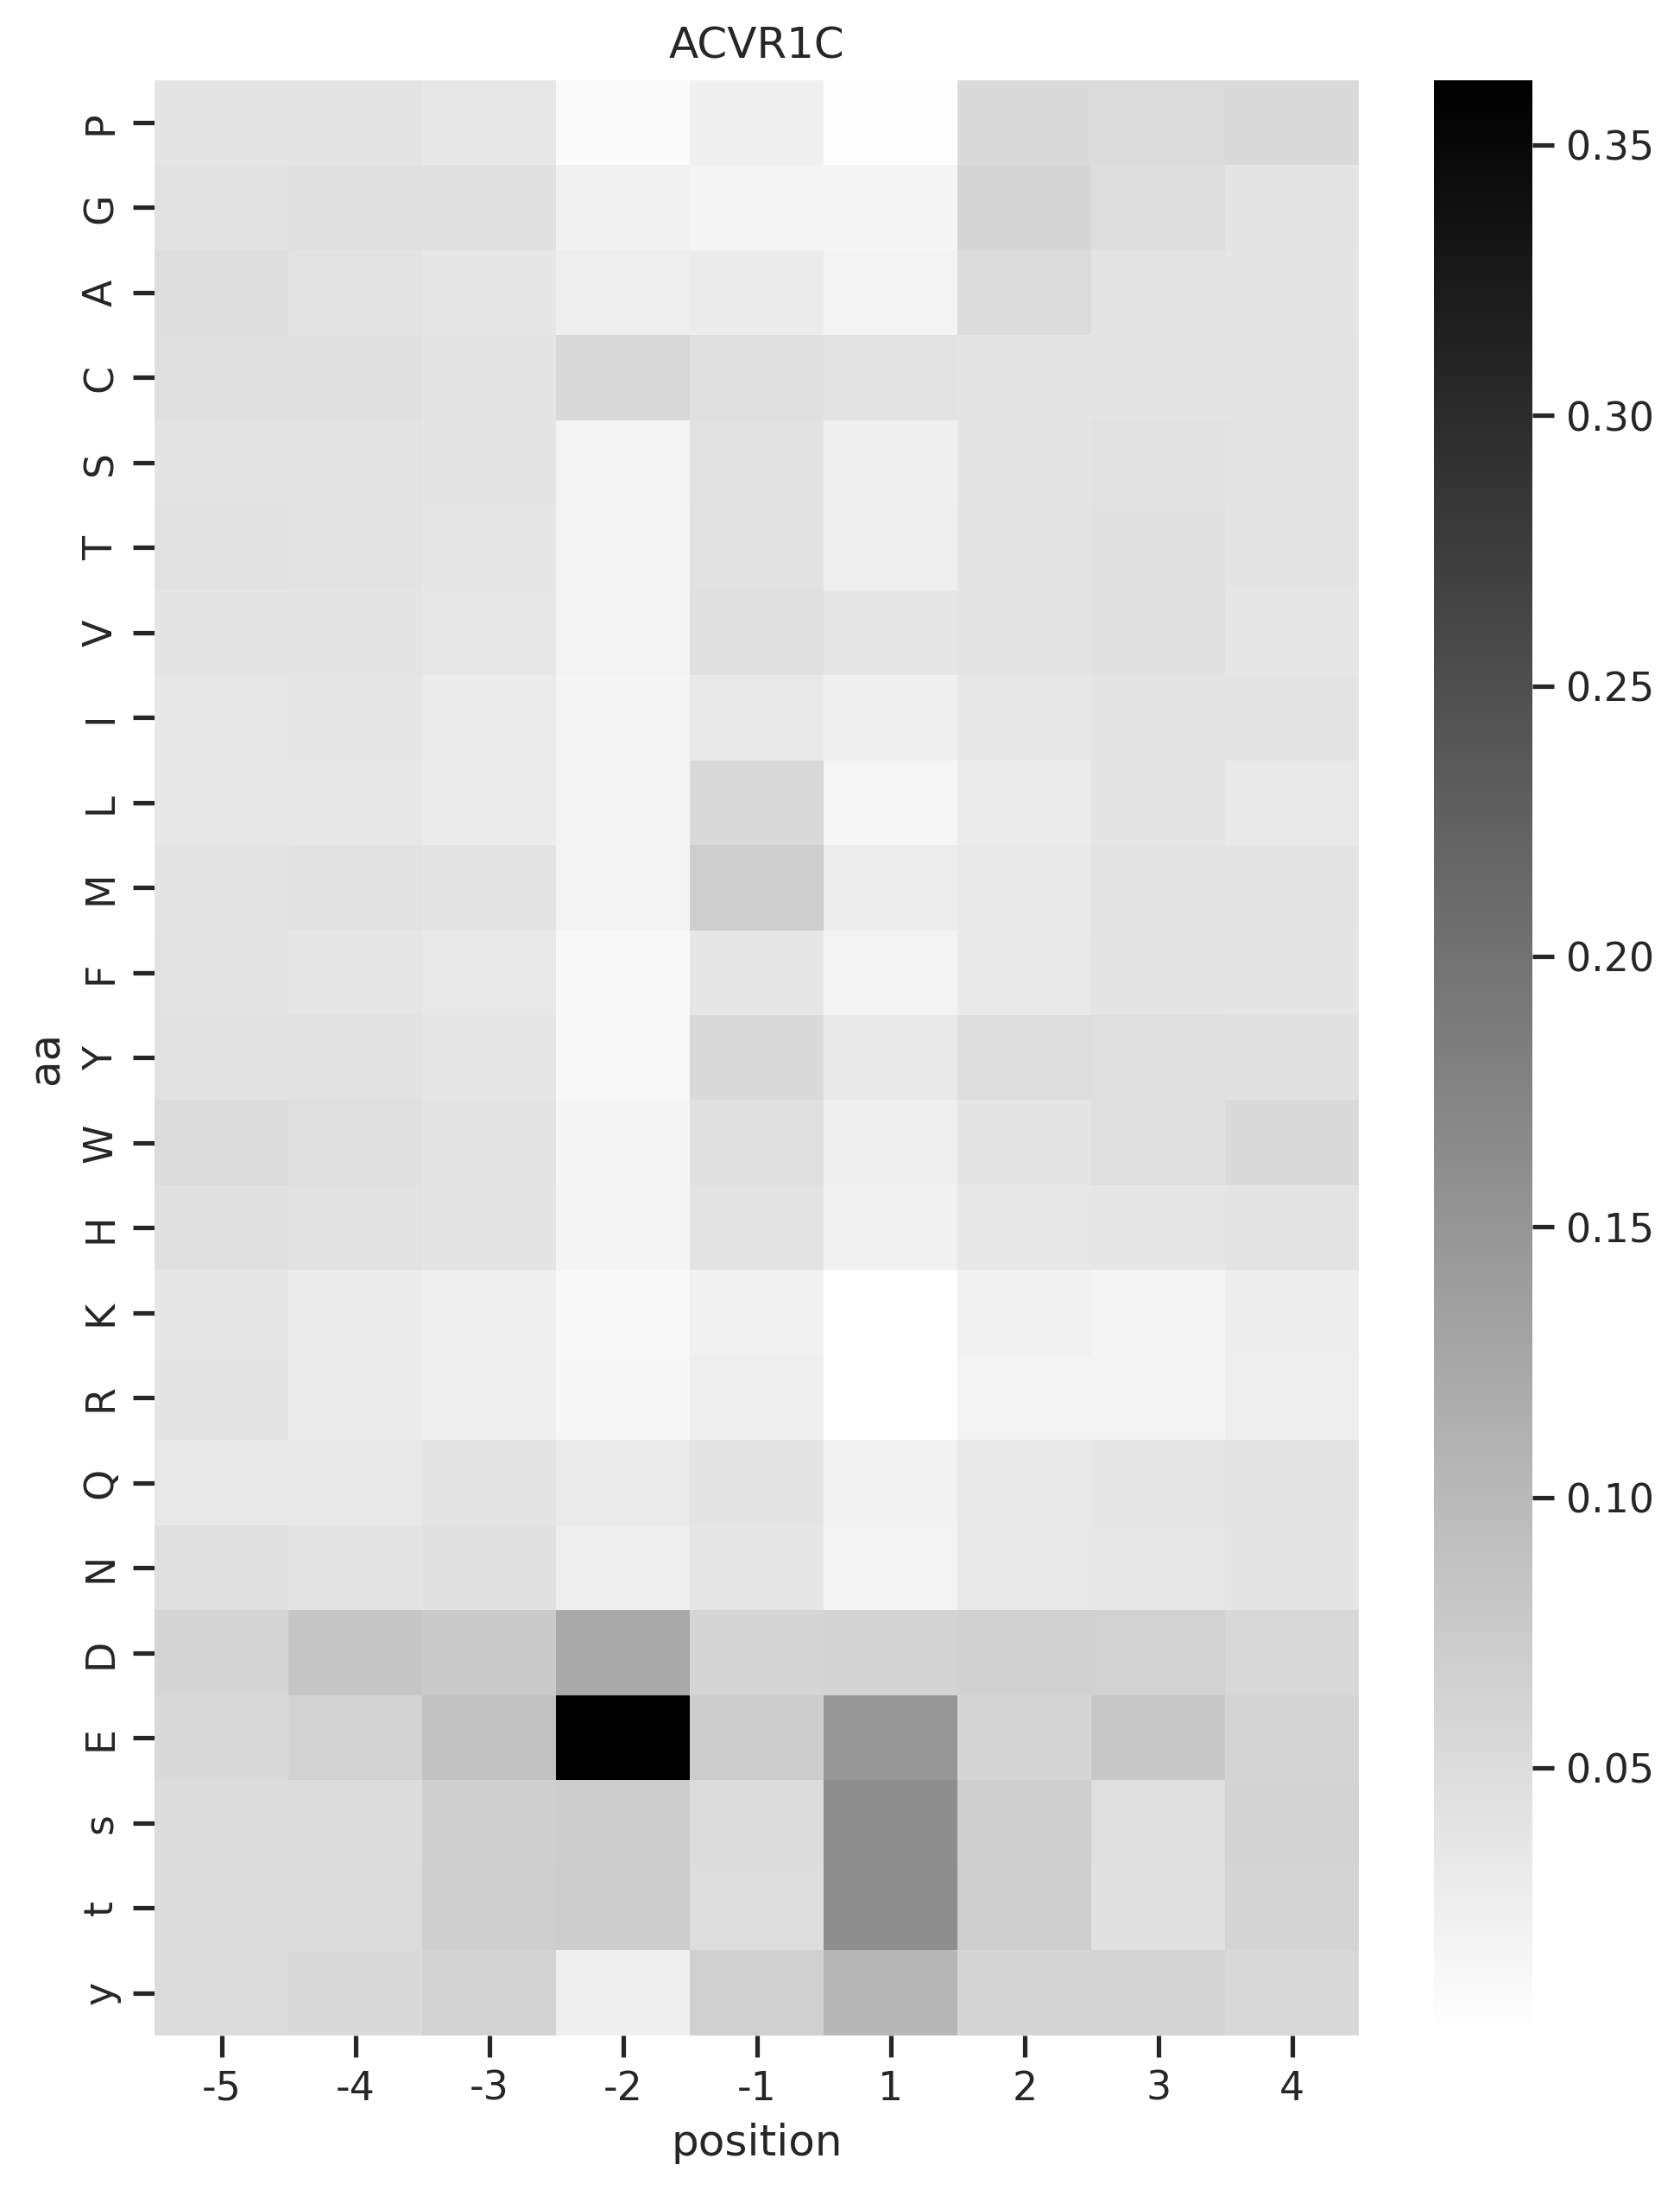

TSSK:0.8477050673723502


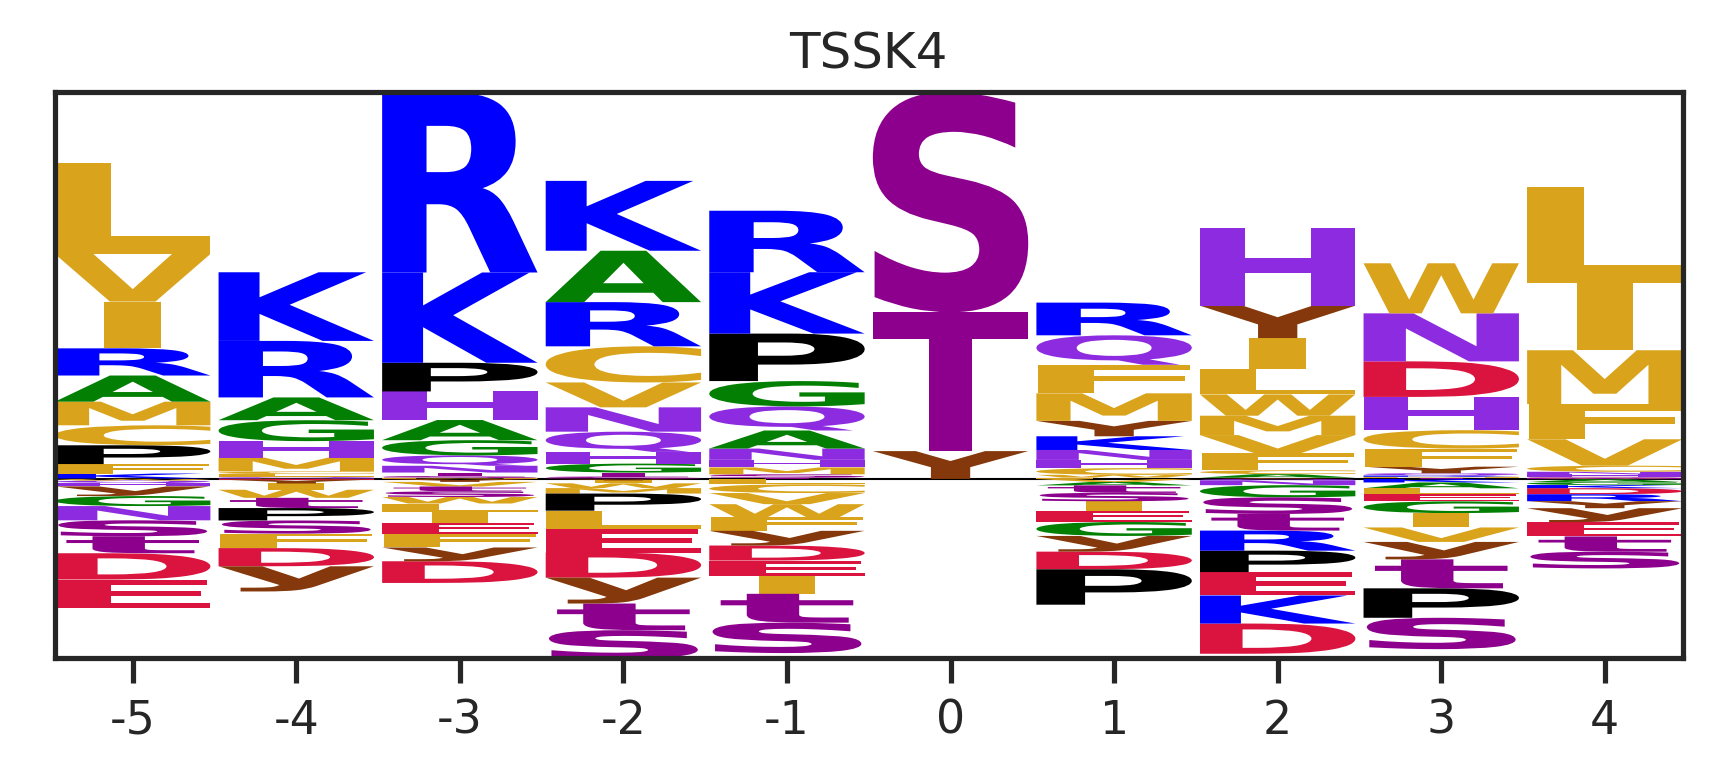

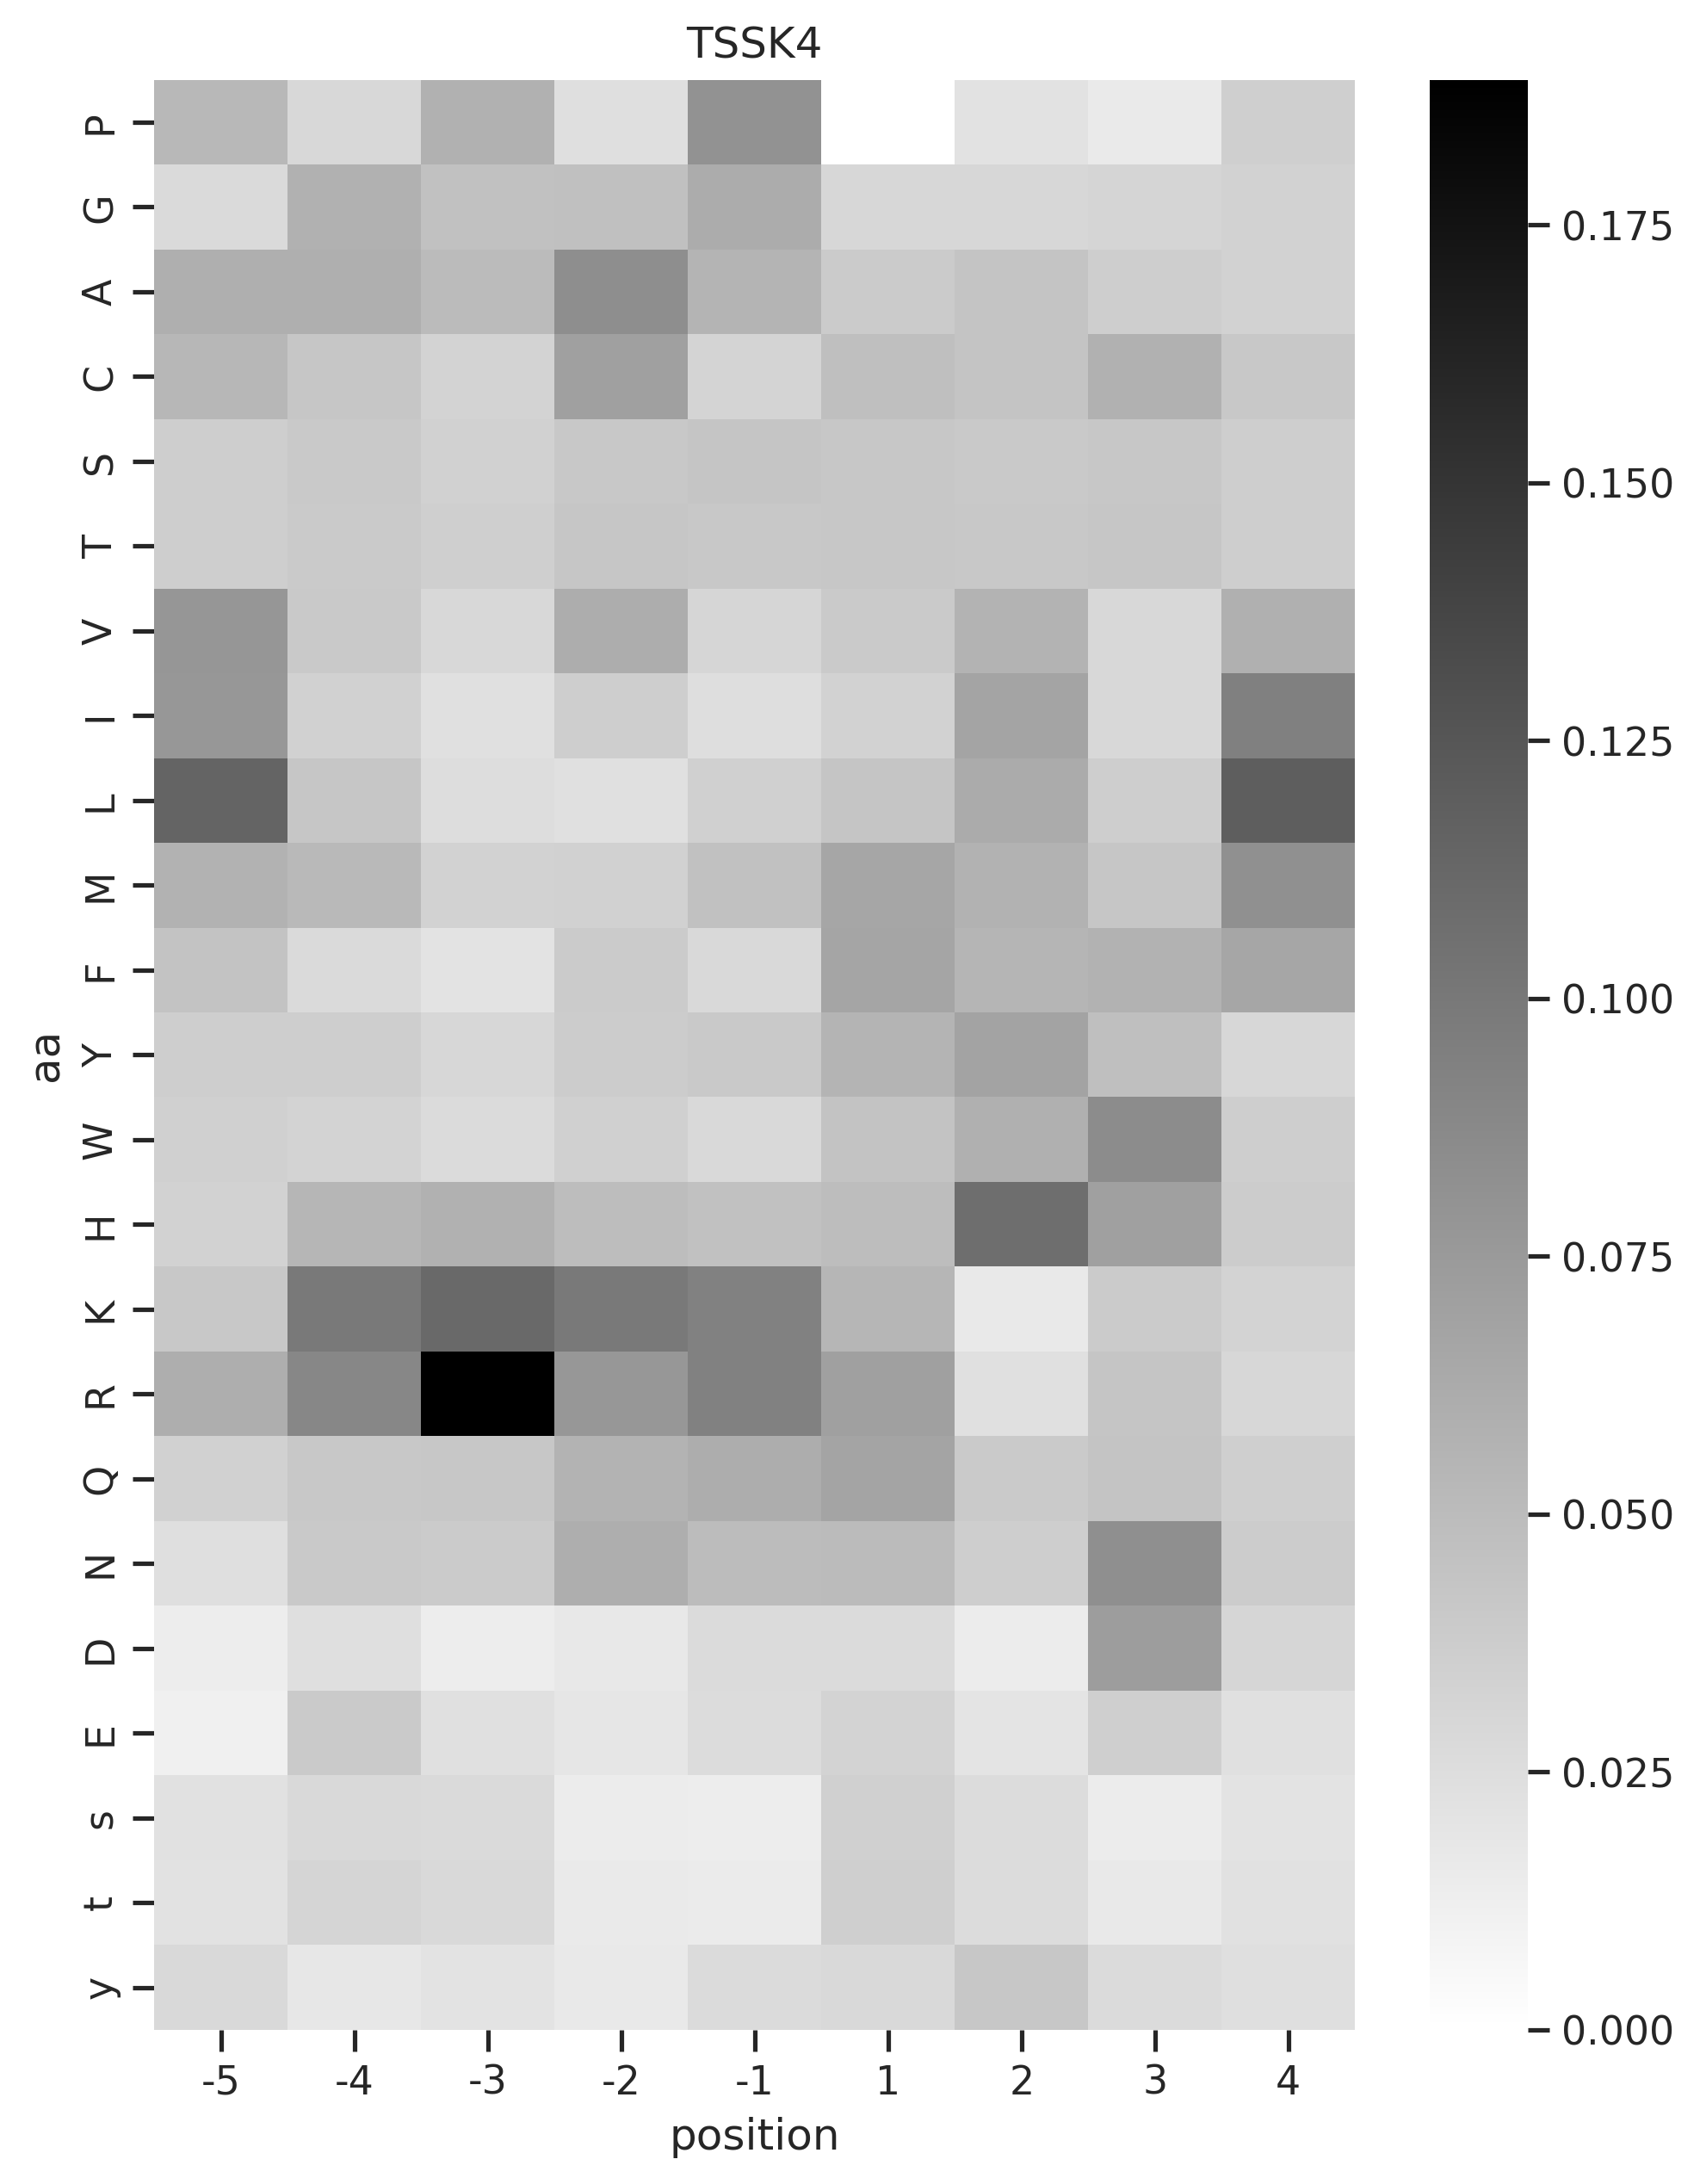

TSSK:0.8477050673723502


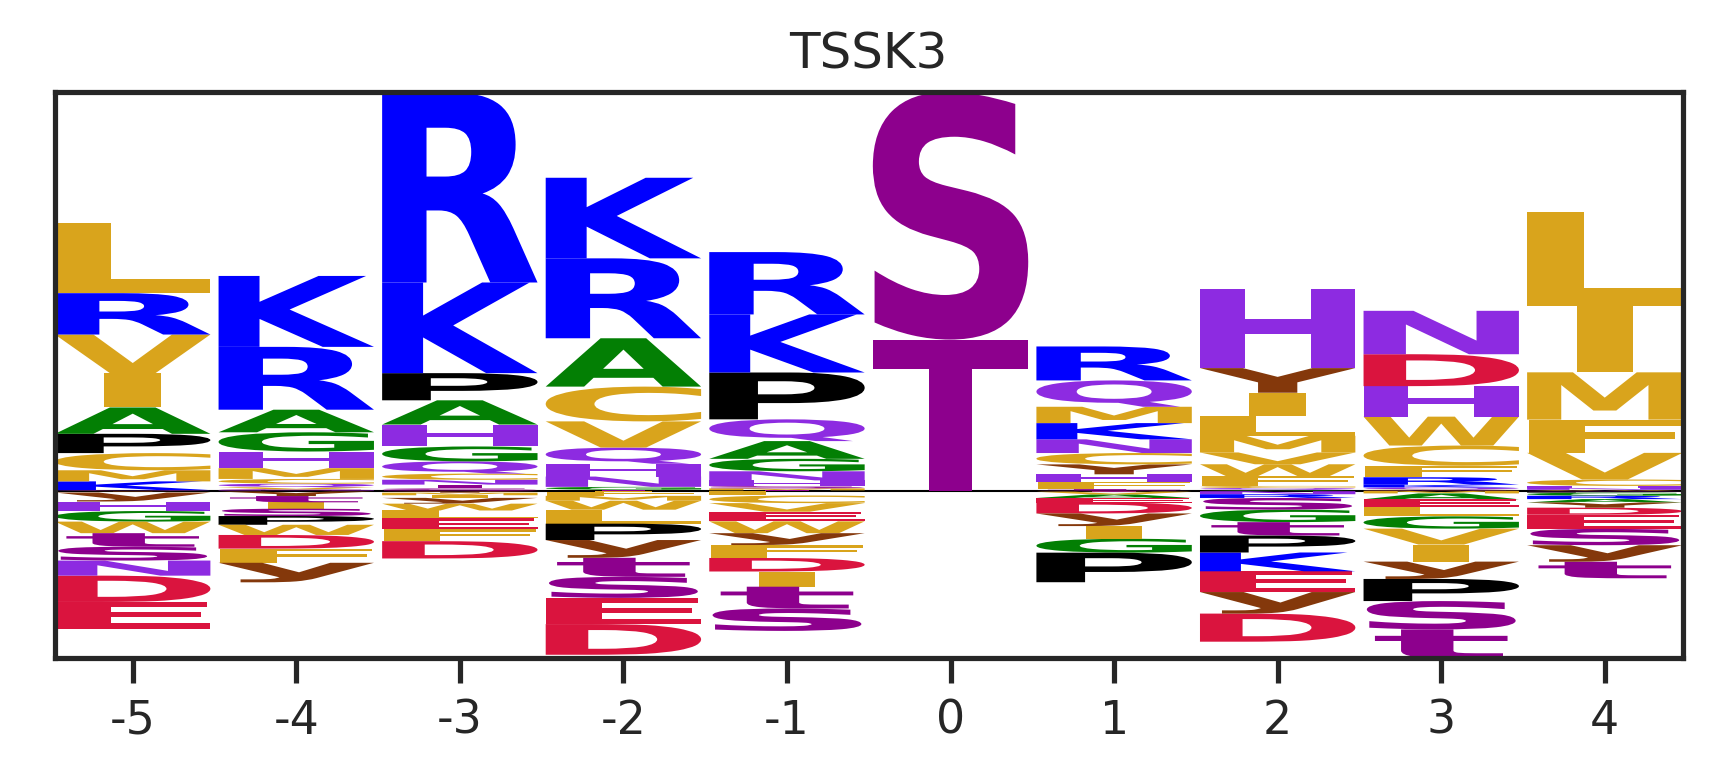

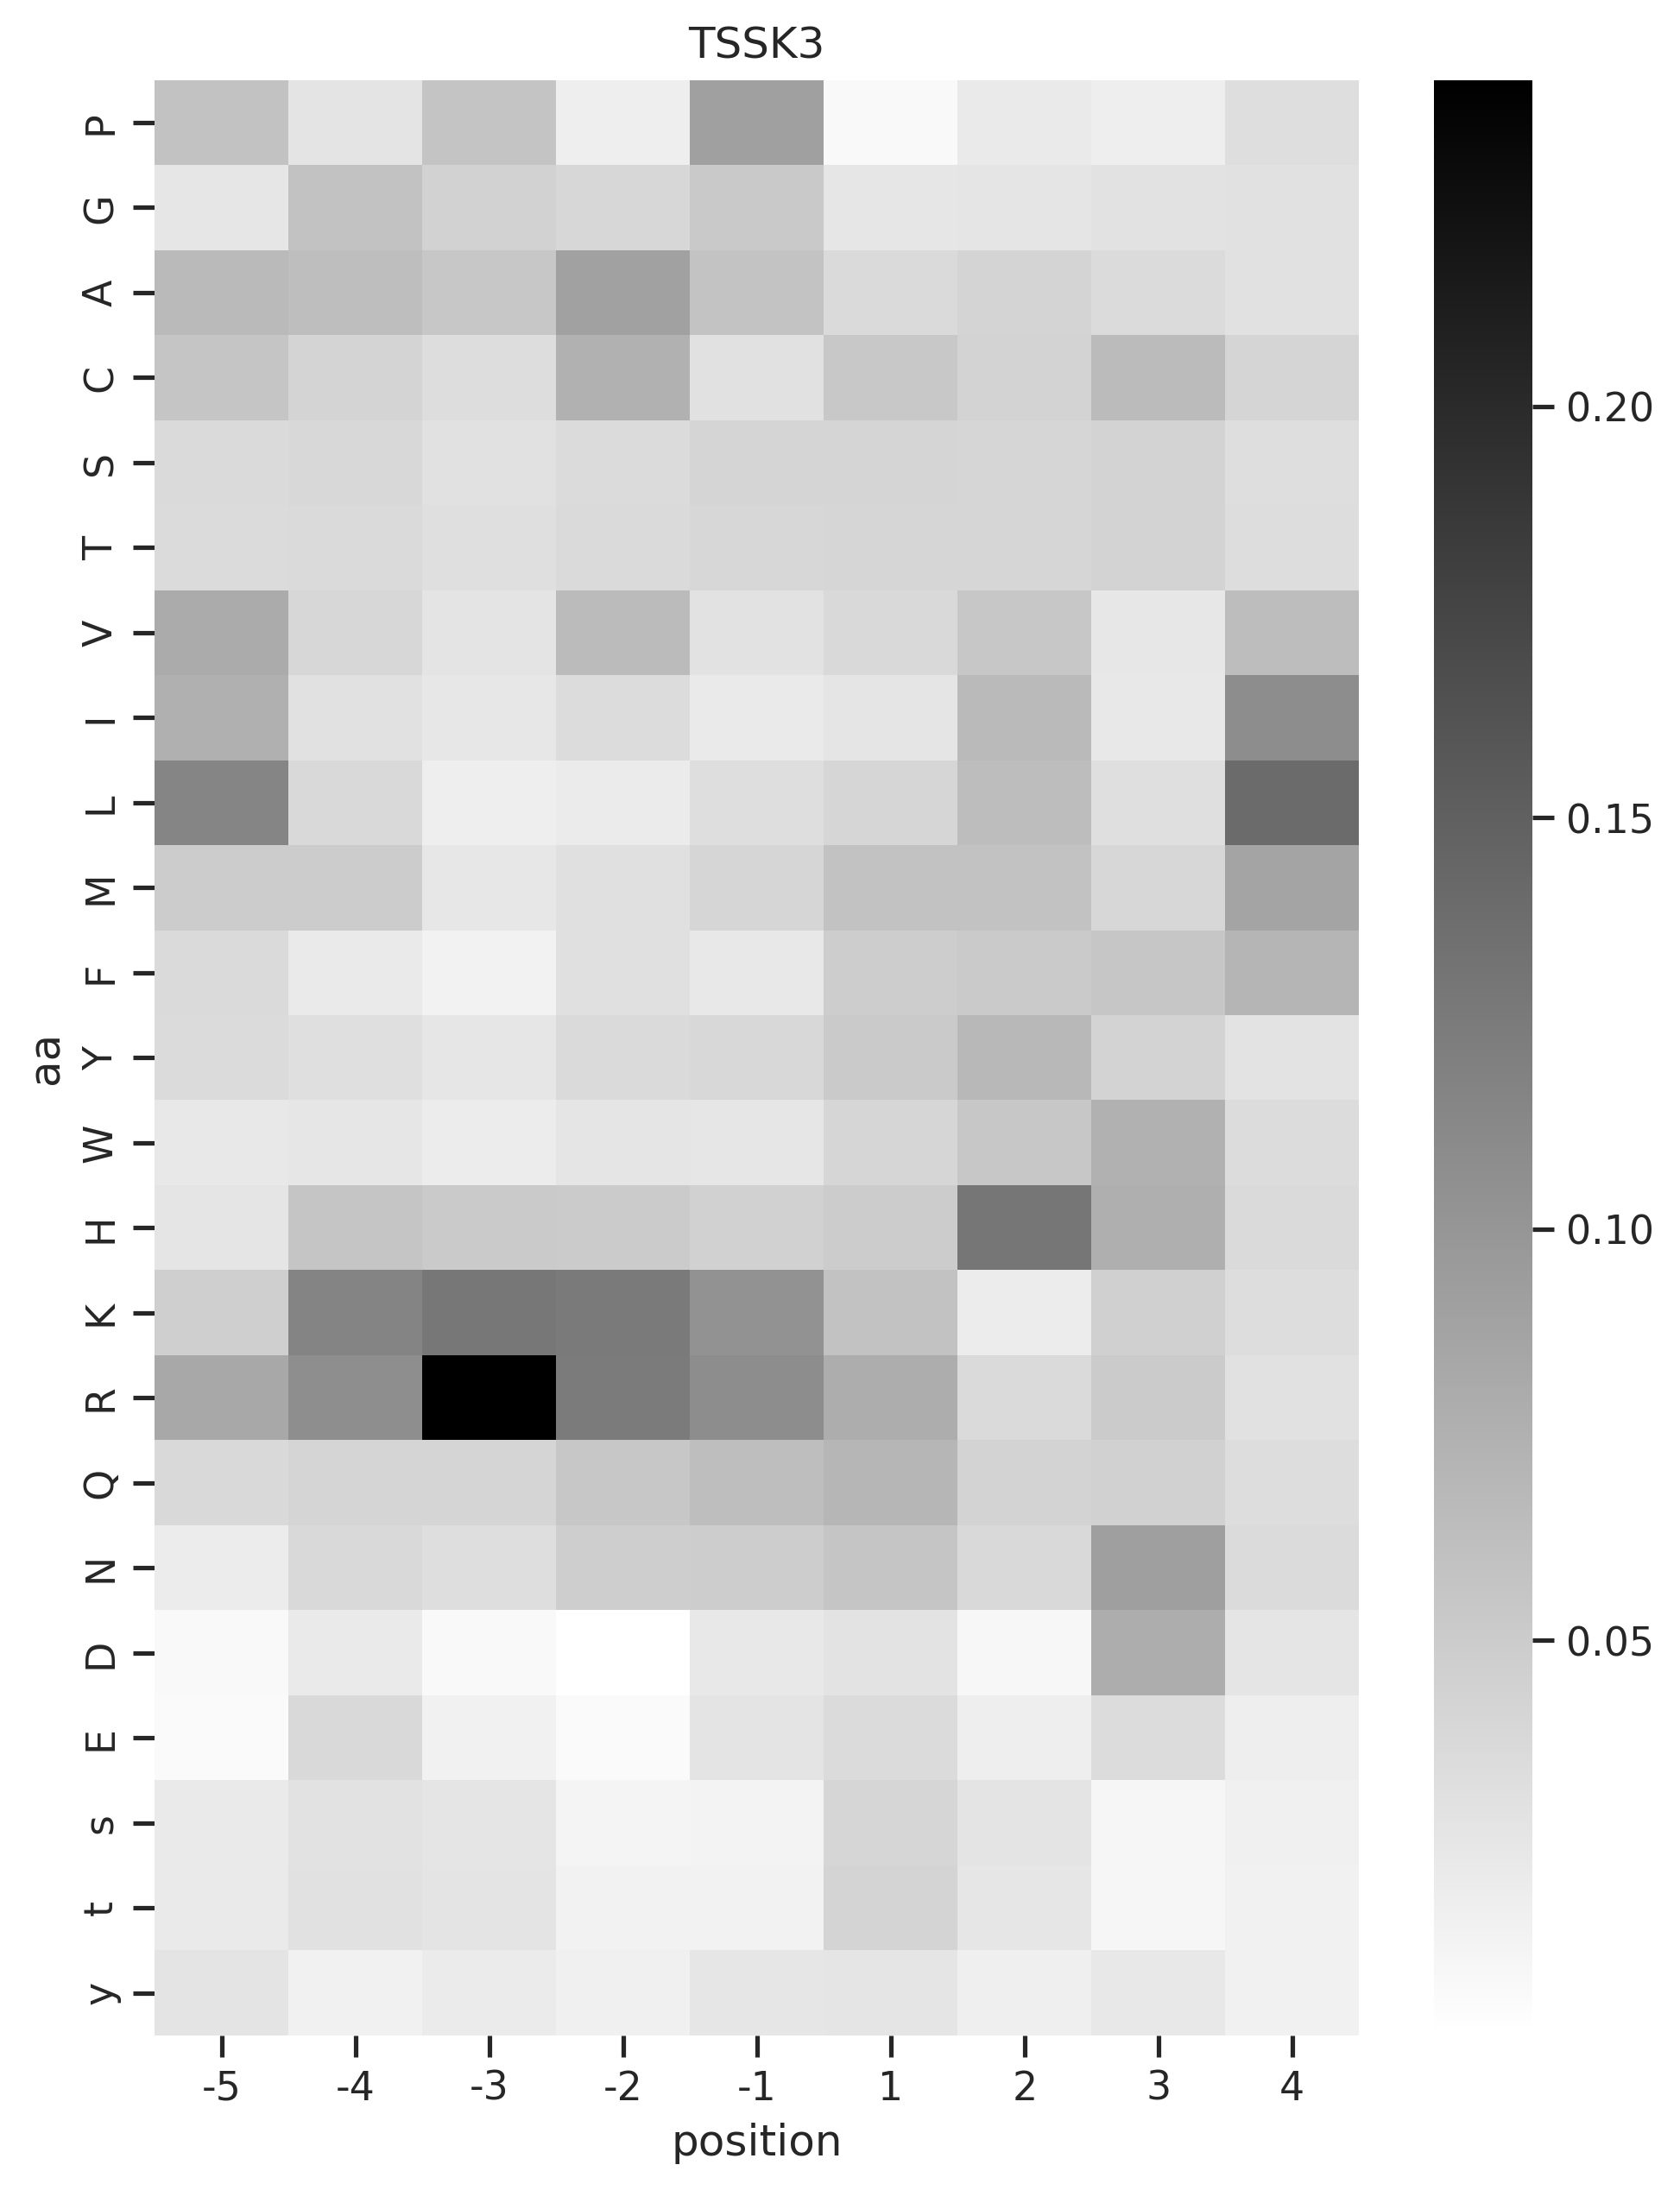

YANK:0.8166840920260132


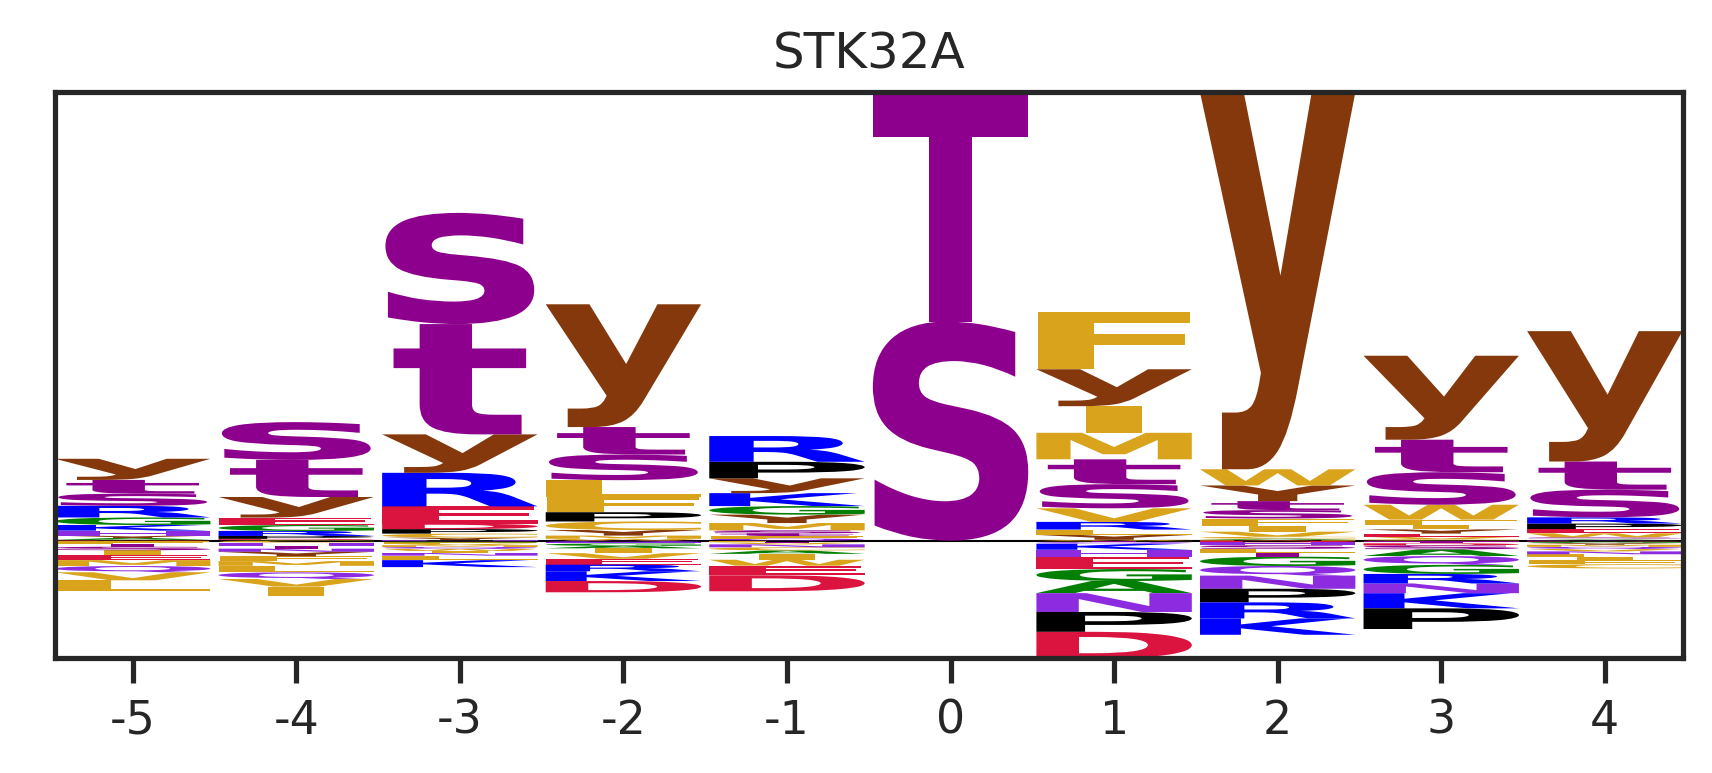

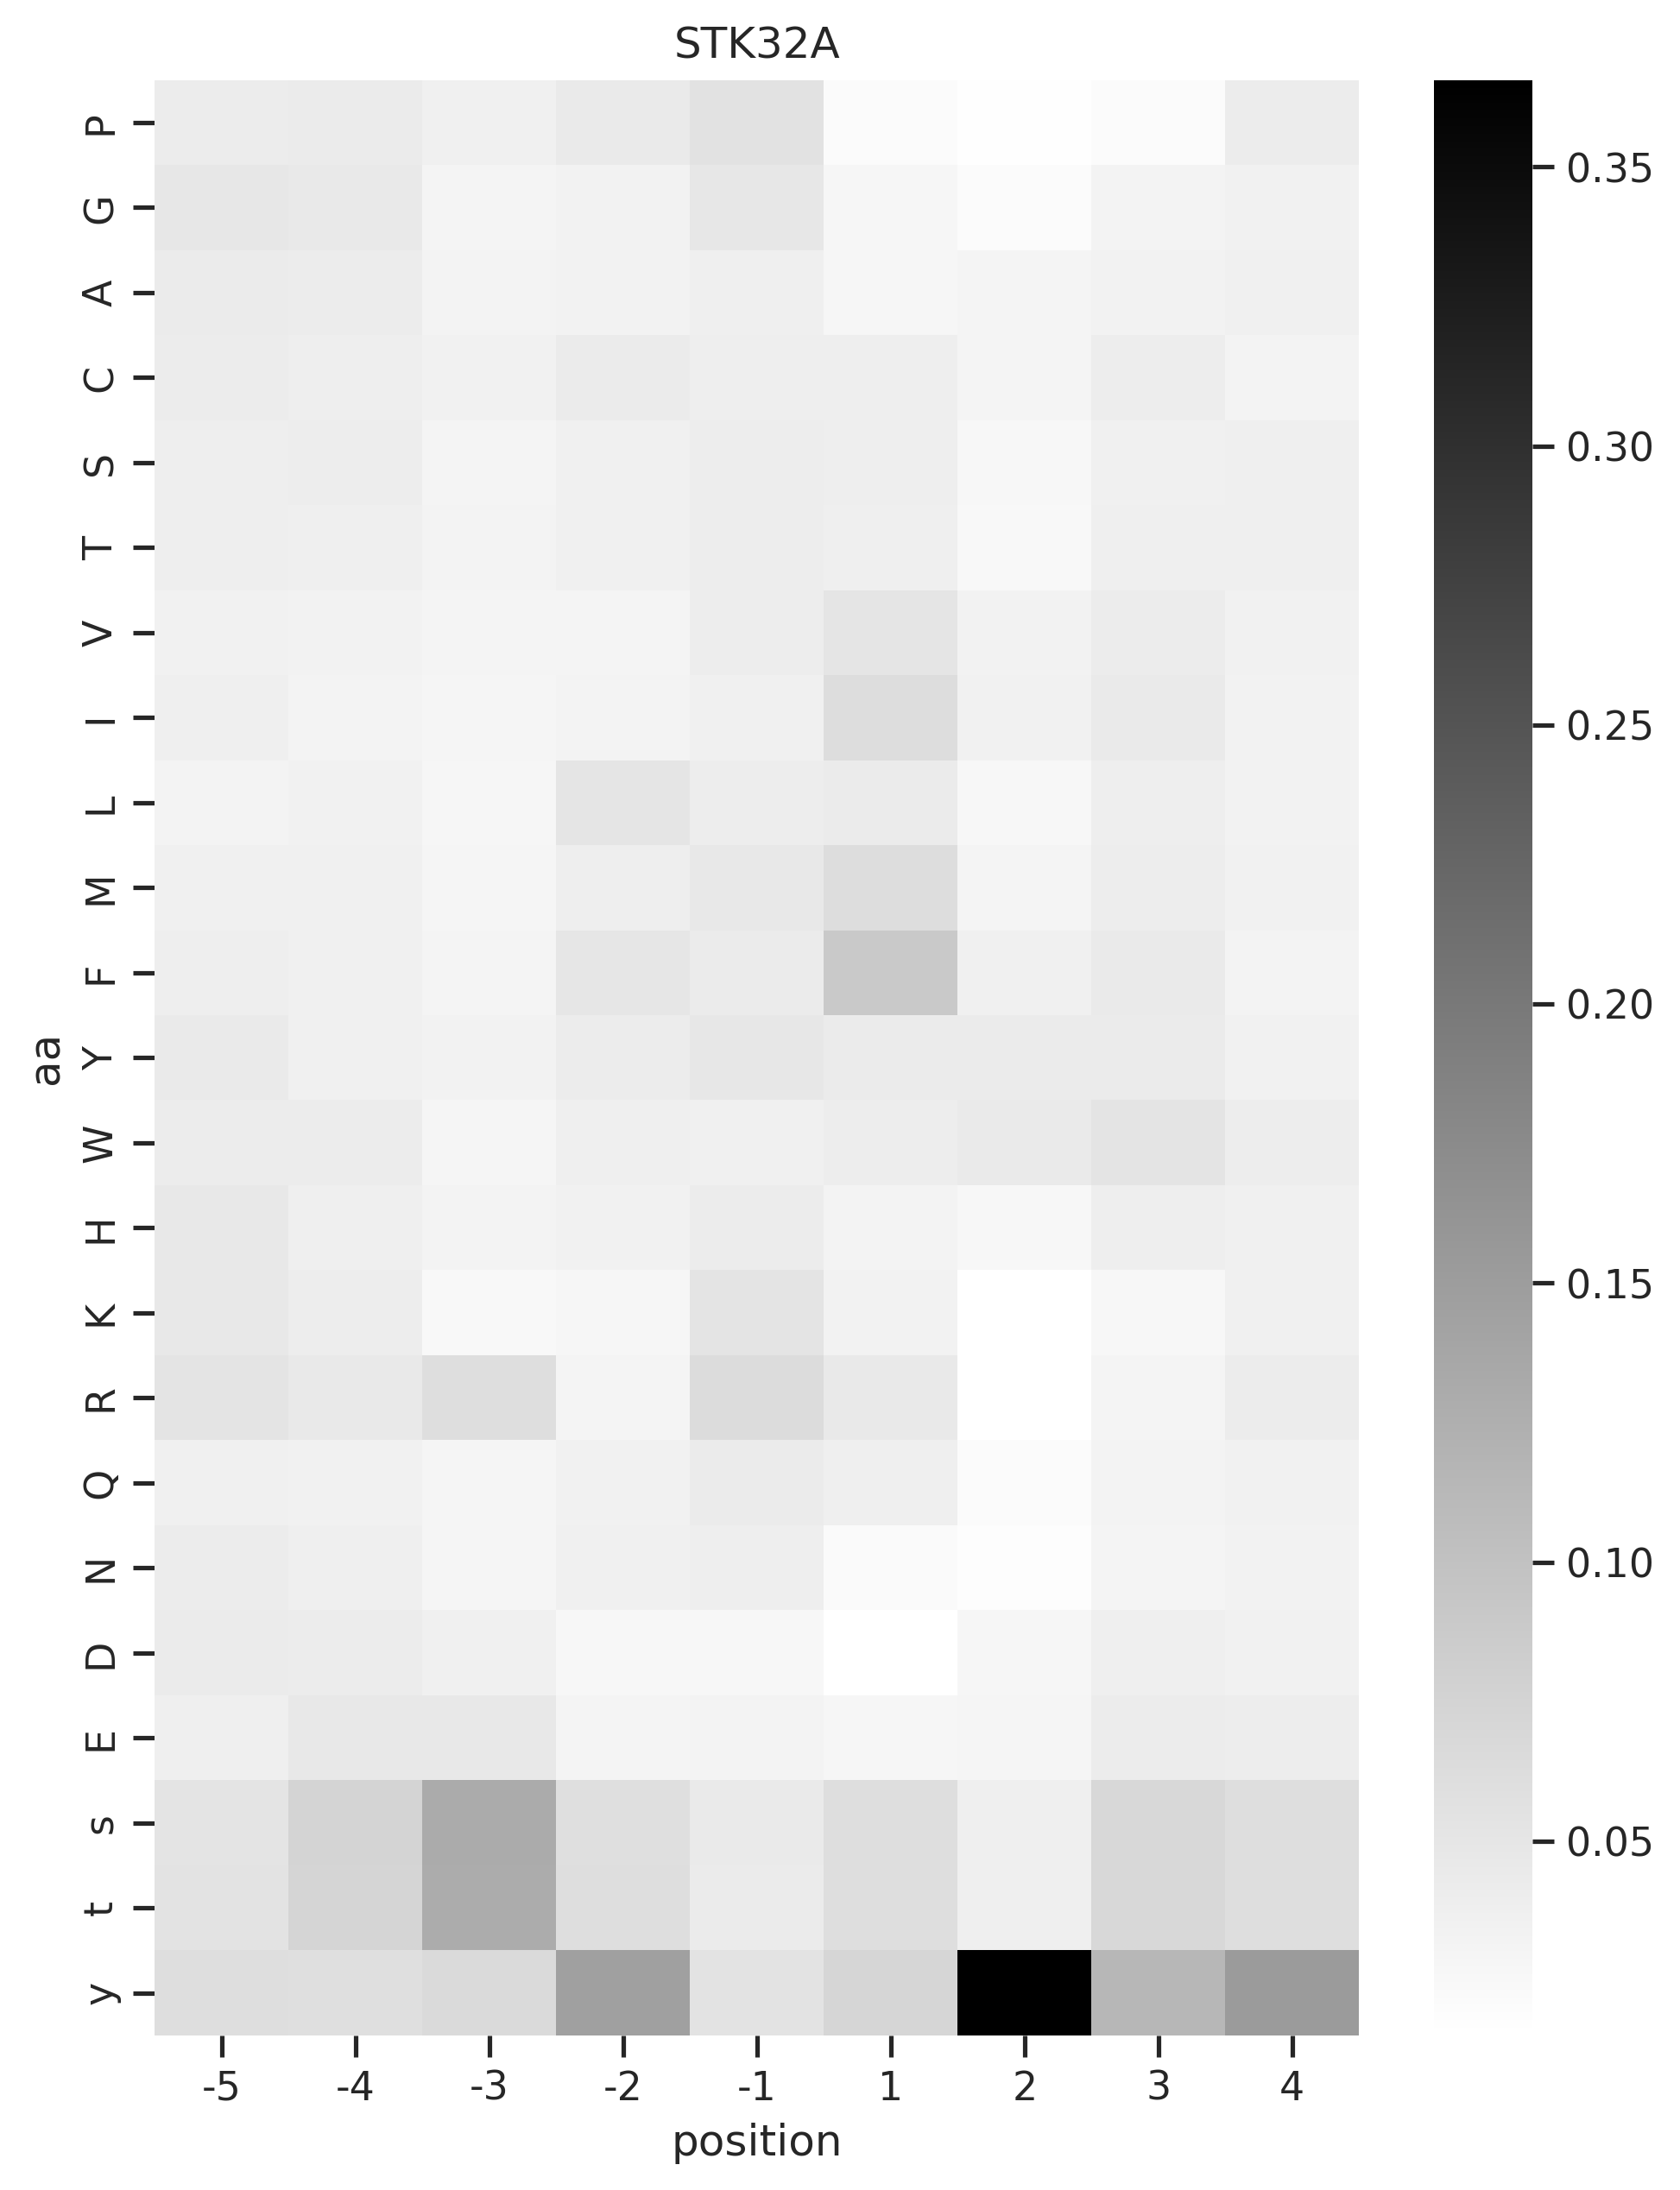

DAPK:0.7920828111362217


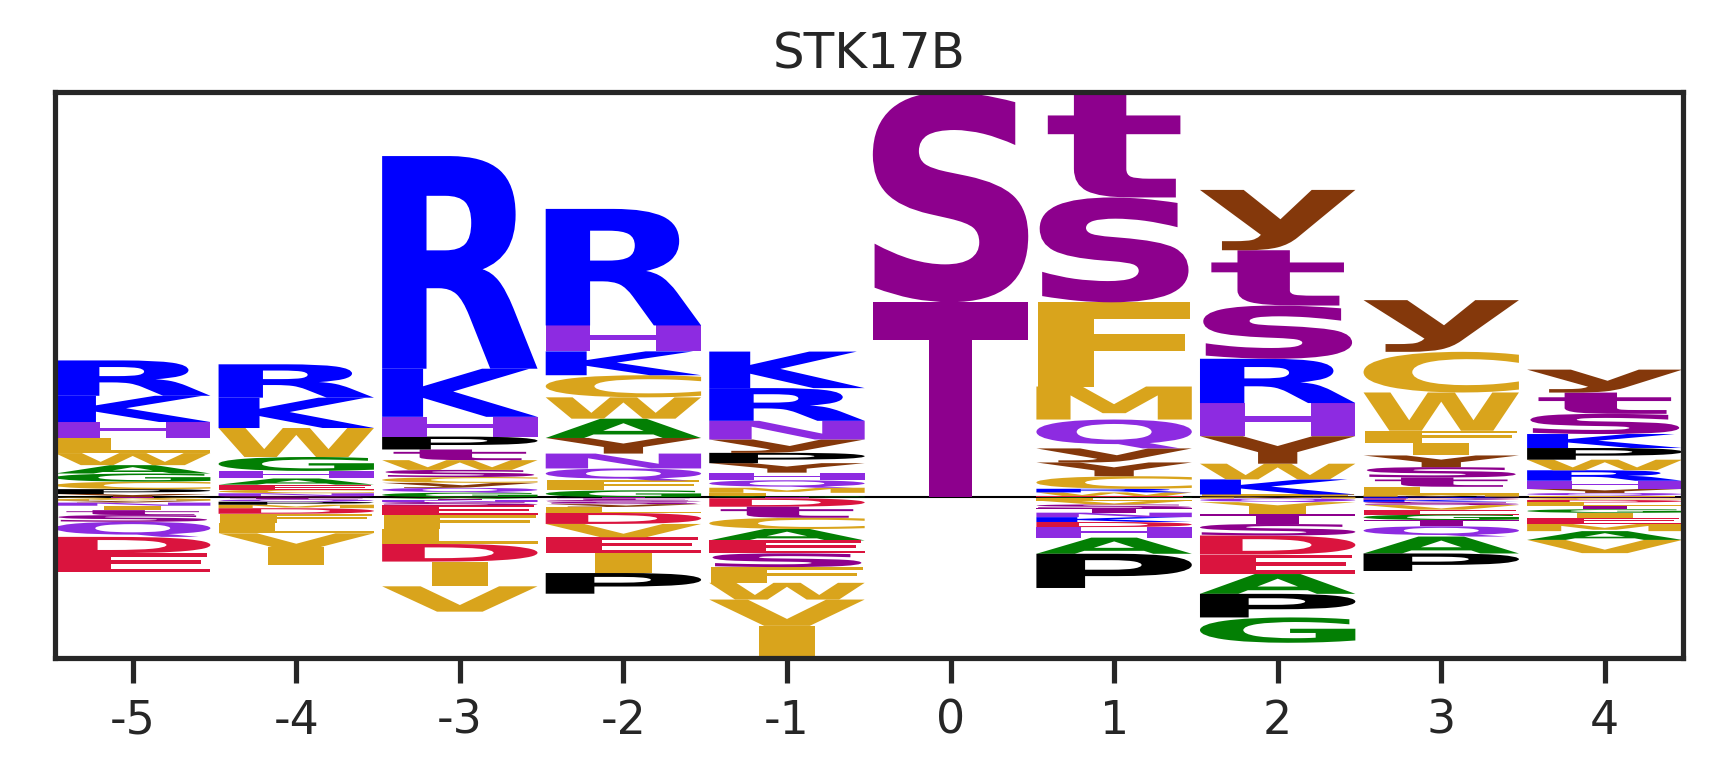

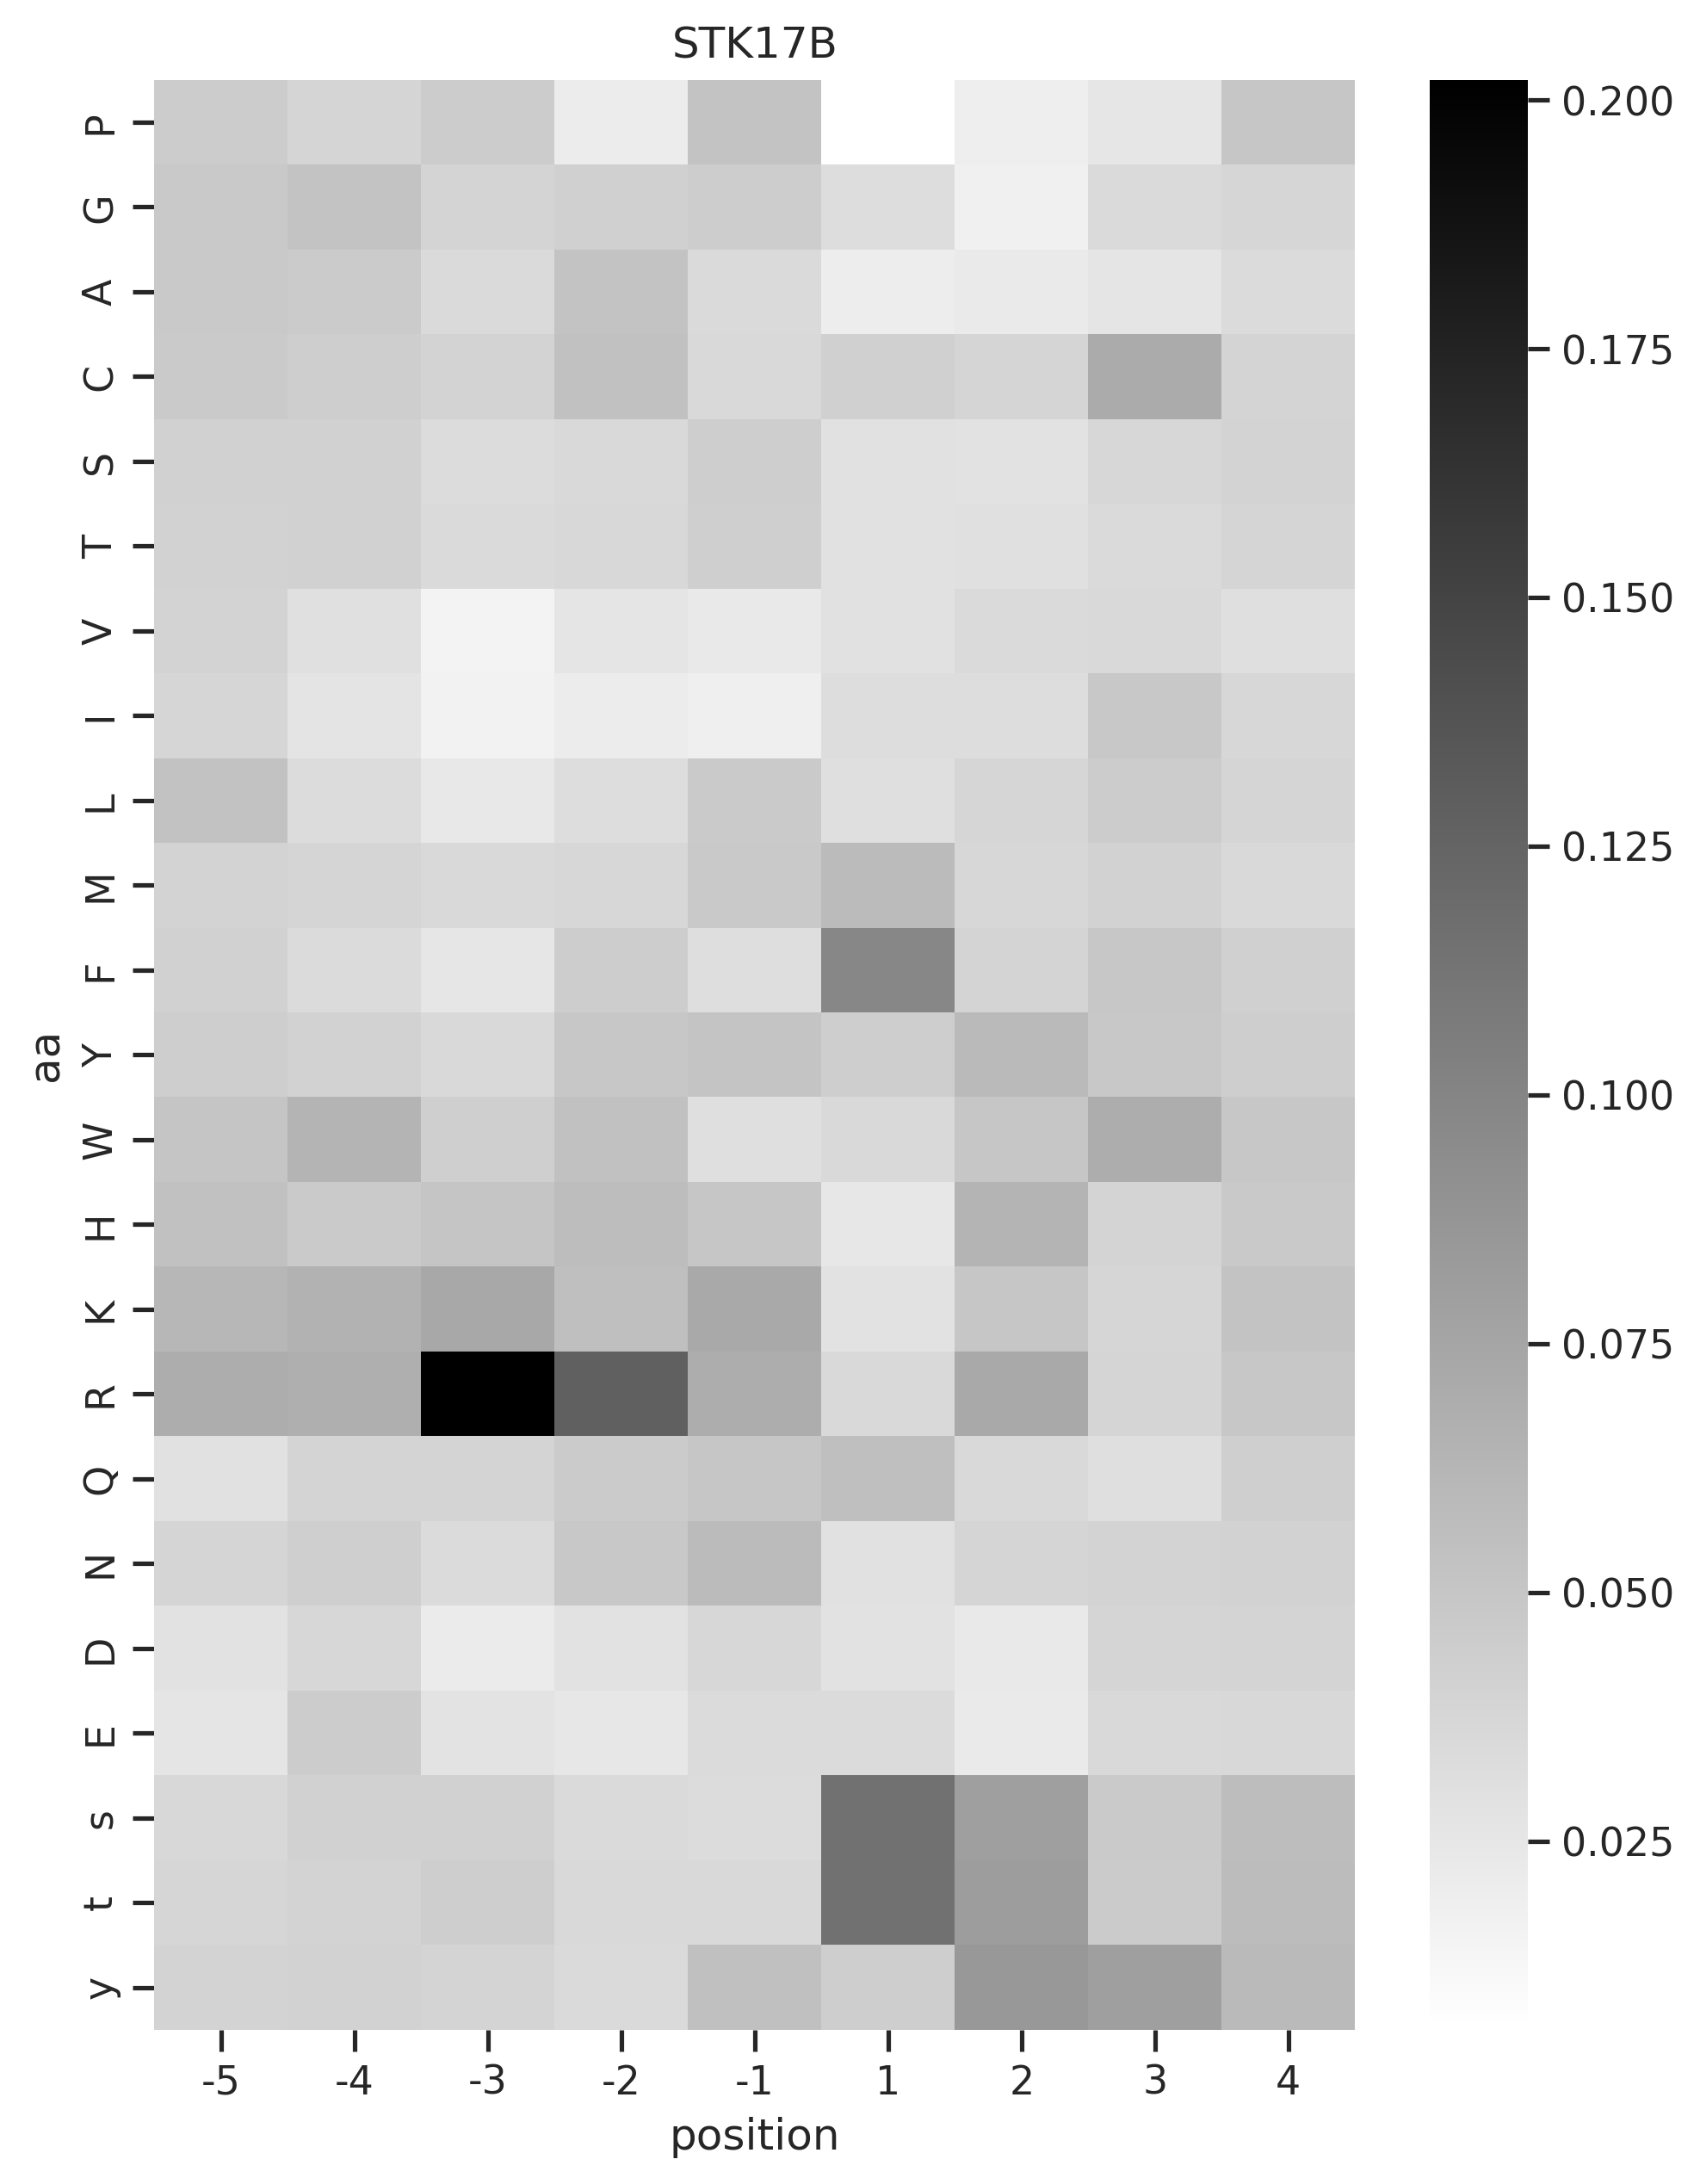

NEK:0.7782348100131159


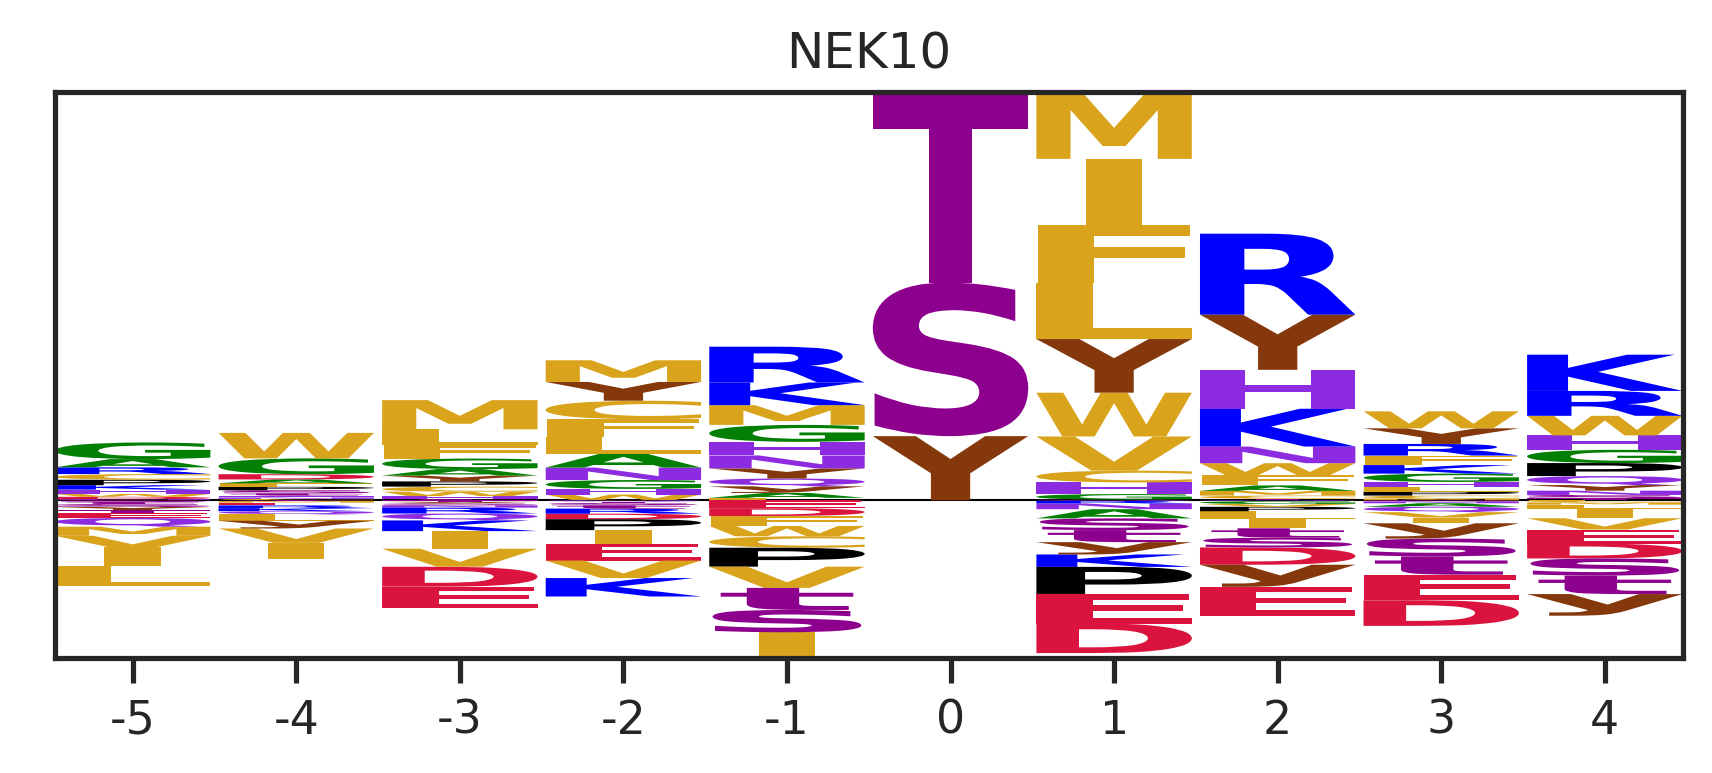

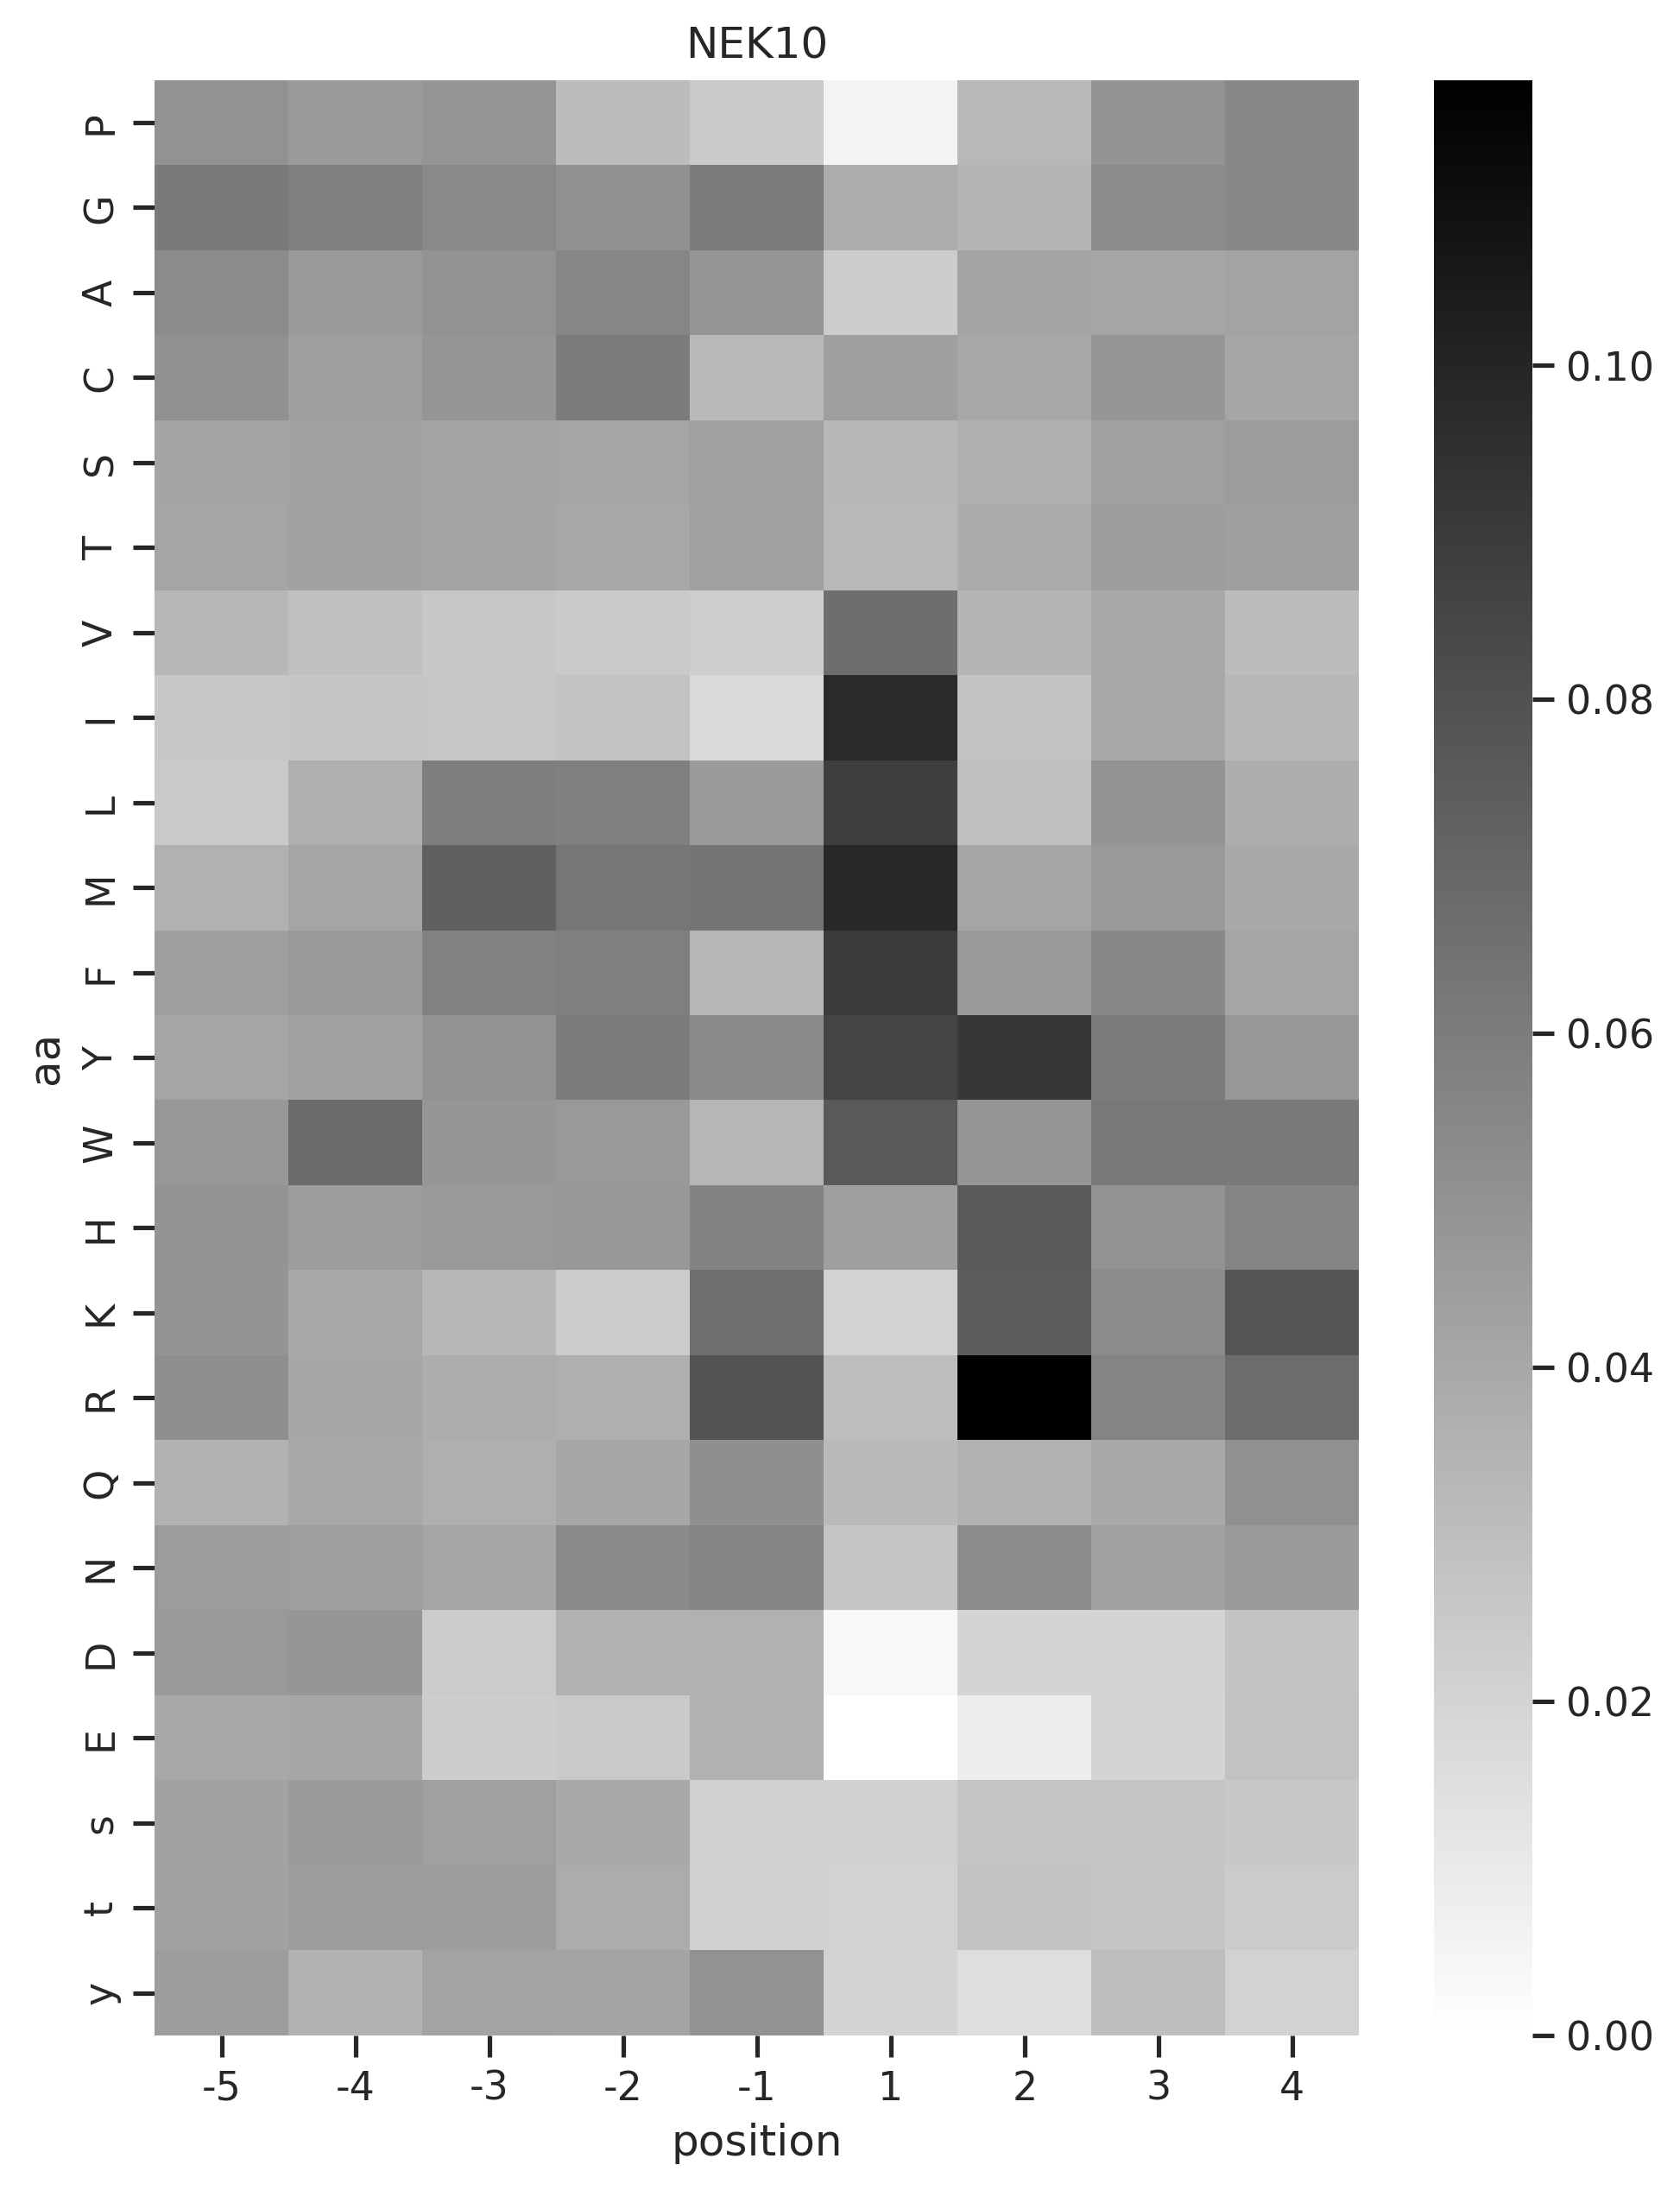

CDKL:0.76311665060942


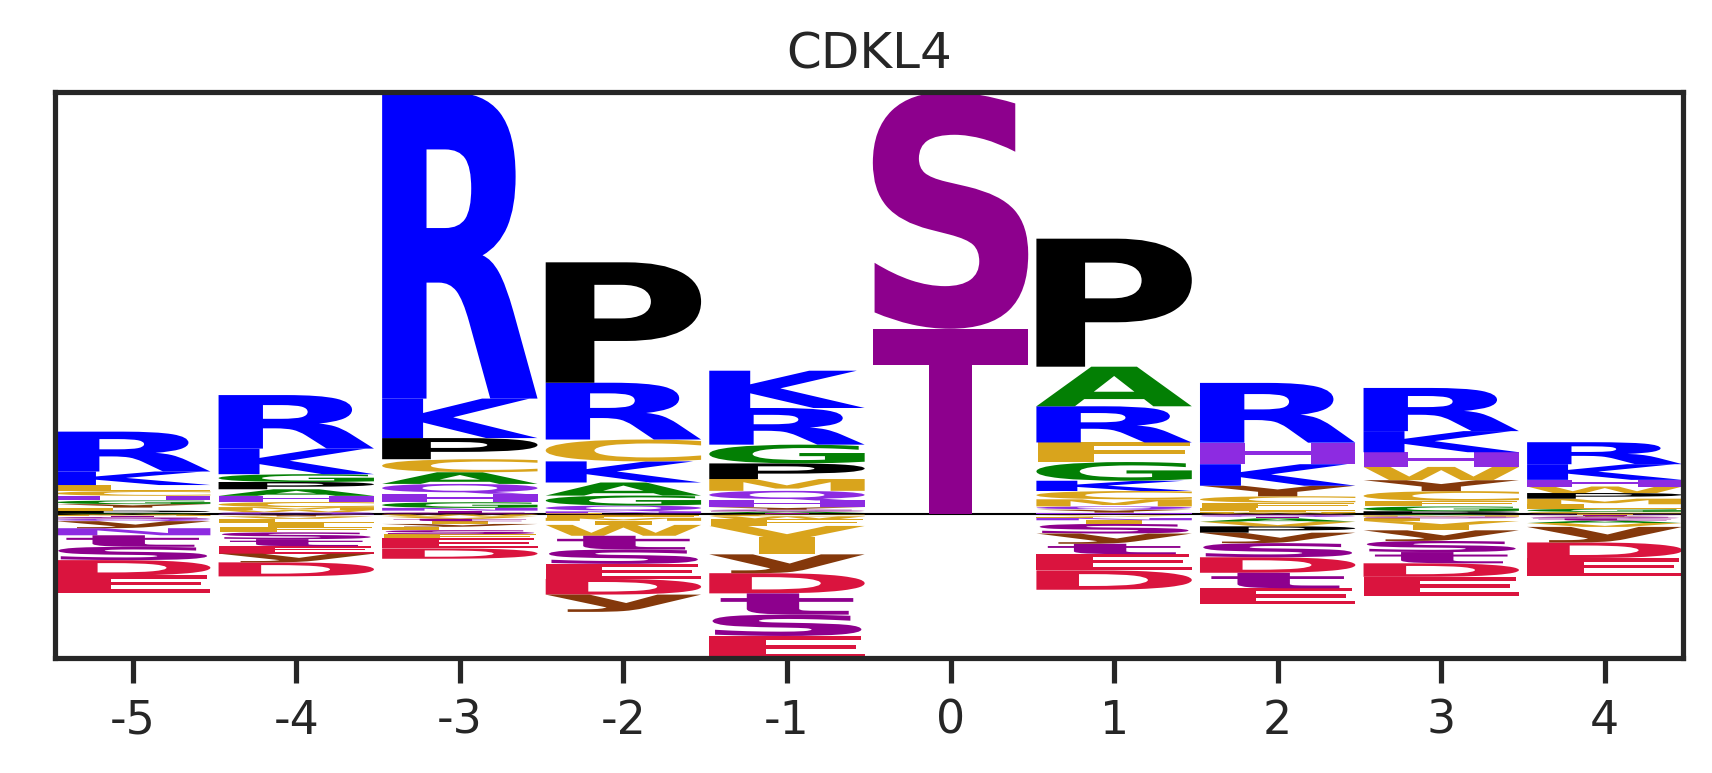

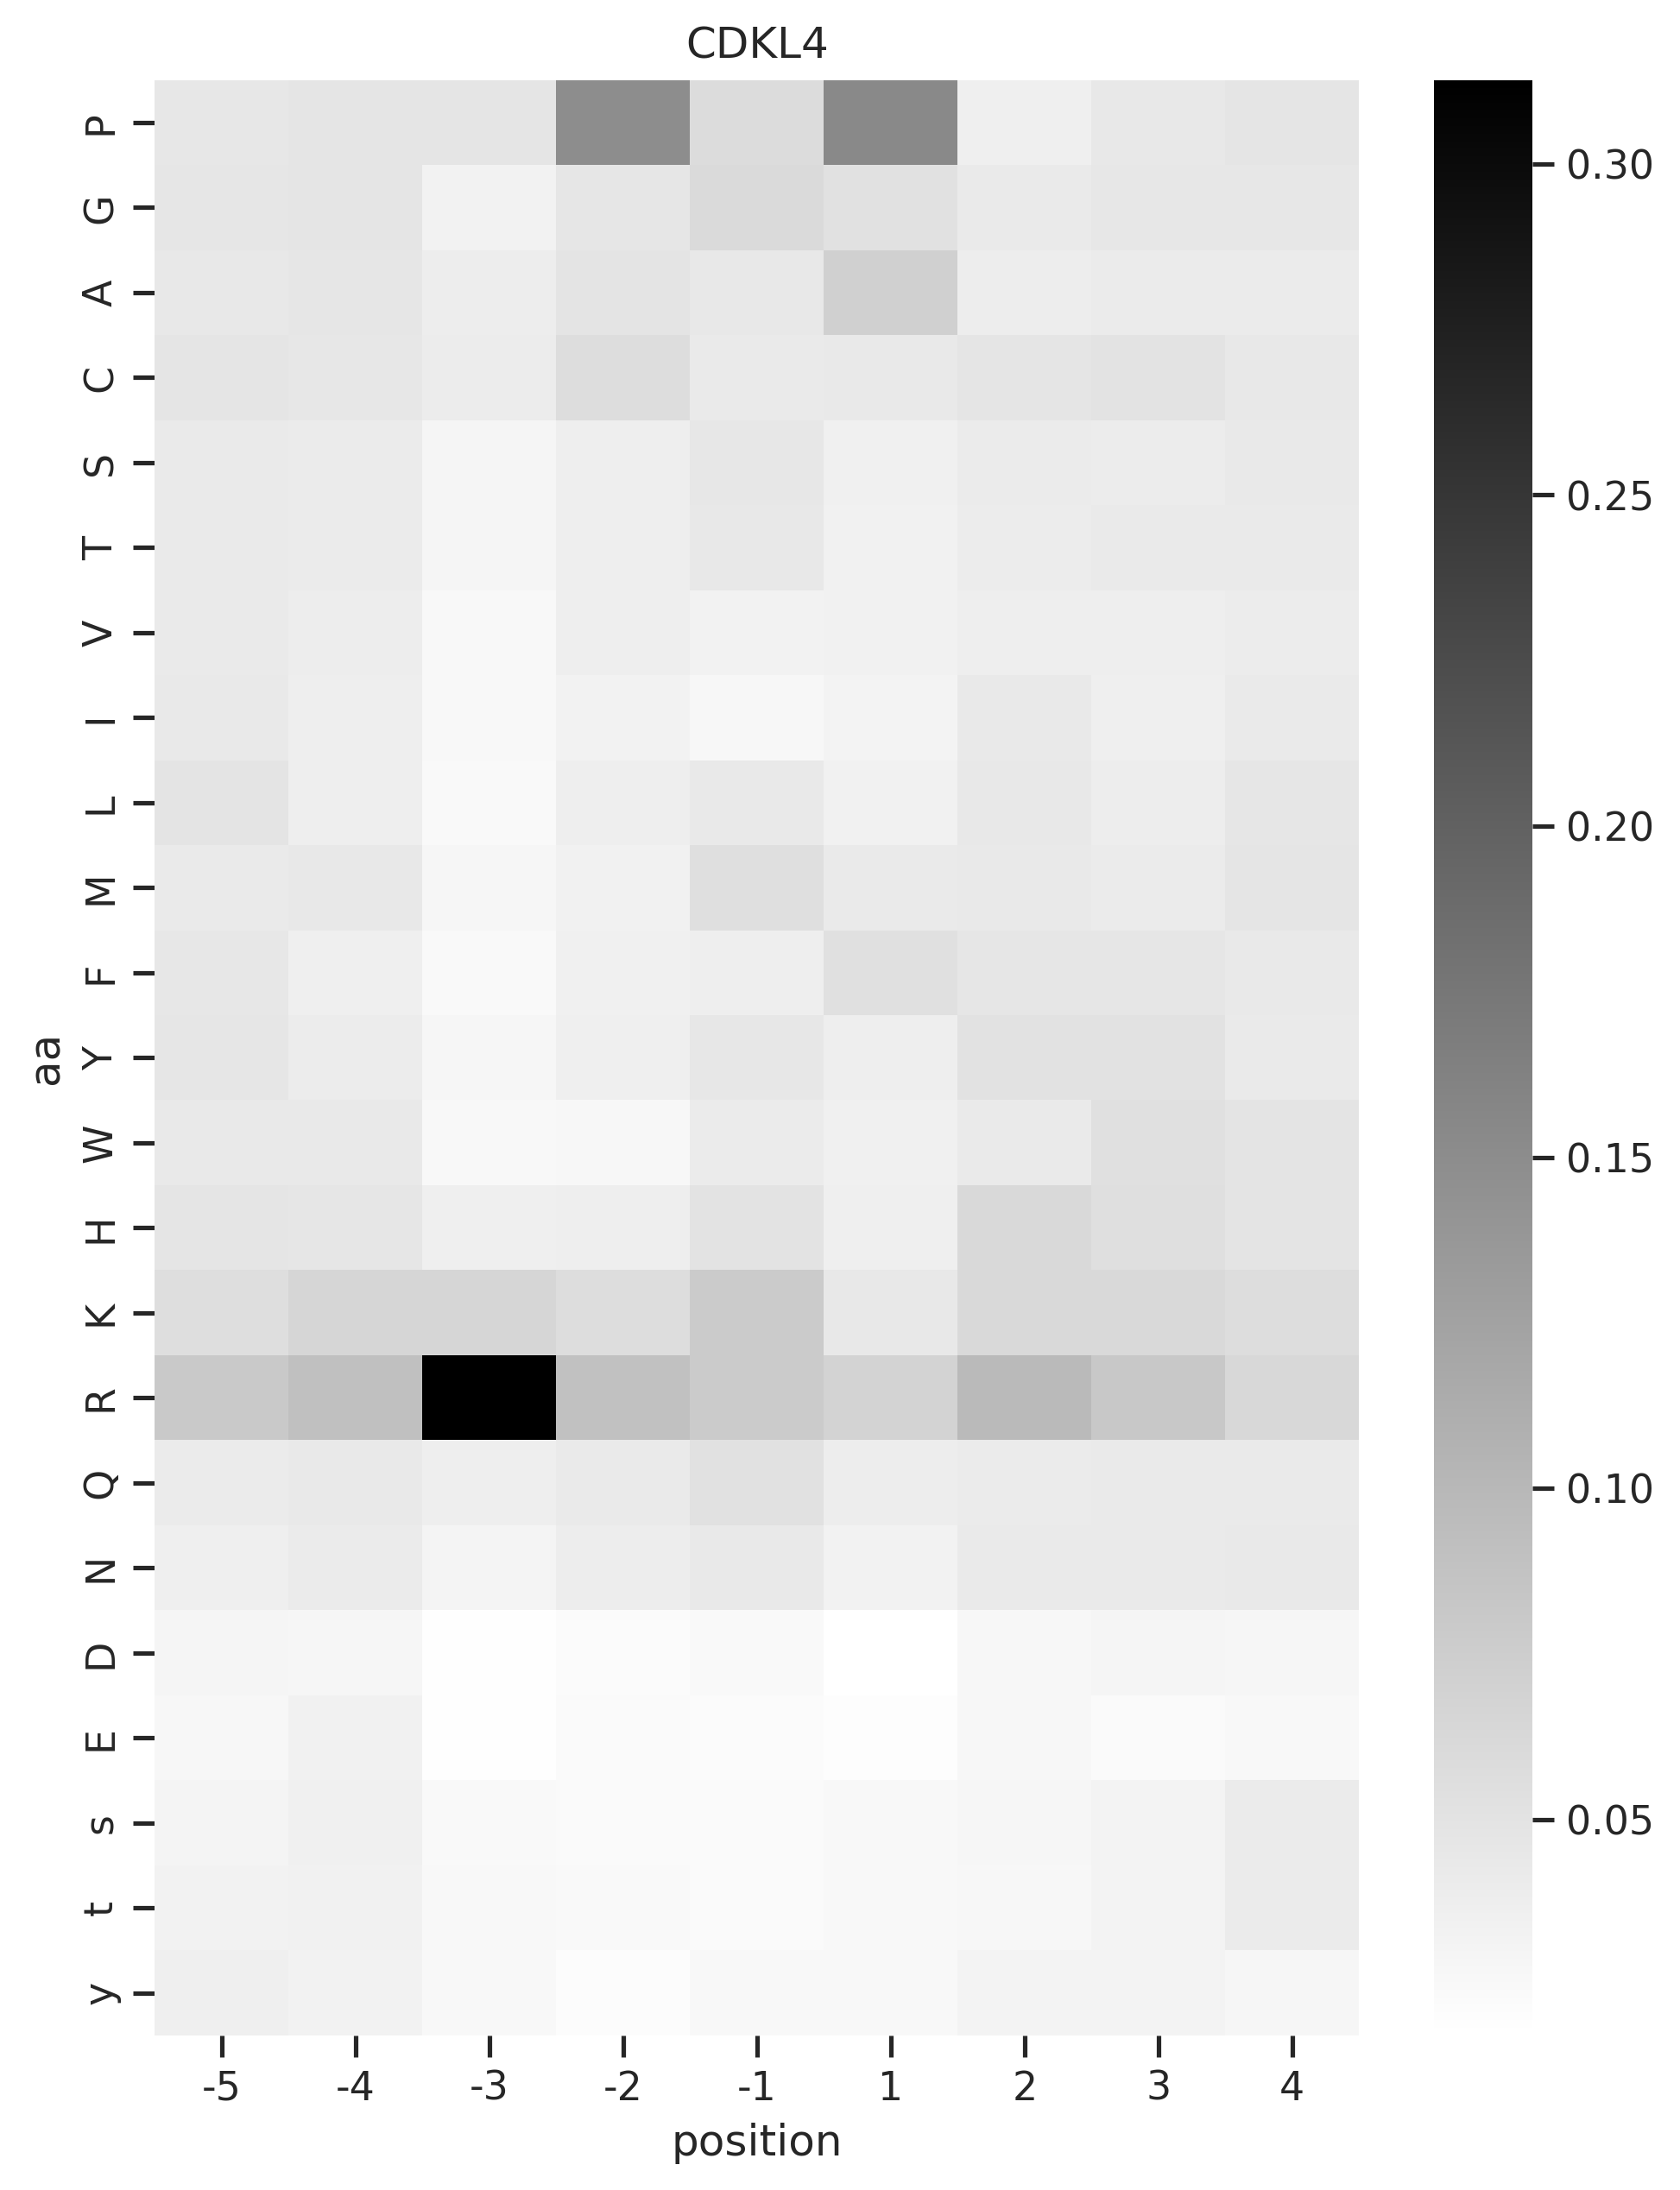

CDKL:0.76311665060942


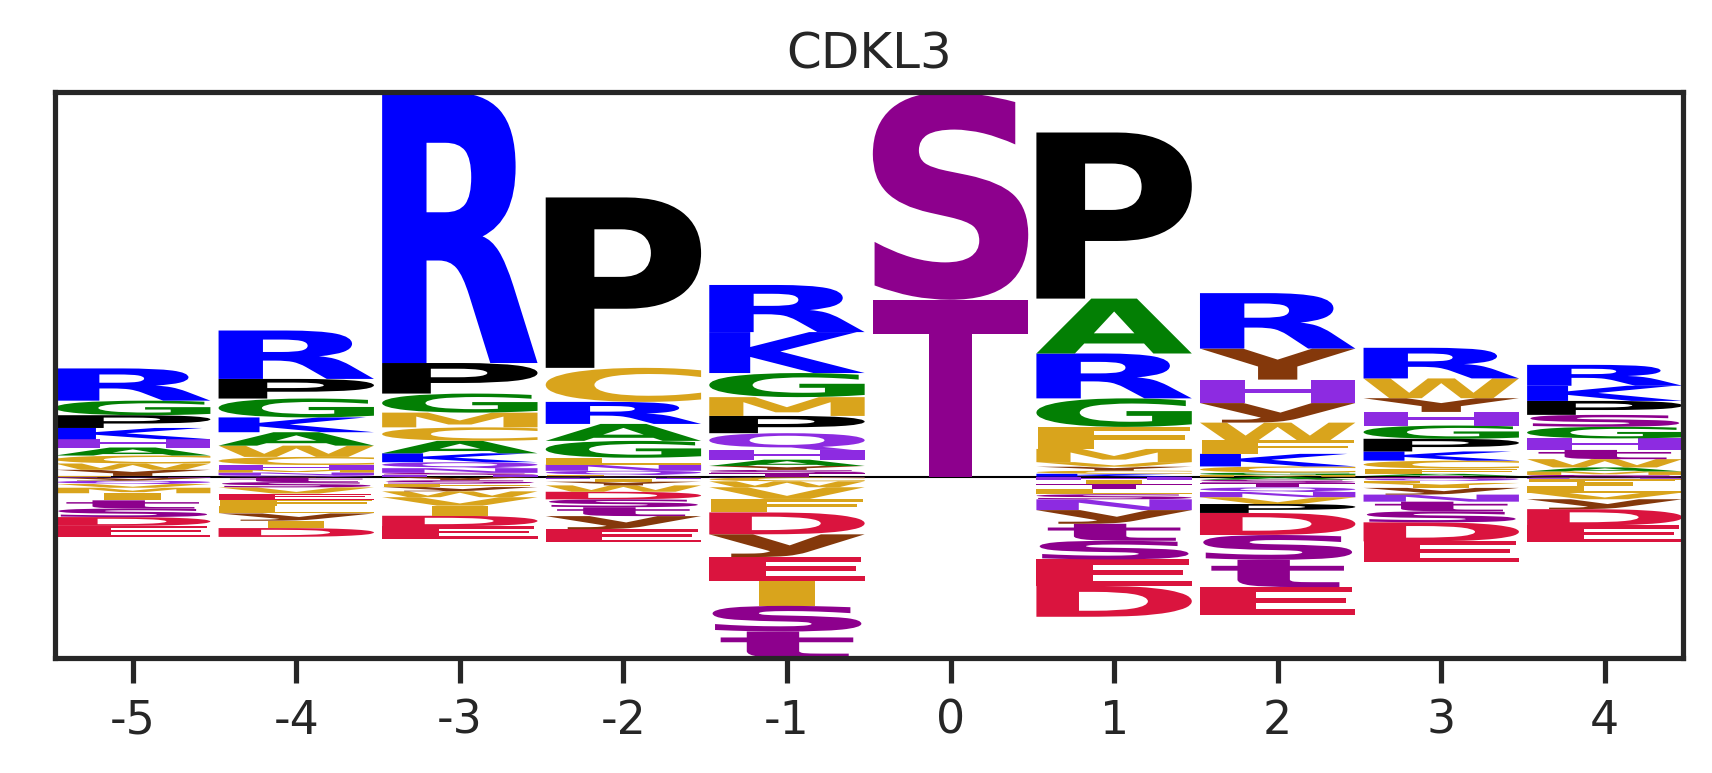

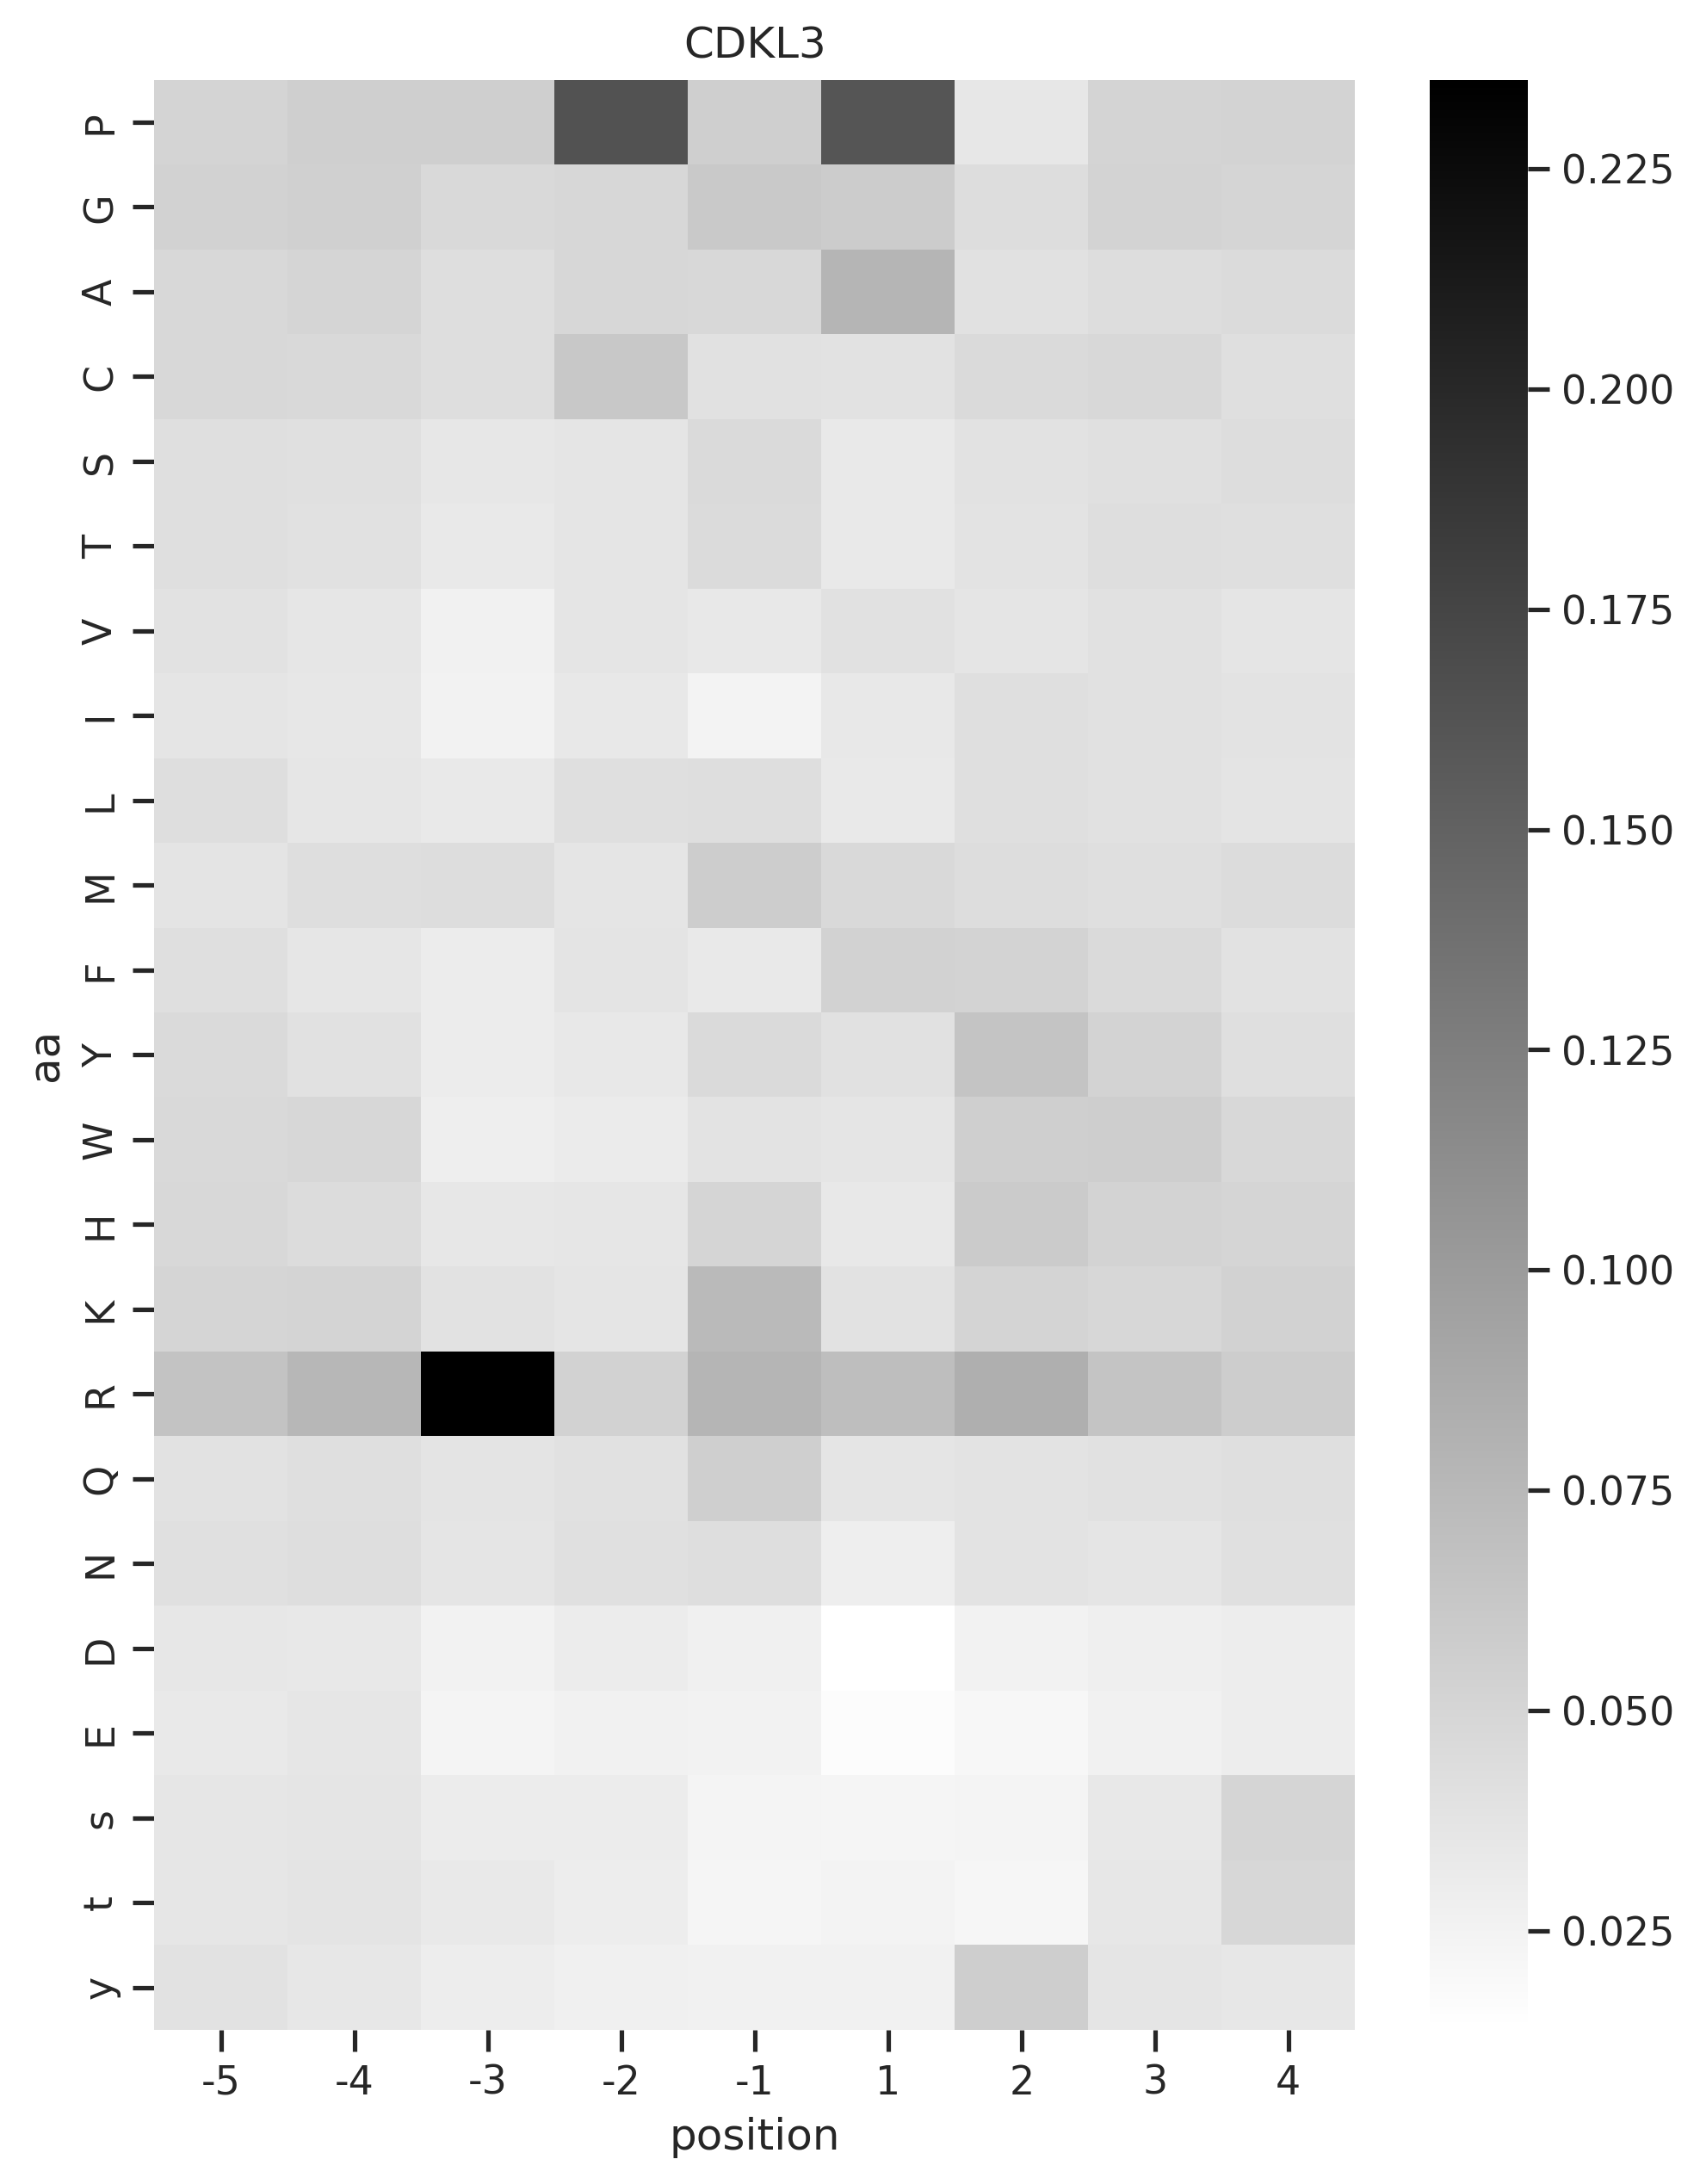

CDKL:0.76311665060942


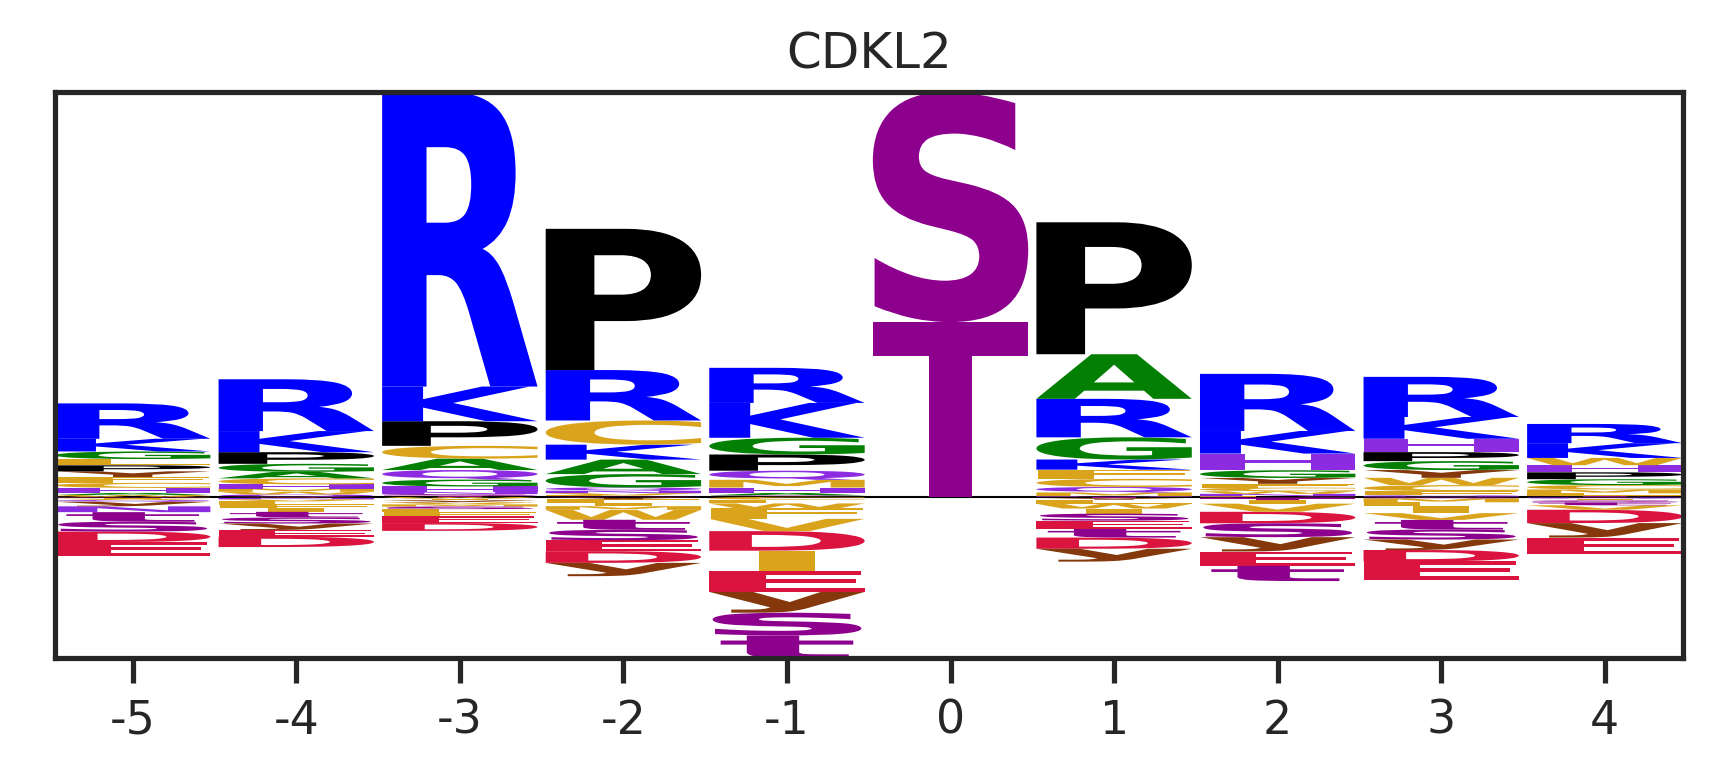

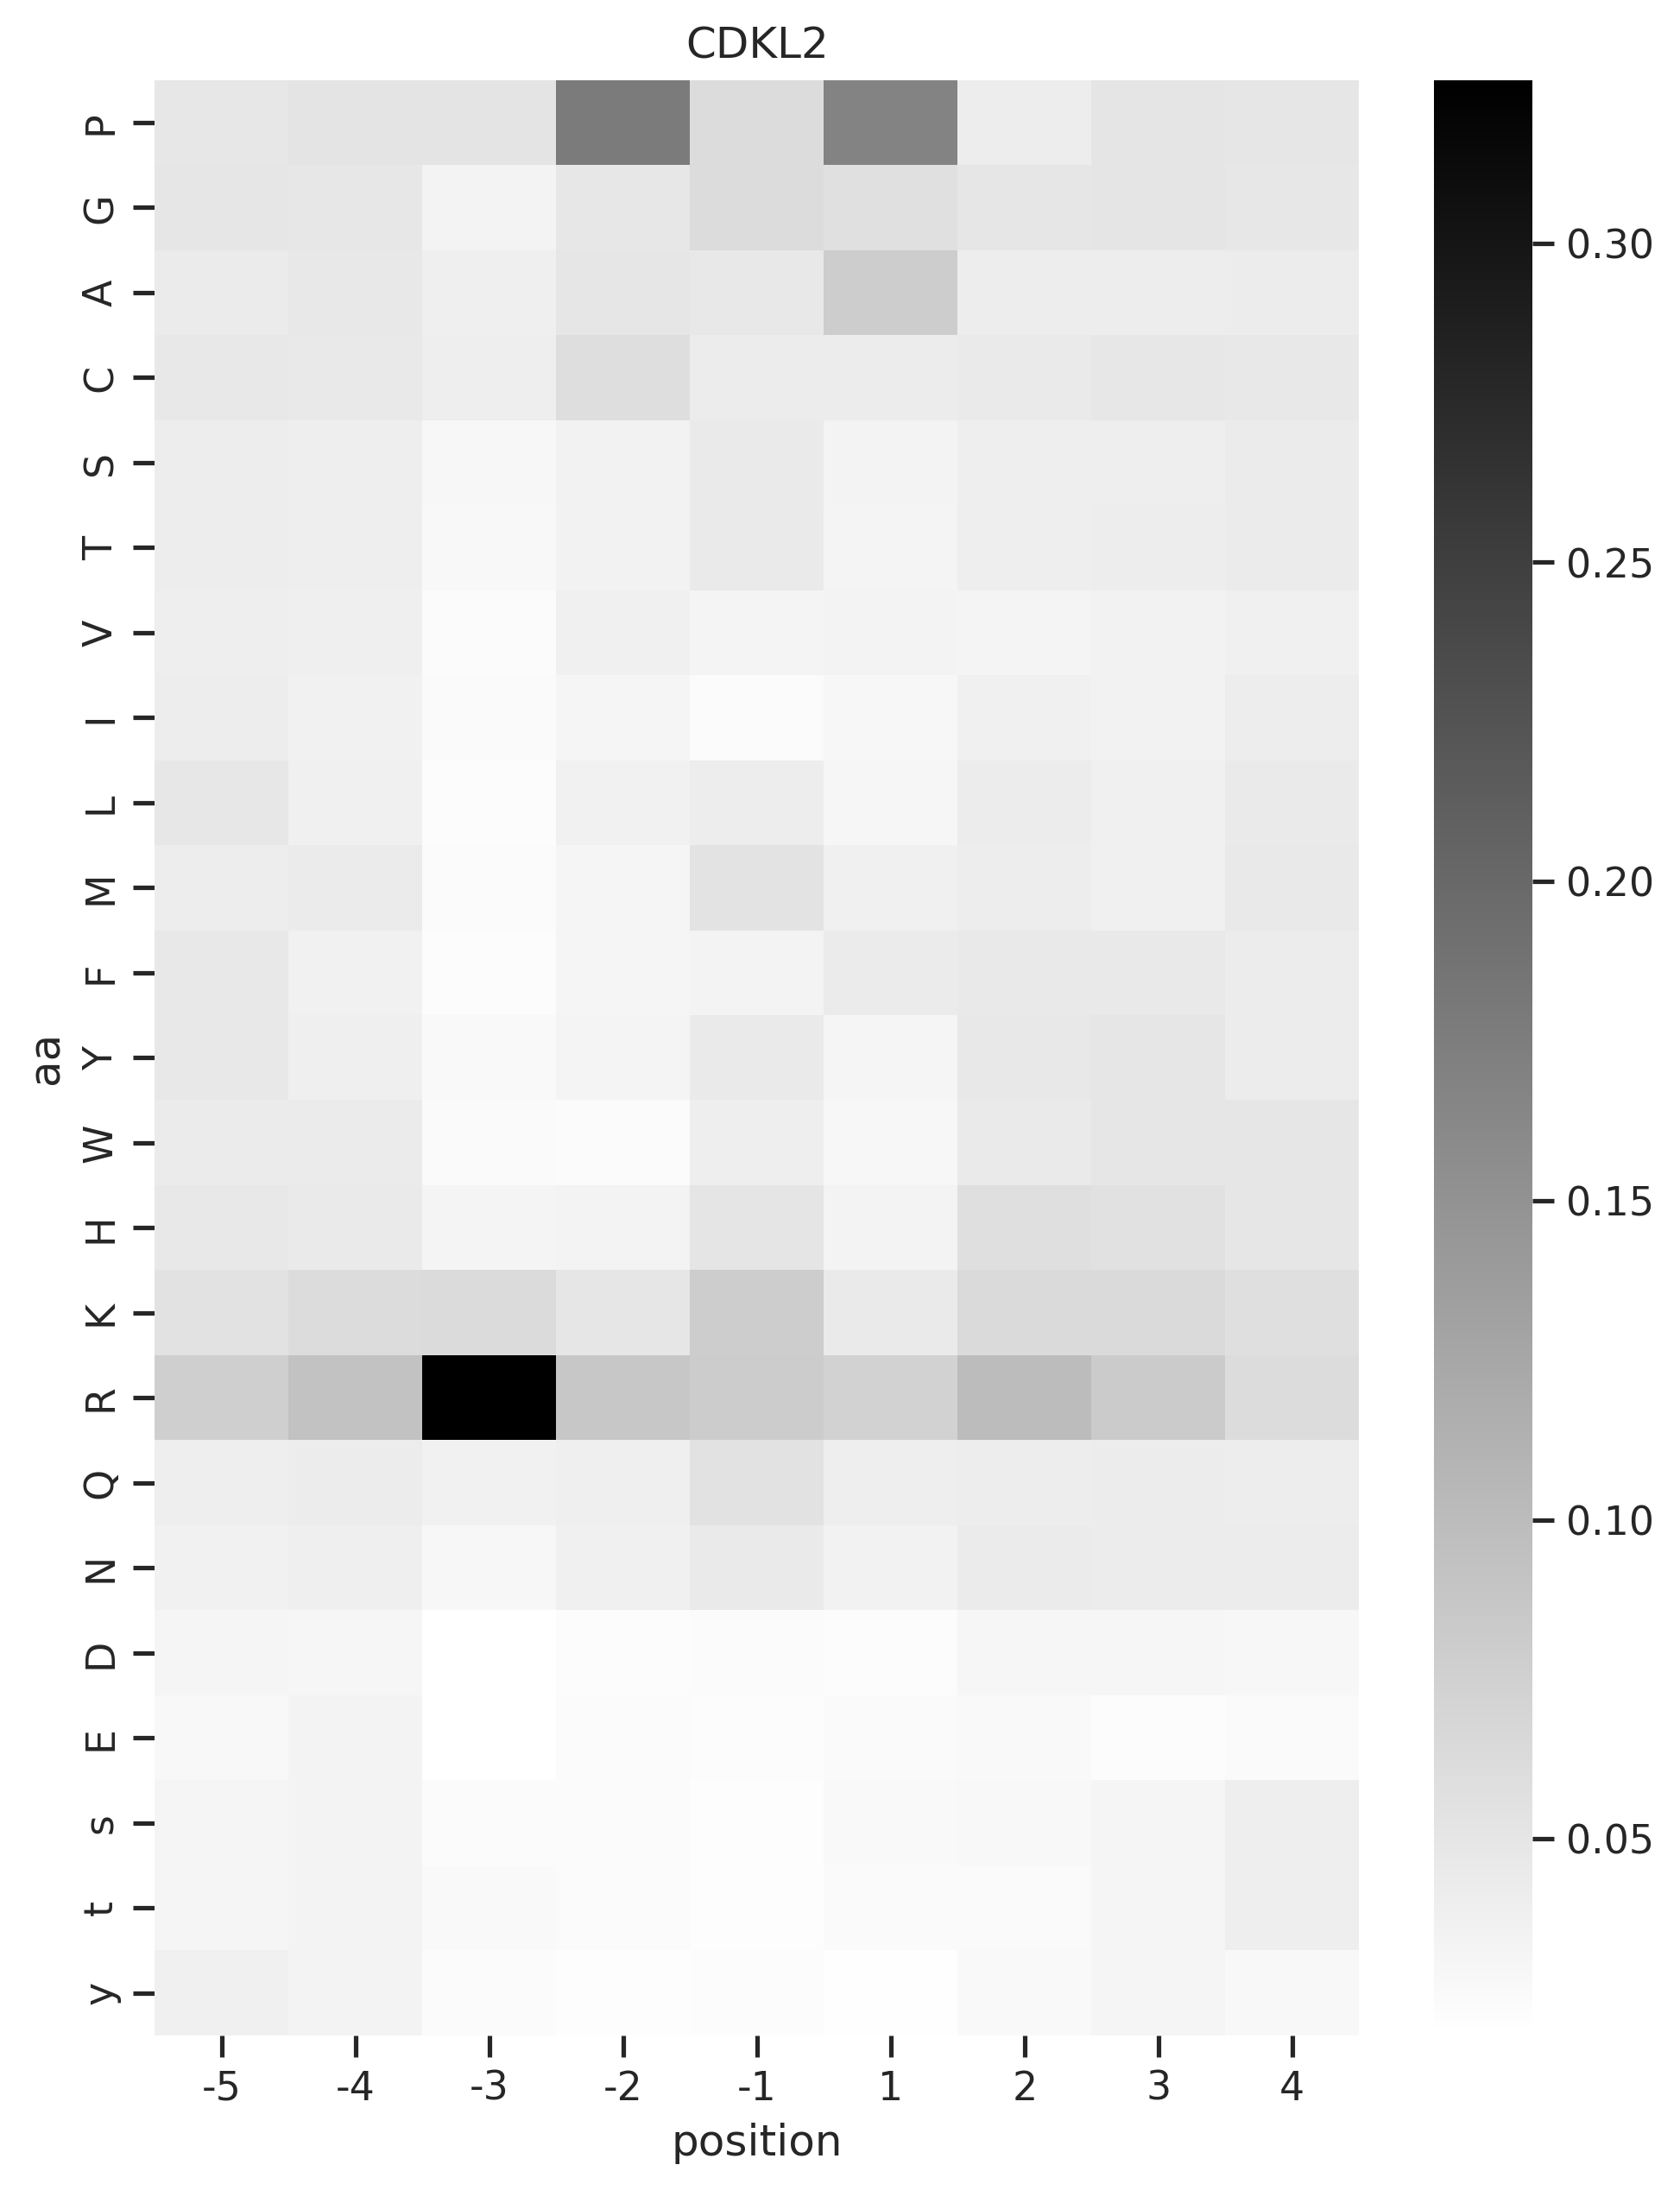

STE11:0.7499031572306992


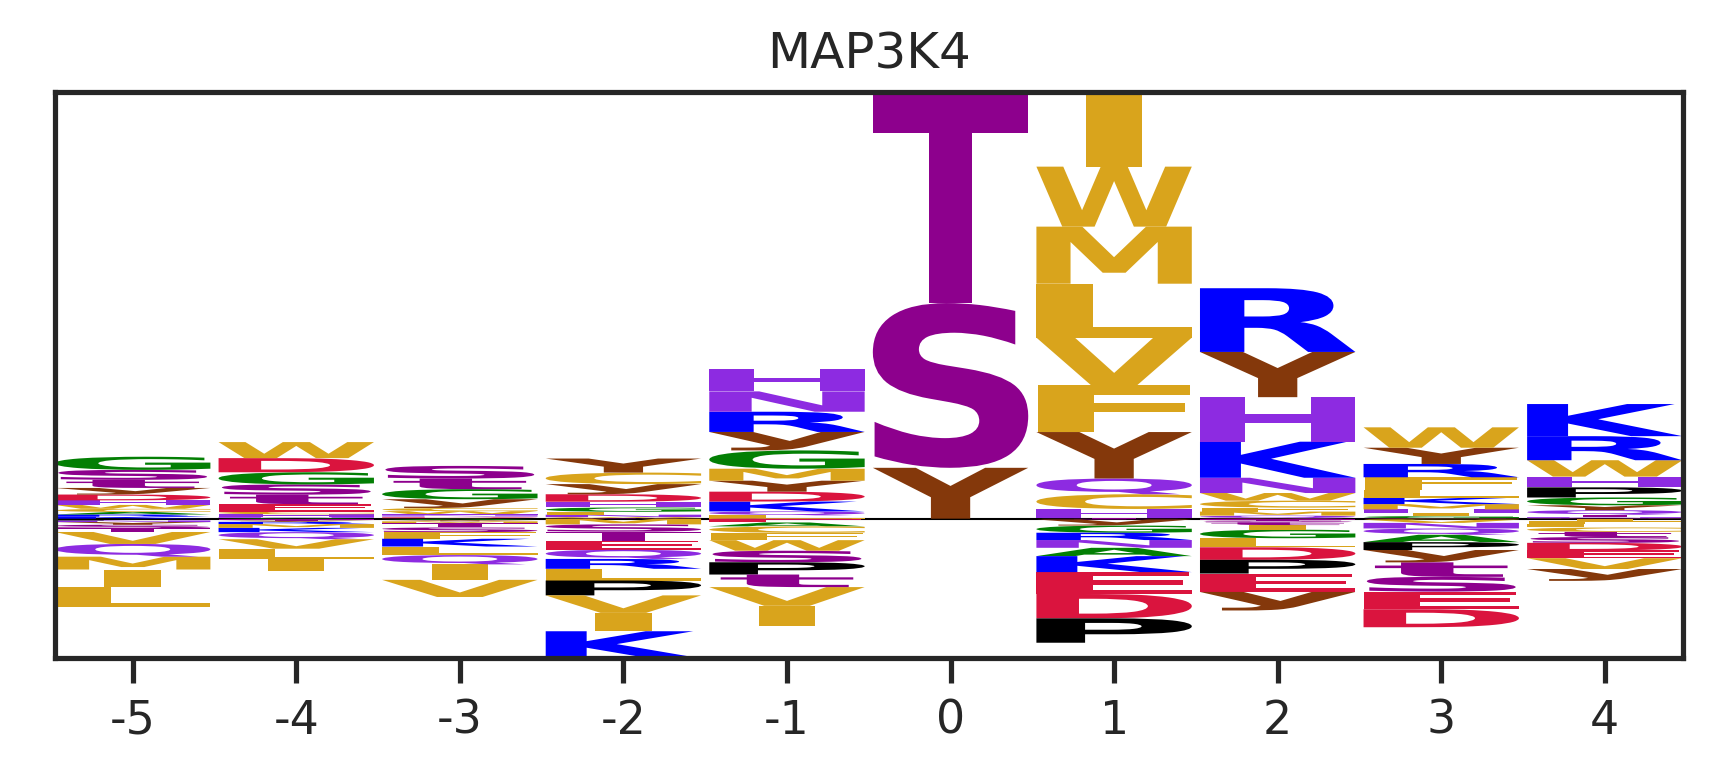

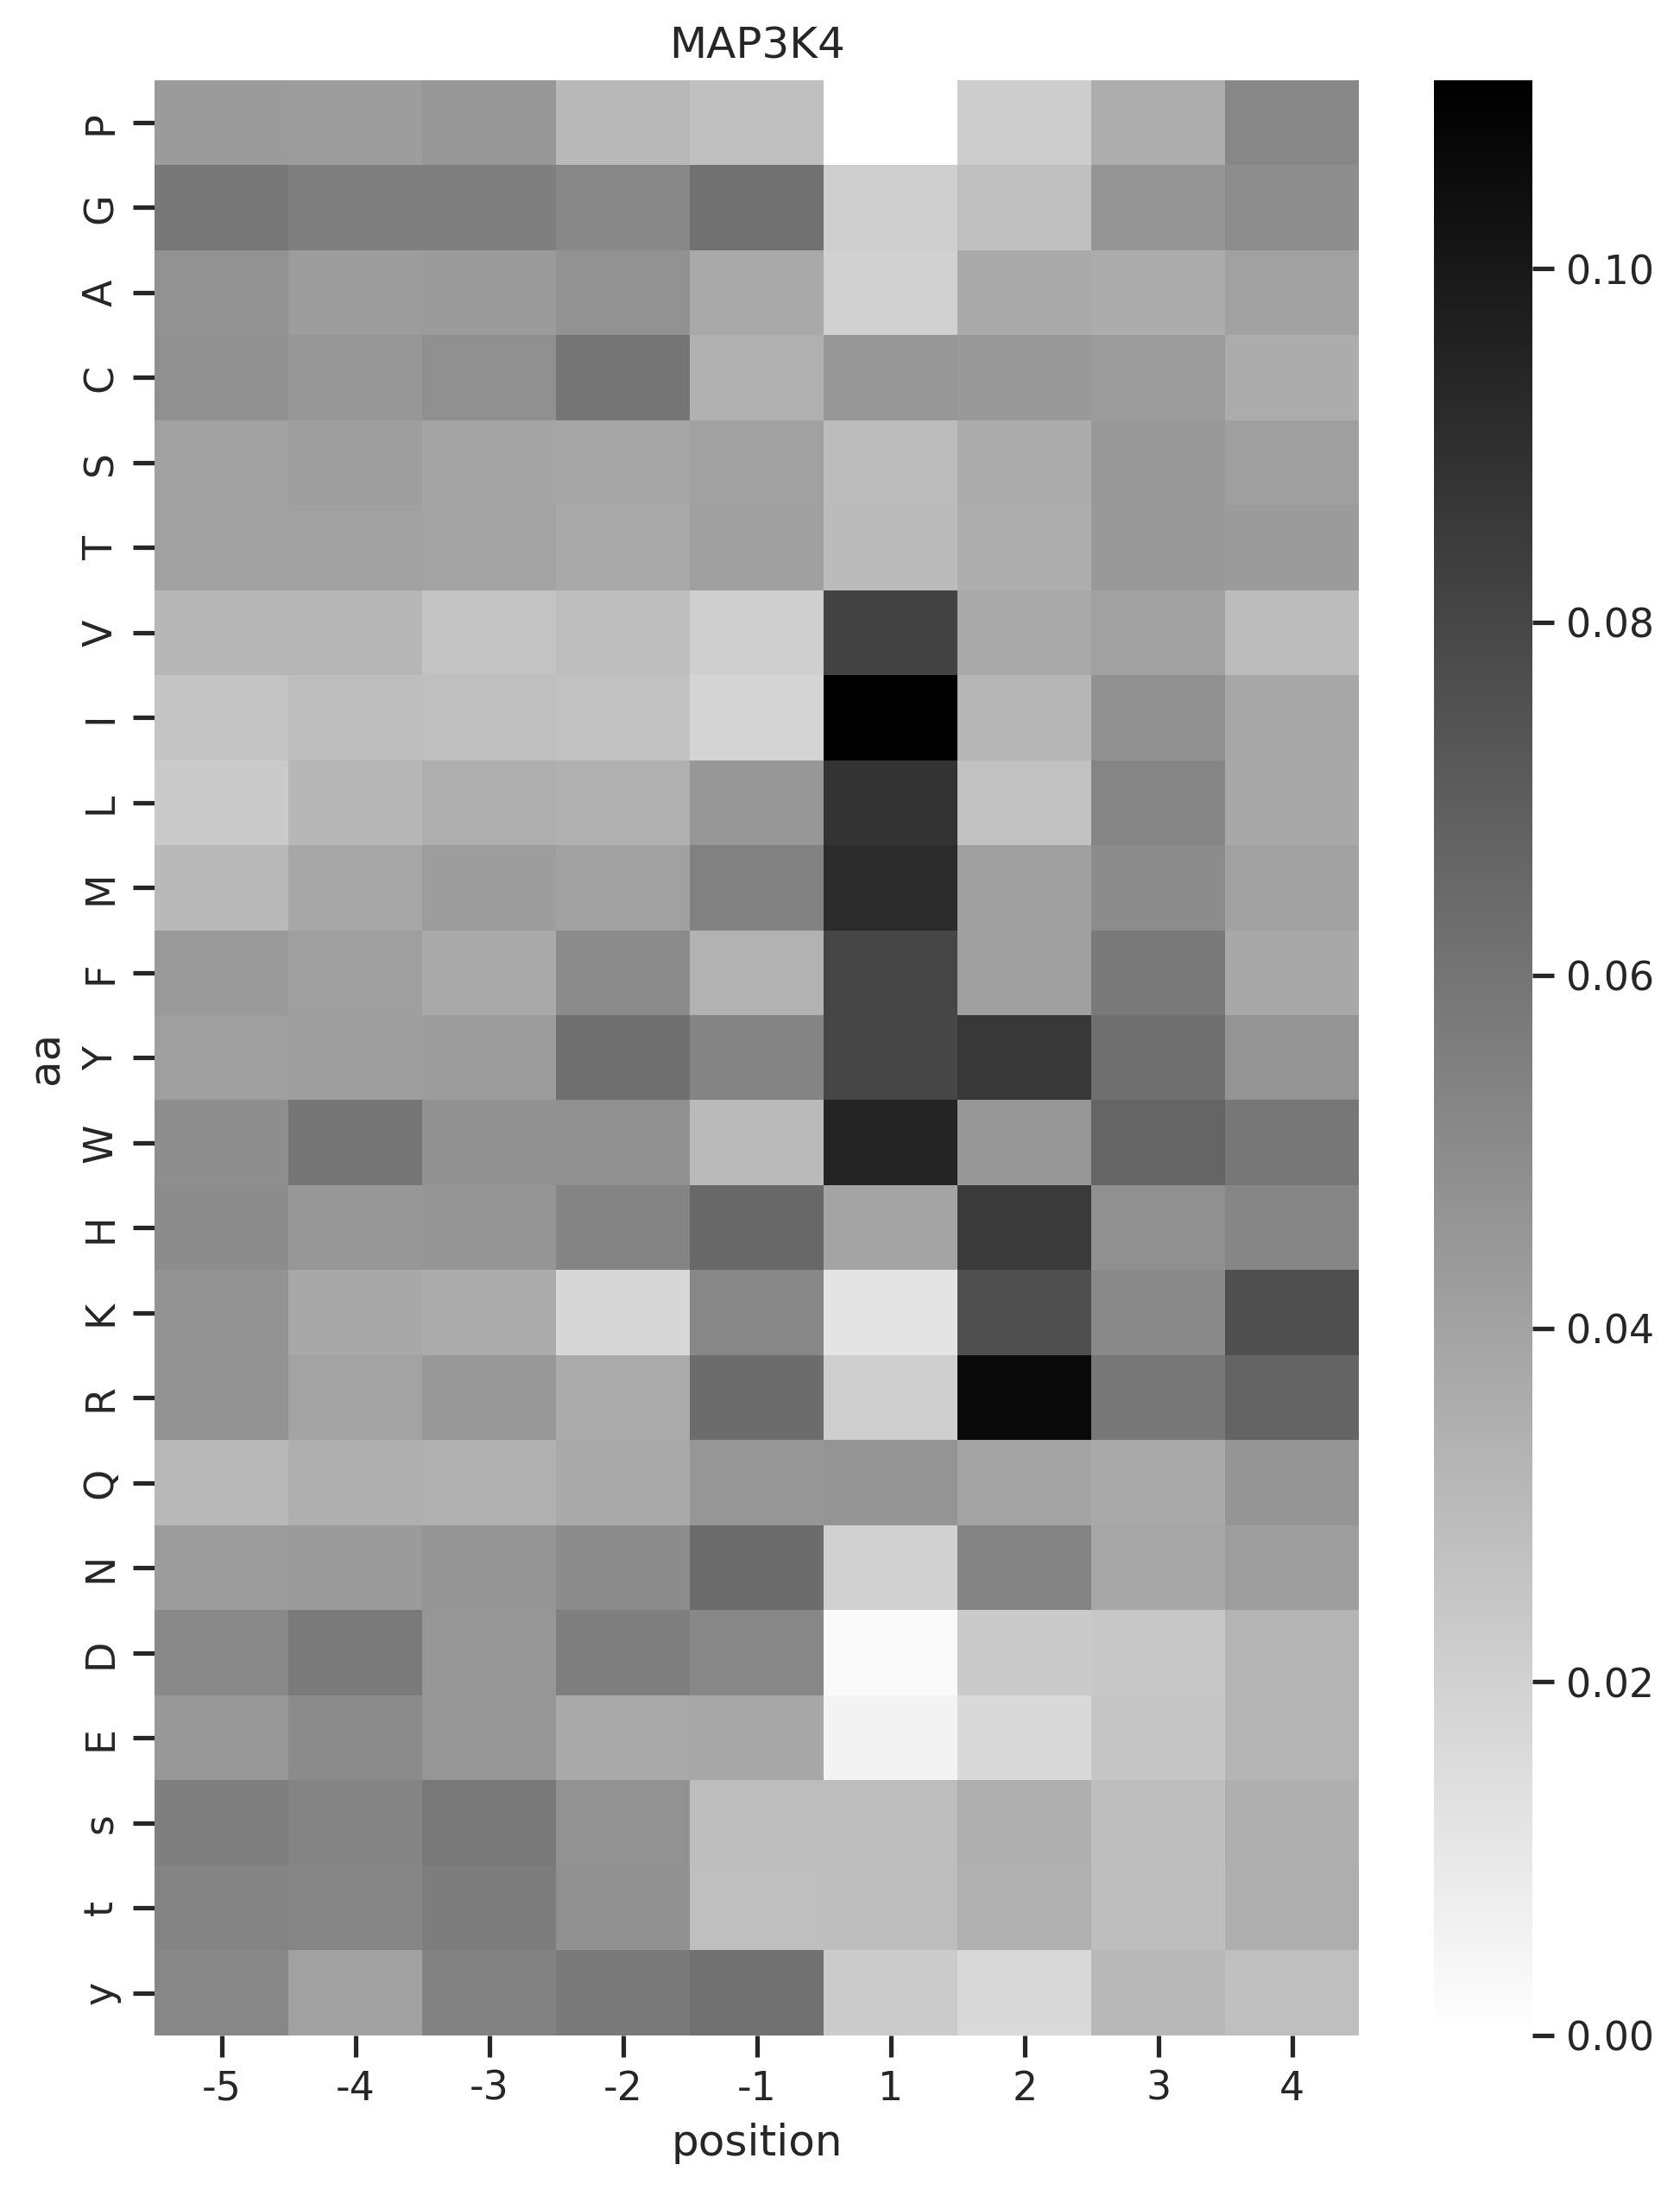

NKF1:0.7342624924789267


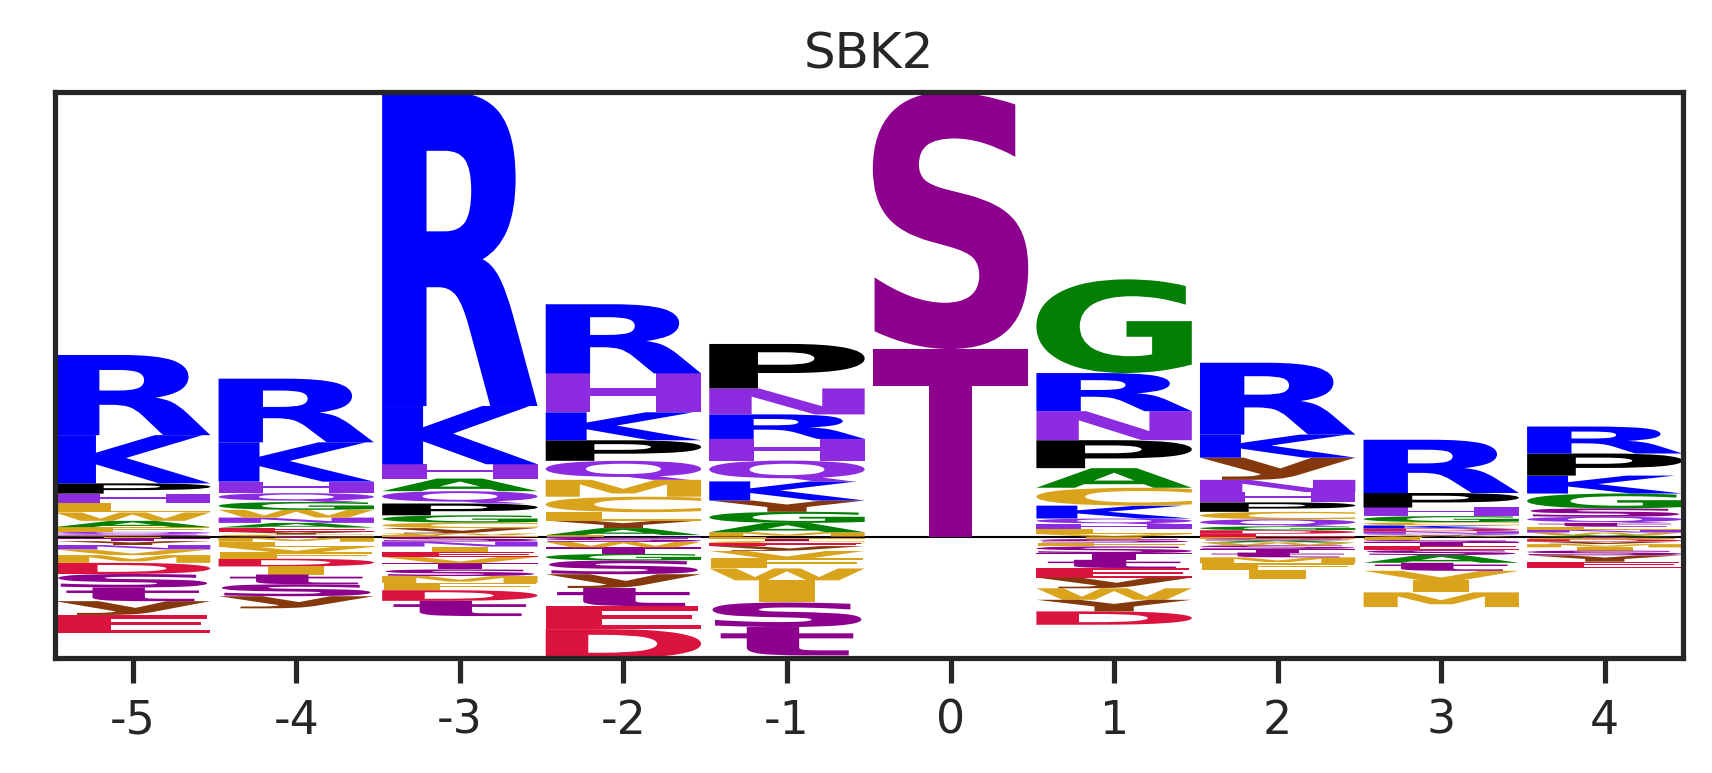

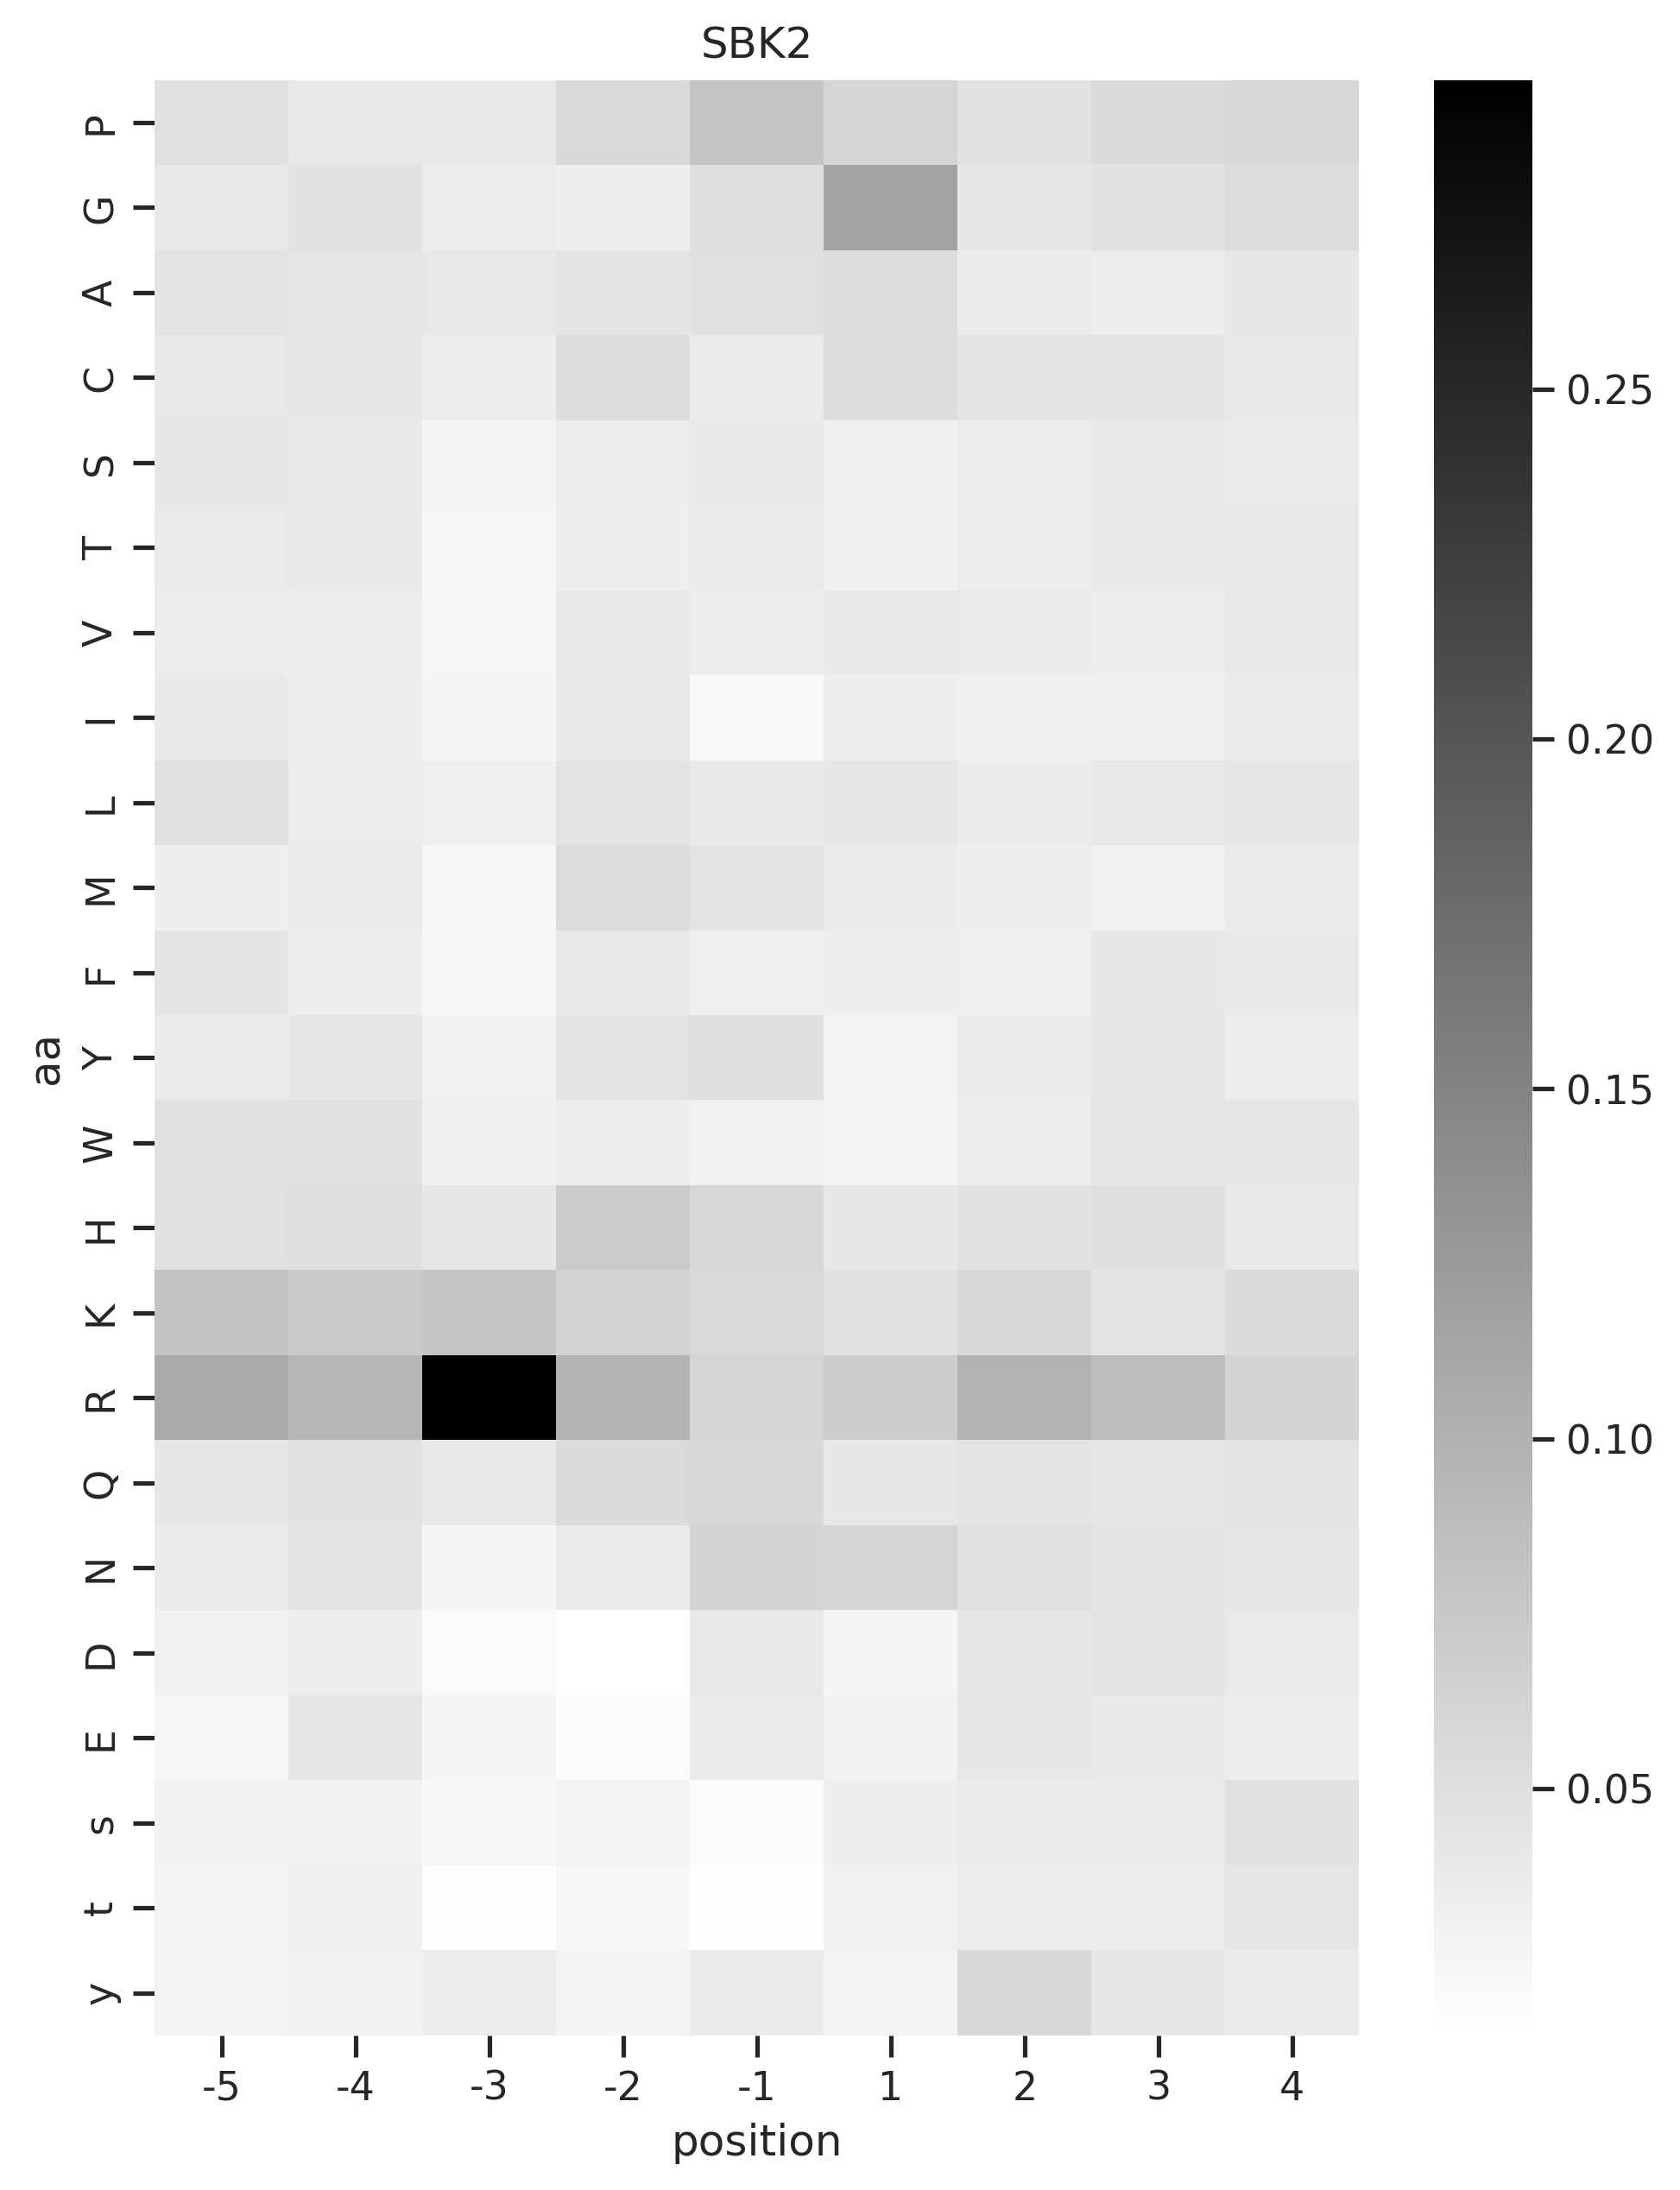

NKF1:0.7342624924789267


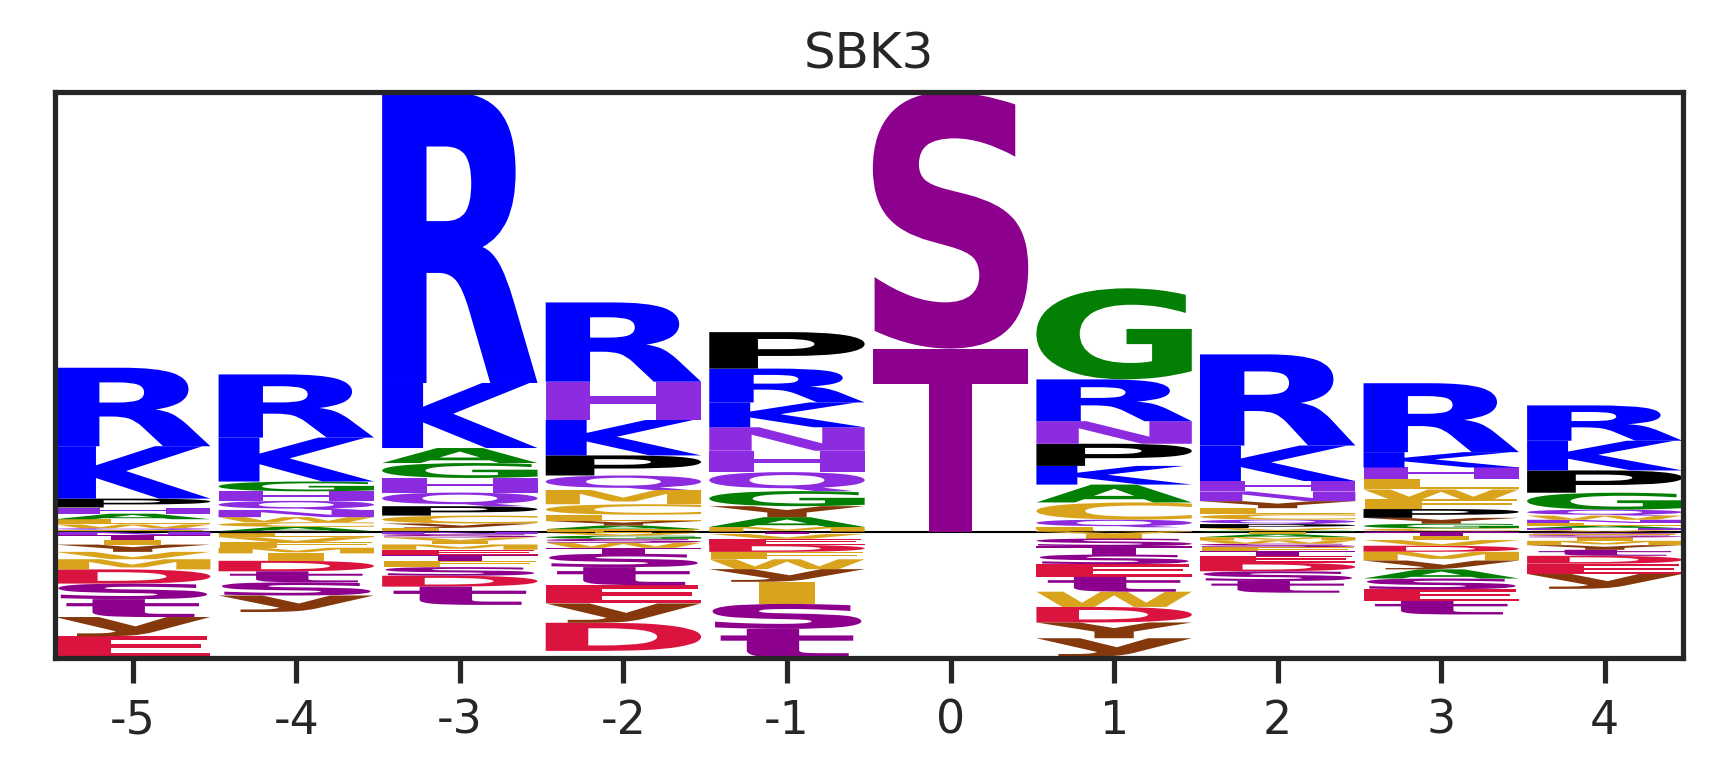

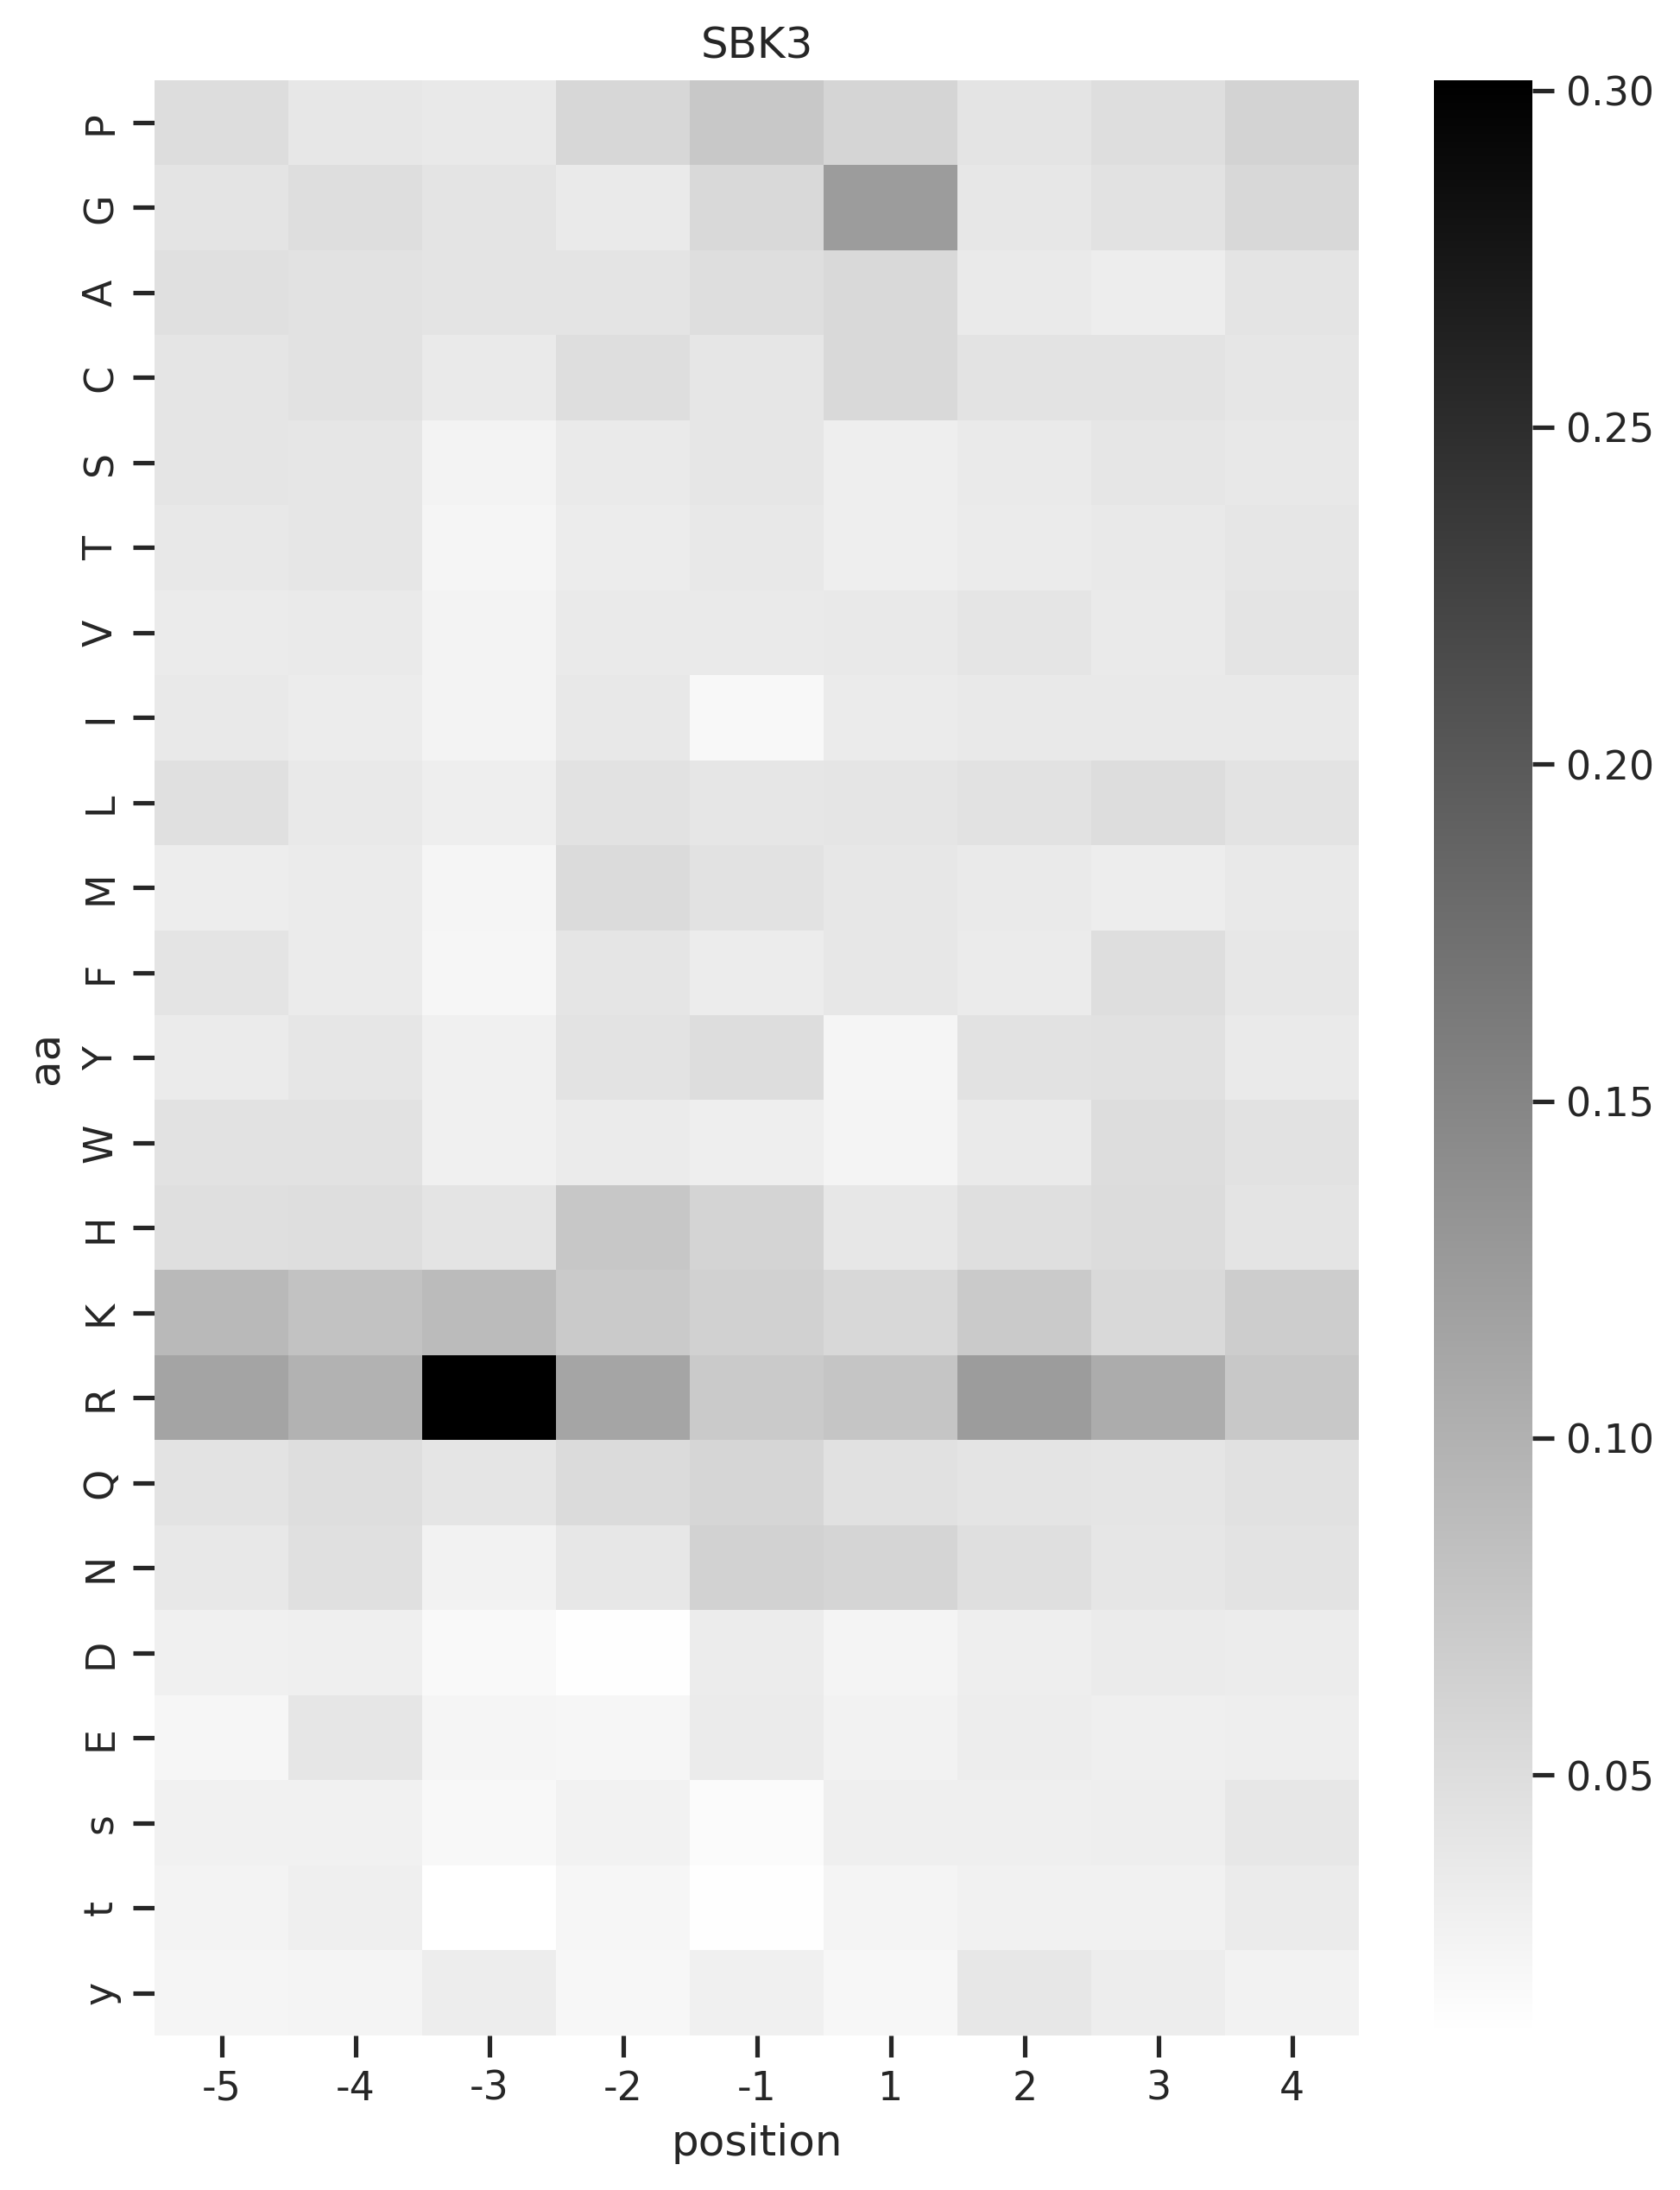

MLK:0.7337835153843144


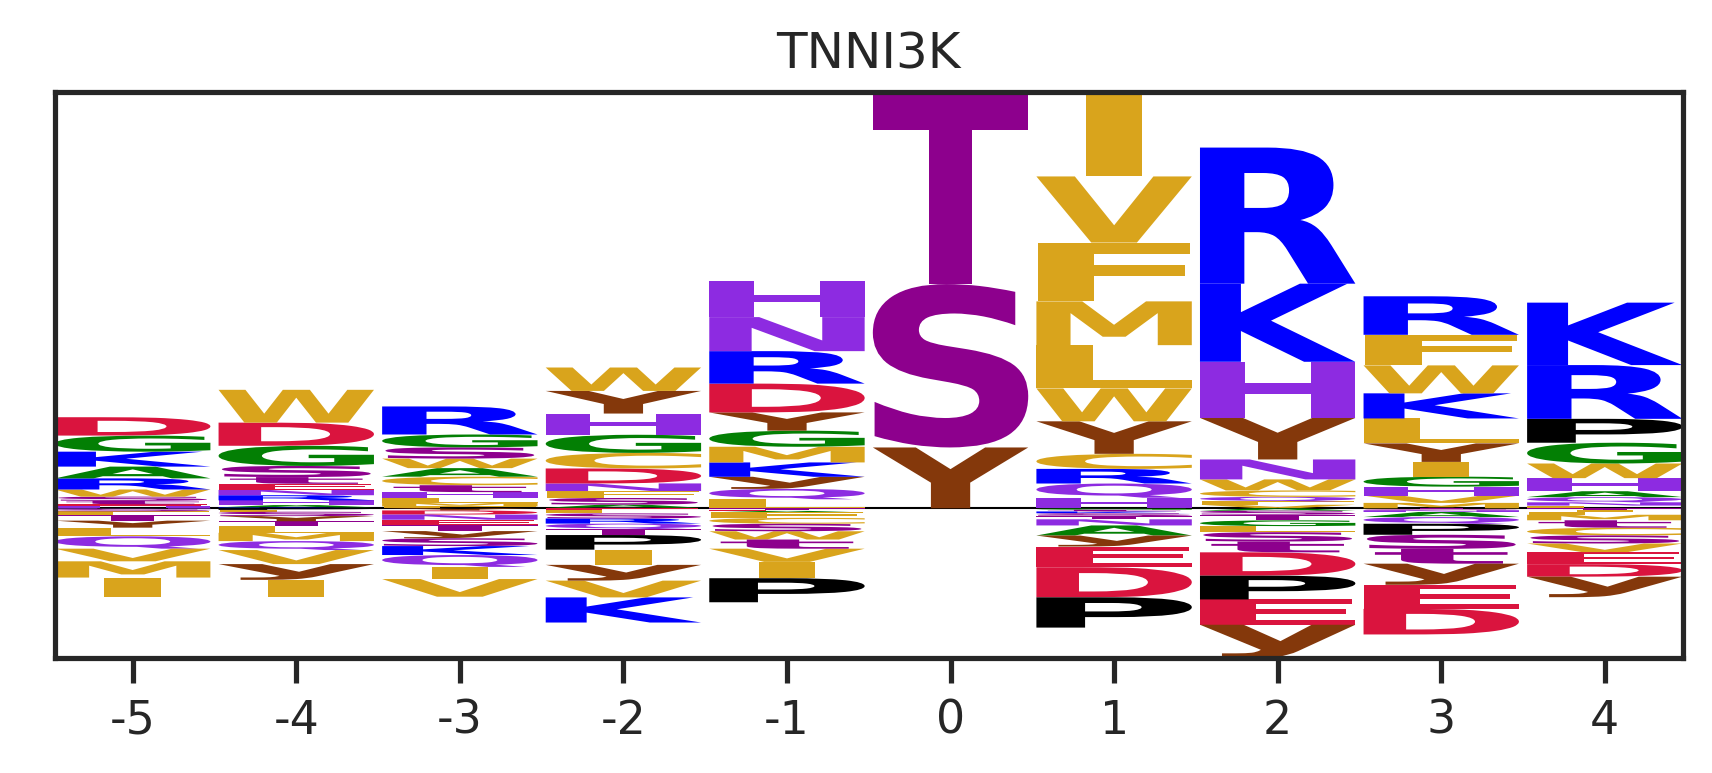

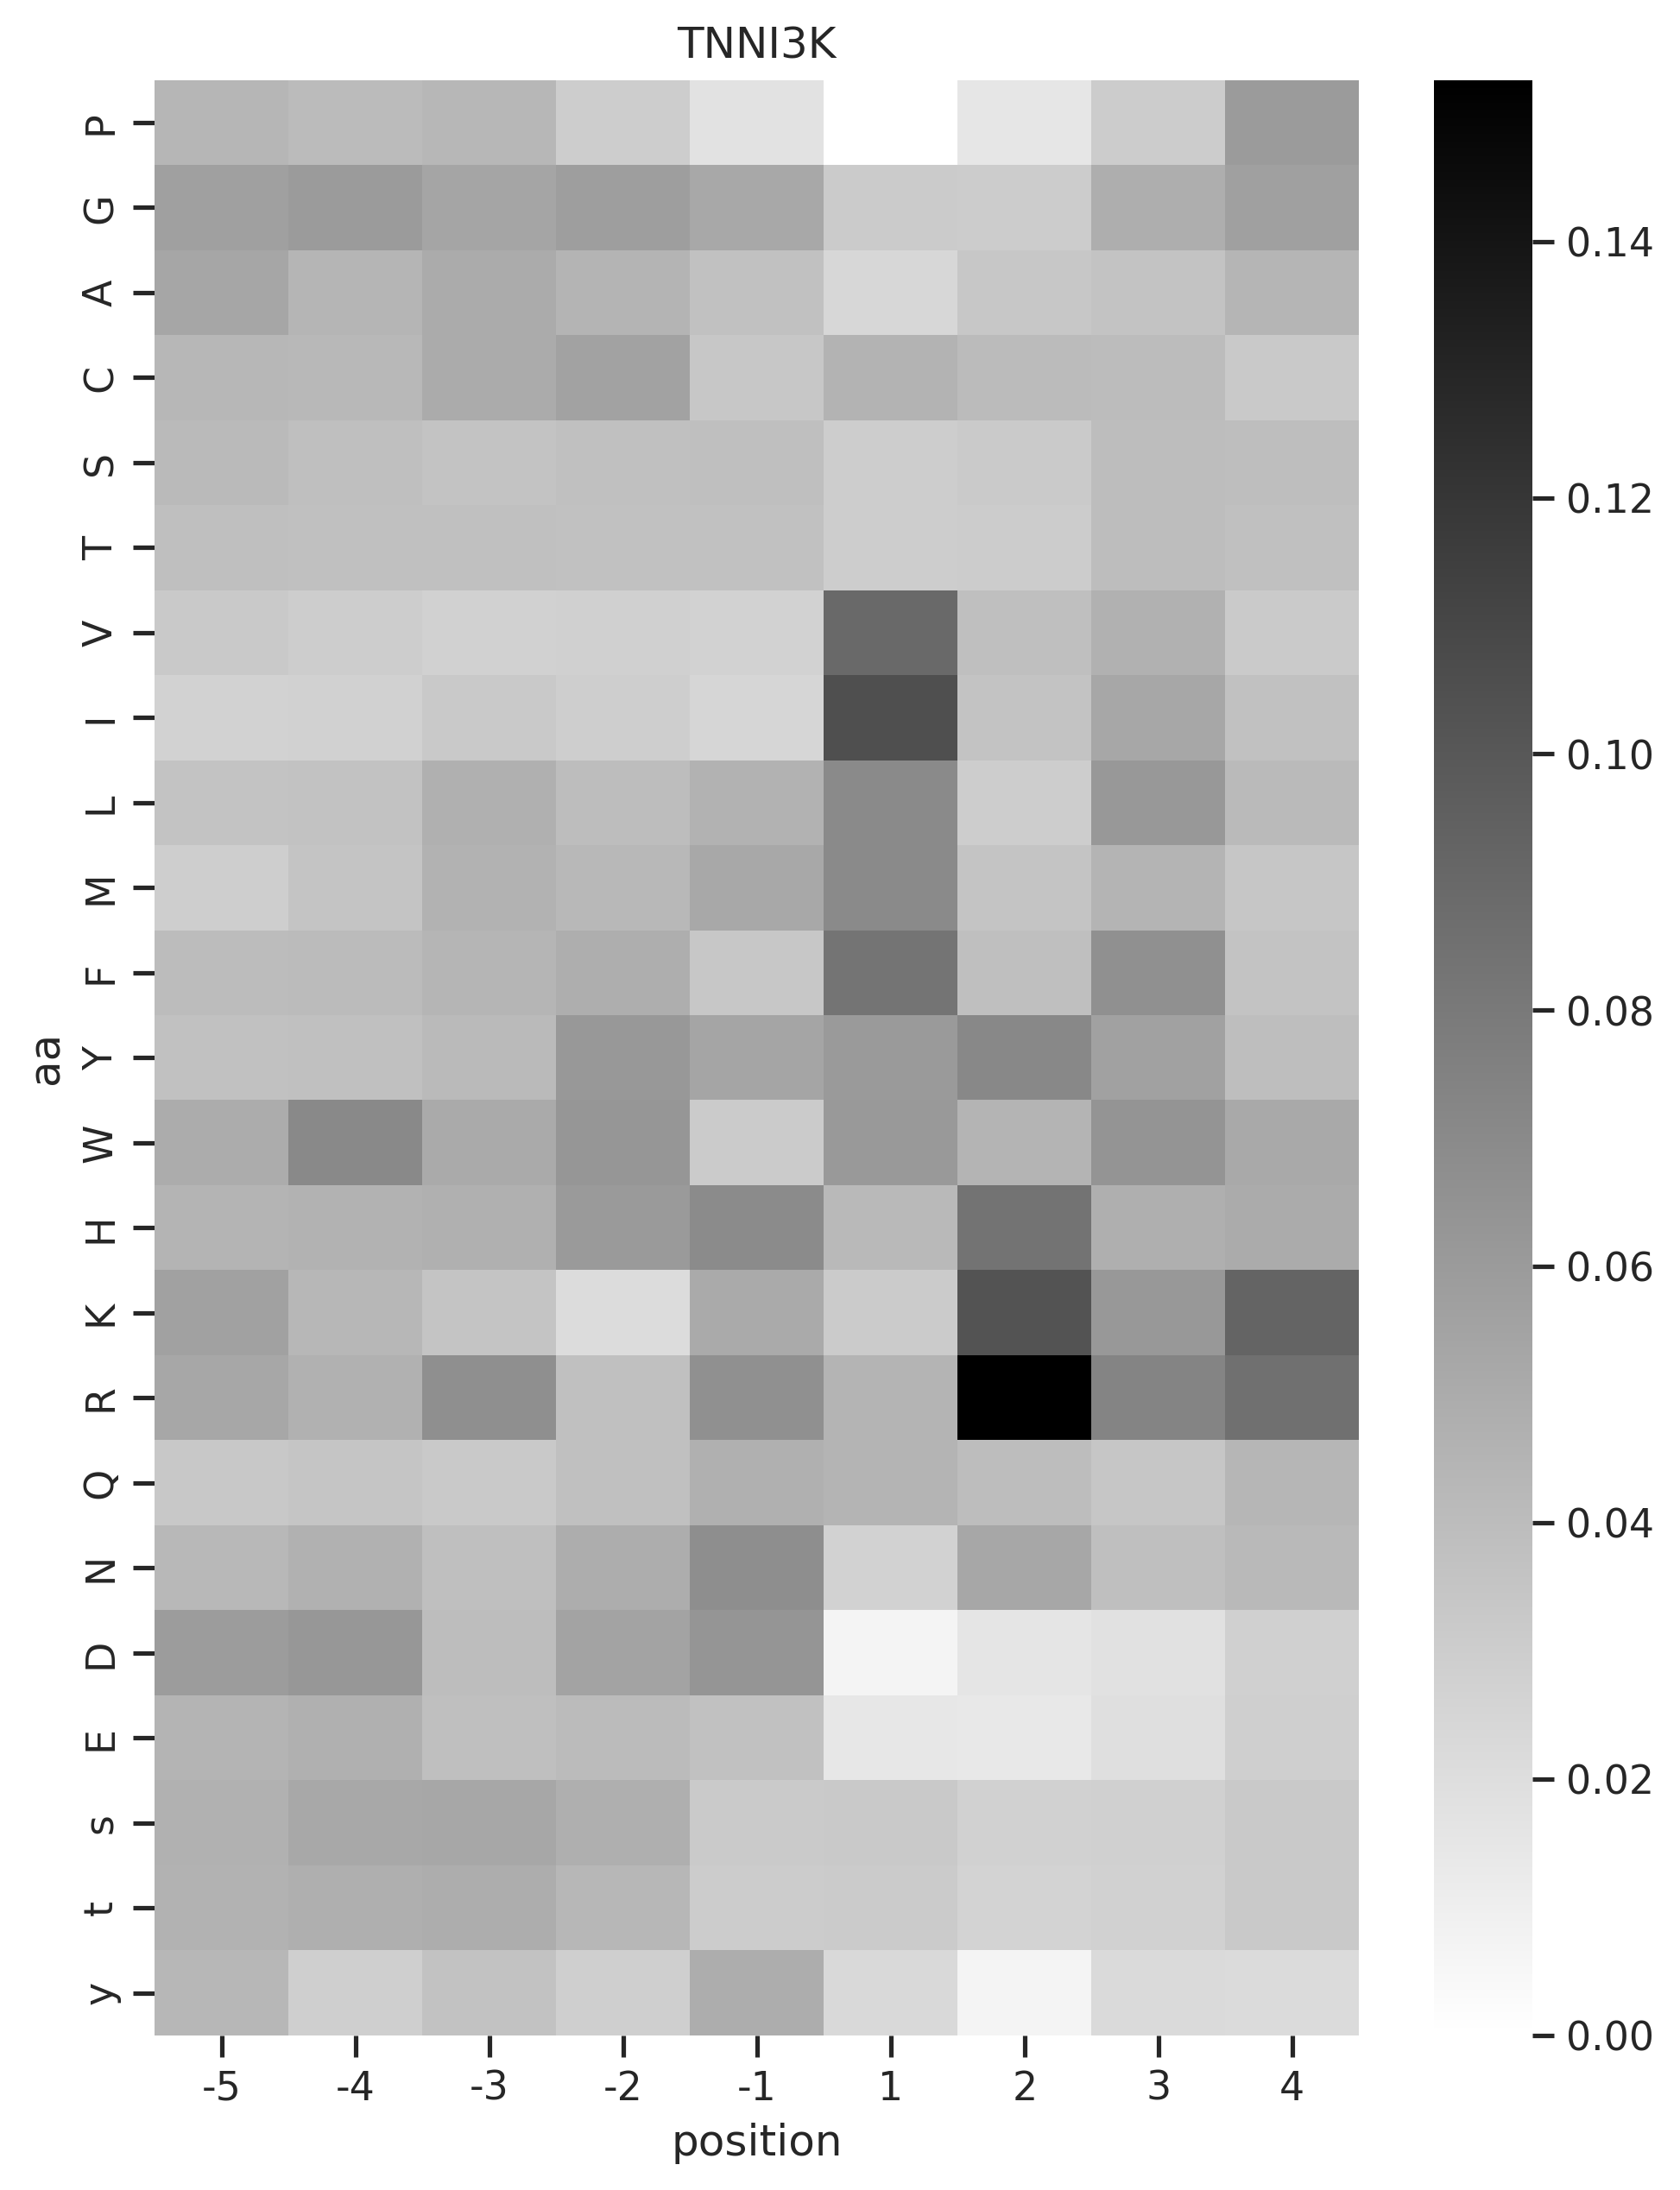

MLK:0.7337835153843144


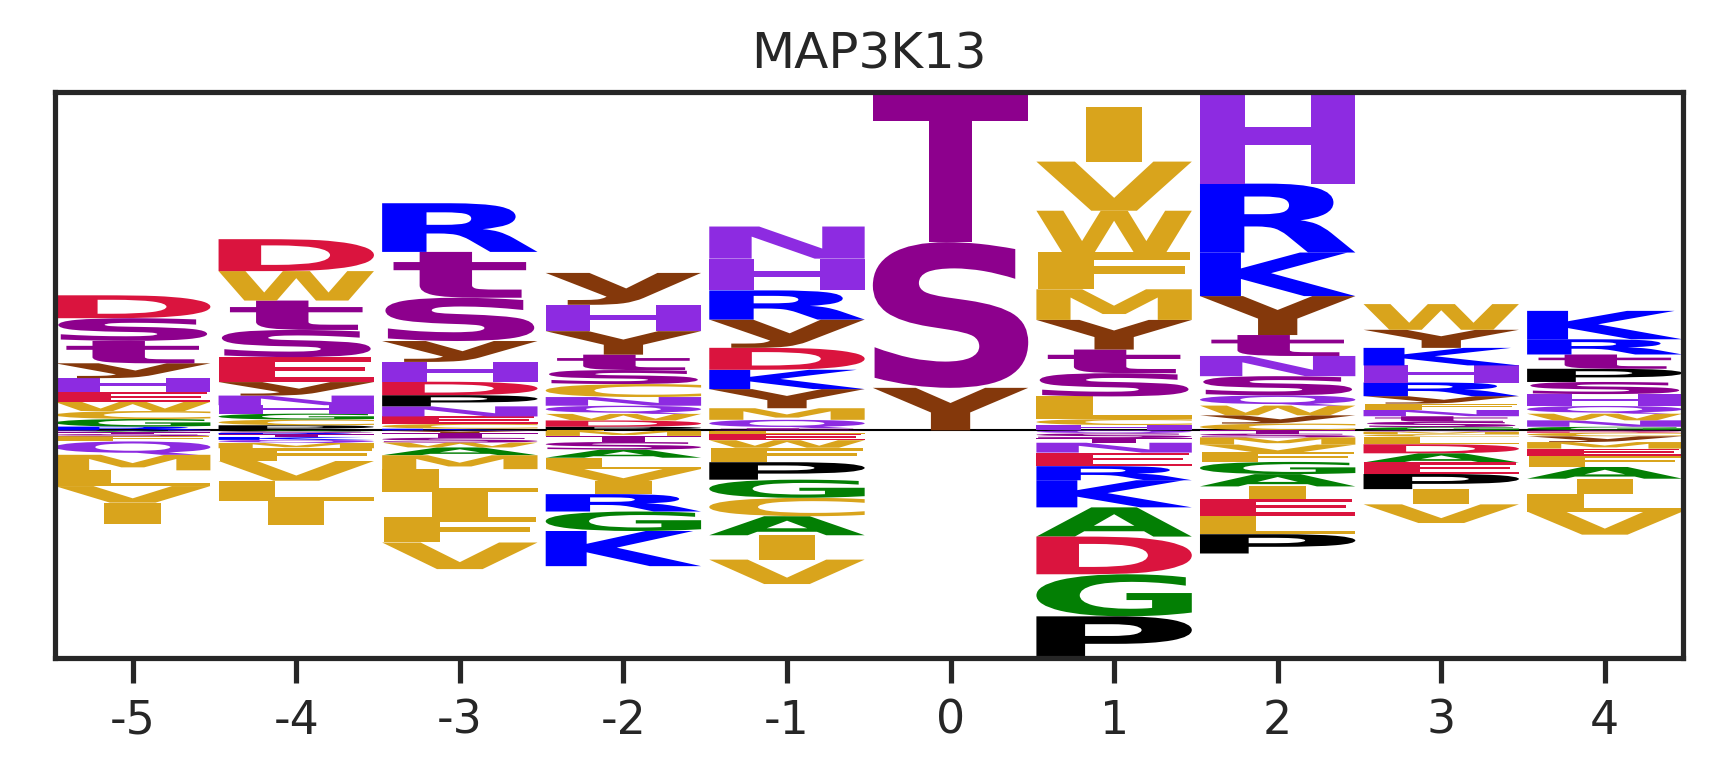

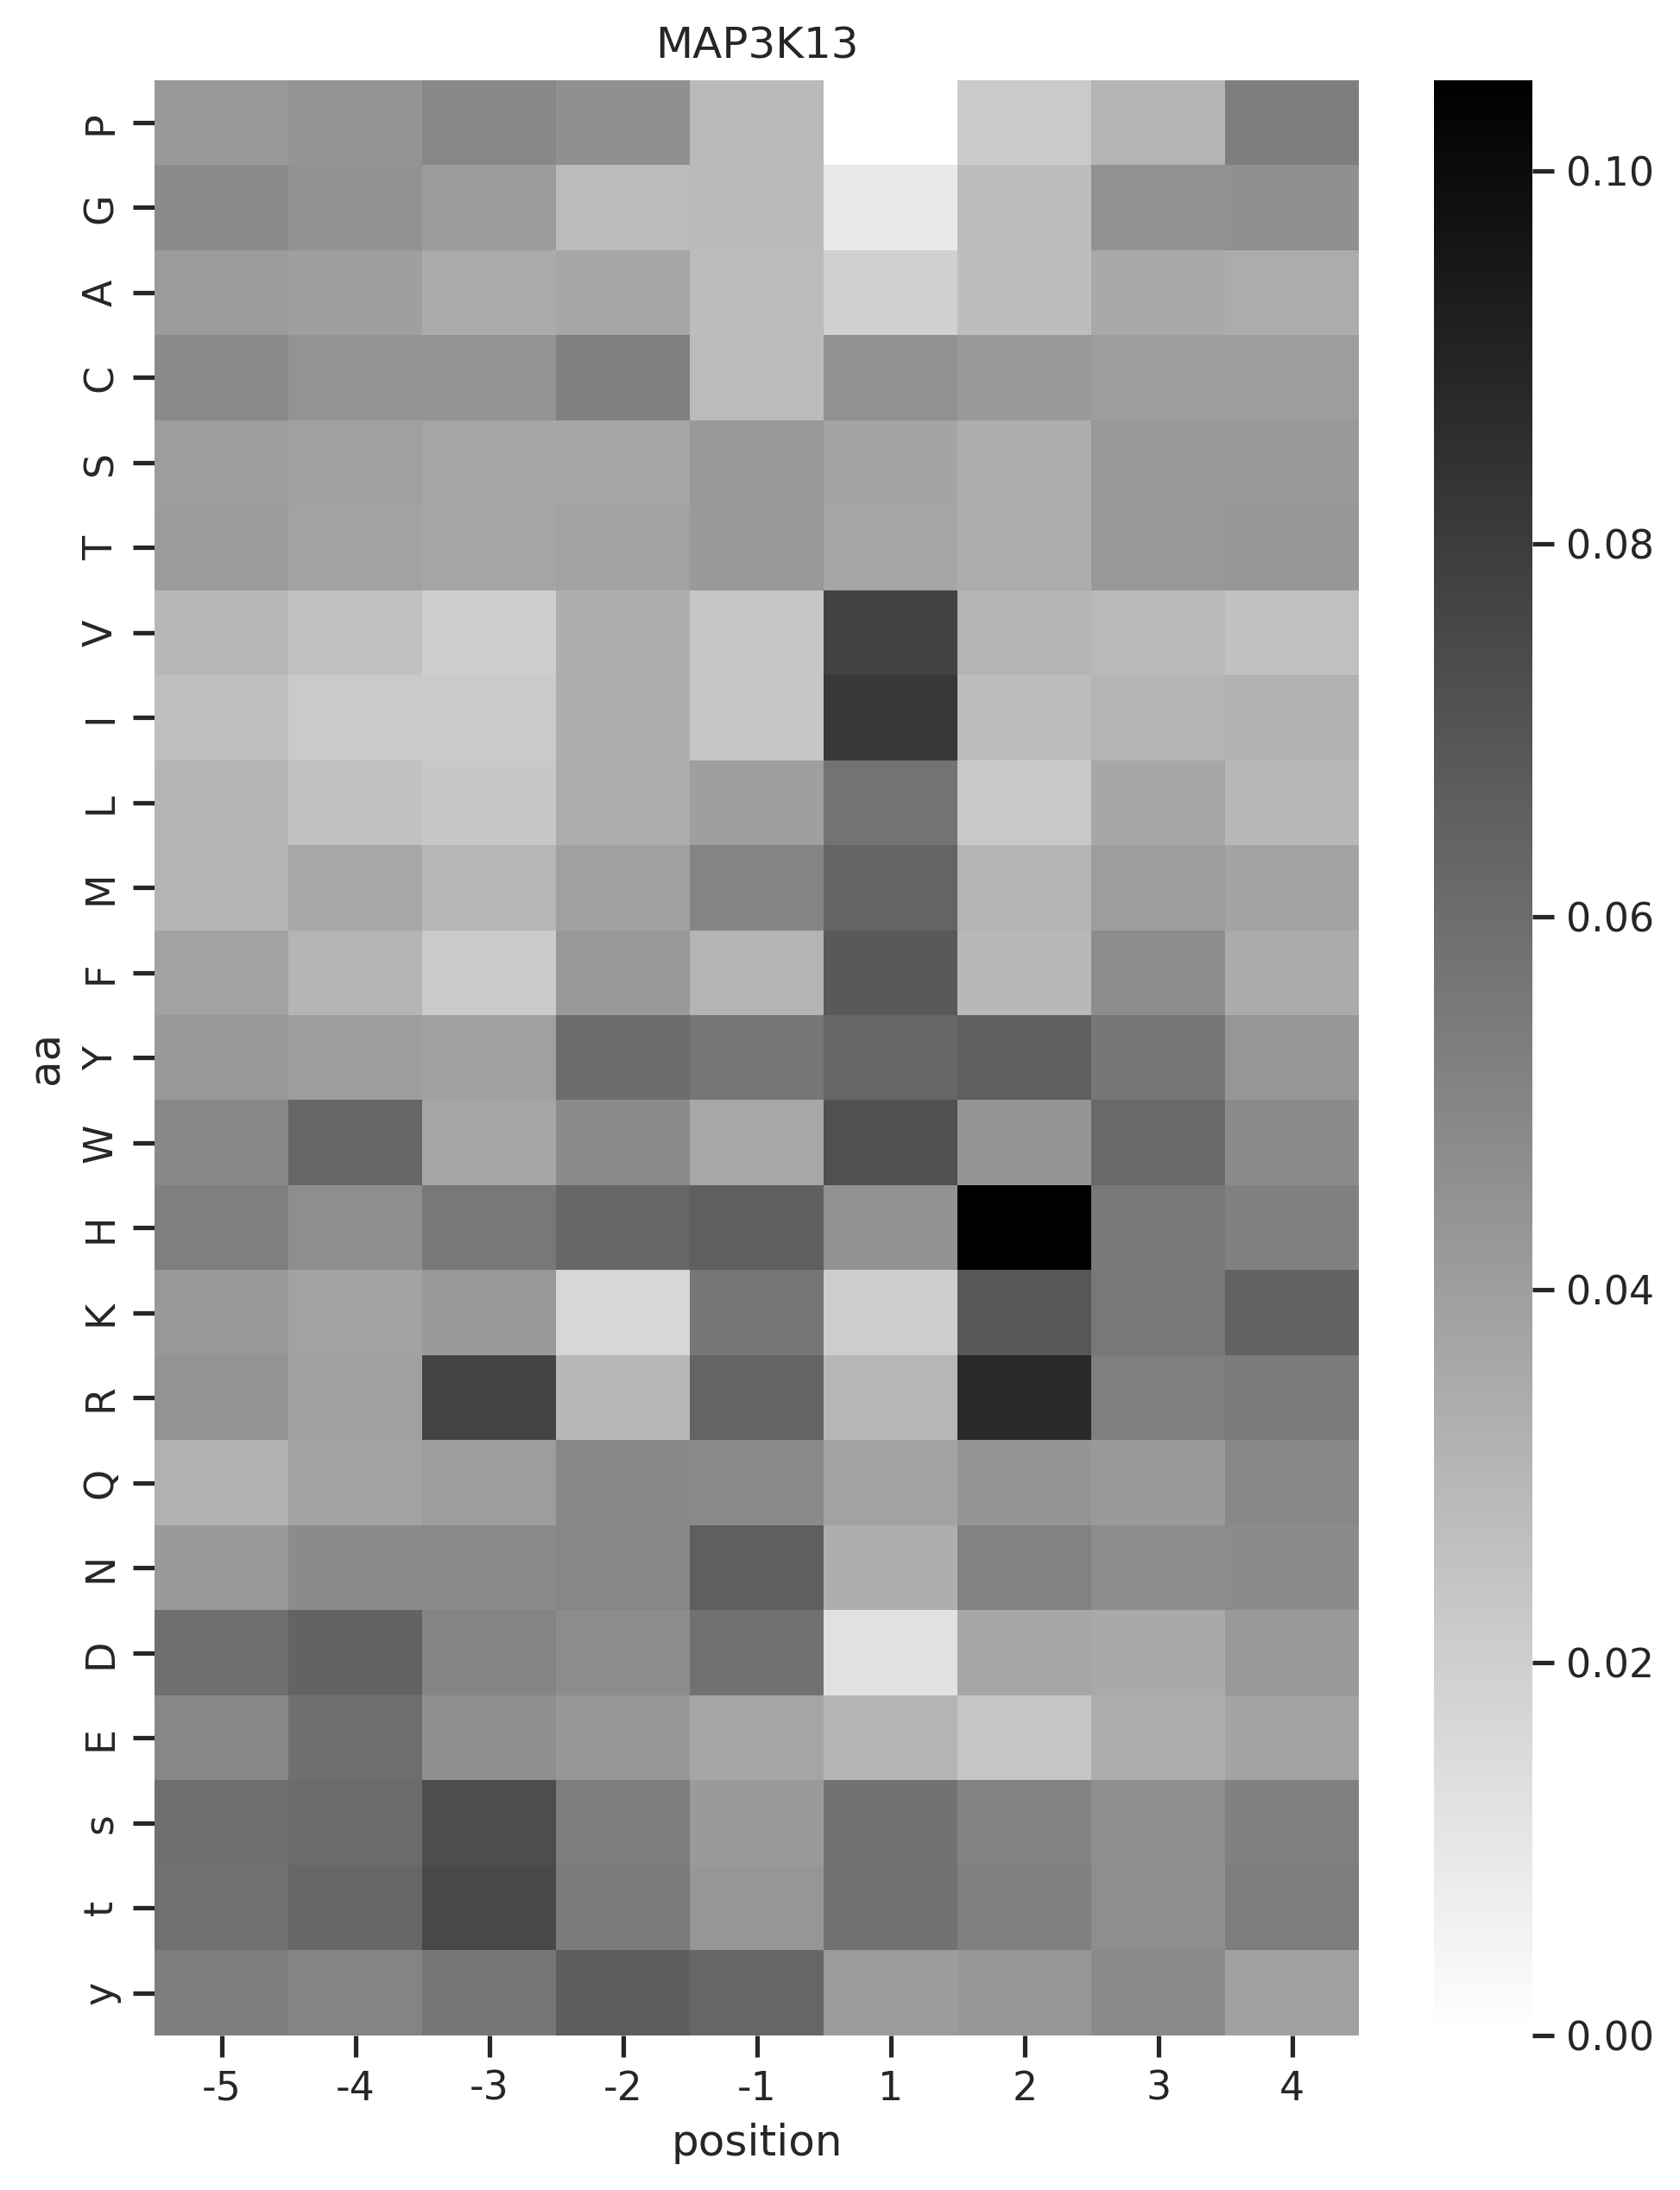

RIPK:0.62712483511819


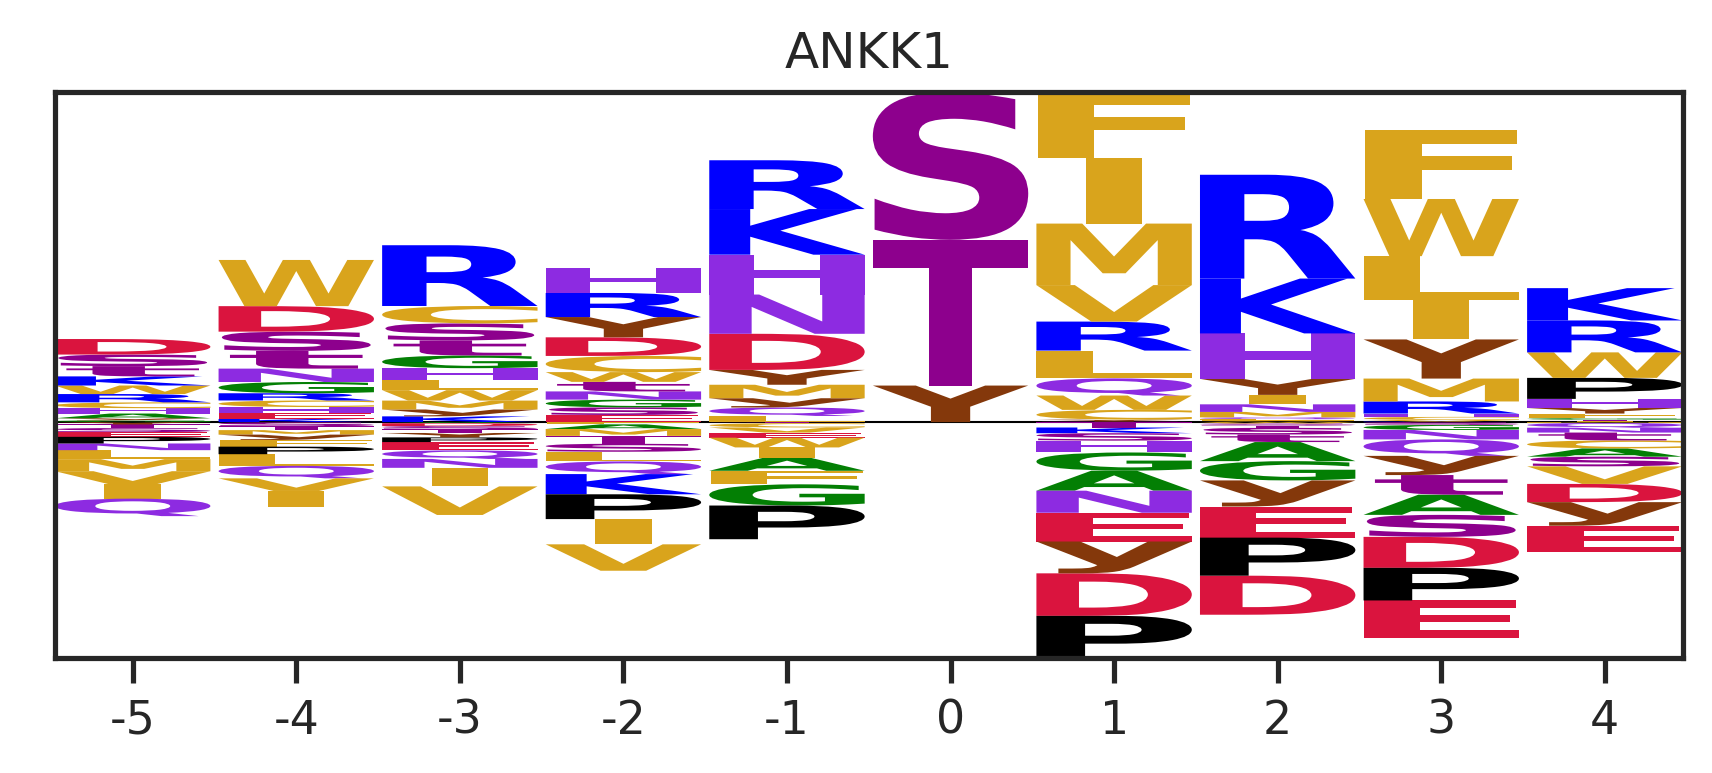

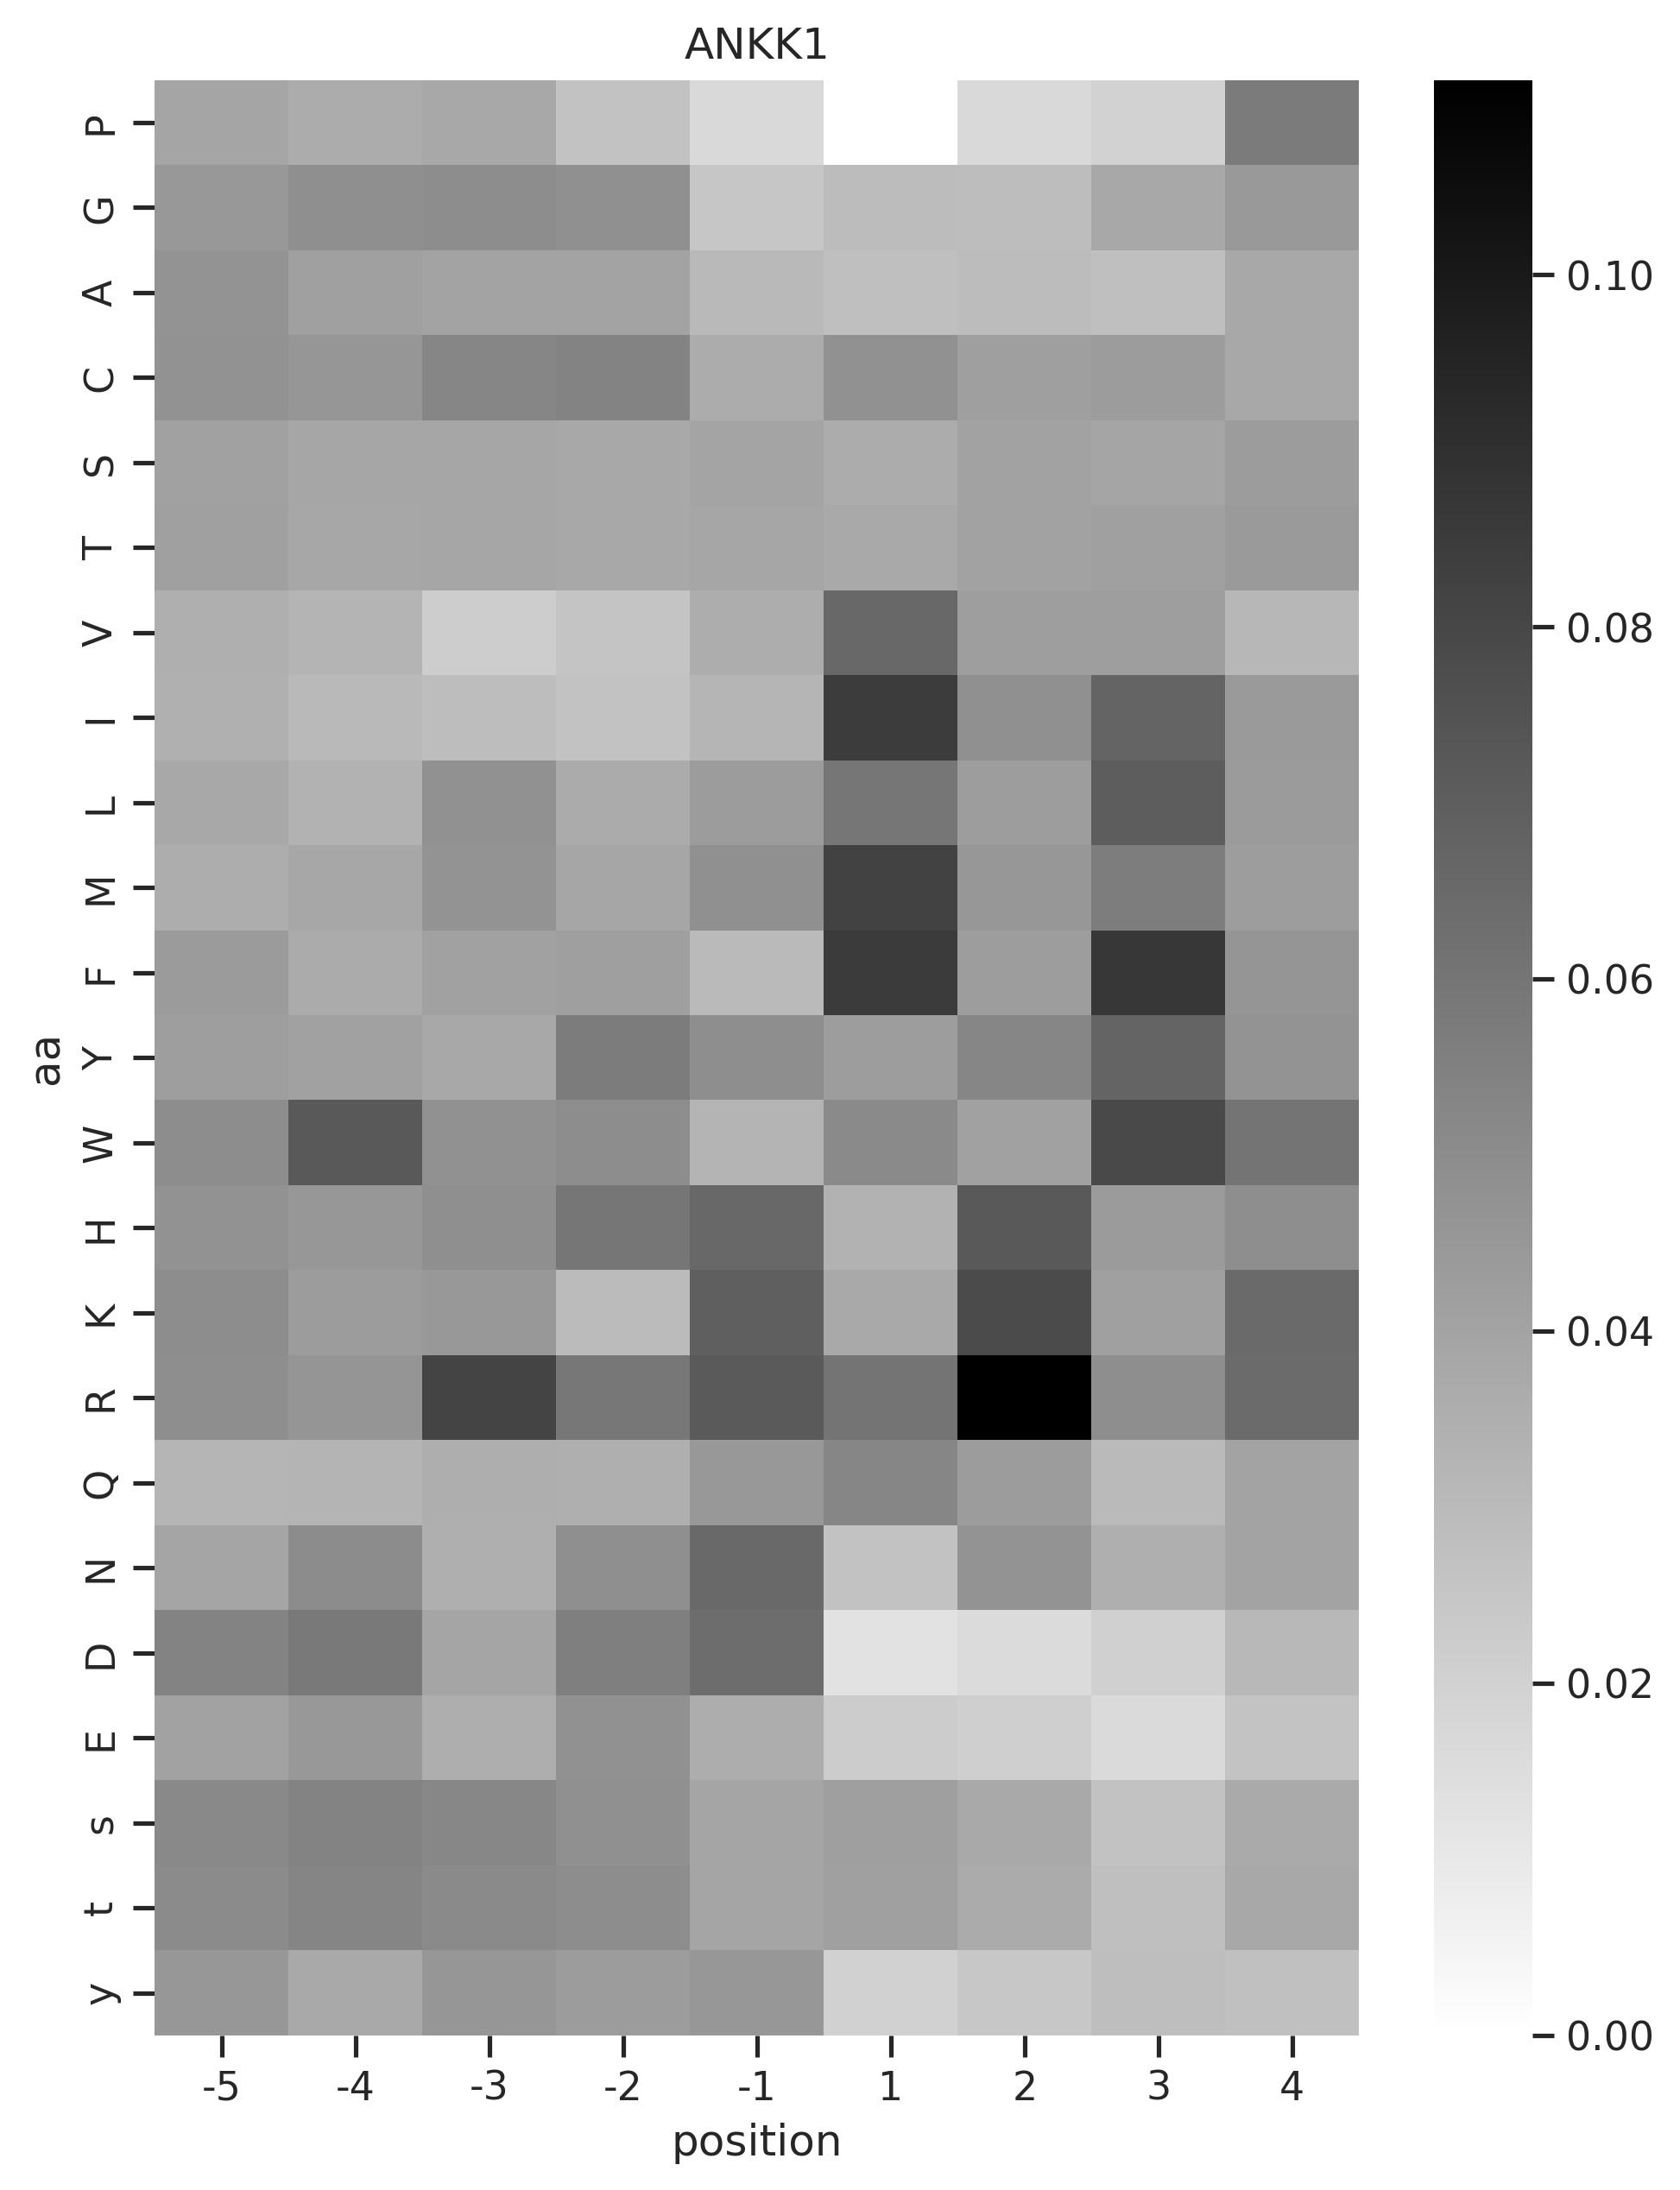

In [ ]:
for i,r in selected.iterrows():
    print(f'{r.family}:{r.Pearson_family}')
    
    k = r.kinase
    matrix = get_one_kinase(preds_final,k,drop_s=False).T
    get_logo2(matrix, k)
    plt.show()
    plt.close()
    
    get_heatmap(preds_final.iloc[:,:-3],k)
    plt.show()
    plt.close()

## Save

Create folder: predict/logo, predict/heatmap, predict/combine

In [ ]:
# !mkdir predict
# !mkdir predict/logo
# !mkdir predict/heatmap
# !mkdir predict/combine

In [ ]:
# clear contents in the folder
# !rm -r predict/logo/*
# !rm -r predict/heatmap/*
# !rm -r predict/combine/*

In [ ]:
# for i,r in selected.iterrows():
    
#     print(f'{r.family}:{r.Pearson_family}')
    
#     k = r.kinase
#     matrix = get_one_kinase(preds_final,k,drop_s=False).T
#     get_logo2(matrix, k)
#     plt.savefig(f'predict/logo/{k}.png',bbox_inches='tight', pad_inches=0.3) #0.3
#     plt.close()
    
#     get_heatmap(preds_final.iloc[:,:-3],k,figsize=(7.5,10))
#     plt.savefig(f'predict/heatmap/{k}.png',bbox_inches='tight', pad_inches=0)
#     plt.close()
    
#     # break

## Save and combine images for pdf

In [ ]:
def combine_images_vertically(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    total_width = max(image.width for image in images)
    total_height = sum(image.height for image in images)

    combined_image = Image.new('RGBA', (total_width, total_height))

    y_offset = 0
    for image in images:
        combined_image.paste(image, (0, y_offset), image)
        y_offset += image.height

    combined_image.save(output_path)

In [ ]:
# folders = ["predict/logo", "predict/heatmap"]

# for i,r in tqdm(selected.iterrows(),total=len(selected)):
    
#     k = r.kinase
#     filename = f"{k}.png"
#     image_paths = [os.path.join(folder, filename) for folder in folders]
#     output_path = f"predict/combine/{k}.png"
    
#     combine_images_vertically(image_paths, output_path)
#     # break

In [ ]:
# !zip -rq predict.zip predict/combine/*

## Validate with KS dataset

In [ ]:
df = Data.get_ks_dataset()

In [ ]:
df = df[df.kinase.isin(preds_final.index)]

In [ ]:
def plot_count2(df_k,title):
    # Get value counts
    source_counts = df_k.source.replace({'pplus':'PP','large_scale':'LS'}).value_counts()
    plt.figure(figsize=(7,1))

    source_counts.plot(kind='barh', stacked=True, color=['darkred', 'darkblue'])
    # Annotate with the actual values
    for index, value in enumerate(source_counts):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')

    plt.xlabel('Count')
    plt.title(title)

In [ ]:
df.kinase.value_counts()[:10]

MAP2K6     94
DDR1       81
TNNI3K     76
ERBB2      68
ROR2       58
PKMYT1     54
MAST2      48
ROR1       44
MAP3K13    37
ACVRL1     33
Name: kinase, dtype: int64

From the datasets:

In [ ]:
k = 'MAP3K13'

In [ ]:
df_k = df.query(f'kinase=="{k}"').reset_index()

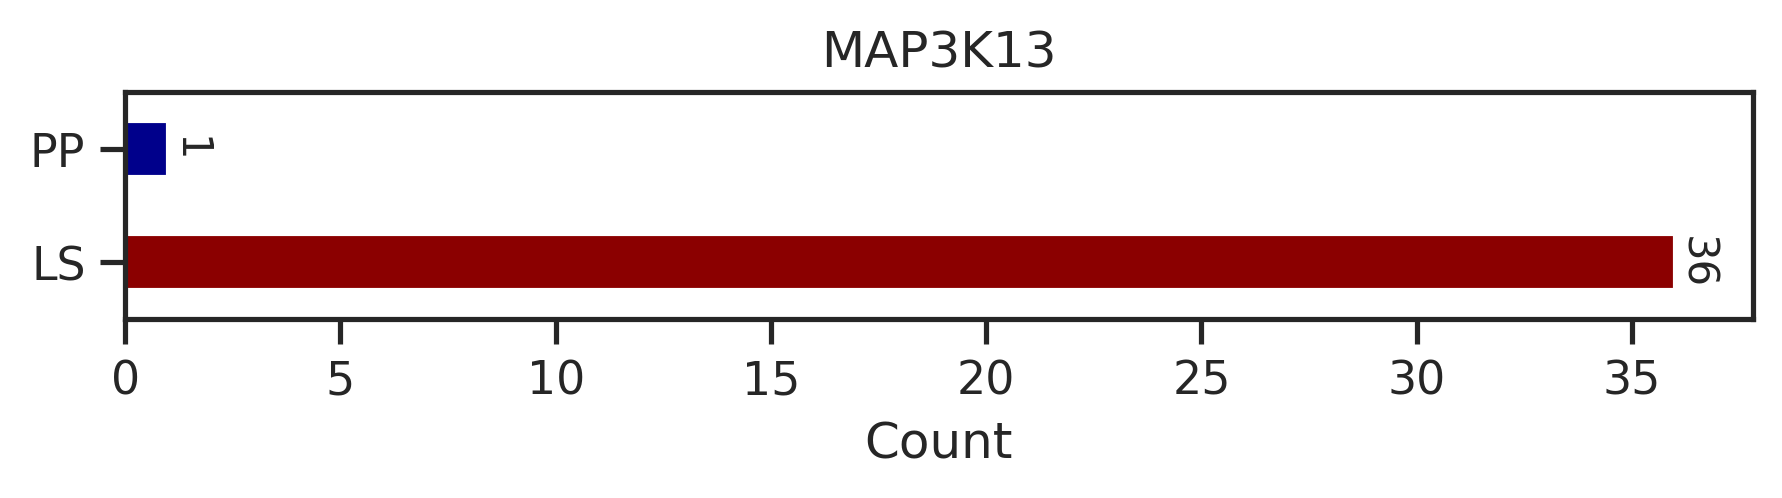

In [ ]:
plot_count2(df_k,k)

In [ ]:
paper,full = get_freq(df_k)

full = full[[i for i in range(-5,5)]]

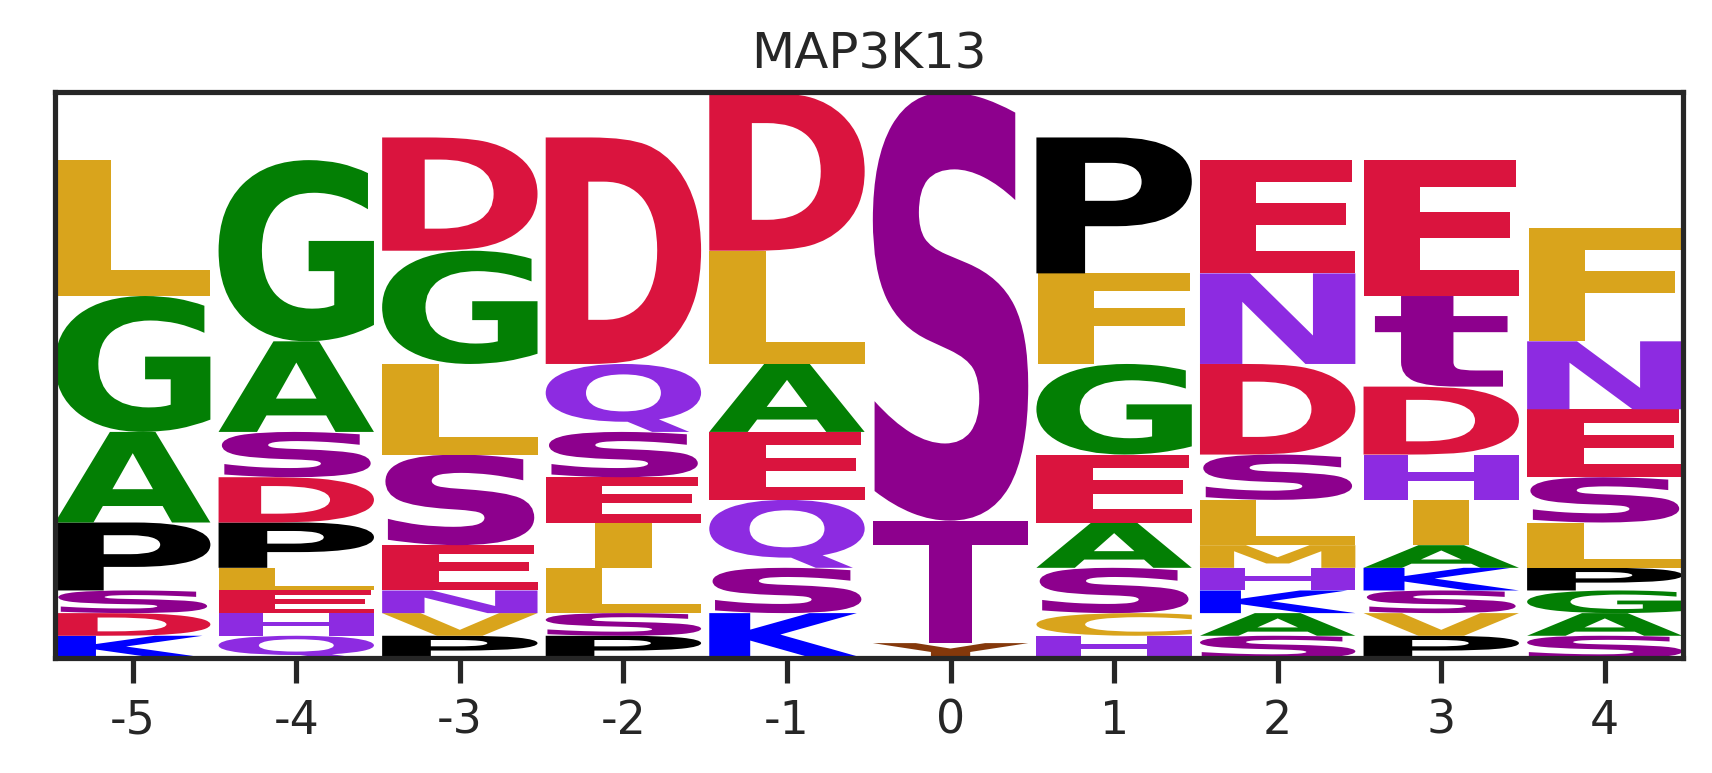

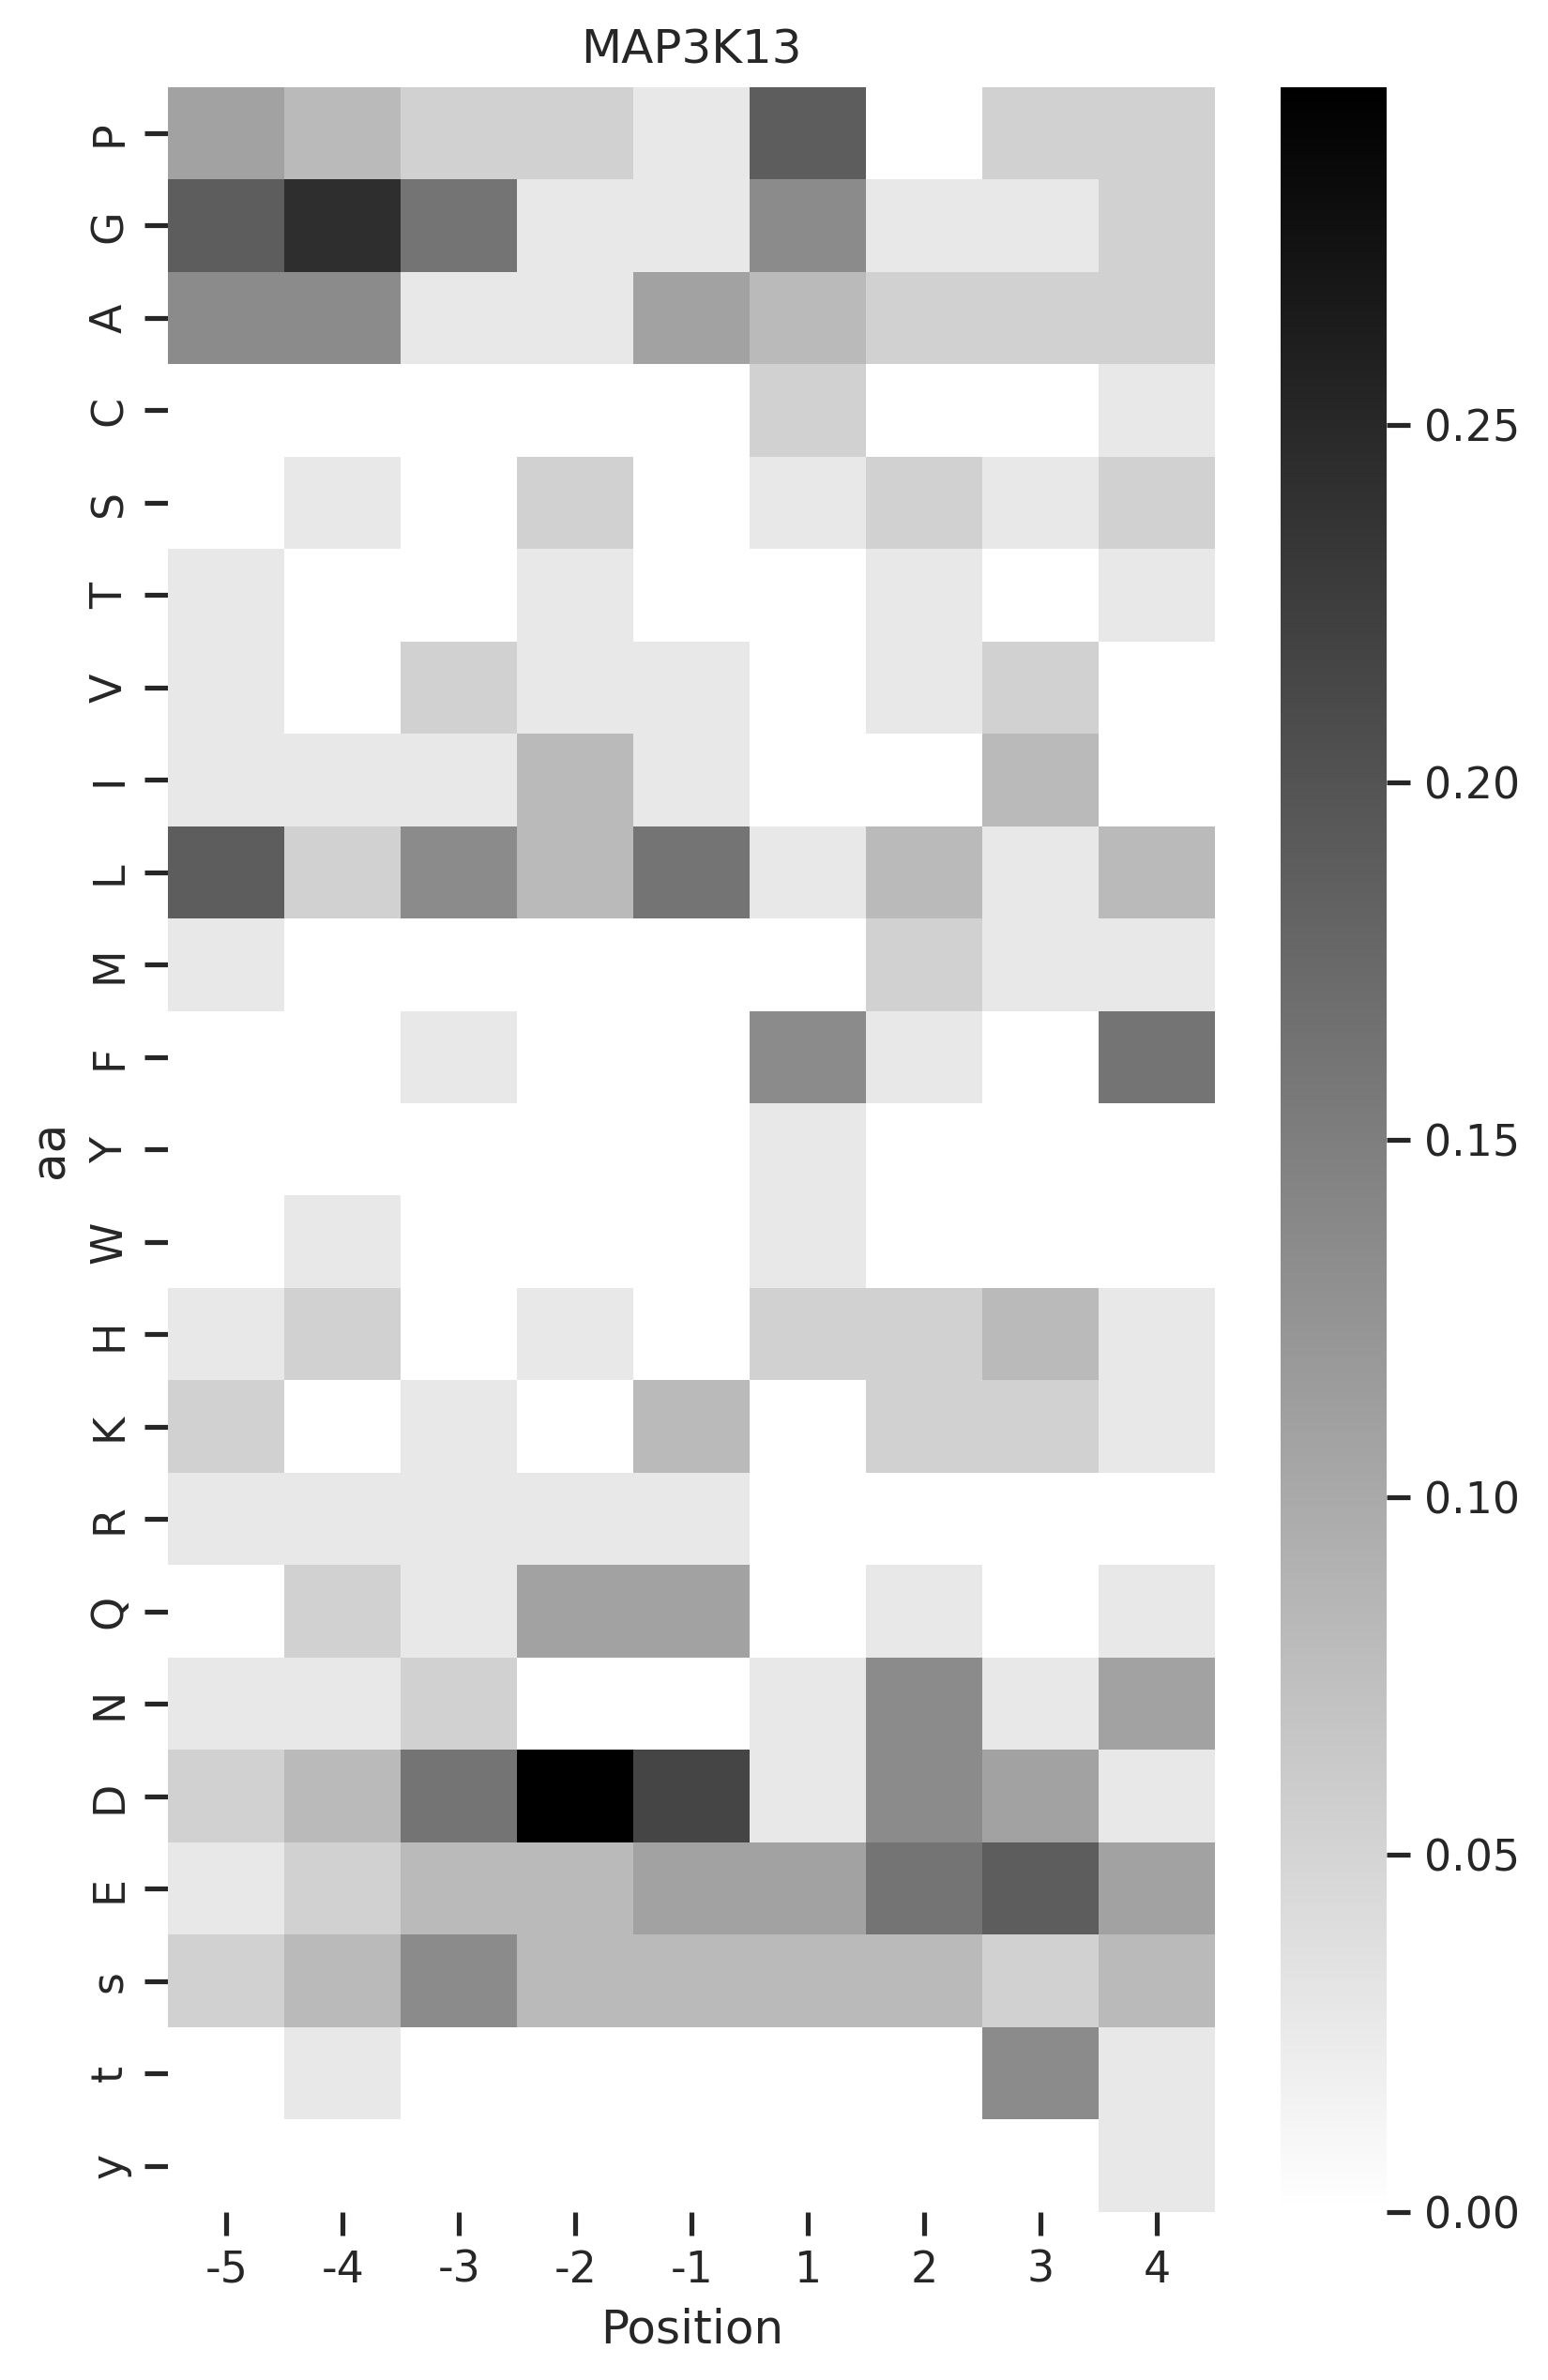

In [ ]:
get_logo2(full, k)
plot_heatmap(paper, k)

Predicted

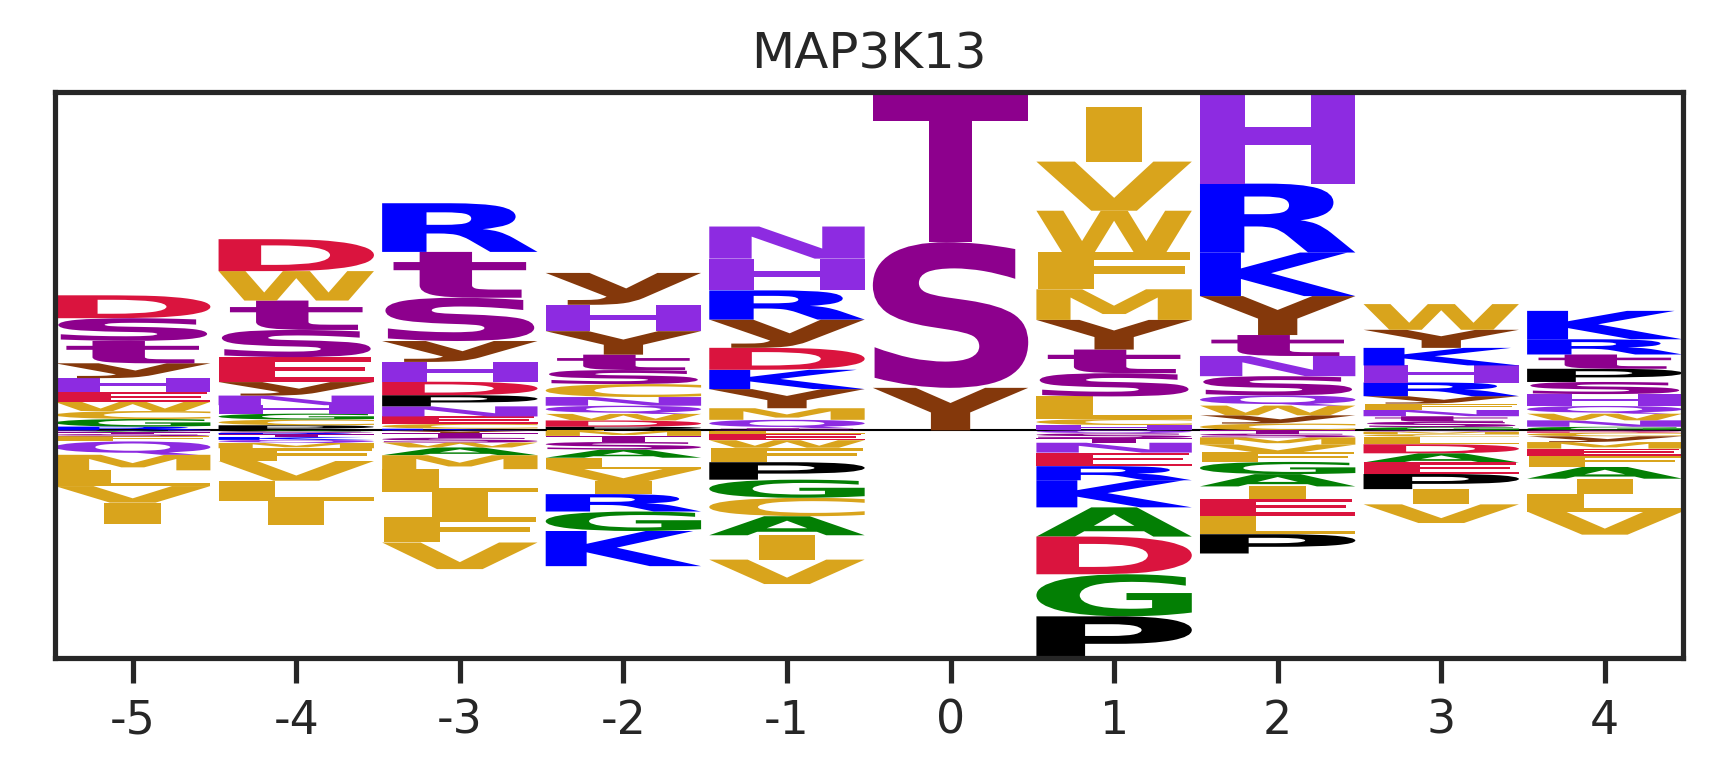

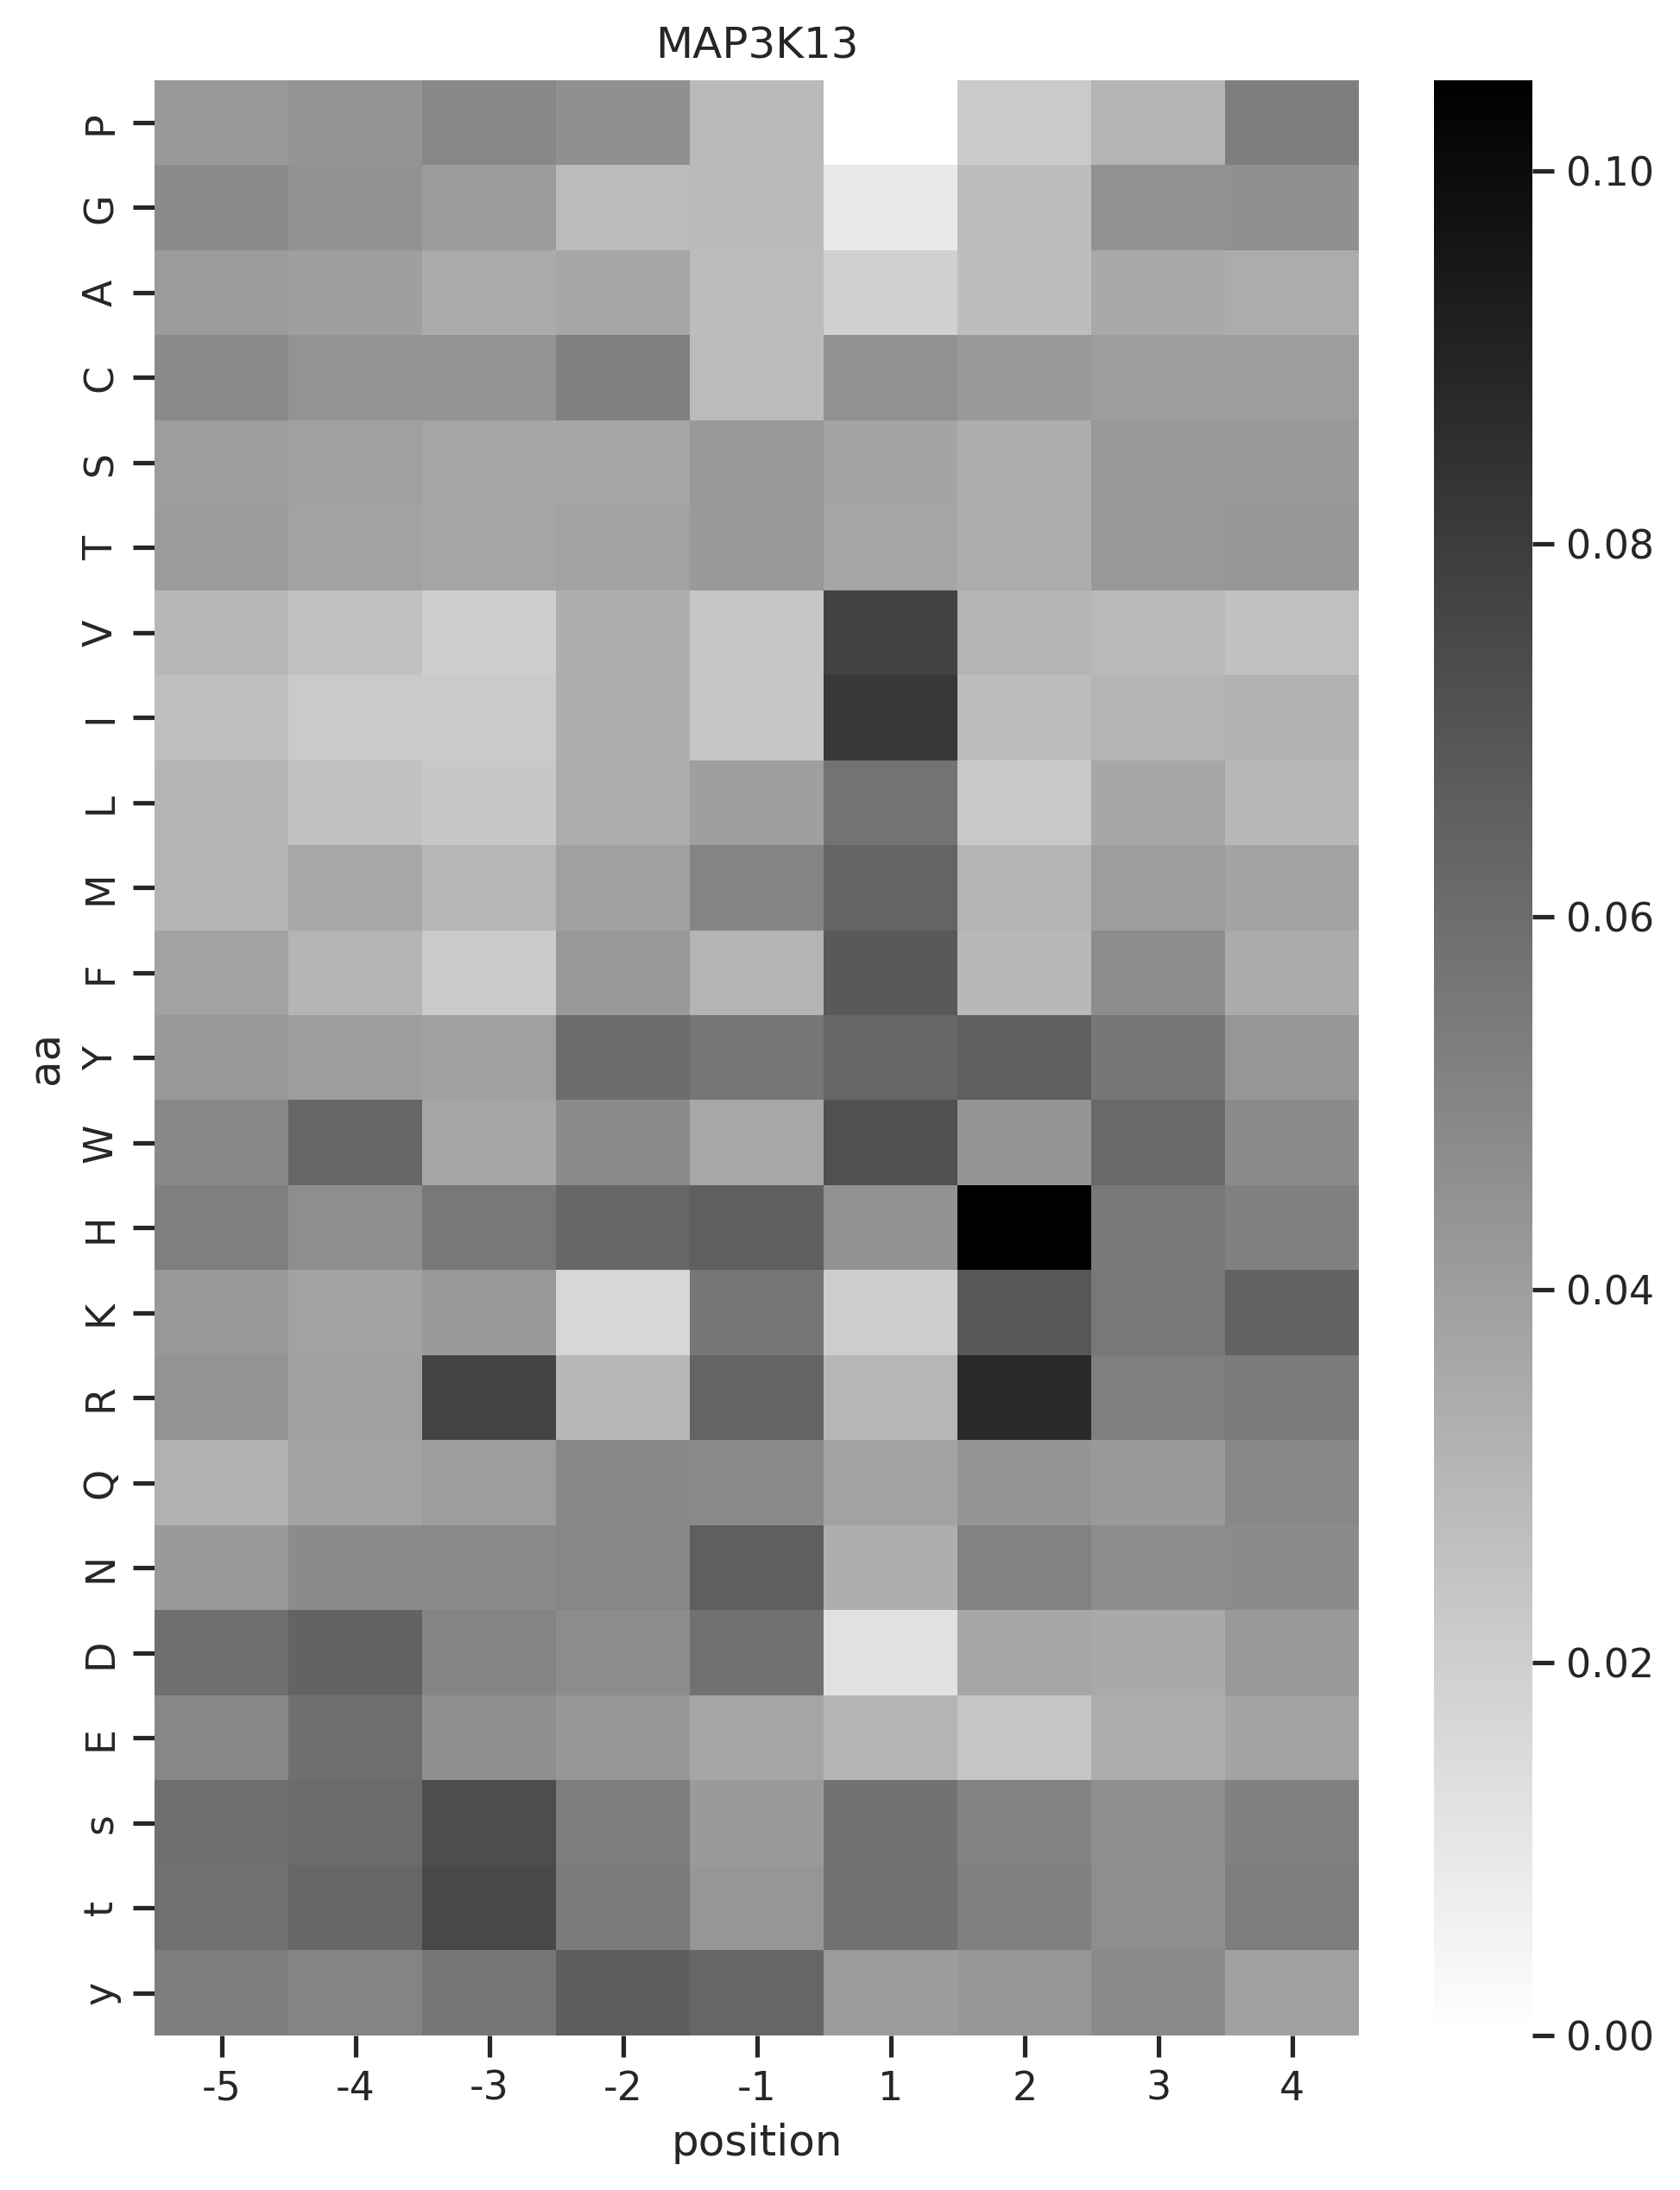

In [ ]:
matrix = get_one_kinase(preds_final,k,drop_s=False).T

get_logo2(matrix, k)
get_heatmap(preds_final.iloc[:,:-3], k)